In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

### Data preparation and model configuration

In [4]:
# ============= Import required packaages ==============
# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
from custom_classes_defs.Unet_like import *   
# from custom_classes_defs.fnet import *
# from custom_classes_defs.hed import *

import keras
import numpy as np
from glob import glob

from keras.utils import plot_model

RND_STATE = 247
BATCH_SIZE = 64
keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

# import keras_tuner as kt
# -------------------------------------------------------

2024-04-23 15:32:38.284741: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 15:32:38.285358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 15:32:38.338139: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 15:32:38.471531: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
if NUM_GPU:
    # print GPU info
    !nvidia-smi

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Tue Apr 23 15:33:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:01:00.0 Off |                    0 |
| N/A   30C    P0              59W / 400W |   1324MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

|   2  NVIDIA A100-SXM4-40GB          Off | 00000000:81:00.0 Off |                    0 |
| N/A   26C    P0              51W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
|   3  NVIDIA A100-SXM4-40GB          Off | 00000000:C1:00.0 Off |                    0 |
| N/A   47C    P0             295W / 400W |  37044MiB / 40960MiB |    100%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   G

In [6]:
pets = Oxford_Pets(
        input_dir = "./data/images/",
        target_dir = "./data/annotations/trimaps/",
        img_size = (160, 160),
        batch_size = BATCH_SIZE
    )

train_dataset, valid_dataset, test_dataset = \
        pets.split_data(train_ratio=0.5, val_ratio=0.2, seed=RND_STATE)

print(f"training data (size = {len(train_dataset)*BATCH_SIZE})")
print(f"validation data (size = {len(valid_dataset)*BATCH_SIZE})")
print(f"test data (size = {len(test_dataset)*BATCH_SIZE})")
print("Data images tensor:",train_dataset.element_spec[0])
print("Data labels tensor:",train_dataset.element_spec[1])


Number of samples: 7390


training data (size = 3712)
validation data (size = 1536)
test data (size = 2240)
Data images tensor: TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None)
Data labels tensor: TensorSpec(shape=(None, 160, 160, 1), dtype=tf.uint8, name=None)


2024-04-23 15:33:08.748051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38379 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


In [7]:

# Model configurations
conf = model_config(
    epochs=100,
    batch_size=BATCH_SIZE,
    scaling=1,
    verbose=1,
    save_path='./models/unet',
    img_shape=pets.img_size,
    target_size=pets.img_size,
    channels_dim=(3,3),
    new_training_session=True,
    multiple_gpu_device=(NUM_GPU>1)
)


callbacks=conf.callbacks()
conf.set( validation_data=valid_dataset,  callbacks=callbacks )
conf.set(
    'compile',
    optimizer=tf.keras.optimizers.legacy.Adam(1e-4), 
    loss="sparse_categorical_crossentropy",
    metrics= ['accuracy']
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

        compile_args:
                     optimizer: <class 'keras.src.optimizers.legacy.adam.Adam'>
                          loss: sparse_categorical_crossentropy
                       metrics: accuracy
       training_args:
                        epochs: 100
                    batch_size: 64
                       shuffle: False
                       verbose: 1
               validation_data: <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
                     callbacks: <keras.src.callbacks.ReduceLROnPlateau object at 0x7fc7cebc9b50>
                              : <keras.src.callbacks.ModelCheckpoint object at 0x7fc7cebb3990>
                              : <keras.src.callbacks.EarlyStopping object at 0x7fc730564810>
          model_arch:
                     img_shape: (160, 160)
                   target_size: (160, 160)
                  channels_dim: (3, 3)
                       scaling: 1
                  augmentation: False
new_training_session: True
     

### Build model

In [8]:
### SINGLE-HOST, MULTI-DEVICE SYNCHRONOUS TRAINING
## François Chollet. Deep Learning with Python, Second Edition (Kindle Location 12675). Manning Publications Co.. 
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    # m_obj = HED2D(num_freeze=4, model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)

# model.summary()
plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Total number of parameters: 2,058,979
Total trainable wieghts: 2,055,203
Total non-trainable wieghts: 3,776


### Train the model



	Train unet model
-------------------------------------------------------
Model training...


Epoch 1/100


2024-04-23 15:33:24.187283: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907



 1/58 [..............................] - ETA: 11:30 - loss: 6.0804 - accuracy: 0.2507


 2/58 [>.............................] - ETA: 3s - loss: 4.9432 - accuracy: 0.2724   


 3/58 [>.............................] - ETA: 3s - loss: 4.2359 - accuracy: 0.3223


 4/58 [=>............................] - ETA: 5s - loss: 3.7634 - accuracy: 0.3728


 5/58 [=>............................] - ETA: 5s - loss: 3.3836 - accuracy: 0.4201


 6/58 [==>...........................] - ETA: 5s - loss: 3.1498 - accuracy: 0.4536


 7/58 [==>...........................] - ETA: 5s - loss: 2.9698 - accuracy: 0.4820


 8/58 [===>..........................] - ETA: 5s - loss: 2.8429 - accuracy: 0.5031


 9/58 [===>..........................] - ETA: 5s - loss: 2.7491 - accuracy: 0.5195


10/58 [====>.........................] - ETA: 4s - loss: 2.6678 - accuracy: 0.5328


11/58 [====>.........................] - ETA: 4s - loss: 2.5987 - accuracy: 0.5448


12/58 [=====>........................] - ETA: 4s - loss: 2.5311 - accuracy: 0.5553


13/58 [=====>........................] - ETA: 4s - loss: 2.4750 - accuracy: 0.5623


14/58 [======>.......................] - ETA: 4s - loss: 2.4070 - accuracy: 0.5718


15/58 [======>.......................] - ETA: 4s - loss: 2.3620 - accuracy: 0.5759


16/58 [=======>......................] - ETA: 4s - loss: 2.3118 - accuracy: 0.5802


17/58 [=======>......................] - ETA: 4s - loss: 2.2680 - accuracy: 0.5835


18/58 [========>.....................] - ETA: 3s - loss: 2.2232 - accuracy: 0.5875


19/58 [========>.....................] - ETA: 3s - loss: 2.1850 - accuracy: 0.5907


20/58 [=========>....................] - ETA: 3s - loss: 2.1413 - accuracy: 0.5941


21/58 [=========>....................] - ETA: 3s - loss: 2.1073 - accuracy: 0.5965

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 3s - loss: 2.0722 - accuracy: 0.5988


23/58 [==========>...................] - ETA: 3s - loss: 2.0394 - accuracy: 0.6002


24/58 [===========>..................] - ETA: 3s - loss: 2.0073 - accuracy: 0.6017


25/58 [===========>..................] - ETA: 3s - loss: 1.9741 - accuracy: 0.6034


26/58 [============>.................] - ETA: 2s - loss: 1.9453 - accuracy: 0.6045


27/58 [============>.................] - ETA: 2s - loss: 1.9185 - accuracy: 0.6054


28/58 [=============>................] - ETA: 2s - loss: 1.8919 - accuracy: 0.6065


29/58 [==============>...............] - ETA: 2s - loss: 1.8664 - accuracy: 0.6077


30/58 [==============>...............] - ETA: 2s - loss: 1.8408 - accuracy: 0.6093


31/58 [===============>..............] - ETA: 2s - loss: 1.8156 - accuracy: 0.6112


32/58 [===============>..............] - ETA: 2s - loss: 1.7945 - accuracy: 0.6123


33/58 [================>.............] - ETA: 2s - loss: 1.7725 - accuracy: 0.6137


34/58 [================>.............] - ETA: 2s - loss: 1.7498 - accuracy: 0.6153


35/58 [=================>............] - ETA: 1s - loss: 1.7287 - accuracy: 0.6166


36/58 [=================>............] - ETA: 1s - loss: 1.7097 - accuracy: 0.6177


37/58 [==================>...........] - ETA: 1s - loss: 1.6902 - accuracy: 0.6191


38/58 [==================>...........] - ETA: 1s - loss: 1.6724 - accuracy: 0.6199


39/58 [===================>..........] - ETA: 1s - loss: 1.6549 - accuracy: 0.6209


40/58 [===================>..........] - ETA: 1s - loss: 1.6387 - accuracy: 0.6218


41/58 [====================>.........] - ETA: 1s - loss: 1.6210 - accuracy: 0.6232


42/58 [====================>.........] - ETA: 1s - loss: 1.6053 - accuracy: 0.6242


43/58 [=====================>........] - ETA: 1s - loss: 1.5899 - accuracy: 0.6253


44/58 [=====================>........] - ETA: 1s - loss: 1.5763 - accuracy: 0.6260


45/58 [======================>.......] - ETA: 1s - loss: 1.5629 - accuracy: 0.6268


46/58 [======================>.......] - ETA: 0s - loss: 1.5498 - accuracy: 0.6277


47/58 [=======================>......] - ETA: 0s - loss: 1.5381 - accuracy: 0.6282


48/58 [=======================>......] - ETA: 0s - loss: 1.5253 - accuracy: 0.6292


49/58 [========================>.....] - ETA: 0s - loss: 1.5129 - accuracy: 0.6300


50/58 [========================>.....] - ETA: 0s - loss: 1.5007 - accuracy: 0.6311


51/58 [=========================>....] - ETA: 0s - loss: 1.4889 - accuracy: 0.6322


52/58 [=========================>....] - ETA: 0s - loss: 1.4776 - accuracy: 0.6332


53/58 [==========================>...] - ETA: 0s - loss: 1.4660 - accuracy: 0.6344


54/58 [==========================>...] - ETA: 0s - loss: 1.4548 - accuracy: 0.6355


55/58 [===========================>..] - ETA: 0s - loss: 1.4450 - accuracy: 0.6363


56/58 [===========================>..] - ETA: 0s - loss: 1.4357 - accuracy: 0.6372


57/58 [============================>.] - ETA: 0s - loss: 1.4258 - accuracy: 0.6382


58/58 [==============================] - ETA: 0s - loss: 1.4189 - accuracy: 0.6388

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 23s 185ms/step - loss: 1.4189 - accuracy: 0.6388 - val_loss: 1.1700 - val_accuracy: 0.5825 - lr: 1.0000e-04


Epoch 2/100



 1/58 [..............................] - ETA: 6s - loss: 0.7976 - accuracy: 0.7180


 2/58 [>.............................] - ETA: 2s - loss: 0.7996 - accuracy: 0.7116


 3/58 [>.............................] - ETA: 2s - loss: 0.8069 - accuracy: 0.7082


 4/58 [=>............................] - ETA: 2s - loss: 0.8207 - accuracy: 0.7016


 5/58 [=>............................] - ETA: 2s - loss: 0.8133 - accuracy: 0.7030


 6/58 [==>...........................] - ETA: 2s - loss: 0.8234 - accuracy: 0.6994


 7/58 [==>...........................] - ETA: 2s - loss: 0.8203 - accuracy: 0.6997


 8/58 [===>..........................] - ETA: 2s - loss: 0.8211 - accuracy: 0.6989


 9/58 [===>..........................] - ETA: 2s - loss: 0.8246 - accuracy: 0.6984


10/58 [====>.........................] - ETA: 2s - loss: 0.8289 - accuracy: 0.6968


11/58 [====>.........................] - ETA: 2s - loss: 0.8315 - accuracy: 0.6964


12/58 [=====>........................] - ETA: 2s - loss: 0.8293 - accuracy: 0.6976


13/58 [=====>........................] - ETA: 2s - loss: 0.8302 - accuracy: 0.6965


14/58 [======>.......................] - ETA: 2s - loss: 0.8230 - accuracy: 0.6988


15/58 [======>.......................] - ETA: 2s - loss: 0.8247 - accuracy: 0.6979


16/58 [=======>......................] - ETA: 2s - loss: 0.8238 - accuracy: 0.6978


17/58 [=======>......................] - ETA: 2s - loss: 0.8236 - accuracy: 0.6976


18/58 [========>.....................] - ETA: 2s - loss: 0.8228 - accuracy: 0.6977


19/58 [========>.....................] - ETA: 2s - loss: 0.8262 - accuracy: 0.6970


20/58 [=========>....................] - ETA: 2s - loss: 0.8244 - accuracy: 0.6974

Corrupt JPEG data: premature end of data segment



21/58 [=========>....................] - ETA: 2s - loss: 0.8273 - accuracy: 0.6969


22/58 [==========>...................] - ETA: 1s - loss: 0.8276 - accuracy: 0.6969


23/58 [==========>...................] - ETA: 1s - loss: 0.8273 - accuracy: 0.6968


24/58 [===========>..................] - ETA: 1s - loss: 0.8263 - accuracy: 0.6970


25/58 [===========>..................] - ETA: 1s - loss: 0.8242 - accuracy: 0.6975


26/58 [============>.................] - ETA: 1s - loss: 0.8235 - accuracy: 0.6977


27/58 [============>.................] - ETA: 1s - loss: 0.8233 - accuracy: 0.6978


28/58 [=============>................] - ETA: 1s - loss: 0.8224 - accuracy: 0.6979


29/58 [==============>...............] - ETA: 1s - loss: 0.8218 - accuracy: 0.6979


30/58 [==============>...............] - ETA: 1s - loss: 0.8200 - accuracy: 0.6983


31/58 [===============>..............] - ETA: 1s - loss: 0.8178 - accuracy: 0.6990


32/58 [===============>..............] - ETA: 1s - loss: 0.8176 - accuracy: 0.6990


33/58 [================>.............] - ETA: 1s - loss: 0.8161 - accuracy: 0.6993


34/58 [================>.............] - ETA: 1s - loss: 0.8138 - accuracy: 0.6999


35/58 [=================>............] - ETA: 1s - loss: 0.8120 - accuracy: 0.7004


36/58 [=================>............] - ETA: 1s - loss: 0.8115 - accuracy: 0.7004


37/58 [==================>...........] - ETA: 1s - loss: 0.8098 - accuracy: 0.7009


38/58 [==================>...........] - ETA: 1s - loss: 0.8092 - accuracy: 0.7009


39/58 [===================>..........] - ETA: 1s - loss: 0.8077 - accuracy: 0.7011


40/58 [===================>..........] - ETA: 0s - loss: 0.8072 - accuracy: 0.7011


41/58 [====================>.........] - ETA: 0s - loss: 0.8050 - accuracy: 0.7016


42/58 [====================>.........] - ETA: 0s - loss: 0.8037 - accuracy: 0.7019


43/58 [=====================>........] - ETA: 0s - loss: 0.8022 - accuracy: 0.7023


44/58 [=====================>........] - ETA: 0s - loss: 0.8018 - accuracy: 0.7021


45/58 [======================>.......] - ETA: 0s - loss: 0.8015 - accuracy: 0.7022


46/58 [======================>.......] - ETA: 0s - loss: 0.8008 - accuracy: 0.7024


47/58 [=======================>......] - ETA: 0s - loss: 0.8010 - accuracy: 0.7022


48/58 [=======================>......] - ETA: 0s - loss: 0.8000 - accuracy: 0.7025


49/58 [========================>.....] - ETA: 0s - loss: 0.7991 - accuracy: 0.7026


50/58 [========================>.....] - ETA: 0s - loss: 0.7978 - accuracy: 0.7029


51/58 [=========================>....] - ETA: 0s - loss: 0.7966 - accuracy: 0.7033


52/58 [=========================>....] - ETA: 0s - loss: 0.7956 - accuracy: 0.7036


53/58 [==========================>...] - ETA: 0s - loss: 0.7939 - accuracy: 0.7041


54/58 [==========================>...] - ETA: 0s - loss: 0.7925 - accuracy: 0.7044


55/58 [===========================>..] - ETA: 0s - loss: 0.7919 - accuracy: 0.7045


56/58 [===========================>..] - ETA: 0s - loss: 0.7915 - accuracy: 0.7047


57/58 [============================>.] - ETA: 0s - loss: 0.7903 - accuracy: 0.7050

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 75ms/step - loss: 0.7896 - accuracy: 0.7052 - val_loss: 1.6248 - val_accuracy: 0.5891 - lr: 1.0000e-04


Epoch 3/100



 1/58 [..............................] - ETA: 6s - loss: 0.6774 - accuracy: 0.7434


 2/58 [>.............................] - ETA: 3s - loss: 0.6850 - accuracy: 0.7353


 3/58 [>.............................] - ETA: 3s - loss: 0.6924 - accuracy: 0.7310


 4/58 [=>............................] - ETA: 3s - loss: 0.7062 - accuracy: 0.7253


 5/58 [=>............................] - ETA: 2s - loss: 0.7000 - accuracy: 0.7273


 6/58 [==>...........................] - ETA: 2s - loss: 0.7082 - accuracy: 0.7250


 7/58 [==>...........................] - ETA: 2s - loss: 0.7065 - accuracy: 0.7252


 8/58 [===>..........................] - ETA: 2s - loss: 0.7075 - accuracy: 0.7250


 9/58 [===>..........................] - ETA: 2s - loss: 0.7113 - accuracy: 0.7243


10/58 [====>.........................] - ETA: 2s - loss: 0.7160 - accuracy: 0.7224


11/58 [====>.........................] - ETA: 2s - loss: 0.7182 - accuracy: 0.7220


12/58 [=====>........................] - ETA: 2s - loss: 0.7166 - accuracy: 0.7231


13/58 [=====>........................] - ETA: 2s - loss: 0.7186 - accuracy: 0.7218


14/58 [======>.......................] - ETA: 2s - loss: 0.7132 - accuracy: 0.7238


15/58 [======>.......................] - ETA: 2s - loss: 0.7154 - accuracy: 0.7228


16/58 [=======>......................] - ETA: 2s - loss: 0.7156 - accuracy: 0.7226


17/58 [=======>......................] - ETA: 2s - loss: 0.7161 - accuracy: 0.7222


18/58 [========>.....................] - ETA: 2s - loss: 0.7158 - accuracy: 0.7224


19/58 [========>.....................] - ETA: 2s - loss: 0.7194 - accuracy: 0.7216


20/58 [=========>....................] - ETA: 2s - loss: 0.7182 - accuracy: 0.7219


21/58 [=========>....................] - ETA: 1s - loss: 0.7213 - accuracy: 0.7214

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.7224 - accuracy: 0.7212


23/58 [==========>...................] - ETA: 1s - loss: 0.7230 - accuracy: 0.7210


24/58 [===========>..................] - ETA: 1s - loss: 0.7224 - accuracy: 0.7211


25/58 [===========>..................] - ETA: 1s - loss: 0.7210 - accuracy: 0.7215


26/58 [============>.................] - ETA: 1s - loss: 0.7208 - accuracy: 0.7218


27/58 [============>.................] - ETA: 1s - loss: 0.7211 - accuracy: 0.7218


28/58 [=============>................] - ETA: 1s - loss: 0.7210 - accuracy: 0.7218


29/58 [==============>...............] - ETA: 1s - loss: 0.7210 - accuracy: 0.7216


30/58 [==============>...............] - ETA: 1s - loss: 0.7198 - accuracy: 0.7219


31/58 [===============>..............] - ETA: 1s - loss: 0.7183 - accuracy: 0.7225


32/58 [===============>..............] - ETA: 1s - loss: 0.7185 - accuracy: 0.7224


33/58 [================>.............] - ETA: 1s - loss: 0.7176 - accuracy: 0.7227


34/58 [================>.............] - ETA: 1s - loss: 0.7162 - accuracy: 0.7232


35/58 [=================>............] - ETA: 1s - loss: 0.7150 - accuracy: 0.7236


36/58 [=================>............] - ETA: 1s - loss: 0.7150 - accuracy: 0.7237


37/58 [==================>...........] - ETA: 1s - loss: 0.7139 - accuracy: 0.7242


38/58 [==================>...........] - ETA: 1s - loss: 0.7139 - accuracy: 0.7241


39/58 [===================>..........] - ETA: 1s - loss: 0.7129 - accuracy: 0.7243


40/58 [===================>..........] - ETA: 0s - loss: 0.7128 - accuracy: 0.7243


41/58 [====================>.........] - ETA: 0s - loss: 0.7113 - accuracy: 0.7246


42/58 [====================>.........] - ETA: 0s - loss: 0.7106 - accuracy: 0.7248


43/58 [=====================>........] - ETA: 0s - loss: 0.7096 - accuracy: 0.7251


44/58 [=====================>........] - ETA: 0s - loss: 0.7098 - accuracy: 0.7249


45/58 [======================>.......] - ETA: 0s - loss: 0.7100 - accuracy: 0.7249


46/58 [======================>.......] - ETA: 0s - loss: 0.7096 - accuracy: 0.7250


47/58 [=======================>......] - ETA: 0s - loss: 0.7104 - accuracy: 0.7247


48/58 [=======================>......] - ETA: 0s - loss: 0.7098 - accuracy: 0.7250


49/58 [========================>.....] - ETA: 0s - loss: 0.7094 - accuracy: 0.7250


50/58 [========================>.....] - ETA: 0s - loss: 0.7087 - accuracy: 0.7253


51/58 [=========================>....] - ETA: 0s - loss: 0.7079 - accuracy: 0.7256


52/58 [=========================>....] - ETA: 0s - loss: 0.7074 - accuracy: 0.7257


53/58 [==========================>...] - ETA: 0s - loss: 0.7063 - accuracy: 0.7261


54/58 [==========================>...] - ETA: 0s - loss: 0.7054 - accuracy: 0.7264


55/58 [===========================>..] - ETA: 0s - loss: 0.7051 - accuracy: 0.7265


56/58 [===========================>..] - ETA: 0s - loss: 0.7053 - accuracy: 0.7265


57/58 [============================>.] - ETA: 0s - loss: 0.7045 - accuracy: 0.7267

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 75ms/step - loss: 0.7038 - accuracy: 0.7270 - val_loss: 2.3535 - val_accuracy: 0.5900 - lr: 1.0000e-04


Epoch 4/100



 1/58 [..............................] - ETA: 6s - loss: 0.6205 - accuracy: 0.7614


 2/58 [>.............................] - ETA: 3s - loss: 0.6311 - accuracy: 0.7521


 3/58 [>.............................] - ETA: 3s - loss: 0.6399 - accuracy: 0.7471


 4/58 [=>............................] - ETA: 3s - loss: 0.6548 - accuracy: 0.7411


 5/58 [=>............................] - ETA: 2s - loss: 0.6485 - accuracy: 0.7432


 6/58 [==>...........................] - ETA: 2s - loss: 0.6550 - accuracy: 0.7414


 7/58 [==>...........................] - ETA: 2s - loss: 0.6533 - accuracy: 0.7414


 8/58 [===>..........................] - ETA: 2s - loss: 0.6544 - accuracy: 0.7413


 9/58 [===>..........................] - ETA: 2s - loss: 0.6586 - accuracy: 0.7403


10/58 [====>.........................] - ETA: 2s - loss: 0.6630 - accuracy: 0.7384


11/58 [====>.........................] - ETA: 2s - loss: 0.6647 - accuracy: 0.7379


12/58 [=====>........................] - ETA: 2s - loss: 0.6638 - accuracy: 0.7387


13/58 [=====>........................] - ETA: 2s - loss: 0.6673 - accuracy: 0.7370


14/58 [======>.......................] - ETA: 2s - loss: 0.6625 - accuracy: 0.7388


15/58 [======>.......................] - ETA: 2s - loss: 0.6643 - accuracy: 0.7382


16/58 [=======>......................] - ETA: 2s - loss: 0.6644 - accuracy: 0.7380


17/58 [=======>......................] - ETA: 2s - loss: 0.6657 - accuracy: 0.7374


18/58 [========>.....................] - ETA: 2s - loss: 0.6657 - accuracy: 0.7375


19/58 [========>.....................] - ETA: 2s - loss: 0.6698 - accuracy: 0.7365


20/58 [=========>....................] - ETA: 2s - loss: 0.6688 - accuracy: 0.7368


21/58 [=========>....................] - ETA: 1s - loss: 0.6718 - accuracy: 0.7363

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.6731 - accuracy: 0.7359


23/58 [==========>...................] - ETA: 1s - loss: 0.6741 - accuracy: 0.7355


24/58 [===========>..................] - ETA: 1s - loss: 0.6741 - accuracy: 0.7354


25/58 [===========>..................] - ETA: 1s - loss: 0.6729 - accuracy: 0.7358


26/58 [============>.................] - ETA: 1s - loss: 0.6728 - accuracy: 0.7360


27/58 [============>.................] - ETA: 1s - loss: 0.6733 - accuracy: 0.7360


28/58 [=============>................] - ETA: 1s - loss: 0.6735 - accuracy: 0.7359


29/58 [==============>...............] - ETA: 1s - loss: 0.6739 - accuracy: 0.7357


30/58 [==============>...............] - ETA: 1s - loss: 0.6728 - accuracy: 0.7360


31/58 [===============>..............] - ETA: 1s - loss: 0.6714 - accuracy: 0.7365


32/58 [===============>..............] - ETA: 1s - loss: 0.6719 - accuracy: 0.7364


33/58 [================>.............] - ETA: 1s - loss: 0.6712 - accuracy: 0.7366


34/58 [================>.............] - ETA: 1s - loss: 0.6701 - accuracy: 0.7370


35/58 [=================>............] - ETA: 1s - loss: 0.6691 - accuracy: 0.7375


36/58 [=================>............] - ETA: 1s - loss: 0.6690 - accuracy: 0.7376


37/58 [==================>...........] - ETA: 1s - loss: 0.6680 - accuracy: 0.7381


38/58 [==================>...........] - ETA: 1s - loss: 0.6684 - accuracy: 0.7379


39/58 [===================>..........] - ETA: 1s - loss: 0.6675 - accuracy: 0.7382


40/58 [===================>..........] - ETA: 0s - loss: 0.6675 - accuracy: 0.7382


41/58 [====================>.........] - ETA: 0s - loss: 0.6661 - accuracy: 0.7386


42/58 [====================>.........] - ETA: 0s - loss: 0.6655 - accuracy: 0.7387


43/58 [=====================>........] - ETA: 0s - loss: 0.6648 - accuracy: 0.7390


44/58 [=====================>........] - ETA: 0s - loss: 0.6653 - accuracy: 0.7386


45/58 [======================>.......] - ETA: 0s - loss: 0.6655 - accuracy: 0.7386


46/58 [======================>.......] - ETA: 0s - loss: 0.6651 - accuracy: 0.7387


47/58 [=======================>......] - ETA: 0s - loss: 0.6660 - accuracy: 0.7384


48/58 [=======================>......] - ETA: 0s - loss: 0.6655 - accuracy: 0.7387


49/58 [========================>.....] - ETA: 0s - loss: 0.6651 - accuracy: 0.7388


50/58 [========================>.....] - ETA: 0s - loss: 0.6644 - accuracy: 0.7390


51/58 [=========================>....] - ETA: 0s - loss: 0.6635 - accuracy: 0.7394


52/58 [=========================>....] - ETA: 0s - loss: 0.6632 - accuracy: 0.7395


53/58 [==========================>...] - ETA: 0s - loss: 0.6624 - accuracy: 0.7398


54/58 [==========================>...] - ETA: 0s - loss: 0.6618 - accuracy: 0.7400


55/58 [===========================>..] - ETA: 0s - loss: 0.6614 - accuracy: 0.7400


56/58 [===========================>..] - ETA: 0s - loss: 0.6616 - accuracy: 0.7400


57/58 [============================>.] - ETA: 0s - loss: 0.6609 - accuracy: 0.7403

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 75ms/step - loss: 0.6602 - accuracy: 0.7406 - val_loss: 2.9334 - val_accuracy: 0.5900 - lr: 1.0000e-04


Epoch 5/100



 1/58 [..............................] - ETA: 6s - loss: 0.5849 - accuracy: 0.7730


 2/58 [>.............................] - ETA: 3s - loss: 0.5944 - accuracy: 0.7651


 3/58 [>.............................] - ETA: 3s - loss: 0.6039 - accuracy: 0.7597


 4/58 [=>............................] - ETA: 2s - loss: 0.6208 - accuracy: 0.7531


 5/58 [=>............................] - ETA: 2s - loss: 0.6153 - accuracy: 0.7548


 6/58 [==>...........................] - ETA: 2s - loss: 0.6196 - accuracy: 0.7533


 7/58 [==>...........................] - ETA: 2s - loss: 0.6168 - accuracy: 0.7541


 8/58 [===>..........................] - ETA: 2s - loss: 0.6181 - accuracy: 0.7539


 9/58 [===>..........................] - ETA: 2s - loss: 0.6232 - accuracy: 0.7524


10/58 [====>.........................] - ETA: 2s - loss: 0.6280 - accuracy: 0.7503


11/58 [====>.........................] - ETA: 2s - loss: 0.6288 - accuracy: 0.7500


12/58 [=====>........................] - ETA: 2s - loss: 0.6276 - accuracy: 0.7508


13/58 [=====>........................] - ETA: 2s - loss: 0.6318 - accuracy: 0.7490


14/58 [======>.......................] - ETA: 2s - loss: 0.6277 - accuracy: 0.7505


15/58 [======>.......................] - ETA: 2s - loss: 0.6291 - accuracy: 0.7500


16/58 [=======>......................] - ETA: 2s - loss: 0.6292 - accuracy: 0.7499


17/58 [=======>......................] - ETA: 2s - loss: 0.6302 - accuracy: 0.7494


18/58 [========>.....................] - ETA: 2s - loss: 0.6304 - accuracy: 0.7494


19/58 [========>.....................] - ETA: 2s - loss: 0.6355 - accuracy: 0.7481


20/58 [=========>....................] - ETA: 2s - loss: 0.6347 - accuracy: 0.7481


21/58 [=========>....................] - ETA: 2s - loss: 0.6374 - accuracy: 0.7476

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.6382 - accuracy: 0.7473


23/58 [==========>...................] - ETA: 1s - loss: 0.6394 - accuracy: 0.7468


24/58 [===========>..................] - ETA: 1s - loss: 0.6403 - accuracy: 0.7464


25/58 [===========>..................] - ETA: 1s - loss: 0.6396 - accuracy: 0.7465


26/58 [============>.................] - ETA: 1s - loss: 0.6395 - accuracy: 0.7467


27/58 [============>.................] - ETA: 1s - loss: 0.6395 - accuracy: 0.7468


28/58 [=============>................] - ETA: 1s - loss: 0.6400 - accuracy: 0.7467


29/58 [==============>...............] - ETA: 1s - loss: 0.6408 - accuracy: 0.7465


30/58 [==============>...............] - ETA: 1s - loss: 0.6402 - accuracy: 0.7467


31/58 [===============>..............] - ETA: 1s - loss: 0.6386 - accuracy: 0.7472


32/58 [===============>..............] - ETA: 1s - loss: 0.6387 - accuracy: 0.7472


33/58 [================>.............] - ETA: 1s - loss: 0.6381 - accuracy: 0.7474


34/58 [================>.............] - ETA: 1s - loss: 0.6374 - accuracy: 0.7477


35/58 [=================>............] - ETA: 1s - loss: 0.6367 - accuracy: 0.7480


36/58 [=================>............] - ETA: 1s - loss: 0.6365 - accuracy: 0.7481


37/58 [==================>...........] - ETA: 1s - loss: 0.6351 - accuracy: 0.7488


38/58 [==================>...........] - ETA: 1s - loss: 0.6357 - accuracy: 0.7486


39/58 [===================>..........] - ETA: 1s - loss: 0.6352 - accuracy: 0.7488


40/58 [===================>..........] - ETA: 0s - loss: 0.6354 - accuracy: 0.7488


41/58 [====================>.........] - ETA: 0s - loss: 0.6342 - accuracy: 0.7491


42/58 [====================>.........] - ETA: 0s - loss: 0.6334 - accuracy: 0.7495


43/58 [=====================>........] - ETA: 0s - loss: 0.6326 - accuracy: 0.7497


44/58 [=====================>........] - ETA: 0s - loss: 0.6335 - accuracy: 0.7493


45/58 [======================>.......] - ETA: 0s - loss: 0.6339 - accuracy: 0.7491


46/58 [======================>.......] - ETA: 0s - loss: 0.6335 - accuracy: 0.7492


47/58 [=======================>......] - ETA: 0s - loss: 0.6340 - accuracy: 0.7490


48/58 [=======================>......] - ETA: 0s - loss: 0.6335 - accuracy: 0.7494


49/58 [========================>.....] - ETA: 0s - loss: 0.6332 - accuracy: 0.7495


50/58 [========================>.....] - ETA: 0s - loss: 0.6326 - accuracy: 0.7497


51/58 [=========================>....] - ETA: 0s - loss: 0.6316 - accuracy: 0.7501


52/58 [=========================>....] - ETA: 0s - loss: 0.6313 - accuracy: 0.7502


53/58 [==========================>...] - ETA: 0s - loss: 0.6306 - accuracy: 0.7504


54/58 [==========================>...] - ETA: 0s - loss: 0.6302 - accuracy: 0.7506


55/58 [===========================>..] - ETA: 0s - loss: 0.6298 - accuracy: 0.7506


56/58 [===========================>..] - ETA: 0s - loss: 0.6297 - accuracy: 0.7507


57/58 [============================>.] - ETA: 0s - loss: 0.6290 - accuracy: 0.7509

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.6284 - accuracy: 0.7512 - val_loss: 3.2962 - val_accuracy: 0.5900 - lr: 1.0000e-04


Epoch 6/100



 1/58 [..............................] - ETA: 6s - loss: 0.5618 - accuracy: 0.7810


 2/58 [>.............................] - ETA: 2s - loss: 0.5696 - accuracy: 0.7748


 3/58 [>.............................] - ETA: 3s - loss: 0.5785 - accuracy: 0.7696


 4/58 [=>............................] - ETA: 2s - loss: 0.5939 - accuracy: 0.7637


 5/58 [=>............................] - ETA: 2s - loss: 0.5887 - accuracy: 0.7650


 6/58 [==>...........................] - ETA: 2s - loss: 0.5922 - accuracy: 0.7637


 7/58 [==>...........................] - ETA: 2s - loss: 0.5889 - accuracy: 0.7649


 8/58 [===>..........................] - ETA: 2s - loss: 0.5898 - accuracy: 0.7646


 9/58 [===>..........................] - ETA: 2s - loss: 0.5946 - accuracy: 0.7631


10/58 [====>.........................] - ETA: 2s - loss: 0.5994 - accuracy: 0.7609


11/58 [====>.........................] - ETA: 2s - loss: 0.6003 - accuracy: 0.7606


12/58 [=====>........................] - ETA: 2s - loss: 0.5987 - accuracy: 0.7614


13/58 [=====>........................] - ETA: 2s - loss: 0.6015 - accuracy: 0.7601


14/58 [======>.......................] - ETA: 2s - loss: 0.5978 - accuracy: 0.7614


15/58 [======>.......................] - ETA: 2s - loss: 0.5995 - accuracy: 0.7609


16/58 [=======>......................] - ETA: 2s - loss: 0.6001 - accuracy: 0.7606


17/58 [=======>......................] - ETA: 2s - loss: 0.6006 - accuracy: 0.7602


18/58 [========>.....................] - ETA: 2s - loss: 0.6002 - accuracy: 0.7603


19/58 [========>.....................] - ETA: 2s - loss: 0.6050 - accuracy: 0.7590


20/58 [=========>....................] - ETA: 2s - loss: 0.6048 - accuracy: 0.7587


21/58 [=========>....................] - ETA: 1s - loss: 0.6076 - accuracy: 0.7582

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.6081 - accuracy: 0.7579


23/58 [==========>...................] - ETA: 1s - loss: 0.6089 - accuracy: 0.7575


24/58 [===========>..................] - ETA: 1s - loss: 0.6098 - accuracy: 0.7571


25/58 [===========>..................] - ETA: 1s - loss: 0.6098 - accuracy: 0.7569


26/58 [============>.................] - ETA: 1s - loss: 0.6100 - accuracy: 0.7569


27/58 [============>.................] - ETA: 1s - loss: 0.6097 - accuracy: 0.7571


28/58 [=============>................] - ETA: 1s - loss: 0.6098 - accuracy: 0.7571


29/58 [==============>...............] - ETA: 1s - loss: 0.6106 - accuracy: 0.7569


30/58 [==============>...............] - ETA: 1s - loss: 0.6103 - accuracy: 0.7570


31/58 [===============>..............] - ETA: 1s - loss: 0.6089 - accuracy: 0.7575


32/58 [===============>..............] - ETA: 1s - loss: 0.6089 - accuracy: 0.7575


33/58 [================>.............] - ETA: 1s - loss: 0.6082 - accuracy: 0.7577


34/58 [================>.............] - ETA: 1s - loss: 0.6074 - accuracy: 0.7580


35/58 [=================>............] - ETA: 1s - loss: 0.6070 - accuracy: 0.7582


36/58 [=================>............] - ETA: 1s - loss: 0.6071 - accuracy: 0.7583


37/58 [==================>...........] - ETA: 1s - loss: 0.6056 - accuracy: 0.7589


38/58 [==================>...........] - ETA: 1s - loss: 0.6062 - accuracy: 0.7588


39/58 [===================>..........] - ETA: 1s - loss: 0.6058 - accuracy: 0.7589


40/58 [===================>..........] - ETA: 0s - loss: 0.6063 - accuracy: 0.7588


41/58 [====================>.........] - ETA: 0s - loss: 0.6054 - accuracy: 0.7591


42/58 [====================>.........] - ETA: 0s - loss: 0.6045 - accuracy: 0.7595


43/58 [=====================>........] - ETA: 0s - loss: 0.6038 - accuracy: 0.7598


44/58 [=====================>........] - ETA: 0s - loss: 0.6046 - accuracy: 0.7593


45/58 [======================>.......] - ETA: 0s - loss: 0.6051 - accuracy: 0.7591


46/58 [======================>.......] - ETA: 0s - loss: 0.6050 - accuracy: 0.7592


47/58 [=======================>......] - ETA: 0s - loss: 0.6055 - accuracy: 0.7590


48/58 [=======================>......] - ETA: 0s - loss: 0.6048 - accuracy: 0.7593


49/58 [========================>.....] - ETA: 0s - loss: 0.6046 - accuracy: 0.7594


50/58 [========================>.....] - ETA: 0s - loss: 0.6041 - accuracy: 0.7596


51/58 [=========================>....] - ETA: 0s - loss: 0.6031 - accuracy: 0.7600


52/58 [=========================>....] - ETA: 0s - loss: 0.6030 - accuracy: 0.7601


53/58 [==========================>...] - ETA: 0s - loss: 0.6024 - accuracy: 0.7603


54/58 [==========================>...] - ETA: 0s - loss: 0.6019 - accuracy: 0.7605


55/58 [===========================>..] - ETA: 0s - loss: 0.6017 - accuracy: 0.7605


56/58 [===========================>..] - ETA: 0s - loss: 0.6016 - accuracy: 0.7605


57/58 [============================>.] - ETA: 0s - loss: 0.6010 - accuracy: 0.7607

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.6004 - accuracy: 0.7610 - val_loss: 3.4454 - val_accuracy: 0.5900 - lr: 1.0000e-04


Epoch 7/100



 1/58 [..............................] - ETA: 6s - loss: 0.5382 - accuracy: 0.7884


 2/58 [>.............................] - ETA: 3s - loss: 0.5462 - accuracy: 0.7829


 3/58 [>.............................] - ETA: 2s - loss: 0.5559 - accuracy: 0.7778


 4/58 [=>............................] - ETA: 2s - loss: 0.5707 - accuracy: 0.7723


 5/58 [=>............................] - ETA: 2s - loss: 0.5656 - accuracy: 0.7736


 6/58 [==>...........................] - ETA: 2s - loss: 0.5688 - accuracy: 0.7726


 7/58 [==>...........................] - ETA: 2s - loss: 0.5656 - accuracy: 0.7738


 8/58 [===>..........................] - ETA: 2s - loss: 0.5665 - accuracy: 0.7735


 9/58 [===>..........................] - ETA: 2s - loss: 0.5711 - accuracy: 0.7720


10/58 [====>.........................] - ETA: 2s - loss: 0.5755 - accuracy: 0.7699


11/58 [====>.........................] - ETA: 2s - loss: 0.5765 - accuracy: 0.7694


12/58 [=====>........................] - ETA: 2s - loss: 0.5751 - accuracy: 0.7701


13/58 [=====>........................] - ETA: 2s - loss: 0.5772 - accuracy: 0.7691


14/58 [======>.......................] - ETA: 2s - loss: 0.5737 - accuracy: 0.7703


15/58 [======>.......................] - ETA: 2s - loss: 0.5755 - accuracy: 0.7698


16/58 [=======>......................] - ETA: 2s - loss: 0.5763 - accuracy: 0.7694


17/58 [=======>......................] - ETA: 2s - loss: 0.5769 - accuracy: 0.7690


18/58 [========>.....................] - ETA: 2s - loss: 0.5764 - accuracy: 0.7692


19/58 [========>.....................] - ETA: 2s - loss: 0.5808 - accuracy: 0.7680


20/58 [=========>....................] - ETA: 2s - loss: 0.5807 - accuracy: 0.7677


21/58 [=========>....................] - ETA: 1s - loss: 0.5837 - accuracy: 0.7670

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.5842 - accuracy: 0.7667


23/58 [==========>...................] - ETA: 1s - loss: 0.5848 - accuracy: 0.7664


24/58 [===========>..................] - ETA: 1s - loss: 0.5854 - accuracy: 0.7661


25/58 [===========>..................] - ETA: 1s - loss: 0.5856 - accuracy: 0.7658


26/58 [============>.................] - ETA: 1s - loss: 0.5862 - accuracy: 0.7656


27/58 [============>.................] - ETA: 1s - loss: 0.5859 - accuracy: 0.7658


28/58 [=============>................] - ETA: 1s - loss: 0.5858 - accuracy: 0.7658


29/58 [==============>...............] - ETA: 1s - loss: 0.5863 - accuracy: 0.7657


30/58 [==============>...............] - ETA: 1s - loss: 0.5861 - accuracy: 0.7658


31/58 [===============>..............] - ETA: 1s - loss: 0.5850 - accuracy: 0.7662


32/58 [===============>..............] - ETA: 1s - loss: 0.5849 - accuracy: 0.7662


33/58 [================>.............] - ETA: 1s - loss: 0.5842 - accuracy: 0.7664


34/58 [================>.............] - ETA: 1s - loss: 0.5835 - accuracy: 0.7667


35/58 [=================>............] - ETA: 1s - loss: 0.5831 - accuracy: 0.7669


36/58 [=================>............] - ETA: 1s - loss: 0.5833 - accuracy: 0.7669


37/58 [==================>...........] - ETA: 1s - loss: 0.5819 - accuracy: 0.7676


38/58 [==================>...........] - ETA: 1s - loss: 0.5826 - accuracy: 0.7673


39/58 [===================>..........] - ETA: 1s - loss: 0.5823 - accuracy: 0.7674


40/58 [===================>..........] - ETA: 0s - loss: 0.5828 - accuracy: 0.7673


41/58 [====================>.........] - ETA: 0s - loss: 0.5820 - accuracy: 0.7676


42/58 [====================>.........] - ETA: 0s - loss: 0.5812 - accuracy: 0.7680


43/58 [=====================>........] - ETA: 0s - loss: 0.5806 - accuracy: 0.7682


44/58 [=====================>........] - ETA: 0s - loss: 0.5813 - accuracy: 0.7679


45/58 [======================>.......] - ETA: 0s - loss: 0.5819 - accuracy: 0.7677


46/58 [======================>.......] - ETA: 0s - loss: 0.5819 - accuracy: 0.7676


47/58 [=======================>......] - ETA: 0s - loss: 0.5823 - accuracy: 0.7675


48/58 [=======================>......] - ETA: 0s - loss: 0.5817 - accuracy: 0.7678


49/58 [========================>.....] - ETA: 0s - loss: 0.5815 - accuracy: 0.7679


50/58 [========================>.....] - ETA: 0s - loss: 0.5809 - accuracy: 0.7681


51/58 [=========================>....] - ETA: 0s - loss: 0.5800 - accuracy: 0.7685


52/58 [=========================>....] - ETA: 0s - loss: 0.5800 - accuracy: 0.7685


53/58 [==========================>...] - ETA: 0s - loss: 0.5795 - accuracy: 0.7687


54/58 [==========================>...] - ETA: 0s - loss: 0.5790 - accuracy: 0.7689


55/58 [===========================>..] - ETA: 0s - loss: 0.5788 - accuracy: 0.7689


56/58 [===========================>..] - ETA: 0s - loss: 0.5786 - accuracy: 0.7690


57/58 [============================>.] - ETA: 0s - loss: 0.5782 - accuracy: 0.7691

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 76ms/step - loss: 0.5776 - accuracy: 0.7693 - val_loss: 3.2503 - val_accuracy: 0.5900 - lr: 1.0000e-04


Epoch 8/100



 1/58 [..............................] - ETA: 6s - loss: 0.5178 - accuracy: 0.7952


 2/58 [>.............................] - ETA: 3s - loss: 0.5254 - accuracy: 0.7901


 3/58 [>.............................] - ETA: 2s - loss: 0.5352 - accuracy: 0.7853


 4/58 [=>............................] - ETA: 2s - loss: 0.5501 - accuracy: 0.7801


 5/58 [=>............................] - ETA: 2s - loss: 0.5454 - accuracy: 0.7813


 6/58 [==>...........................] - ETA: 2s - loss: 0.5484 - accuracy: 0.7806


 7/58 [==>...........................] - ETA: 2s - loss: 0.5453 - accuracy: 0.7817


 8/58 [===>..........................] - ETA: 2s - loss: 0.5462 - accuracy: 0.7814


 9/58 [===>..........................] - ETA: 2s - loss: 0.5509 - accuracy: 0.7798


10/58 [====>.........................] - ETA: 2s - loss: 0.5550 - accuracy: 0.7778


11/58 [====>.........................] - ETA: 2s - loss: 0.5561 - accuracy: 0.7772


12/58 [=====>........................] - ETA: 2s - loss: 0.5549 - accuracy: 0.7778


13/58 [=====>........................] - ETA: 2s - loss: 0.5566 - accuracy: 0.7769


14/58 [======>.......................] - ETA: 2s - loss: 0.5533 - accuracy: 0.7781


15/58 [======>.......................] - ETA: 2s - loss: 0.5551 - accuracy: 0.7776


16/58 [=======>......................] - ETA: 2s - loss: 0.5560 - accuracy: 0.7772


17/58 [=======>......................] - ETA: 2s - loss: 0.5569 - accuracy: 0.7767


18/58 [========>.....................] - ETA: 2s - loss: 0.5564 - accuracy: 0.7770


19/58 [========>.....................] - ETA: 2s - loss: 0.5605 - accuracy: 0.7757


20/58 [=========>....................] - ETA: 2s - loss: 0.5605 - accuracy: 0.7755


21/58 [=========>....................] - ETA: 1s - loss: 0.5636 - accuracy: 0.7747

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.5640 - accuracy: 0.7743


23/58 [==========>...................] - ETA: 2s - loss: 0.5645 - accuracy: 0.7741


24/58 [===========>..................] - ETA: 2s - loss: 0.5648 - accuracy: 0.7739


25/58 [===========>..................] - ETA: 1s - loss: 0.5653 - accuracy: 0.7736


26/58 [============>.................] - ETA: 1s - loss: 0.5660 - accuracy: 0.7734


27/58 [============>.................] - ETA: 1s - loss: 0.5658 - accuracy: 0.7735


28/58 [=============>................] - ETA: 1s - loss: 0.5656 - accuracy: 0.7735


29/58 [==============>...............] - ETA: 1s - loss: 0.5658 - accuracy: 0.7735


30/58 [==============>...............] - ETA: 1s - loss: 0.5657 - accuracy: 0.7736


31/58 [===============>..............] - ETA: 1s - loss: 0.5647 - accuracy: 0.7739


32/58 [===============>..............] - ETA: 1s - loss: 0.5646 - accuracy: 0.7740


33/58 [================>.............] - ETA: 1s - loss: 0.5640 - accuracy: 0.7741


34/58 [================>.............] - ETA: 1s - loss: 0.5632 - accuracy: 0.7744


35/58 [=================>............] - ETA: 1s - loss: 0.5629 - accuracy: 0.7746


36/58 [=================>............] - ETA: 1s - loss: 0.5632 - accuracy: 0.7746


37/58 [==================>...........] - ETA: 1s - loss: 0.5619 - accuracy: 0.7751


38/58 [==================>...........] - ETA: 1s - loss: 0.5627 - accuracy: 0.7749


39/58 [===================>..........] - ETA: 1s - loss: 0.5625 - accuracy: 0.7749


40/58 [===================>..........] - ETA: 1s - loss: 0.5630 - accuracy: 0.7748


41/58 [====================>.........] - ETA: 0s - loss: 0.5623 - accuracy: 0.7751


42/58 [====================>.........] - ETA: 0s - loss: 0.5616 - accuracy: 0.7754


43/58 [=====================>........] - ETA: 0s - loss: 0.5610 - accuracy: 0.7757


44/58 [=====================>........] - ETA: 0s - loss: 0.5616 - accuracy: 0.7754


45/58 [======================>.......] - ETA: 0s - loss: 0.5621 - accuracy: 0.7752


46/58 [======================>.......] - ETA: 0s - loss: 0.5623 - accuracy: 0.7752


47/58 [=======================>......] - ETA: 0s - loss: 0.5627 - accuracy: 0.7750


48/58 [=======================>......] - ETA: 0s - loss: 0.5620 - accuracy: 0.7754


49/58 [========================>.....] - ETA: 0s - loss: 0.5619 - accuracy: 0.7754


50/58 [========================>.....] - ETA: 0s - loss: 0.5612 - accuracy: 0.7757


51/58 [=========================>....] - ETA: 0s - loss: 0.5604 - accuracy: 0.7760


52/58 [=========================>....] - ETA: 0s - loss: 0.5605 - accuracy: 0.7760


53/58 [==========================>...] - ETA: 0s - loss: 0.5599 - accuracy: 0.7762


54/58 [==========================>...] - ETA: 0s - loss: 0.5594 - accuracy: 0.7764


55/58 [===========================>..] - ETA: 0s - loss: 0.5592 - accuracy: 0.7764


56/58 [===========================>..] - ETA: 0s - loss: 0.5591 - accuracy: 0.7765


57/58 [============================>.] - ETA: 0s - loss: 0.5586 - accuracy: 0.7766

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.



58/58 [==============================] - 4s 76ms/step - loss: 0.5580 - accuracy: 0.7768 - val_loss: 2.6703 - val_accuracy: 0.5900 - lr: 1.0000e-04


Epoch 9/100



 1/58 [..............................] - ETA: 5s - loss: 0.5005 - accuracy: 0.8014


 2/58 [>.............................] - ETA: 2s - loss: 0.5064 - accuracy: 0.7969


 3/58 [>.............................] - ETA: 3s - loss: 0.5131 - accuracy: 0.7935


 4/58 [=>............................] - ETA: 2s - loss: 0.5273 - accuracy: 0.7884


 5/58 [=>............................] - ETA: 2s - loss: 0.5234 - accuracy: 0.7896


 6/58 [==>...........................] - ETA: 2s - loss: 0.5270 - accuracy: 0.7888


 7/58 [==>...........................] - ETA: 2s - loss: 0.5234 - accuracy: 0.7902


 8/58 [===>..........................] - ETA: 2s - loss: 0.5241 - accuracy: 0.7901


 9/58 [===>..........................] - ETA: 2s - loss: 0.5273 - accuracy: 0.7889


10/58 [====>.........................] - ETA: 2s - loss: 0.5306 - accuracy: 0.7874


11/58 [====>.........................] - ETA: 2s - loss: 0.5313 - accuracy: 0.7870


12/58 [=====>........................] - ETA: 2s - loss: 0.5306 - accuracy: 0.7873


13/58 [=====>........................] - ETA: 2s - loss: 0.5320 - accuracy: 0.7866


14/58 [======>.......................] - ETA: 2s - loss: 0.5295 - accuracy: 0.7873


15/58 [======>.......................] - ETA: 2s - loss: 0.5326 - accuracy: 0.7864


16/58 [=======>......................] - ETA: 2s - loss: 0.5348 - accuracy: 0.7854


17/58 [=======>......................] - ETA: 2s - loss: 0.5354 - accuracy: 0.7850


18/58 [========>.....................] - ETA: 2s - loss: 0.5340 - accuracy: 0.7857


19/58 [========>.....................] - ETA: 2s - loss: 0.5362 - accuracy: 0.7851


20/58 [=========>....................] - ETA: 2s - loss: 0.5359 - accuracy: 0.7851


21/58 [=========>....................] - ETA: 1s - loss: 0.5403 - accuracy: 0.7838

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.5412 - accuracy: 0.7834


23/58 [==========>...................] - ETA: 1s - loss: 0.5412 - accuracy: 0.7833


24/58 [===========>..................] - ETA: 1s - loss: 0.5399 - accuracy: 0.7838


25/58 [===========>..................] - ETA: 1s - loss: 0.5397 - accuracy: 0.7836


26/58 [============>.................] - ETA: 1s - loss: 0.5397 - accuracy: 0.7836


27/58 [============>.................] - ETA: 1s - loss: 0.5399 - accuracy: 0.7836


28/58 [=============>................] - ETA: 1s - loss: 0.5400 - accuracy: 0.7834


29/58 [==============>...............] - ETA: 1s - loss: 0.5392 - accuracy: 0.7837


30/58 [==============>...............] - ETA: 1s - loss: 0.5386 - accuracy: 0.7840


31/58 [===============>..............] - ETA: 1s - loss: 0.5374 - accuracy: 0.7845


32/58 [===============>..............] - ETA: 1s - loss: 0.5371 - accuracy: 0.7846


33/58 [================>.............] - ETA: 1s - loss: 0.5368 - accuracy: 0.7847


34/58 [================>.............] - ETA: 1s - loss: 0.5361 - accuracy: 0.7849


35/58 [=================>............] - ETA: 1s - loss: 0.5358 - accuracy: 0.7851


36/58 [=================>............] - ETA: 1s - loss: 0.5357 - accuracy: 0.7853


37/58 [==================>...........] - ETA: 1s - loss: 0.5345 - accuracy: 0.7857


38/58 [==================>...........] - ETA: 1s - loss: 0.5350 - accuracy: 0.7855


39/58 [===================>..........] - ETA: 1s - loss: 0.5346 - accuracy: 0.7856


40/58 [===================>..........] - ETA: 0s - loss: 0.5352 - accuracy: 0.7854


41/58 [====================>.........] - ETA: 0s - loss: 0.5343 - accuracy: 0.7858


42/58 [====================>.........] - ETA: 0s - loss: 0.5339 - accuracy: 0.7859


43/58 [=====================>........] - ETA: 0s - loss: 0.5335 - accuracy: 0.7861


44/58 [=====================>........] - ETA: 0s - loss: 0.5345 - accuracy: 0.7857


45/58 [======================>.......] - ETA: 0s - loss: 0.5349 - accuracy: 0.7855


46/58 [======================>.......] - ETA: 0s - loss: 0.5347 - accuracy: 0.7856


47/58 [=======================>......] - ETA: 0s - loss: 0.5354 - accuracy: 0.7854


48/58 [=======================>......] - ETA: 0s - loss: 0.5349 - accuracy: 0.7856


49/58 [========================>.....] - ETA: 0s - loss: 0.5351 - accuracy: 0.7854


50/58 [========================>.....] - ETA: 0s - loss: 0.5351 - accuracy: 0.7854


51/58 [=========================>....] - ETA: 0s - loss: 0.5345 - accuracy: 0.7856


52/58 [=========================>....] - ETA: 0s - loss: 0.5344 - accuracy: 0.7856


53/58 [==========================>...] - ETA: 0s - loss: 0.5341 - accuracy: 0.7858


54/58 [==========================>...] - ETA: 0s - loss: 0.5341 - accuracy: 0.7858


55/58 [===========================>..] - ETA: 0s - loss: 0.5338 - accuracy: 0.7859


56/58 [===========================>..] - ETA: 0s - loss: 0.5335 - accuracy: 0.7860


57/58 [============================>.] - ETA: 0s - loss: 0.5332 - accuracy: 0.7861

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 75ms/step - loss: 0.5329 - accuracy: 0.7863 - val_loss: 1.7823 - val_accuracy: 0.5920 - lr: 5.0000e-05


Epoch 10/100



 1/58 [..............................] - ETA: 6s - loss: 0.5046 - accuracy: 0.8024


 2/58 [>.............................] - ETA: 3s - loss: 0.5098 - accuracy: 0.7972


 3/58 [>.............................] - ETA: 3s - loss: 0.5091 - accuracy: 0.7968


 4/58 [=>............................] - ETA: 2s - loss: 0.5197 - accuracy: 0.7925


 5/58 [=>............................] - ETA: 2s - loss: 0.5150 - accuracy: 0.7940


 6/58 [==>...........................] - ETA: 2s - loss: 0.5174 - accuracy: 0.7935


 7/58 [==>...........................] - ETA: 2s - loss: 0.5152 - accuracy: 0.7938


 8/58 [===>..........................] - ETA: 2s - loss: 0.5160 - accuracy: 0.7936


 9/58 [===>..........................] - ETA: 2s - loss: 0.5193 - accuracy: 0.7921


10/58 [====>.........................] - ETA: 2s - loss: 0.5226 - accuracy: 0.7906


11/58 [====>.........................] - ETA: 2s - loss: 0.5228 - accuracy: 0.7904


12/58 [=====>........................] - ETA: 2s - loss: 0.5229 - accuracy: 0.7904


13/58 [=====>........................] - ETA: 2s - loss: 0.5234 - accuracy: 0.7901


14/58 [======>.......................] - ETA: 2s - loss: 0.5210 - accuracy: 0.7907


15/58 [======>.......................] - ETA: 2s - loss: 0.5242 - accuracy: 0.7898


16/58 [=======>......................] - ETA: 2s - loss: 0.5266 - accuracy: 0.7887


17/58 [=======>......................] - ETA: 2s - loss: 0.5275 - accuracy: 0.7883


18/58 [========>.....................] - ETA: 2s - loss: 0.5259 - accuracy: 0.7890


19/58 [========>.....................] - ETA: 2s - loss: 0.5280 - accuracy: 0.7885


20/58 [=========>....................] - ETA: 2s - loss: 0.5275 - accuracy: 0.7885


21/58 [=========>....................] - ETA: 1s - loss: 0.5313 - accuracy: 0.7874

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.5323 - accuracy: 0.7869


23/58 [==========>...................] - ETA: 1s - loss: 0.5324 - accuracy: 0.7868


24/58 [===========>..................] - ETA: 1s - loss: 0.5310 - accuracy: 0.7874


25/58 [===========>..................] - ETA: 1s - loss: 0.5307 - accuracy: 0.7873


26/58 [============>.................] - ETA: 1s - loss: 0.5306 - accuracy: 0.7873


27/58 [============>.................] - ETA: 1s - loss: 0.5307 - accuracy: 0.7873


28/58 [=============>................] - ETA: 1s - loss: 0.5308 - accuracy: 0.7870


29/58 [==============>...............] - ETA: 1s - loss: 0.5300 - accuracy: 0.7874


30/58 [==============>...............] - ETA: 1s - loss: 0.5294 - accuracy: 0.7877


31/58 [===============>..............] - ETA: 1s - loss: 0.5282 - accuracy: 0.7882


32/58 [===============>..............] - ETA: 1s - loss: 0.5278 - accuracy: 0.7883


33/58 [================>.............] - ETA: 1s - loss: 0.5276 - accuracy: 0.7884


34/58 [================>.............] - ETA: 1s - loss: 0.5268 - accuracy: 0.7886


35/58 [=================>............] - ETA: 1s - loss: 0.5265 - accuracy: 0.7888


36/58 [=================>............] - ETA: 1s - loss: 0.5264 - accuracy: 0.7890


37/58 [==================>...........] - ETA: 1s - loss: 0.5252 - accuracy: 0.7894


38/58 [==================>...........] - ETA: 1s - loss: 0.5258 - accuracy: 0.7892


39/58 [===================>..........] - ETA: 1s - loss: 0.5253 - accuracy: 0.7893


40/58 [===================>..........] - ETA: 0s - loss: 0.5260 - accuracy: 0.7891


41/58 [====================>.........] - ETA: 0s - loss: 0.5252 - accuracy: 0.7894


42/58 [====================>.........] - ETA: 0s - loss: 0.5247 - accuracy: 0.7896


43/58 [=====================>........] - ETA: 0s - loss: 0.5243 - accuracy: 0.7898


44/58 [=====================>........] - ETA: 0s - loss: 0.5252 - accuracy: 0.7894


45/58 [======================>.......] - ETA: 0s - loss: 0.5257 - accuracy: 0.7892


46/58 [======================>.......] - ETA: 0s - loss: 0.5255 - accuracy: 0.7893


47/58 [=======================>......] - ETA: 0s - loss: 0.5261 - accuracy: 0.7891


48/58 [=======================>......] - ETA: 0s - loss: 0.5256 - accuracy: 0.7893


49/58 [========================>.....] - ETA: 0s - loss: 0.5258 - accuracy: 0.7892


50/58 [========================>.....] - ETA: 0s - loss: 0.5258 - accuracy: 0.7892


51/58 [=========================>....] - ETA: 0s - loss: 0.5251 - accuracy: 0.7894


52/58 [=========================>....] - ETA: 0s - loss: 0.5251 - accuracy: 0.7894


53/58 [==========================>...] - ETA: 0s - loss: 0.5248 - accuracy: 0.7895


54/58 [==========================>...] - ETA: 0s - loss: 0.5248 - accuracy: 0.7895


55/58 [===========================>..] - ETA: 0s - loss: 0.5245 - accuracy: 0.7896


56/58 [===========================>..] - ETA: 0s - loss: 0.5242 - accuracy: 0.7897


57/58 [============================>.] - ETA: 0s - loss: 0.5238 - accuracy: 0.7899

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 5s 77ms/step - loss: 0.5235 - accuracy: 0.7900 - val_loss: 1.0673 - val_accuracy: 0.6376 - lr: 5.0000e-05


Epoch 11/100



 1/58 [..............................] - ETA: 6s - loss: 0.4950 - accuracy: 0.8062


 2/58 [>.............................] - ETA: 3s - loss: 0.4998 - accuracy: 0.8011


 3/58 [>.............................] - ETA: 3s - loss: 0.4987 - accuracy: 0.8010


 4/58 [=>............................] - ETA: 3s - loss: 0.5095 - accuracy: 0.7967


 5/58 [=>............................] - ETA: 2s - loss: 0.5050 - accuracy: 0.7981


 6/58 [==>...........................] - ETA: 2s - loss: 0.5072 - accuracy: 0.7977


 7/58 [==>...........................] - ETA: 2s - loss: 0.5052 - accuracy: 0.7979


 8/58 [===>..........................] - ETA: 2s - loss: 0.5061 - accuracy: 0.7977


 9/58 [===>..........................] - ETA: 2s - loss: 0.5095 - accuracy: 0.7960


10/58 [====>.........................] - ETA: 2s - loss: 0.5124 - accuracy: 0.7947


11/58 [====>.........................] - ETA: 2s - loss: 0.5127 - accuracy: 0.7944


12/58 [=====>........................] - ETA: 2s - loss: 0.5128 - accuracy: 0.7945


13/58 [=====>........................] - ETA: 2s - loss: 0.5135 - accuracy: 0.7941


14/58 [======>.......................] - ETA: 2s - loss: 0.5112 - accuracy: 0.7947


15/58 [======>.......................] - ETA: 2s - loss: 0.5143 - accuracy: 0.7937


16/58 [=======>......................] - ETA: 2s - loss: 0.5165 - accuracy: 0.7928


17/58 [=======>......................] - ETA: 2s - loss: 0.5174 - accuracy: 0.7924


18/58 [========>.....................] - ETA: 2s - loss: 0.5159 - accuracy: 0.7931


19/58 [========>.....................] - ETA: 2s - loss: 0.5181 - accuracy: 0.7925


20/58 [=========>....................] - ETA: 2s - loss: 0.5177 - accuracy: 0.7925


21/58 [=========>....................] - ETA: 1s - loss: 0.5216 - accuracy: 0.7913

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.5225 - accuracy: 0.7908


23/58 [==========>...................] - ETA: 1s - loss: 0.5225 - accuracy: 0.7908


24/58 [===========>..................] - ETA: 1s - loss: 0.5211 - accuracy: 0.7912


25/58 [===========>..................] - ETA: 1s - loss: 0.5208 - accuracy: 0.7912


26/58 [============>.................] - ETA: 1s - loss: 0.5208 - accuracy: 0.7911


27/58 [============>.................] - ETA: 1s - loss: 0.5210 - accuracy: 0.7911


28/58 [=============>................] - ETA: 1s - loss: 0.5212 - accuracy: 0.7909


29/58 [==============>...............] - ETA: 1s - loss: 0.5204 - accuracy: 0.7912


30/58 [==============>...............] - ETA: 1s - loss: 0.5198 - accuracy: 0.7915


31/58 [===============>..............] - ETA: 1s - loss: 0.5187 - accuracy: 0.7920


32/58 [===============>..............] - ETA: 1s - loss: 0.5184 - accuracy: 0.7921


33/58 [================>.............] - ETA: 1s - loss: 0.5181 - accuracy: 0.7922


34/58 [================>.............] - ETA: 1s - loss: 0.5174 - accuracy: 0.7924


35/58 [=================>............] - ETA: 1s - loss: 0.5171 - accuracy: 0.7926


36/58 [=================>............] - ETA: 1s - loss: 0.5170 - accuracy: 0.7928


37/58 [==================>...........] - ETA: 1s - loss: 0.5158 - accuracy: 0.7932


38/58 [==================>...........] - ETA: 1s - loss: 0.5164 - accuracy: 0.7930


39/58 [===================>..........] - ETA: 1s - loss: 0.5161 - accuracy: 0.7930


40/58 [===================>..........] - ETA: 0s - loss: 0.5168 - accuracy: 0.7929


41/58 [====================>.........] - ETA: 0s - loss: 0.5159 - accuracy: 0.7932


42/58 [====================>.........] - ETA: 0s - loss: 0.5155 - accuracy: 0.7934


43/58 [=====================>........] - ETA: 0s - loss: 0.5151 - accuracy: 0.7935


44/58 [=====================>........] - ETA: 0s - loss: 0.5159 - accuracy: 0.7932


45/58 [======================>.......] - ETA: 0s - loss: 0.5163 - accuracy: 0.7930


46/58 [======================>.......] - ETA: 0s - loss: 0.5162 - accuracy: 0.7931


47/58 [=======================>......] - ETA: 0s - loss: 0.5168 - accuracy: 0.7929


48/58 [=======================>......] - ETA: 0s - loss: 0.5162 - accuracy: 0.7931


49/58 [========================>.....] - ETA: 0s - loss: 0.5165 - accuracy: 0.7929


50/58 [========================>.....] - ETA: 0s - loss: 0.5165 - accuracy: 0.7929


51/58 [=========================>....] - ETA: 0s - loss: 0.5158 - accuracy: 0.7932


52/58 [=========================>....] - ETA: 0s - loss: 0.5158 - accuracy: 0.7931


53/58 [==========================>...] - ETA: 0s - loss: 0.5156 - accuracy: 0.7933


54/58 [==========================>...] - ETA: 0s - loss: 0.5155 - accuracy: 0.7933


55/58 [===========================>..] - ETA: 0s - loss: 0.5152 - accuracy: 0.7934


56/58 [===========================>..] - ETA: 0s - loss: 0.5149 - accuracy: 0.7935


57/58 [============================>.] - ETA: 0s - loss: 0.5145 - accuracy: 0.7936

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 77ms/step - loss: 0.5141 - accuracy: 0.7938 - val_loss: 0.7262 - val_accuracy: 0.7161 - lr: 5.0000e-05


Epoch 12/100



 1/58 [..............................] - ETA: 5s - loss: 0.4858 - accuracy: 0.8100


 2/58 [>.............................] - ETA: 3s - loss: 0.4902 - accuracy: 0.8052


 3/58 [>.............................] - ETA: 2s - loss: 0.4885 - accuracy: 0.8052


 4/58 [=>............................] - ETA: 3s - loss: 0.4994 - accuracy: 0.8008


 5/58 [=>............................] - ETA: 2s - loss: 0.4952 - accuracy: 0.8022


 6/58 [==>...........................] - ETA: 2s - loss: 0.4972 - accuracy: 0.8019


 7/58 [==>...........................] - ETA: 2s - loss: 0.4955 - accuracy: 0.8019


 8/58 [===>..........................] - ETA: 2s - loss: 0.4964 - accuracy: 0.8017


 9/58 [===>..........................] - ETA: 2s - loss: 0.4999 - accuracy: 0.8000


10/58 [====>.........................] - ETA: 2s - loss: 0.5026 - accuracy: 0.7988


11/58 [====>.........................] - ETA: 2s - loss: 0.5029 - accuracy: 0.7984


12/58 [=====>........................] - ETA: 2s - loss: 0.5030 - accuracy: 0.7984


13/58 [=====>........................] - ETA: 2s - loss: 0.5037 - accuracy: 0.7981


14/58 [======>.......................] - ETA: 2s - loss: 0.5015 - accuracy: 0.7986


15/58 [======>.......................] - ETA: 2s - loss: 0.5045 - accuracy: 0.7976


16/58 [=======>......................] - ETA: 2s - loss: 0.5066 - accuracy: 0.7968


17/58 [=======>......................] - ETA: 2s - loss: 0.5075 - accuracy: 0.7964


18/58 [========>.....................] - ETA: 2s - loss: 0.5061 - accuracy: 0.7970


19/58 [========>.....................] - ETA: 2s - loss: 0.5084 - accuracy: 0.7964


20/58 [=========>....................] - ETA: 2s - loss: 0.5081 - accuracy: 0.7963


21/58 [=========>....................] - ETA: 2s - loss: 0.5120 - accuracy: 0.7951

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.5129 - accuracy: 0.7947


23/58 [==========>...................] - ETA: 1s - loss: 0.5128 - accuracy: 0.7946


24/58 [===========>..................] - ETA: 1s - loss: 0.5114 - accuracy: 0.7951


25/58 [===========>..................] - ETA: 1s - loss: 0.5111 - accuracy: 0.7950


26/58 [============>.................] - ETA: 1s - loss: 0.5112 - accuracy: 0.7950


27/58 [============>.................] - ETA: 1s - loss: 0.5115 - accuracy: 0.7949


28/58 [=============>................] - ETA: 1s - loss: 0.5117 - accuracy: 0.7947


29/58 [==============>...............] - ETA: 1s - loss: 0.5109 - accuracy: 0.7950


30/58 [==============>...............] - ETA: 1s - loss: 0.5104 - accuracy: 0.7953


31/58 [===============>..............] - ETA: 1s - loss: 0.5093 - accuracy: 0.7958


32/58 [===============>..............] - ETA: 1s - loss: 0.5090 - accuracy: 0.7958


33/58 [================>.............] - ETA: 1s - loss: 0.5088 - accuracy: 0.7959


34/58 [================>.............] - ETA: 1s - loss: 0.5080 - accuracy: 0.7962


35/58 [=================>............] - ETA: 1s - loss: 0.5077 - accuracy: 0.7963


36/58 [=================>............] - ETA: 1s - loss: 0.5076 - accuracy: 0.7965


37/58 [==================>...........] - ETA: 1s - loss: 0.5065 - accuracy: 0.7969


38/58 [==================>...........] - ETA: 1s - loss: 0.5072 - accuracy: 0.7967


39/58 [===================>..........] - ETA: 1s - loss: 0.5069 - accuracy: 0.7967


40/58 [===================>..........] - ETA: 0s - loss: 0.5075 - accuracy: 0.7966


41/58 [====================>.........] - ETA: 0s - loss: 0.5067 - accuracy: 0.7968


42/58 [====================>.........] - ETA: 0s - loss: 0.5062 - accuracy: 0.7971


43/58 [=====================>........] - ETA: 0s - loss: 0.5058 - accuracy: 0.7972


44/58 [=====================>........] - ETA: 0s - loss: 0.5066 - accuracy: 0.7969


45/58 [======================>.......] - ETA: 0s - loss: 0.5070 - accuracy: 0.7968


46/58 [======================>.......] - ETA: 0s - loss: 0.5069 - accuracy: 0.7968


47/58 [=======================>......] - ETA: 0s - loss: 0.5074 - accuracy: 0.7966


48/58 [=======================>......] - ETA: 0s - loss: 0.5069 - accuracy: 0.7969


49/58 [========================>.....] - ETA: 0s - loss: 0.5072 - accuracy: 0.7967


50/58 [========================>.....] - ETA: 0s - loss: 0.5072 - accuracy: 0.7967


51/58 [=========================>....] - ETA: 0s - loss: 0.5065 - accuracy: 0.7969


52/58 [=========================>....] - ETA: 0s - loss: 0.5065 - accuracy: 0.7969


53/58 [==========================>...] - ETA: 0s - loss: 0.5063 - accuracy: 0.7970


54/58 [==========================>...] - ETA: 0s - loss: 0.5062 - accuracy: 0.7970


55/58 [===========================>..] - ETA: 0s - loss: 0.5059 - accuracy: 0.7971


56/58 [===========================>..] - ETA: 0s - loss: 0.5056 - accuracy: 0.7973


57/58 [============================>.] - ETA: 0s - loss: 0.5052 - accuracy: 0.7974

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 5s 77ms/step - loss: 0.5048 - accuracy: 0.7976 - val_loss: 0.6163 - val_accuracy: 0.7543 - lr: 5.0000e-05


Epoch 13/100



 1/58 [..............................] - ETA: 6s - loss: 0.4764 - accuracy: 0.8137


 2/58 [>.............................] - ETA: 3s - loss: 0.4804 - accuracy: 0.8093


 3/58 [>.............................] - ETA: 2s - loss: 0.4781 - accuracy: 0.8095


 4/58 [=>............................] - ETA: 2s - loss: 0.4892 - accuracy: 0.8051


 5/58 [=>............................] - ETA: 2s - loss: 0.4852 - accuracy: 0.8063


 6/58 [==>...........................] - ETA: 2s - loss: 0.4872 - accuracy: 0.8059


 7/58 [==>...........................] - ETA: 2s - loss: 0.4857 - accuracy: 0.8059


 8/58 [===>..........................] - ETA: 2s - loss: 0.4867 - accuracy: 0.8055


 9/58 [===>..........................] - ETA: 2s - loss: 0.4903 - accuracy: 0.8039


10/58 [====>.........................] - ETA: 2s - loss: 0.4928 - accuracy: 0.8027


11/58 [====>.........................] - ETA: 2s - loss: 0.4931 - accuracy: 0.8023


12/58 [=====>........................] - ETA: 2s - loss: 0.4933 - accuracy: 0.8023


13/58 [=====>........................] - ETA: 2s - loss: 0.4940 - accuracy: 0.8020


14/58 [======>.......................] - ETA: 2s - loss: 0.4918 - accuracy: 0.8025


15/58 [======>.......................] - ETA: 2s - loss: 0.4948 - accuracy: 0.8015


16/58 [=======>......................] - ETA: 2s - loss: 0.4968 - accuracy: 0.8008


17/58 [=======>......................] - ETA: 2s - loss: 0.4977 - accuracy: 0.8003


18/58 [========>.....................] - ETA: 2s - loss: 0.4964 - accuracy: 0.8009


19/58 [========>.....................] - ETA: 2s - loss: 0.4987 - accuracy: 0.8003


20/58 [=========>....................] - ETA: 2s - loss: 0.4985 - accuracy: 0.8002


21/58 [=========>....................] - ETA: 2s - loss: 0.5023 - accuracy: 0.7989

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.5031 - accuracy: 0.7985


23/58 [==========>...................] - ETA: 1s - loss: 0.5030 - accuracy: 0.7985


24/58 [===========>..................] - ETA: 1s - loss: 0.5017 - accuracy: 0.7989


25/58 [===========>..................] - ETA: 1s - loss: 0.5014 - accuracy: 0.7989


26/58 [============>.................] - ETA: 1s - loss: 0.5016 - accuracy: 0.7988


27/58 [============>.................] - ETA: 1s - loss: 0.5019 - accuracy: 0.7987


28/58 [=============>................] - ETA: 1s - loss: 0.5021 - accuracy: 0.7985


29/58 [==============>...............] - ETA: 1s - loss: 0.5013 - accuracy: 0.7989


30/58 [==============>...............] - ETA: 1s - loss: 0.5009 - accuracy: 0.7991


31/58 [===============>..............] - ETA: 1s - loss: 0.4998 - accuracy: 0.7996


32/58 [===============>..............] - ETA: 1s - loss: 0.4996 - accuracy: 0.7996


33/58 [================>.............] - ETA: 1s - loss: 0.4994 - accuracy: 0.7997


34/58 [================>.............] - ETA: 1s - loss: 0.4986 - accuracy: 0.7999


35/58 [=================>............] - ETA: 1s - loss: 0.4984 - accuracy: 0.8001


36/58 [=================>............] - ETA: 1s - loss: 0.4982 - accuracy: 0.8003


37/58 [==================>...........] - ETA: 1s - loss: 0.4972 - accuracy: 0.8007


38/58 [==================>...........] - ETA: 1s - loss: 0.4979 - accuracy: 0.8004


39/58 [===================>..........] - ETA: 1s - loss: 0.4976 - accuracy: 0.8005


40/58 [===================>..........] - ETA: 1s - loss: 0.4983 - accuracy: 0.8003


41/58 [====================>.........] - ETA: 0s - loss: 0.4975 - accuracy: 0.8006


42/58 [====================>.........] - ETA: 0s - loss: 0.4970 - accuracy: 0.8008


43/58 [=====================>........] - ETA: 0s - loss: 0.4966 - accuracy: 0.8010


44/58 [=====================>........] - ETA: 0s - loss: 0.4972 - accuracy: 0.8006


45/58 [======================>.......] - ETA: 0s - loss: 0.4977 - accuracy: 0.8005


46/58 [======================>.......] - ETA: 0s - loss: 0.4975 - accuracy: 0.8006


47/58 [=======================>......] - ETA: 0s - loss: 0.4981 - accuracy: 0.8004


48/58 [=======================>......] - ETA: 0s - loss: 0.4975 - accuracy: 0.8007


49/58 [========================>.....] - ETA: 0s - loss: 0.4979 - accuracy: 0.8005


50/58 [========================>.....] - ETA: 0s - loss: 0.4978 - accuracy: 0.8005


51/58 [=========================>....] - ETA: 0s - loss: 0.4971 - accuracy: 0.8007


52/58 [=========================>....] - ETA: 0s - loss: 0.4971 - accuracy: 0.8007


53/58 [==========================>...] - ETA: 0s - loss: 0.4969 - accuracy: 0.8008


54/58 [==========================>...] - ETA: 0s - loss: 0.4968 - accuracy: 0.8008


55/58 [===========================>..] - ETA: 0s - loss: 0.4965 - accuracy: 0.8010


56/58 [===========================>..] - ETA: 0s - loss: 0.4962 - accuracy: 0.8011


57/58 [============================>.] - ETA: 0s - loss: 0.4958 - accuracy: 0.8012

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 5s 80ms/step - loss: 0.4954 - accuracy: 0.8014 - val_loss: 0.5818 - val_accuracy: 0.7678 - lr: 5.0000e-05


Epoch 14/100



 1/58 [..............................] - ETA: 5s - loss: 0.4671 - accuracy: 0.8173


 2/58 [>.............................] - ETA: 2s - loss: 0.4705 - accuracy: 0.8133


 3/58 [>.............................] - ETA: 3s - loss: 0.4677 - accuracy: 0.8138


 4/58 [=>............................] - ETA: 2s - loss: 0.4789 - accuracy: 0.8093


 5/58 [=>............................] - ETA: 2s - loss: 0.4752 - accuracy: 0.8104


 6/58 [==>...........................] - ETA: 2s - loss: 0.4772 - accuracy: 0.8100


 7/58 [==>...........................] - ETA: 2s - loss: 0.4758 - accuracy: 0.8099


 8/58 [===>..........................] - ETA: 2s - loss: 0.4769 - accuracy: 0.8095


 9/58 [===>..........................] - ETA: 2s - loss: 0.4807 - accuracy: 0.8078


10/58 [====>.........................] - ETA: 2s - loss: 0.4829 - accuracy: 0.8067


11/58 [====>.........................] - ETA: 2s - loss: 0.4834 - accuracy: 0.8062


12/58 [=====>........................] - ETA: 2s - loss: 0.4836 - accuracy: 0.8062


13/58 [=====>........................] - ETA: 2s - loss: 0.4842 - accuracy: 0.8060


14/58 [======>.......................] - ETA: 2s - loss: 0.4820 - accuracy: 0.8065


15/58 [======>.......................] - ETA: 2s - loss: 0.4849 - accuracy: 0.8055


16/58 [=======>......................] - ETA: 2s - loss: 0.4868 - accuracy: 0.8049


17/58 [=======>......................] - ETA: 2s - loss: 0.4879 - accuracy: 0.8044


18/58 [========>.....................] - ETA: 2s - loss: 0.4867 - accuracy: 0.8049


19/58 [========>.....................] - ETA: 2s - loss: 0.4890 - accuracy: 0.8042


20/58 [=========>....................] - ETA: 2s - loss: 0.4888 - accuracy: 0.8042


21/58 [=========>....................] - ETA: 1s - loss: 0.4925 - accuracy: 0.8029

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.4933 - accuracy: 0.8025


23/58 [==========>...................] - ETA: 1s - loss: 0.4931 - accuracy: 0.8026


24/58 [===========>..................] - ETA: 1s - loss: 0.4919 - accuracy: 0.8029


25/58 [===========>..................] - ETA: 1s - loss: 0.4915 - accuracy: 0.8029


26/58 [============>.................] - ETA: 1s - loss: 0.4918 - accuracy: 0.8028


27/58 [============>.................] - ETA: 1s - loss: 0.4921 - accuracy: 0.8027


28/58 [=============>................] - ETA: 1s - loss: 0.4923 - accuracy: 0.8025


29/58 [==============>...............] - ETA: 1s - loss: 0.4916 - accuracy: 0.8028


30/58 [==============>...............] - ETA: 1s - loss: 0.4912 - accuracy: 0.8030


31/58 [===============>..............] - ETA: 1s - loss: 0.4902 - accuracy: 0.8035


32/58 [===============>..............] - ETA: 1s - loss: 0.4900 - accuracy: 0.8034


33/58 [================>.............] - ETA: 1s - loss: 0.4898 - accuracy: 0.8035


34/58 [================>.............] - ETA: 1s - loss: 0.4891 - accuracy: 0.8038


35/58 [=================>............] - ETA: 1s - loss: 0.4888 - accuracy: 0.8040


36/58 [=================>............] - ETA: 1s - loss: 0.4887 - accuracy: 0.8042


37/58 [==================>...........] - ETA: 1s - loss: 0.4877 - accuracy: 0.8045


38/58 [==================>...........] - ETA: 1s - loss: 0.4884 - accuracy: 0.8043


39/58 [===================>..........] - ETA: 1s - loss: 0.4882 - accuracy: 0.8043


40/58 [===================>..........] - ETA: 0s - loss: 0.4888 - accuracy: 0.8041


41/58 [====================>.........] - ETA: 0s - loss: 0.4881 - accuracy: 0.8044


42/58 [====================>.........] - ETA: 0s - loss: 0.4875 - accuracy: 0.8046


43/58 [=====================>........] - ETA: 0s - loss: 0.4871 - accuracy: 0.8048


44/58 [=====================>........] - ETA: 0s - loss: 0.4877 - accuracy: 0.8045


45/58 [======================>.......] - ETA: 0s - loss: 0.4882 - accuracy: 0.8044


46/58 [======================>.......] - ETA: 0s - loss: 0.4880 - accuracy: 0.8044


47/58 [=======================>......] - ETA: 0s - loss: 0.4885 - accuracy: 0.8043


48/58 [=======================>......] - ETA: 0s - loss: 0.4879 - accuracy: 0.8046


49/58 [========================>.....] - ETA: 0s - loss: 0.4884 - accuracy: 0.8043


50/58 [========================>.....] - ETA: 0s - loss: 0.4882 - accuracy: 0.8044


51/58 [=========================>....] - ETA: 0s - loss: 0.4876 - accuracy: 0.8046


52/58 [=========================>....] - ETA: 0s - loss: 0.4876 - accuracy: 0.8046


53/58 [==========================>...] - ETA: 0s - loss: 0.4873 - accuracy: 0.8047


54/58 [==========================>...] - ETA: 0s - loss: 0.4872 - accuracy: 0.8047


55/58 [===========================>..] - ETA: 0s - loss: 0.4869 - accuracy: 0.8049


56/58 [===========================>..] - ETA: 0s - loss: 0.4867 - accuracy: 0.8050


57/58 [============================>.] - ETA: 0s - loss: 0.4862 - accuracy: 0.8051

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 77ms/step - loss: 0.4858 - accuracy: 0.8053 - val_loss: 0.5692 - val_accuracy: 0.7735 - lr: 5.0000e-05


Epoch 15/100



 1/58 [..............................] - ETA: 6s - loss: 0.4576 - accuracy: 0.8210


 2/58 [>.............................] - ETA: 3s - loss: 0.4606 - accuracy: 0.8173


 3/58 [>.............................] - ETA: 3s - loss: 0.4573 - accuracy: 0.8181


 4/58 [=>............................] - ETA: 3s - loss: 0.4685 - accuracy: 0.8136


 5/58 [=>............................] - ETA: 2s - loss: 0.4651 - accuracy: 0.8145


 6/58 [==>...........................] - ETA: 2s - loss: 0.4671 - accuracy: 0.8141


 7/58 [==>...........................] - ETA: 2s - loss: 0.4659 - accuracy: 0.8139


 8/58 [===>..........................] - ETA: 2s - loss: 0.4671 - accuracy: 0.8135


 9/58 [===>..........................] - ETA: 2s - loss: 0.4709 - accuracy: 0.8117


10/58 [====>.........................] - ETA: 2s - loss: 0.4730 - accuracy: 0.8107


11/58 [====>.........................] - ETA: 2s - loss: 0.4735 - accuracy: 0.8102


12/58 [=====>........................] - ETA: 2s - loss: 0.4738 - accuracy: 0.8102


13/58 [=====>........................] - ETA: 2s - loss: 0.4743 - accuracy: 0.8100


14/58 [======>.......................] - ETA: 2s - loss: 0.4722 - accuracy: 0.8106


15/58 [======>.......................] - ETA: 2s - loss: 0.4750 - accuracy: 0.8095


16/58 [=======>......................] - ETA: 2s - loss: 0.4768 - accuracy: 0.8089


17/58 [=======>......................] - ETA: 2s - loss: 0.4779 - accuracy: 0.8084


18/58 [========>.....................] - ETA: 2s - loss: 0.4769 - accuracy: 0.8089


19/58 [========>.....................] - ETA: 2s - loss: 0.4792 - accuracy: 0.8082


20/58 [=========>....................] - ETA: 2s - loss: 0.4790 - accuracy: 0.8082


21/58 [=========>....................] - ETA: 1s - loss: 0.4825 - accuracy: 0.8070

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.4833 - accuracy: 0.8066


23/58 [==========>...................] - ETA: 1s - loss: 0.4830 - accuracy: 0.8067


24/58 [===========>..................] - ETA: 1s - loss: 0.4819 - accuracy: 0.8070


25/58 [===========>..................] - ETA: 1s - loss: 0.4816 - accuracy: 0.8070


26/58 [============>.................] - ETA: 1s - loss: 0.4819 - accuracy: 0.8069


27/58 [============>.................] - ETA: 1s - loss: 0.4823 - accuracy: 0.8067


28/58 [=============>................] - ETA: 1s - loss: 0.4824 - accuracy: 0.8066


29/58 [==============>...............] - ETA: 1s - loss: 0.4818 - accuracy: 0.8068


30/58 [==============>...............] - ETA: 1s - loss: 0.4814 - accuracy: 0.8070


31/58 [===============>..............] - ETA: 1s - loss: 0.4804 - accuracy: 0.8075


32/58 [===============>..............] - ETA: 1s - loss: 0.4804 - accuracy: 0.8074


33/58 [================>.............] - ETA: 1s - loss: 0.4802 - accuracy: 0.8075


34/58 [================>.............] - ETA: 1s - loss: 0.4795 - accuracy: 0.8077


35/58 [=================>............] - ETA: 1s - loss: 0.4792 - accuracy: 0.8079


36/58 [=================>............] - ETA: 1s - loss: 0.4790 - accuracy: 0.8081


37/58 [==================>...........] - ETA: 1s - loss: 0.4781 - accuracy: 0.8085


38/58 [==================>...........] - ETA: 1s - loss: 0.4789 - accuracy: 0.8082


39/58 [===================>..........] - ETA: 1s - loss: 0.4787 - accuracy: 0.8082


40/58 [===================>..........] - ETA: 0s - loss: 0.4793 - accuracy: 0.8080


41/58 [====================>.........] - ETA: 0s - loss: 0.4785 - accuracy: 0.8083


42/58 [====================>.........] - ETA: 0s - loss: 0.4780 - accuracy: 0.8085


43/58 [=====================>........] - ETA: 0s - loss: 0.4776 - accuracy: 0.8087


44/58 [=====================>........] - ETA: 0s - loss: 0.4781 - accuracy: 0.8084


45/58 [======================>.......] - ETA: 0s - loss: 0.4786 - accuracy: 0.8083


46/58 [======================>.......] - ETA: 0s - loss: 0.4784 - accuracy: 0.8084


47/58 [=======================>......] - ETA: 0s - loss: 0.4789 - accuracy: 0.8082


48/58 [=======================>......] - ETA: 0s - loss: 0.4783 - accuracy: 0.8085


49/58 [========================>.....] - ETA: 0s - loss: 0.4788 - accuracy: 0.8083


50/58 [========================>.....] - ETA: 0s - loss: 0.4786 - accuracy: 0.8083


51/58 [=========================>....] - ETA: 0s - loss: 0.4779 - accuracy: 0.8086


52/58 [=========================>....] - ETA: 0s - loss: 0.4779 - accuracy: 0.8085


53/58 [==========================>...] - ETA: 0s - loss: 0.4777 - accuracy: 0.8087


54/58 [==========================>...] - ETA: 0s - loss: 0.4775 - accuracy: 0.8087


55/58 [===========================>..] - ETA: 0s - loss: 0.4772 - accuracy: 0.8089


56/58 [===========================>..] - ETA: 0s - loss: 0.4770 - accuracy: 0.8090


57/58 [============================>.] - ETA: 0s - loss: 0.4765 - accuracy: 0.8091

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 77ms/step - loss: 0.4761 - accuracy: 0.8093 - val_loss: 0.5631 - val_accuracy: 0.7767 - lr: 5.0000e-05


Epoch 16/100



 1/58 [..............................] - ETA: 6s - loss: 0.4480 - accuracy: 0.8247


 2/58 [>.............................] - ETA: 3s - loss: 0.4505 - accuracy: 0.8213


 3/58 [>.............................] - ETA: 3s - loss: 0.4469 - accuracy: 0.8222


 4/58 [=>............................] - ETA: 2s - loss: 0.4581 - accuracy: 0.8178


 5/58 [=>............................] - ETA: 2s - loss: 0.4551 - accuracy: 0.8186


 6/58 [==>...........................] - ETA: 2s - loss: 0.4572 - accuracy: 0.8182


 7/58 [==>...........................] - ETA: 2s - loss: 0.4560 - accuracy: 0.8180


 8/58 [===>..........................] - ETA: 2s - loss: 0.4572 - accuracy: 0.8175


 9/58 [===>..........................] - ETA: 2s - loss: 0.4611 - accuracy: 0.8158


10/58 [====>.........................] - ETA: 2s - loss: 0.4630 - accuracy: 0.8148


11/58 [====>.........................] - ETA: 2s - loss: 0.4636 - accuracy: 0.8142


12/58 [=====>........................] - ETA: 2s - loss: 0.4639 - accuracy: 0.8143


13/58 [=====>........................] - ETA: 2s - loss: 0.4643 - accuracy: 0.8142


14/58 [======>.......................] - ETA: 2s - loss: 0.4622 - accuracy: 0.8147


15/58 [======>.......................] - ETA: 2s - loss: 0.4649 - accuracy: 0.8137


16/58 [=======>......................] - ETA: 2s - loss: 0.4667 - accuracy: 0.8131


17/58 [=======>......................] - ETA: 2s - loss: 0.4679 - accuracy: 0.8125


18/58 [========>.....................] - ETA: 2s - loss: 0.4669 - accuracy: 0.8130


19/58 [========>.....................] - ETA: 2s - loss: 0.4693 - accuracy: 0.8123


20/58 [=========>....................] - ETA: 2s - loss: 0.4690 - accuracy: 0.8123


21/58 [=========>....................] - ETA: 1s - loss: 0.4723 - accuracy: 0.8112

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.4730 - accuracy: 0.8109


23/58 [==========>...................] - ETA: 1s - loss: 0.4727 - accuracy: 0.8109


24/58 [===========>..................] - ETA: 1s - loss: 0.4717 - accuracy: 0.8112


25/58 [===========>..................] - ETA: 1s - loss: 0.4714 - accuracy: 0.8112


26/58 [============>.................] - ETA: 1s - loss: 0.4718 - accuracy: 0.8110


27/58 [============>.................] - ETA: 1s - loss: 0.4721 - accuracy: 0.8109


28/58 [=============>................] - ETA: 1s - loss: 0.4723 - accuracy: 0.8107


29/58 [==============>...............] - ETA: 1s - loss: 0.4716 - accuracy: 0.8110


30/58 [==============>...............] - ETA: 1s - loss: 0.4713 - accuracy: 0.8112


31/58 [===============>..............] - ETA: 1s - loss: 0.4705 - accuracy: 0.8116


32/58 [===============>..............] - ETA: 1s - loss: 0.4705 - accuracy: 0.8114


33/58 [================>.............] - ETA: 1s - loss: 0.4703 - accuracy: 0.8115


34/58 [================>.............] - ETA: 1s - loss: 0.4696 - accuracy: 0.8118


35/58 [=================>............] - ETA: 1s - loss: 0.4693 - accuracy: 0.8120


36/58 [=================>............] - ETA: 1s - loss: 0.4691 - accuracy: 0.8122


37/58 [==================>...........] - ETA: 1s - loss: 0.4682 - accuracy: 0.8125


38/58 [==================>...........] - ETA: 1s - loss: 0.4691 - accuracy: 0.8122


39/58 [===================>..........] - ETA: 1s - loss: 0.4690 - accuracy: 0.8122


40/58 [===================>..........] - ETA: 0s - loss: 0.4695 - accuracy: 0.8120


41/58 [====================>.........] - ETA: 0s - loss: 0.4688 - accuracy: 0.8123


42/58 [====================>.........] - ETA: 0s - loss: 0.4682 - accuracy: 0.8125


43/58 [=====================>........] - ETA: 0s - loss: 0.4679 - accuracy: 0.8127


44/58 [=====================>........] - ETA: 0s - loss: 0.4683 - accuracy: 0.8125


45/58 [======================>.......] - ETA: 0s - loss: 0.4688 - accuracy: 0.8124


46/58 [======================>.......] - ETA: 0s - loss: 0.4686 - accuracy: 0.8124


47/58 [=======================>......] - ETA: 0s - loss: 0.4690 - accuracy: 0.8123


48/58 [=======================>......] - ETA: 0s - loss: 0.4685 - accuracy: 0.8125


49/58 [========================>.....] - ETA: 0s - loss: 0.4689 - accuracy: 0.8123


50/58 [========================>.....] - ETA: 0s - loss: 0.4687 - accuracy: 0.8124


51/58 [=========================>....] - ETA: 0s - loss: 0.4680 - accuracy: 0.8126


52/58 [=========================>....] - ETA: 0s - loss: 0.4681 - accuracy: 0.8126


53/58 [==========================>...] - ETA: 0s - loss: 0.4678 - accuracy: 0.8127


54/58 [==========================>...] - ETA: 0s - loss: 0.4677 - accuracy: 0.8128


55/58 [===========================>..] - ETA: 0s - loss: 0.4674 - accuracy: 0.8129


56/58 [===========================>..] - ETA: 0s - loss: 0.4671 - accuracy: 0.8130


57/58 [============================>.] - ETA: 0s - loss: 0.4667 - accuracy: 0.8132

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 5s 77ms/step - loss: 0.4662 - accuracy: 0.8134 - val_loss: 0.5614 - val_accuracy: 0.7783 - lr: 5.0000e-05


Epoch 17/100



 1/58 [..............................] - ETA: 6s - loss: 0.4388 - accuracy: 0.8284


 2/58 [>.............................] - ETA: 3s - loss: 0.4408 - accuracy: 0.8251


 3/58 [>.............................] - ETA: 3s - loss: 0.4371 - accuracy: 0.8262


 4/58 [=>............................] - ETA: 3s - loss: 0.4481 - accuracy: 0.8219


 5/58 [=>............................] - ETA: 2s - loss: 0.4453 - accuracy: 0.8226


 6/58 [==>...........................] - ETA: 2s - loss: 0.4475 - accuracy: 0.8221


 7/58 [==>...........................] - ETA: 2s - loss: 0.4463 - accuracy: 0.8219


 8/58 [===>..........................] - ETA: 2s - loss: 0.4475 - accuracy: 0.8214


 9/58 [===>..........................] - ETA: 2s - loss: 0.4515 - accuracy: 0.8196


10/58 [====>.........................] - ETA: 2s - loss: 0.4533 - accuracy: 0.8189


11/58 [====>.........................] - ETA: 2s - loss: 0.4539 - accuracy: 0.8182


12/58 [=====>........................] - ETA: 2s - loss: 0.4542 - accuracy: 0.8183


13/58 [=====>........................] - ETA: 2s - loss: 0.4544 - accuracy: 0.8183


14/58 [======>.......................] - ETA: 2s - loss: 0.4524 - accuracy: 0.8188


15/58 [======>.......................] - ETA: 2s - loss: 0.4550 - accuracy: 0.8178


16/58 [=======>......................] - ETA: 2s - loss: 0.4567 - accuracy: 0.8172


17/58 [=======>......................] - ETA: 2s - loss: 0.4580 - accuracy: 0.8166


18/58 [========>.....................] - ETA: 2s - loss: 0.4571 - accuracy: 0.8170


19/58 [========>.....................] - ETA: 2s - loss: 0.4594 - accuracy: 0.8163


20/58 [=========>....................] - ETA: 2s - loss: 0.4591 - accuracy: 0.8164


21/58 [=========>....................] - ETA: 2s - loss: 0.4622 - accuracy: 0.8153

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.4628 - accuracy: 0.8150


23/58 [==========>...................] - ETA: 1s - loss: 0.4626 - accuracy: 0.8151


24/58 [===========>..................] - ETA: 1s - loss: 0.4616 - accuracy: 0.8154


25/58 [===========>..................] - ETA: 1s - loss: 0.4612 - accuracy: 0.8154


26/58 [============>.................] - ETA: 1s - loss: 0.4617 - accuracy: 0.8152


27/58 [============>.................] - ETA: 1s - loss: 0.4621 - accuracy: 0.8150


28/58 [=============>................] - ETA: 1s - loss: 0.4622 - accuracy: 0.8149


29/58 [==============>...............] - ETA: 1s - loss: 0.4616 - accuracy: 0.8151


30/58 [==============>...............] - ETA: 1s - loss: 0.4613 - accuracy: 0.8153


31/58 [===============>..............] - ETA: 1s - loss: 0.4605 - accuracy: 0.8156


32/58 [===============>..............] - ETA: 1s - loss: 0.4606 - accuracy: 0.8155


33/58 [================>.............] - ETA: 1s - loss: 0.4604 - accuracy: 0.8156


34/58 [================>.............] - ETA: 1s - loss: 0.4597 - accuracy: 0.8158


35/58 [=================>............] - ETA: 1s - loss: 0.4594 - accuracy: 0.8160


36/58 [=================>............] - ETA: 1s - loss: 0.4592 - accuracy: 0.8162


37/58 [==================>...........] - ETA: 1s - loss: 0.4583 - accuracy: 0.8165


38/58 [==================>...........] - ETA: 1s - loss: 0.4593 - accuracy: 0.8162


39/58 [===================>..........] - ETA: 1s - loss: 0.4592 - accuracy: 0.8162


40/58 [===================>..........] - ETA: 0s - loss: 0.4597 - accuracy: 0.8160


41/58 [====================>.........] - ETA: 0s - loss: 0.4590 - accuracy: 0.8163


42/58 [====================>.........] - ETA: 0s - loss: 0.4584 - accuracy: 0.8165


43/58 [=====================>........] - ETA: 0s - loss: 0.4580 - accuracy: 0.8167


44/58 [=====================>........] - ETA: 0s - loss: 0.4584 - accuracy: 0.8165


45/58 [======================>.......] - ETA: 0s - loss: 0.4589 - accuracy: 0.8164


46/58 [======================>.......] - ETA: 0s - loss: 0.4588 - accuracy: 0.8164


47/58 [=======================>......] - ETA: 0s - loss: 0.4591 - accuracy: 0.8163


48/58 [=======================>......] - ETA: 0s - loss: 0.4586 - accuracy: 0.8166


49/58 [========================>.....] - ETA: 0s - loss: 0.4591 - accuracy: 0.8164


50/58 [========================>.....] - ETA: 0s - loss: 0.4588 - accuracy: 0.8164


51/58 [=========================>....] - ETA: 0s - loss: 0.4581 - accuracy: 0.8167


52/58 [=========================>....] - ETA: 0s - loss: 0.4582 - accuracy: 0.8167


53/58 [==========================>...] - ETA: 0s - loss: 0.4579 - accuracy: 0.8168


54/58 [==========================>...] - ETA: 0s - loss: 0.4577 - accuracy: 0.8169


55/58 [===========================>..] - ETA: 0s - loss: 0.4574 - accuracy: 0.8170


56/58 [===========================>..] - ETA: 0s - loss: 0.4572 - accuracy: 0.8171


57/58 [============================>.] - ETA: 0s - loss: 0.4567 - accuracy: 0.8172

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 5s 78ms/step - loss: 0.4562 - accuracy: 0.8174 - val_loss: 0.5584 - val_accuracy: 0.7803 - lr: 5.0000e-05


Epoch 18/100



 1/58 [..............................] - ETA: 6s - loss: 0.4296 - accuracy: 0.8320


 2/58 [>.............................] - ETA: 2s - loss: 0.4312 - accuracy: 0.8289


 3/58 [>.............................] - ETA: 2s - loss: 0.4274 - accuracy: 0.8301


 4/58 [=>............................] - ETA: 2s - loss: 0.4382 - accuracy: 0.8259


 5/58 [=>............................] - ETA: 2s - loss: 0.4356 - accuracy: 0.8266


 6/58 [==>...........................] - ETA: 2s - loss: 0.4378 - accuracy: 0.8259


 7/58 [==>...........................] - ETA: 2s - loss: 0.4367 - accuracy: 0.8258


 8/58 [===>..........................] - ETA: 2s - loss: 0.4379 - accuracy: 0.8252


 9/58 [===>..........................] - ETA: 2s - loss: 0.4419 - accuracy: 0.8235


10/58 [====>.........................] - ETA: 2s - loss: 0.4436 - accuracy: 0.8229


11/58 [====>.........................] - ETA: 2s - loss: 0.4442 - accuracy: 0.8222


12/58 [=====>........................] - ETA: 2s - loss: 0.4445 - accuracy: 0.8224


13/58 [=====>........................] - ETA: 2s - loss: 0.4445 - accuracy: 0.8223


14/58 [======>.......................] - ETA: 2s - loss: 0.4426 - accuracy: 0.8228


15/58 [======>.......................] - ETA: 2s - loss: 0.4450 - accuracy: 0.8218


16/58 [=======>......................] - ETA: 2s - loss: 0.4467 - accuracy: 0.8213


17/58 [=======>......................] - ETA: 2s - loss: 0.4481 - accuracy: 0.8207


18/58 [========>.....................] - ETA: 2s - loss: 0.4473 - accuracy: 0.8211


19/58 [========>.....................] - ETA: 2s - loss: 0.4496 - accuracy: 0.8204


20/58 [=========>....................] - ETA: 2s - loss: 0.4491 - accuracy: 0.8205


21/58 [=========>....................] - ETA: 1s - loss: 0.4520 - accuracy: 0.8195

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.4526 - accuracy: 0.8193


23/58 [==========>...................] - ETA: 1s - loss: 0.4523 - accuracy: 0.8194


24/58 [===========>..................] - ETA: 1s - loss: 0.4514 - accuracy: 0.8196


25/58 [===========>..................] - ETA: 1s - loss: 0.4511 - accuracy: 0.8196


26/58 [============>.................] - ETA: 1s - loss: 0.4516 - accuracy: 0.8194


27/58 [============>.................] - ETA: 1s - loss: 0.4519 - accuracy: 0.8192


28/58 [=============>................] - ETA: 1s - loss: 0.4519 - accuracy: 0.8191


29/58 [==============>...............] - ETA: 1s - loss: 0.4514 - accuracy: 0.8193


30/58 [==============>...............] - ETA: 1s - loss: 0.4511 - accuracy: 0.8194


31/58 [===============>..............] - ETA: 1s - loss: 0.4504 - accuracy: 0.8198


32/58 [===============>..............] - ETA: 1s - loss: 0.4505 - accuracy: 0.8196


33/58 [================>.............] - ETA: 1s - loss: 0.4503 - accuracy: 0.8197


34/58 [================>.............] - ETA: 1s - loss: 0.4497 - accuracy: 0.8199


35/58 [=================>............] - ETA: 1s - loss: 0.4493 - accuracy: 0.8201


36/58 [=================>............] - ETA: 1s - loss: 0.4491 - accuracy: 0.8203


37/58 [==================>...........] - ETA: 1s - loss: 0.4484 - accuracy: 0.8206


38/58 [==================>...........] - ETA: 1s - loss: 0.4493 - accuracy: 0.8202


39/58 [===================>..........] - ETA: 1s - loss: 0.4492 - accuracy: 0.8202


40/58 [===================>..........] - ETA: 0s - loss: 0.4497 - accuracy: 0.8201


41/58 [====================>.........] - ETA: 0s - loss: 0.4490 - accuracy: 0.8203


42/58 [====================>.........] - ETA: 0s - loss: 0.4485 - accuracy: 0.8206


43/58 [=====================>........] - ETA: 0s - loss: 0.4481 - accuracy: 0.8207


44/58 [=====================>........] - ETA: 0s - loss: 0.4485 - accuracy: 0.8206


45/58 [======================>.......] - ETA: 0s - loss: 0.4489 - accuracy: 0.8205


46/58 [======================>.......] - ETA: 0s - loss: 0.4488 - accuracy: 0.8205


47/58 [=======================>......] - ETA: 0s - loss: 0.4491 - accuracy: 0.8204


48/58 [=======================>......] - ETA: 0s - loss: 0.4485 - accuracy: 0.8207


49/58 [========================>.....] - ETA: 0s - loss: 0.4490 - accuracy: 0.8204


50/58 [========================>.....] - ETA: 0s - loss: 0.4487 - accuracy: 0.8205


51/58 [=========================>....] - ETA: 0s - loss: 0.4481 - accuracy: 0.8208


52/58 [=========================>....] - ETA: 0s - loss: 0.4481 - accuracy: 0.8208


53/58 [==========================>...] - ETA: 0s - loss: 0.4479 - accuracy: 0.8209


54/58 [==========================>...] - ETA: 0s - loss: 0.4476 - accuracy: 0.8210


55/58 [===========================>..] - ETA: 0s - loss: 0.4473 - accuracy: 0.8211


56/58 [===========================>..] - ETA: 0s - loss: 0.4471 - accuracy: 0.8212


57/58 [============================>.] - ETA: 0s - loss: 0.4467 - accuracy: 0.8214

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 77ms/step - loss: 0.4462 - accuracy: 0.8216 - val_loss: 0.5573 - val_accuracy: 0.7818 - lr: 5.0000e-05


Epoch 19/100



 1/58 [..............................] - ETA: 6s - loss: 0.4205 - accuracy: 0.8353


 2/58 [>.............................] - ETA: 2s - loss: 0.4219 - accuracy: 0.8325


 3/58 [>.............................] - ETA: 2s - loss: 0.4178 - accuracy: 0.8338


 4/58 [=>............................] - ETA: 2s - loss: 0.4284 - accuracy: 0.8297


 5/58 [=>............................] - ETA: 2s - loss: 0.4259 - accuracy: 0.8304


 6/58 [==>...........................] - ETA: 2s - loss: 0.4282 - accuracy: 0.8296


 7/58 [==>...........................] - ETA: 2s - loss: 0.4271 - accuracy: 0.8295


 8/58 [===>..........................] - ETA: 2s - loss: 0.4283 - accuracy: 0.8290


 9/58 [===>..........................] - ETA: 2s - loss: 0.4323 - accuracy: 0.8273


10/58 [====>.........................] - ETA: 2s - loss: 0.4340 - accuracy: 0.8268


11/58 [====>.........................] - ETA: 2s - loss: 0.4345 - accuracy: 0.8262


12/58 [=====>........................] - ETA: 2s - loss: 0.4348 - accuracy: 0.8264


13/58 [=====>........................] - ETA: 2s - loss: 0.4346 - accuracy: 0.8264


14/58 [======>.......................] - ETA: 2s - loss: 0.4327 - accuracy: 0.8268


15/58 [======>.......................] - ETA: 2s - loss: 0.4351 - accuracy: 0.8259


16/58 [=======>......................] - ETA: 2s - loss: 0.4367 - accuracy: 0.8254


17/58 [=======>......................] - ETA: 2s - loss: 0.4381 - accuracy: 0.8248


18/58 [========>.....................] - ETA: 2s - loss: 0.4374 - accuracy: 0.8252


19/58 [========>.....................] - ETA: 2s - loss: 0.4396 - accuracy: 0.8245


20/58 [=========>....................] - ETA: 2s - loss: 0.4391 - accuracy: 0.8246


21/58 [=========>....................] - ETA: 1s - loss: 0.4418 - accuracy: 0.8238

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.4422 - accuracy: 0.8236


23/58 [==========>...................] - ETA: 1s - loss: 0.4420 - accuracy: 0.8237


24/58 [===========>..................] - ETA: 1s - loss: 0.4412 - accuracy: 0.8239


25/58 [===========>..................] - ETA: 1s - loss: 0.4408 - accuracy: 0.8239


26/58 [============>.................] - ETA: 1s - loss: 0.4413 - accuracy: 0.8236


27/58 [============>.................] - ETA: 1s - loss: 0.4416 - accuracy: 0.8235


28/58 [=============>................] - ETA: 1s - loss: 0.4416 - accuracy: 0.8234


29/58 [==============>...............] - ETA: 1s - loss: 0.4411 - accuracy: 0.8235


30/58 [==============>...............] - ETA: 1s - loss: 0.4409 - accuracy: 0.8236


31/58 [===============>..............] - ETA: 1s - loss: 0.4403 - accuracy: 0.8239


32/58 [===============>..............] - ETA: 1s - loss: 0.4403 - accuracy: 0.8237


33/58 [================>.............] - ETA: 1s - loss: 0.4401 - accuracy: 0.8239


34/58 [================>.............] - ETA: 1s - loss: 0.4394 - accuracy: 0.8241


35/58 [=================>............] - ETA: 1s - loss: 0.4391 - accuracy: 0.8243


36/58 [=================>............] - ETA: 1s - loss: 0.4389 - accuracy: 0.8245


37/58 [==================>...........] - ETA: 1s - loss: 0.4382 - accuracy: 0.8247


38/58 [==================>...........] - ETA: 1s - loss: 0.4391 - accuracy: 0.8243


39/58 [===================>..........] - ETA: 1s - loss: 0.4390 - accuracy: 0.8244


40/58 [===================>..........] - ETA: 0s - loss: 0.4395 - accuracy: 0.8242


41/58 [====================>.........] - ETA: 0s - loss: 0.4388 - accuracy: 0.8245


42/58 [====================>.........] - ETA: 0s - loss: 0.4383 - accuracy: 0.8247


43/58 [=====================>........] - ETA: 0s - loss: 0.4379 - accuracy: 0.8249


44/58 [=====================>........] - ETA: 0s - loss: 0.4383 - accuracy: 0.8247


45/58 [======================>.......] - ETA: 0s - loss: 0.4387 - accuracy: 0.8246


46/58 [======================>.......] - ETA: 0s - loss: 0.4386 - accuracy: 0.8247


47/58 [=======================>......] - ETA: 0s - loss: 0.4388 - accuracy: 0.8246


48/58 [=======================>......] - ETA: 0s - loss: 0.4383 - accuracy: 0.8248


49/58 [========================>.....] - ETA: 0s - loss: 0.4388 - accuracy: 0.8246


50/58 [========================>.....] - ETA: 0s - loss: 0.4385 - accuracy: 0.8247


51/58 [=========================>....] - ETA: 0s - loss: 0.4379 - accuracy: 0.8249


52/58 [=========================>....] - ETA: 0s - loss: 0.4379 - accuracy: 0.8249


53/58 [==========================>...] - ETA: 0s - loss: 0.4376 - accuracy: 0.8250


54/58 [==========================>...] - ETA: 0s - loss: 0.4374 - accuracy: 0.8252


55/58 [===========================>..] - ETA: 0s - loss: 0.4371 - accuracy: 0.8253


56/58 [===========================>..] - ETA: 0s - loss: 0.4368 - accuracy: 0.8254


57/58 [============================>.] - ETA: 0s - loss: 0.4365 - accuracy: 0.8255

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.4359 - accuracy: 0.8257 - val_loss: 0.5578 - val_accuracy: 0.7828 - lr: 5.0000e-05


Epoch 20/100



 1/58 [..............................] - ETA: 6s - loss: 0.4116 - accuracy: 0.8385


 2/58 [>.............................] - ETA: 2s - loss: 0.4125 - accuracy: 0.8359


 3/58 [>.............................] - ETA: 2s - loss: 0.4082 - accuracy: 0.8375


 4/58 [=>............................] - ETA: 2s - loss: 0.4184 - accuracy: 0.8335


 5/58 [=>............................] - ETA: 2s - loss: 0.4161 - accuracy: 0.8342


 6/58 [==>...........................] - ETA: 2s - loss: 0.4186 - accuracy: 0.8335


 7/58 [==>...........................] - ETA: 2s - loss: 0.4175 - accuracy: 0.8334


 8/58 [===>..........................] - ETA: 2s - loss: 0.4188 - accuracy: 0.8329


 9/58 [===>..........................] - ETA: 2s - loss: 0.4227 - accuracy: 0.8312


10/58 [====>.........................] - ETA: 2s - loss: 0.4243 - accuracy: 0.8308


11/58 [====>.........................] - ETA: 2s - loss: 0.4248 - accuracy: 0.8302


12/58 [=====>........................] - ETA: 2s - loss: 0.4250 - accuracy: 0.8304


13/58 [=====>........................] - ETA: 2s - loss: 0.4248 - accuracy: 0.8304


14/58 [======>.......................] - ETA: 2s - loss: 0.4229 - accuracy: 0.8308


15/58 [======>.......................] - ETA: 2s - loss: 0.4252 - accuracy: 0.8300


16/58 [=======>......................] - ETA: 2s - loss: 0.4268 - accuracy: 0.8294


17/58 [=======>......................] - ETA: 2s - loss: 0.4282 - accuracy: 0.8288


18/58 [========>.....................] - ETA: 2s - loss: 0.4275 - accuracy: 0.8292


19/58 [========>.....................] - ETA: 2s - loss: 0.4297 - accuracy: 0.8285


20/58 [=========>....................] - ETA: 2s - loss: 0.4292 - accuracy: 0.8287


21/58 [=========>....................] - ETA: 1s - loss: 0.4316 - accuracy: 0.8279

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.4319 - accuracy: 0.8278


23/58 [==========>...................] - ETA: 1s - loss: 0.4316 - accuracy: 0.8279


24/58 [===========>..................] - ETA: 1s - loss: 0.4310 - accuracy: 0.8281


25/58 [===========>..................] - ETA: 1s - loss: 0.4306 - accuracy: 0.8281


26/58 [============>.................] - ETA: 1s - loss: 0.4311 - accuracy: 0.8278


27/58 [============>.................] - ETA: 1s - loss: 0.4313 - accuracy: 0.8277


28/58 [=============>................] - ETA: 1s - loss: 0.4313 - accuracy: 0.8276


29/58 [==============>...............] - ETA: 1s - loss: 0.4307 - accuracy: 0.8278


30/58 [==============>...............] - ETA: 1s - loss: 0.4306 - accuracy: 0.8279


31/58 [===============>..............] - ETA: 1s - loss: 0.4300 - accuracy: 0.8281


32/58 [===============>..............] - ETA: 1s - loss: 0.4301 - accuracy: 0.8279


33/58 [================>.............] - ETA: 1s - loss: 0.4298 - accuracy: 0.8281


34/58 [================>.............] - ETA: 1s - loss: 0.4292 - accuracy: 0.8283


35/58 [=================>............] - ETA: 1s - loss: 0.4289 - accuracy: 0.8285


36/58 [=================>............] - ETA: 1s - loss: 0.4286 - accuracy: 0.8287


37/58 [==================>...........] - ETA: 1s - loss: 0.4279 - accuracy: 0.8289


38/58 [==================>...........] - ETA: 1s - loss: 0.4289 - accuracy: 0.8285


39/58 [===================>..........] - ETA: 1s - loss: 0.4287 - accuracy: 0.8286


40/58 [===================>..........] - ETA: 0s - loss: 0.4291 - accuracy: 0.8284


41/58 [====================>.........] - ETA: 0s - loss: 0.4285 - accuracy: 0.8286


42/58 [====================>.........] - ETA: 0s - loss: 0.4280 - accuracy: 0.8288


43/58 [=====================>........] - ETA: 0s - loss: 0.4277 - accuracy: 0.8290


44/58 [=====================>........] - ETA: 0s - loss: 0.4280 - accuracy: 0.8289


45/58 [======================>.......] - ETA: 0s - loss: 0.4284 - accuracy: 0.8288


46/58 [======================>.......] - ETA: 0s - loss: 0.4283 - accuracy: 0.8289


47/58 [=======================>......] - ETA: 0s - loss: 0.4285 - accuracy: 0.8288


48/58 [=======================>......] - ETA: 0s - loss: 0.4280 - accuracy: 0.8290


49/58 [========================>.....] - ETA: 0s - loss: 0.4285 - accuracy: 0.8288


50/58 [========================>.....] - ETA: 0s - loss: 0.4282 - accuracy: 0.8289


51/58 [=========================>....] - ETA: 0s - loss: 0.4276 - accuracy: 0.8291


52/58 [=========================>....] - ETA: 0s - loss: 0.4276 - accuracy: 0.8291


53/58 [==========================>...] - ETA: 0s - loss: 0.4273 - accuracy: 0.8292


54/58 [==========================>...] - ETA: 0s - loss: 0.4270 - accuracy: 0.8294


55/58 [===========================>..] - ETA: 0s - loss: 0.4267 - accuracy: 0.8295


56/58 [===========================>..] - ETA: 0s - loss: 0.4265 - accuracy: 0.8296


57/58 [============================>.] - ETA: 0s - loss: 0.4262 - accuracy: 0.8297

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.4256 - accuracy: 0.8299 - val_loss: 0.5601 - val_accuracy: 0.7834 - lr: 5.0000e-05


Epoch 21/100



 1/58 [..............................] - ETA: 6s - loss: 0.4027 - accuracy: 0.8418


 2/58 [>.............................] - ETA: 2s - loss: 0.4032 - accuracy: 0.8394


 3/58 [>.............................] - ETA: 2s - loss: 0.3984 - accuracy: 0.8413


 4/58 [=>............................] - ETA: 2s - loss: 0.4083 - accuracy: 0.8375


 5/58 [=>............................] - ETA: 2s - loss: 0.4063 - accuracy: 0.8381


 6/58 [==>...........................] - ETA: 2s - loss: 0.4087 - accuracy: 0.8374


 7/58 [==>...........................] - ETA: 2s - loss: 0.4078 - accuracy: 0.8373


 8/58 [===>..........................] - ETA: 2s - loss: 0.4090 - accuracy: 0.8368


 9/58 [===>..........................] - ETA: 2s - loss: 0.4129 - accuracy: 0.8352


10/58 [====>.........................] - ETA: 2s - loss: 0.4143 - accuracy: 0.8349


11/58 [====>.........................] - ETA: 2s - loss: 0.4148 - accuracy: 0.8343


12/58 [=====>........................] - ETA: 2s - loss: 0.4150 - accuracy: 0.8345


13/58 [=====>........................] - ETA: 2s - loss: 0.4147 - accuracy: 0.8345


14/58 [======>.......................] - ETA: 2s - loss: 0.4129 - accuracy: 0.8349


15/58 [======>.......................] - ETA: 2s - loss: 0.4151 - accuracy: 0.8341


16/58 [=======>......................] - ETA: 2s - loss: 0.4166 - accuracy: 0.8336


17/58 [=======>......................] - ETA: 2s - loss: 0.4180 - accuracy: 0.8330


18/58 [========>.....................] - ETA: 2s - loss: 0.4173 - accuracy: 0.8334


19/58 [========>.....................] - ETA: 2s - loss: 0.4195 - accuracy: 0.8327


20/58 [=========>....................] - ETA: 2s - loss: 0.4189 - accuracy: 0.8329


21/58 [=========>....................] - ETA: 1s - loss: 0.4211 - accuracy: 0.8322

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.4214 - accuracy: 0.8321


23/58 [==========>...................] - ETA: 1s - loss: 0.4210 - accuracy: 0.8322


24/58 [===========>..................] - ETA: 1s - loss: 0.4205 - accuracy: 0.8324


25/58 [===========>..................] - ETA: 1s - loss: 0.4201 - accuracy: 0.8324


26/58 [============>.................] - ETA: 1s - loss: 0.4206 - accuracy: 0.8322


27/58 [============>.................] - ETA: 1s - loss: 0.4208 - accuracy: 0.8320


28/58 [=============>................] - ETA: 1s - loss: 0.4207 - accuracy: 0.8320


29/58 [==============>...............] - ETA: 1s - loss: 0.4201 - accuracy: 0.8321


30/58 [==============>...............] - ETA: 1s - loss: 0.4200 - accuracy: 0.8322


31/58 [===============>..............] - ETA: 1s - loss: 0.4195 - accuracy: 0.8324


32/58 [===============>..............] - ETA: 1s - loss: 0.4196 - accuracy: 0.8322


33/58 [================>.............] - ETA: 1s - loss: 0.4193 - accuracy: 0.8324


34/58 [================>.............] - ETA: 1s - loss: 0.4186 - accuracy: 0.8326


35/58 [=================>............] - ETA: 1s - loss: 0.4184 - accuracy: 0.8327


36/58 [=================>............] - ETA: 1s - loss: 0.4180 - accuracy: 0.8330


37/58 [==================>...........] - ETA: 1s - loss: 0.4175 - accuracy: 0.8332


38/58 [==================>...........] - ETA: 1s - loss: 0.4183 - accuracy: 0.8328


39/58 [===================>..........] - ETA: 1s - loss: 0.4182 - accuracy: 0.8328


40/58 [===================>..........] - ETA: 0s - loss: 0.4186 - accuracy: 0.8327


41/58 [====================>.........] - ETA: 0s - loss: 0.4180 - accuracy: 0.8329


42/58 [====================>.........] - ETA: 0s - loss: 0.4176 - accuracy: 0.8331


43/58 [=====================>........] - ETA: 0s - loss: 0.4172 - accuracy: 0.8332


44/58 [=====================>........] - ETA: 0s - loss: 0.4175 - accuracy: 0.8331


45/58 [======================>.......] - ETA: 0s - loss: 0.4179 - accuracy: 0.8330


46/58 [======================>.......] - ETA: 0s - loss: 0.4177 - accuracy: 0.8331


47/58 [=======================>......] - ETA: 0s - loss: 0.4179 - accuracy: 0.8330


48/58 [=======================>......] - ETA: 0s - loss: 0.4174 - accuracy: 0.8333


49/58 [========================>.....] - ETA: 0s - loss: 0.4180 - accuracy: 0.8330


50/58 [========================>.....] - ETA: 0s - loss: 0.4176 - accuracy: 0.8331


51/58 [=========================>....] - ETA: 0s - loss: 0.4170 - accuracy: 0.8334


52/58 [=========================>....] - ETA: 0s - loss: 0.4170 - accuracy: 0.8333


53/58 [==========================>...] - ETA: 0s - loss: 0.4168 - accuracy: 0.8335


54/58 [==========================>...] - ETA: 0s - loss: 0.4165 - accuracy: 0.8336


55/58 [===========================>..] - ETA: 0s - loss: 0.4162 - accuracy: 0.8338


56/58 [===========================>..] - ETA: 0s - loss: 0.4160 - accuracy: 0.8339


57/58 [============================>.] - ETA: 0s - loss: 0.4157 - accuracy: 0.8340

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.4151 - accuracy: 0.8342 - val_loss: 0.5633 - val_accuracy: 0.7837 - lr: 5.0000e-05


Epoch 22/100



 1/58 [..............................] - ETA: 6s - loss: 0.3937 - accuracy: 0.8451


 2/58 [>.............................] - ETA: 2s - loss: 0.3940 - accuracy: 0.8429


 3/58 [>.............................] - ETA: 2s - loss: 0.3886 - accuracy: 0.8451


 4/58 [=>............................] - ETA: 2s - loss: 0.3981 - accuracy: 0.8415


 5/58 [=>............................] - ETA: 2s - loss: 0.3963 - accuracy: 0.8421


 6/58 [==>...........................] - ETA: 2s - loss: 0.3987 - accuracy: 0.8413


 7/58 [==>...........................] - ETA: 2s - loss: 0.3979 - accuracy: 0.8414


 8/58 [===>..........................] - ETA: 2s - loss: 0.3991 - accuracy: 0.8408


 9/58 [===>..........................] - ETA: 2s - loss: 0.4028 - accuracy: 0.8393


10/58 [====>.........................] - ETA: 2s - loss: 0.4041 - accuracy: 0.8391


11/58 [====>.........................] - ETA: 2s - loss: 0.4045 - accuracy: 0.8385


12/58 [=====>........................] - ETA: 2s - loss: 0.4048 - accuracy: 0.8386


13/58 [=====>........................] - ETA: 2s - loss: 0.4045 - accuracy: 0.8387


14/58 [======>.......................] - ETA: 2s - loss: 0.4028 - accuracy: 0.8390


15/58 [======>.......................] - ETA: 2s - loss: 0.4049 - accuracy: 0.8382


16/58 [=======>......................] - ETA: 2s - loss: 0.4062 - accuracy: 0.8378


17/58 [=======>......................] - ETA: 2s - loss: 0.4075 - accuracy: 0.8373


18/58 [========>.....................] - ETA: 2s - loss: 0.4069 - accuracy: 0.8376


19/58 [========>.....................] - ETA: 2s - loss: 0.4090 - accuracy: 0.8369


20/58 [=========>....................] - ETA: 2s - loss: 0.4084 - accuracy: 0.8371


21/58 [=========>....................] - ETA: 1s - loss: 0.4104 - accuracy: 0.8366

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.4105 - accuracy: 0.8366


23/58 [==========>...................] - ETA: 1s - loss: 0.4102 - accuracy: 0.8367


24/58 [===========>..................] - ETA: 1s - loss: 0.4098 - accuracy: 0.8368


25/58 [===========>..................] - ETA: 1s - loss: 0.4093 - accuracy: 0.8369


26/58 [============>.................] - ETA: 1s - loss: 0.4098 - accuracy: 0.8366


27/58 [============>.................] - ETA: 1s - loss: 0.4100 - accuracy: 0.8365


28/58 [=============>................] - ETA: 1s - loss: 0.4099 - accuracy: 0.8365


29/58 [==============>...............] - ETA: 1s - loss: 0.4093 - accuracy: 0.8366


30/58 [==============>...............] - ETA: 1s - loss: 0.4092 - accuracy: 0.8366


31/58 [===============>..............] - ETA: 1s - loss: 0.4088 - accuracy: 0.8368


32/58 [===============>..............] - ETA: 1s - loss: 0.4088 - accuracy: 0.8366


33/58 [================>.............] - ETA: 1s - loss: 0.4085 - accuracy: 0.8368


34/58 [================>.............] - ETA: 1s - loss: 0.4079 - accuracy: 0.8370


35/58 [=================>............] - ETA: 1s - loss: 0.4077 - accuracy: 0.8371


36/58 [=================>............] - ETA: 1s - loss: 0.4073 - accuracy: 0.8373


37/58 [==================>...........] - ETA: 1s - loss: 0.4068 - accuracy: 0.8375


38/58 [==================>...........] - ETA: 1s - loss: 0.4076 - accuracy: 0.8372


39/58 [===================>..........] - ETA: 1s - loss: 0.4075 - accuracy: 0.8372


40/58 [===================>..........] - ETA: 0s - loss: 0.4078 - accuracy: 0.8371


41/58 [====================>.........] - ETA: 0s - loss: 0.4073 - accuracy: 0.8373


42/58 [====================>.........] - ETA: 0s - loss: 0.4069 - accuracy: 0.8374


43/58 [=====================>........] - ETA: 0s - loss: 0.4066 - accuracy: 0.8376


44/58 [=====================>........] - ETA: 0s - loss: 0.4068 - accuracy: 0.8375


45/58 [======================>.......] - ETA: 0s - loss: 0.4072 - accuracy: 0.8374


46/58 [======================>.......] - ETA: 0s - loss: 0.4070 - accuracy: 0.8375


47/58 [=======================>......] - ETA: 0s - loss: 0.4072 - accuracy: 0.8374


48/58 [=======================>......] - ETA: 0s - loss: 0.4067 - accuracy: 0.8376


49/58 [========================>.....] - ETA: 0s - loss: 0.4073 - accuracy: 0.8373


50/58 [========================>.....] - ETA: 0s - loss: 0.4070 - accuracy: 0.8375


51/58 [=========================>....] - ETA: 0s - loss: 0.4064 - accuracy: 0.8377


52/58 [=========================>....] - ETA: 0s - loss: 0.4064 - accuracy: 0.8377


53/58 [==========================>...] - ETA: 0s - loss: 0.4062 - accuracy: 0.8378


54/58 [==========================>...] - ETA: 0s - loss: 0.4058 - accuracy: 0.8379


55/58 [===========================>..] - ETA: 0s - loss: 0.4056 - accuracy: 0.8381


56/58 [===========================>..] - ETA: 0s - loss: 0.4054 - accuracy: 0.8382


57/58 [============================>.] - ETA: 0s - loss: 0.4051 - accuracy: 0.8382

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.4045 - accuracy: 0.8385 - val_loss: 0.5682 - val_accuracy: 0.7835 - lr: 5.0000e-05


Epoch 23/100



 1/58 [..............................] - ETA: 6s - loss: 0.3842 - accuracy: 0.8486


 2/58 [>.............................] - ETA: 2s - loss: 0.3844 - accuracy: 0.8466


 3/58 [>.............................] - ETA: 2s - loss: 0.3786 - accuracy: 0.8491


 4/58 [=>............................] - ETA: 2s - loss: 0.3878 - accuracy: 0.8456


 5/58 [=>............................] - ETA: 2s - loss: 0.3863 - accuracy: 0.8461


 6/58 [==>...........................] - ETA: 2s - loss: 0.3888 - accuracy: 0.8453


 7/58 [==>...........................] - ETA: 2s - loss: 0.3880 - accuracy: 0.8453


 8/58 [===>..........................] - ETA: 2s - loss: 0.3891 - accuracy: 0.8448


 9/58 [===>..........................] - ETA: 2s - loss: 0.3925 - accuracy: 0.8435


10/58 [====>.........................] - ETA: 2s - loss: 0.3937 - accuracy: 0.8433


11/58 [====>.........................] - ETA: 2s - loss: 0.3942 - accuracy: 0.8427


12/58 [=====>........................] - ETA: 2s - loss: 0.3945 - accuracy: 0.8428


13/58 [=====>........................] - ETA: 2s - loss: 0.3942 - accuracy: 0.8428


14/58 [======>.......................] - ETA: 2s - loss: 0.3925 - accuracy: 0.8431


15/58 [======>.......................] - ETA: 2s - loss: 0.3945 - accuracy: 0.8424


16/58 [=======>......................] - ETA: 2s - loss: 0.3957 - accuracy: 0.8420


17/58 [=======>......................] - ETA: 2s - loss: 0.3970 - accuracy: 0.8415


18/58 [========>.....................] - ETA: 2s - loss: 0.3964 - accuracy: 0.8418


19/58 [========>.....................] - ETA: 2s - loss: 0.3985 - accuracy: 0.8411


20/58 [=========>....................] - ETA: 2s - loss: 0.3978 - accuracy: 0.8414


21/58 [=========>....................] - ETA: 1s - loss: 0.3995 - accuracy: 0.8410

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3995 - accuracy: 0.8410


23/58 [==========>...................] - ETA: 1s - loss: 0.3992 - accuracy: 0.8411


24/58 [===========>..................] - ETA: 1s - loss: 0.3989 - accuracy: 0.8412


25/58 [===========>..................] - ETA: 1s - loss: 0.3983 - accuracy: 0.8413


26/58 [============>.................] - ETA: 1s - loss: 0.3989 - accuracy: 0.8411


27/58 [============>.................] - ETA: 1s - loss: 0.3991 - accuracy: 0.8409


28/58 [=============>................] - ETA: 1s - loss: 0.3989 - accuracy: 0.8409


29/58 [==============>...............] - ETA: 1s - loss: 0.3984 - accuracy: 0.8410


30/58 [==============>...............] - ETA: 1s - loss: 0.3983 - accuracy: 0.8411


31/58 [===============>..............] - ETA: 1s - loss: 0.3979 - accuracy: 0.8413


32/58 [===============>..............] - ETA: 1s - loss: 0.3979 - accuracy: 0.8411


33/58 [================>.............] - ETA: 1s - loss: 0.3976 - accuracy: 0.8412


34/58 [================>.............] - ETA: 1s - loss: 0.3971 - accuracy: 0.8414


35/58 [=================>............] - ETA: 1s - loss: 0.3969 - accuracy: 0.8415


36/58 [=================>............] - ETA: 1s - loss: 0.3965 - accuracy: 0.8417


37/58 [==================>...........] - ETA: 1s - loss: 0.3960 - accuracy: 0.8419


38/58 [==================>...........] - ETA: 1s - loss: 0.3968 - accuracy: 0.8415


39/58 [===================>..........] - ETA: 1s - loss: 0.3966 - accuracy: 0.8416


40/58 [===================>..........] - ETA: 0s - loss: 0.3969 - accuracy: 0.8415


41/58 [====================>.........] - ETA: 0s - loss: 0.3964 - accuracy: 0.8417


42/58 [====================>.........] - ETA: 0s - loss: 0.3961 - accuracy: 0.8418


43/58 [=====================>........] - ETA: 0s - loss: 0.3957 - accuracy: 0.8419


44/58 [=====================>........] - ETA: 0s - loss: 0.3960 - accuracy: 0.8418


45/58 [======================>.......] - ETA: 0s - loss: 0.3963 - accuracy: 0.8418


46/58 [======================>.......] - ETA: 0s - loss: 0.3962 - accuracy: 0.8418


47/58 [=======================>......] - ETA: 0s - loss: 0.3963 - accuracy: 0.8418


48/58 [=======================>......] - ETA: 0s - loss: 0.3959 - accuracy: 0.8419


49/58 [========================>.....] - ETA: 0s - loss: 0.3965 - accuracy: 0.8417


50/58 [========================>.....] - ETA: 0s - loss: 0.3962 - accuracy: 0.8418


51/58 [=========================>....] - ETA: 0s - loss: 0.3956 - accuracy: 0.8420


52/58 [=========================>....] - ETA: 0s - loss: 0.3956 - accuracy: 0.8420


53/58 [==========================>...] - ETA: 0s - loss: 0.3954 - accuracy: 0.8421


54/58 [==========================>...] - ETA: 0s - loss: 0.3951 - accuracy: 0.8423


55/58 [===========================>..] - ETA: 0s - loss: 0.3948 - accuracy: 0.8424


56/58 [===========================>..] - ETA: 0s - loss: 0.3946 - accuracy: 0.8425


57/58 [============================>.] - ETA: 0s - loss: 0.3943 - accuracy: 0.8426

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.3938 - accuracy: 0.8428 - val_loss: 0.5737 - val_accuracy: 0.7835 - lr: 5.0000e-05


Epoch 24/100



 1/58 [..............................] - ETA: 6s - loss: 0.3744 - accuracy: 0.8522


 2/58 [>.............................] - ETA: 3s - loss: 0.3747 - accuracy: 0.8502


 3/58 [>.............................] - ETA: 3s - loss: 0.3686 - accuracy: 0.8529


 4/58 [=>............................] - ETA: 3s - loss: 0.3776 - accuracy: 0.8495


 5/58 [=>............................] - ETA: 2s - loss: 0.3763 - accuracy: 0.8499


 6/58 [==>...........................] - ETA: 2s - loss: 0.3787 - accuracy: 0.8491


 7/58 [==>...........................] - ETA: 2s - loss: 0.3780 - accuracy: 0.8493


 8/58 [===>..........................] - ETA: 2s - loss: 0.3790 - accuracy: 0.8487


 9/58 [===>..........................] - ETA: 2s - loss: 0.3823 - accuracy: 0.8475


10/58 [====>.........................] - ETA: 2s - loss: 0.3834 - accuracy: 0.8474


11/58 [====>.........................] - ETA: 2s - loss: 0.3838 - accuracy: 0.8468


12/58 [=====>........................] - ETA: 2s - loss: 0.3841 - accuracy: 0.8469


13/58 [=====>........................] - ETA: 2s - loss: 0.3837 - accuracy: 0.8469


14/58 [======>.......................] - ETA: 2s - loss: 0.3822 - accuracy: 0.8472


15/58 [======>.......................] - ETA: 2s - loss: 0.3841 - accuracy: 0.8465


16/58 [=======>......................] - ETA: 2s - loss: 0.3851 - accuracy: 0.8462


17/58 [=======>......................] - ETA: 2s - loss: 0.3864 - accuracy: 0.8457


18/58 [========>.....................] - ETA: 2s - loss: 0.3859 - accuracy: 0.8460


19/58 [========>.....................] - ETA: 2s - loss: 0.3878 - accuracy: 0.8453


20/58 [=========>....................] - ETA: 2s - loss: 0.3870 - accuracy: 0.8456


21/58 [=========>....................] - ETA: 1s - loss: 0.3885 - accuracy: 0.8453

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3885 - accuracy: 0.8453


23/58 [==========>...................] - ETA: 1s - loss: 0.3882 - accuracy: 0.8454


24/58 [===========>..................] - ETA: 1s - loss: 0.3880 - accuracy: 0.8455


25/58 [===========>..................] - ETA: 1s - loss: 0.3874 - accuracy: 0.8457


26/58 [============>.................] - ETA: 1s - loss: 0.3879 - accuracy: 0.8454


27/58 [============>.................] - ETA: 1s - loss: 0.3881 - accuracy: 0.8453


28/58 [=============>................] - ETA: 1s - loss: 0.3880 - accuracy: 0.8453


29/58 [==============>...............] - ETA: 1s - loss: 0.3875 - accuracy: 0.8454


30/58 [==============>...............] - ETA: 1s - loss: 0.3873 - accuracy: 0.8454


31/58 [===============>..............] - ETA: 1s - loss: 0.3870 - accuracy: 0.8456


32/58 [===============>..............] - ETA: 1s - loss: 0.3870 - accuracy: 0.8454


33/58 [================>.............] - ETA: 1s - loss: 0.3868 - accuracy: 0.8455


34/58 [================>.............] - ETA: 1s - loss: 0.3863 - accuracy: 0.8457


35/58 [=================>............] - ETA: 1s - loss: 0.3861 - accuracy: 0.8458


36/58 [=================>............] - ETA: 1s - loss: 0.3857 - accuracy: 0.8460


37/58 [==================>...........] - ETA: 1s - loss: 0.3852 - accuracy: 0.8462


38/58 [==================>...........] - ETA: 1s - loss: 0.3860 - accuracy: 0.8458


39/58 [===================>..........] - ETA: 1s - loss: 0.3858 - accuracy: 0.8459


40/58 [===================>..........] - ETA: 0s - loss: 0.3861 - accuracy: 0.8458


41/58 [====================>.........] - ETA: 0s - loss: 0.3856 - accuracy: 0.8460


42/58 [====================>.........] - ETA: 0s - loss: 0.3853 - accuracy: 0.8461


43/58 [=====================>........] - ETA: 0s - loss: 0.3850 - accuracy: 0.8462


44/58 [=====================>........] - ETA: 0s - loss: 0.3852 - accuracy: 0.8461


45/58 [======================>.......] - ETA: 0s - loss: 0.3855 - accuracy: 0.8461


46/58 [======================>.......] - ETA: 0s - loss: 0.3854 - accuracy: 0.8461


47/58 [=======================>......] - ETA: 0s - loss: 0.3855 - accuracy: 0.8461


48/58 [=======================>......] - ETA: 0s - loss: 0.3851 - accuracy: 0.8462


49/58 [========================>.....] - ETA: 0s - loss: 0.3857 - accuracy: 0.8460


50/58 [========================>.....] - ETA: 0s - loss: 0.3853 - accuracy: 0.8461


51/58 [=========================>....] - ETA: 0s - loss: 0.3848 - accuracy: 0.8463


52/58 [=========================>....] - ETA: 0s - loss: 0.3848 - accuracy: 0.8463


53/58 [==========================>...] - ETA: 0s - loss: 0.3846 - accuracy: 0.8464


54/58 [==========================>...] - ETA: 0s - loss: 0.3843 - accuracy: 0.8465


55/58 [===========================>..] - ETA: 0s - loss: 0.3840 - accuracy: 0.8467


56/58 [===========================>..] - ETA: 0s - loss: 0.3839 - accuracy: 0.8467


57/58 [============================>.] - ETA: 0s - loss: 0.3836 - accuracy: 0.8468

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 75ms/step - loss: 0.3830 - accuracy: 0.8470 - val_loss: 0.5802 - val_accuracy: 0.7832 - lr: 5.0000e-05


Epoch 25/100



 1/58 [..............................] - ETA: 6s - loss: 0.3649 - accuracy: 0.8558


 2/58 [>.............................] - ETA: 3s - loss: 0.3653 - accuracy: 0.8538


 3/58 [>.............................] - ETA: 3s - loss: 0.3589 - accuracy: 0.8566


 4/58 [=>............................] - ETA: 3s - loss: 0.3674 - accuracy: 0.8534


 5/58 [=>............................] - ETA: 3s - loss: 0.3664 - accuracy: 0.8537


 6/58 [==>...........................] - ETA: 2s - loss: 0.3687 - accuracy: 0.8530


 7/58 [==>...........................] - ETA: 2s - loss: 0.3680 - accuracy: 0.8532


 8/58 [===>..........................] - ETA: 2s - loss: 0.3691 - accuracy: 0.8526


 9/58 [===>..........................] - ETA: 2s - loss: 0.3721 - accuracy: 0.8515


10/58 [====>.........................] - ETA: 2s - loss: 0.3731 - accuracy: 0.8515


11/58 [====>.........................] - ETA: 2s - loss: 0.3735 - accuracy: 0.8508


12/58 [=====>........................] - ETA: 2s - loss: 0.3738 - accuracy: 0.8509


13/58 [=====>........................] - ETA: 2s - loss: 0.3733 - accuracy: 0.8510


14/58 [======>.......................] - ETA: 2s - loss: 0.3719 - accuracy: 0.8513


15/58 [======>.......................] - ETA: 2s - loss: 0.3737 - accuracy: 0.8506


16/58 [=======>......................] - ETA: 2s - loss: 0.3746 - accuracy: 0.8503


17/58 [=======>......................] - ETA: 2s - loss: 0.3758 - accuracy: 0.8499


18/58 [========>.....................] - ETA: 2s - loss: 0.3753 - accuracy: 0.8502


19/58 [========>.....................] - ETA: 2s - loss: 0.3771 - accuracy: 0.8495


20/58 [=========>....................] - ETA: 2s - loss: 0.3763 - accuracy: 0.8498


21/58 [=========>....................] - ETA: 2s - loss: 0.3775 - accuracy: 0.8495

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3775 - accuracy: 0.8496


23/58 [==========>...................] - ETA: 1s - loss: 0.3772 - accuracy: 0.8497


24/58 [===========>..................] - ETA: 1s - loss: 0.3771 - accuracy: 0.8498


25/58 [===========>..................] - ETA: 1s - loss: 0.3764 - accuracy: 0.8500


26/58 [============>.................] - ETA: 1s - loss: 0.3769 - accuracy: 0.8497


27/58 [============>.................] - ETA: 1s - loss: 0.3772 - accuracy: 0.8496


28/58 [=============>................] - ETA: 1s - loss: 0.3770 - accuracy: 0.8496


29/58 [==============>...............] - ETA: 1s - loss: 0.3766 - accuracy: 0.8497


30/58 [==============>...............] - ETA: 1s - loss: 0.3764 - accuracy: 0.8497


31/58 [===============>..............] - ETA: 1s - loss: 0.3761 - accuracy: 0.8499


32/58 [===============>..............] - ETA: 1s - loss: 0.3762 - accuracy: 0.8497


33/58 [================>.............] - ETA: 1s - loss: 0.3760 - accuracy: 0.8498


34/58 [================>.............] - ETA: 1s - loss: 0.3755 - accuracy: 0.8499


35/58 [=================>............] - ETA: 1s - loss: 0.3754 - accuracy: 0.8500


36/58 [=================>............] - ETA: 1s - loss: 0.3749 - accuracy: 0.8503


37/58 [==================>...........] - ETA: 1s - loss: 0.3745 - accuracy: 0.8504


38/58 [==================>...........] - ETA: 1s - loss: 0.3752 - accuracy: 0.8501


39/58 [===================>..........] - ETA: 1s - loss: 0.3751 - accuracy: 0.8501


40/58 [===================>..........] - ETA: 0s - loss: 0.3753 - accuracy: 0.8501


41/58 [====================>.........] - ETA: 0s - loss: 0.3748 - accuracy: 0.8502


42/58 [====================>.........] - ETA: 0s - loss: 0.3746 - accuracy: 0.8503


43/58 [=====================>........] - ETA: 0s - loss: 0.3743 - accuracy: 0.8504


44/58 [=====================>........] - ETA: 0s - loss: 0.3745 - accuracy: 0.8504


45/58 [======================>.......] - ETA: 0s - loss: 0.3747 - accuracy: 0.8503


46/58 [======================>.......] - ETA: 0s - loss: 0.3746 - accuracy: 0.8504


47/58 [=======================>......] - ETA: 0s - loss: 0.3747 - accuracy: 0.8503


48/58 [=======================>......] - ETA: 0s - loss: 0.3743 - accuracy: 0.8505


49/58 [========================>.....] - ETA: 0s - loss: 0.3749 - accuracy: 0.8502


50/58 [========================>.....] - ETA: 0s - loss: 0.3745 - accuracy: 0.8503


51/58 [=========================>....] - ETA: 0s - loss: 0.3740 - accuracy: 0.8505


52/58 [=========================>....] - ETA: 0s - loss: 0.3740 - accuracy: 0.8505


53/58 [==========================>...] - ETA: 0s - loss: 0.3738 - accuracy: 0.8506


54/58 [==========================>...] - ETA: 0s - loss: 0.3735 - accuracy: 0.8508


55/58 [===========================>..] - ETA: 0s - loss: 0.3733 - accuracy: 0.8509


56/58 [===========================>..] - ETA: 0s - loss: 0.3731 - accuracy: 0.8509


57/58 [============================>.] - ETA: 0s - loss: 0.3729 - accuracy: 0.8510

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 6s 99ms/step - loss: 0.3723 - accuracy: 0.8512 - val_loss: 0.5891 - val_accuracy: 0.7827 - lr: 5.0000e-05


Epoch 26/100



 1/58 [..............................] - ETA: 6s - loss: 0.3552 - accuracy: 0.8595


 2/58 [>.............................] - ETA: 3s - loss: 0.3561 - accuracy: 0.8573


 3/58 [>.............................] - ETA: 3s - loss: 0.3495 - accuracy: 0.8602


 4/58 [=>............................] - ETA: 3s - loss: 0.3575 - accuracy: 0.8572


 5/58 [=>............................] - ETA: 2s - loss: 0.3566 - accuracy: 0.8575


 6/58 [==>...........................] - ETA: 2s - loss: 0.3589 - accuracy: 0.8567


 7/58 [==>...........................] - ETA: 2s - loss: 0.3582 - accuracy: 0.8569


 8/58 [===>..........................] - ETA: 2s - loss: 0.3593 - accuracy: 0.8564


 9/58 [===>..........................] - ETA: 2s - loss: 0.3620 - accuracy: 0.8554


10/58 [====>.........................] - ETA: 2s - loss: 0.3629 - accuracy: 0.8554


11/58 [====>.........................] - ETA: 2s - loss: 0.3633 - accuracy: 0.8548


12/58 [=====>........................] - ETA: 2s - loss: 0.3635 - accuracy: 0.8549


13/58 [=====>........................] - ETA: 2s - loss: 0.3630 - accuracy: 0.8551


14/58 [======>.......................] - ETA: 2s - loss: 0.3617 - accuracy: 0.8553


15/58 [======>.......................] - ETA: 2s - loss: 0.3634 - accuracy: 0.8546


16/58 [=======>......................] - ETA: 2s - loss: 0.3642 - accuracy: 0.8544


17/58 [=======>......................] - ETA: 2s - loss: 0.3653 - accuracy: 0.8540


18/58 [========>.....................] - ETA: 2s - loss: 0.3648 - accuracy: 0.8543


19/58 [========>.....................] - ETA: 2s - loss: 0.3665 - accuracy: 0.8536


20/58 [=========>....................] - ETA: 2s - loss: 0.3657 - accuracy: 0.8539


21/58 [=========>....................] - ETA: 1s - loss: 0.3668 - accuracy: 0.8537

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3667 - accuracy: 0.8538


23/58 [==========>...................] - ETA: 1s - loss: 0.3664 - accuracy: 0.8539


24/58 [===========>..................] - ETA: 1s - loss: 0.3663 - accuracy: 0.8539


25/58 [===========>..................] - ETA: 1s - loss: 0.3656 - accuracy: 0.8542


26/58 [============>.................] - ETA: 1s - loss: 0.3662 - accuracy: 0.8539


27/58 [============>.................] - ETA: 1s - loss: 0.3665 - accuracy: 0.8538


28/58 [=============>................] - ETA: 1s - loss: 0.3664 - accuracy: 0.8537


29/58 [==============>...............] - ETA: 1s - loss: 0.3660 - accuracy: 0.8538


30/58 [==============>...............] - ETA: 1s - loss: 0.3658 - accuracy: 0.8539


31/58 [===============>..............] - ETA: 1s - loss: 0.3655 - accuracy: 0.8540


32/58 [===============>..............] - ETA: 1s - loss: 0.3656 - accuracy: 0.8539


33/58 [================>.............] - ETA: 1s - loss: 0.3654 - accuracy: 0.8539


34/58 [================>.............] - ETA: 1s - loss: 0.3650 - accuracy: 0.8541


35/58 [=================>............] - ETA: 1s - loss: 0.3649 - accuracy: 0.8541


36/58 [=================>............] - ETA: 1s - loss: 0.3644 - accuracy: 0.8544


37/58 [==================>...........] - ETA: 1s - loss: 0.3640 - accuracy: 0.8545


38/58 [==================>...........] - ETA: 1s - loss: 0.3647 - accuracy: 0.8542


39/58 [===================>..........] - ETA: 1s - loss: 0.3646 - accuracy: 0.8543


40/58 [===================>..........] - ETA: 0s - loss: 0.3647 - accuracy: 0.8542


41/58 [====================>.........] - ETA: 0s - loss: 0.3643 - accuracy: 0.8544


42/58 [====================>.........] - ETA: 0s - loss: 0.3641 - accuracy: 0.8544


43/58 [=====================>........] - ETA: 0s - loss: 0.3638 - accuracy: 0.8546


44/58 [=====================>........] - ETA: 0s - loss: 0.3640 - accuracy: 0.8545


45/58 [======================>.......] - ETA: 0s - loss: 0.3642 - accuracy: 0.8544


46/58 [======================>.......] - ETA: 0s - loss: 0.3641 - accuracy: 0.8545


47/58 [=======================>......] - ETA: 0s - loss: 0.3641 - accuracy: 0.8545


48/58 [=======================>......] - ETA: 0s - loss: 0.3638 - accuracy: 0.8546


49/58 [========================>.....] - ETA: 0s - loss: 0.3643 - accuracy: 0.8544


50/58 [========================>.....] - ETA: 0s - loss: 0.3640 - accuracy: 0.8545


51/58 [=========================>....] - ETA: 0s - loss: 0.3635 - accuracy: 0.8547


52/58 [=========================>....] - ETA: 0s - loss: 0.3635 - accuracy: 0.8546


53/58 [==========================>...] - ETA: 0s - loss: 0.3633 - accuracy: 0.8547


54/58 [==========================>...] - ETA: 0s - loss: 0.3631 - accuracy: 0.8549


55/58 [===========================>..] - ETA: 0s - loss: 0.3628 - accuracy: 0.8550


56/58 [===========================>..] - ETA: 0s - loss: 0.3627 - accuracy: 0.8550


57/58 [============================>.] - ETA: 0s - loss: 0.3625 - accuracy: 0.8551

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



Epoch 26: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.



58/58 [==============================] - 4s 73ms/step - loss: 0.3619 - accuracy: 0.8553 - val_loss: 0.6004 - val_accuracy: 0.7818 - lr: 5.0000e-05


Epoch 27/100



 1/58 [..............................] - ETA: 6s - loss: 0.3454 - accuracy: 0.8634


 2/58 [>.............................] - ETA: 2s - loss: 0.3481 - accuracy: 0.8604


 3/58 [>.............................] - ETA: 2s - loss: 0.3414 - accuracy: 0.8631


 4/58 [=>............................] - ETA: 2s - loss: 0.3482 - accuracy: 0.8602


 5/58 [=>............................] - ETA: 2s - loss: 0.3474 - accuracy: 0.8608


 6/58 [==>...........................] - ETA: 2s - loss: 0.3481 - accuracy: 0.8605


 7/58 [==>...........................] - ETA: 2s - loss: 0.3472 - accuracy: 0.8609


 8/58 [===>..........................] - ETA: 2s - loss: 0.3484 - accuracy: 0.8604


 9/58 [===>..........................] - ETA: 2s - loss: 0.3512 - accuracy: 0.8594


10/58 [====>.........................] - ETA: 2s - loss: 0.3537 - accuracy: 0.8586


11/58 [====>.........................] - ETA: 2s - loss: 0.3540 - accuracy: 0.8582


12/58 [=====>........................] - ETA: 2s - loss: 0.3550 - accuracy: 0.8579


13/58 [=====>........................] - ETA: 2s - loss: 0.3540 - accuracy: 0.8584


14/58 [======>.......................] - ETA: 2s - loss: 0.3529 - accuracy: 0.8587


15/58 [======>.......................] - ETA: 2s - loss: 0.3555 - accuracy: 0.8577


16/58 [=======>......................] - ETA: 2s - loss: 0.3579 - accuracy: 0.8569


17/58 [=======>......................] - ETA: 2s - loss: 0.3591 - accuracy: 0.8564


18/58 [========>.....................] - ETA: 2s - loss: 0.3588 - accuracy: 0.8566


19/58 [========>.....................] - ETA: 2s - loss: 0.3598 - accuracy: 0.8561


20/58 [=========>....................] - ETA: 2s - loss: 0.3591 - accuracy: 0.8564


21/58 [=========>....................] - ETA: 1s - loss: 0.3607 - accuracy: 0.8559

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3617 - accuracy: 0.8556


23/58 [==========>...................] - ETA: 1s - loss: 0.3621 - accuracy: 0.8554


24/58 [===========>..................] - ETA: 1s - loss: 0.3623 - accuracy: 0.8552


25/58 [===========>..................] - ETA: 1s - loss: 0.3618 - accuracy: 0.8554


26/58 [============>.................] - ETA: 1s - loss: 0.3623 - accuracy: 0.8552


27/58 [============>.................] - ETA: 1s - loss: 0.3626 - accuracy: 0.8551


28/58 [=============>................] - ETA: 1s - loss: 0.3649 - accuracy: 0.8543


29/58 [==============>...............] - ETA: 1s - loss: 0.3656 - accuracy: 0.8541


30/58 [==============>...............] - ETA: 1s - loss: 0.3655 - accuracy: 0.8541


31/58 [===============>..............] - ETA: 1s - loss: 0.3650 - accuracy: 0.8543


32/58 [===============>..............] - ETA: 1s - loss: 0.3650 - accuracy: 0.8542


33/58 [================>.............] - ETA: 1s - loss: 0.3654 - accuracy: 0.8539


34/58 [================>.............] - ETA: 1s - loss: 0.3656 - accuracy: 0.8538


35/58 [=================>............] - ETA: 1s - loss: 0.3659 - accuracy: 0.8536


36/58 [=================>............] - ETA: 1s - loss: 0.3657 - accuracy: 0.8537


37/58 [==================>...........] - ETA: 1s - loss: 0.3651 - accuracy: 0.8539


38/58 [==================>...........] - ETA: 1s - loss: 0.3657 - accuracy: 0.8537


39/58 [===================>..........] - ETA: 1s - loss: 0.3659 - accuracy: 0.8537


40/58 [===================>..........] - ETA: 0s - loss: 0.3662 - accuracy: 0.8536


41/58 [====================>.........] - ETA: 0s - loss: 0.3660 - accuracy: 0.8537


42/58 [====================>.........] - ETA: 0s - loss: 0.3662 - accuracy: 0.8536


43/58 [=====================>........] - ETA: 0s - loss: 0.3662 - accuracy: 0.8535


44/58 [=====================>........] - ETA: 0s - loss: 0.3665 - accuracy: 0.8535


45/58 [======================>.......] - ETA: 0s - loss: 0.3666 - accuracy: 0.8534


46/58 [======================>.......] - ETA: 0s - loss: 0.3664 - accuracy: 0.8535


47/58 [=======================>......] - ETA: 0s - loss: 0.3667 - accuracy: 0.8534


48/58 [=======================>......] - ETA: 0s - loss: 0.3664 - accuracy: 0.8535


49/58 [========================>.....] - ETA: 0s - loss: 0.3672 - accuracy: 0.8532


50/58 [========================>.....] - ETA: 0s - loss: 0.3673 - accuracy: 0.8530


51/58 [=========================>....] - ETA: 0s - loss: 0.3670 - accuracy: 0.8532


52/58 [=========================>....] - ETA: 0s - loss: 0.3672 - accuracy: 0.8530


53/58 [==========================>...] - ETA: 0s - loss: 0.3672 - accuracy: 0.8530


54/58 [==========================>...] - ETA: 0s - loss: 0.3672 - accuracy: 0.8530


55/58 [===========================>..] - ETA: 0s - loss: 0.3670 - accuracy: 0.8531


56/58 [===========================>..] - ETA: 0s - loss: 0.3667 - accuracy: 0.8532


57/58 [============================>.] - ETA: 0s - loss: 0.3666 - accuracy: 0.8533

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.3661 - accuracy: 0.8535 - val_loss: 0.6536 - val_accuracy: 0.7715 - lr: 2.5000e-05


Epoch 28/100



 1/58 [..............................] - ETA: 6s - loss: 0.3757 - accuracy: 0.8529


 2/58 [>.............................] - ETA: 2s - loss: 0.3849 - accuracy: 0.8473


 3/58 [>.............................] - ETA: 2s - loss: 0.3786 - accuracy: 0.8490


 4/58 [=>............................] - ETA: 3s - loss: 0.3791 - accuracy: 0.8483


 5/58 [=>............................] - ETA: 2s - loss: 0.3742 - accuracy: 0.8503


 6/58 [==>...........................] - ETA: 2s - loss: 0.3704 - accuracy: 0.8519


 7/58 [==>...........................] - ETA: 2s - loss: 0.3691 - accuracy: 0.8523


 8/58 [===>..........................] - ETA: 2s - loss: 0.3699 - accuracy: 0.8520


 9/58 [===>..........................] - ETA: 2s - loss: 0.3716 - accuracy: 0.8513


10/58 [====>.........................] - ETA: 2s - loss: 0.3757 - accuracy: 0.8498


11/58 [====>.........................] - ETA: 2s - loss: 0.3755 - accuracy: 0.8495


12/58 [=====>........................] - ETA: 2s - loss: 0.3760 - accuracy: 0.8494


13/58 [=====>........................] - ETA: 2s - loss: 0.3741 - accuracy: 0.8502


14/58 [======>.......................] - ETA: 2s - loss: 0.3720 - accuracy: 0.8509


15/58 [======>.......................] - ETA: 2s - loss: 0.3736 - accuracy: 0.8502


16/58 [=======>......................] - ETA: 2s - loss: 0.3765 - accuracy: 0.8493


17/58 [=======>......................] - ETA: 2s - loss: 0.3775 - accuracy: 0.8489


18/58 [========>.....................] - ETA: 2s - loss: 0.3771 - accuracy: 0.8491


19/58 [========>.....................] - ETA: 2s - loss: 0.3774 - accuracy: 0.8489


20/58 [=========>....................] - ETA: 2s - loss: 0.3753 - accuracy: 0.8496


21/58 [=========>....................] - ETA: 1s - loss: 0.3753 - accuracy: 0.8497

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3751 - accuracy: 0.8499


23/58 [==========>...................] - ETA: 1s - loss: 0.3753 - accuracy: 0.8498


24/58 [===========>..................] - ETA: 1s - loss: 0.3754 - accuracy: 0.8497


25/58 [===========>..................] - ETA: 1s - loss: 0.3746 - accuracy: 0.8500


26/58 [============>.................] - ETA: 1s - loss: 0.3745 - accuracy: 0.8500


27/58 [============>.................] - ETA: 1s - loss: 0.3739 - accuracy: 0.8502


28/58 [=============>................] - ETA: 1s - loss: 0.3738 - accuracy: 0.8502


29/58 [==============>...............] - ETA: 1s - loss: 0.3731 - accuracy: 0.8504


30/58 [==============>...............] - ETA: 1s - loss: 0.3725 - accuracy: 0.8506


31/58 [===============>..............] - ETA: 1s - loss: 0.3722 - accuracy: 0.8507


32/58 [===============>..............] - ETA: 1s - loss: 0.3719 - accuracy: 0.8507


33/58 [================>.............] - ETA: 1s - loss: 0.3712 - accuracy: 0.8509


34/58 [================>.............] - ETA: 1s - loss: 0.3706 - accuracy: 0.8511


35/58 [=================>............] - ETA: 1s - loss: 0.3702 - accuracy: 0.8514


36/58 [=================>............] - ETA: 1s - loss: 0.3696 - accuracy: 0.8516


37/58 [==================>...........] - ETA: 1s - loss: 0.3691 - accuracy: 0.8518


38/58 [==================>...........] - ETA: 1s - loss: 0.3695 - accuracy: 0.8517


39/58 [===================>..........] - ETA: 1s - loss: 0.3689 - accuracy: 0.8520


40/58 [===================>..........] - ETA: 0s - loss: 0.3687 - accuracy: 0.8520


41/58 [====================>.........] - ETA: 0s - loss: 0.3682 - accuracy: 0.8522


42/58 [====================>.........] - ETA: 0s - loss: 0.3680 - accuracy: 0.8523


43/58 [=====================>........] - ETA: 0s - loss: 0.3679 - accuracy: 0.8523


44/58 [=====================>........] - ETA: 0s - loss: 0.3681 - accuracy: 0.8522


45/58 [======================>.......] - ETA: 0s - loss: 0.3681 - accuracy: 0.8522


46/58 [======================>.......] - ETA: 0s - loss: 0.3679 - accuracy: 0.8523


47/58 [=======================>......] - ETA: 0s - loss: 0.3682 - accuracy: 0.8522


48/58 [=======================>......] - ETA: 0s - loss: 0.3678 - accuracy: 0.8524


49/58 [========================>.....] - ETA: 0s - loss: 0.3682 - accuracy: 0.8522


50/58 [========================>.....] - ETA: 0s - loss: 0.3679 - accuracy: 0.8523


51/58 [=========================>....] - ETA: 0s - loss: 0.3674 - accuracy: 0.8525


52/58 [=========================>....] - ETA: 0s - loss: 0.3676 - accuracy: 0.8524


53/58 [==========================>...] - ETA: 0s - loss: 0.3677 - accuracy: 0.8524


54/58 [==========================>...] - ETA: 0s - loss: 0.3678 - accuracy: 0.8523


55/58 [===========================>..] - ETA: 0s - loss: 0.3679 - accuracy: 0.8523


56/58 [===========================>..] - ETA: 0s - loss: 0.3676 - accuracy: 0.8524


57/58 [============================>.] - ETA: 0s - loss: 0.3672 - accuracy: 0.8525

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.3665 - accuracy: 0.8528 - val_loss: 0.6353 - val_accuracy: 0.7755 - lr: 2.5000e-05


Epoch 29/100



 1/58 [..............................] - ETA: 5s - loss: 0.3554 - accuracy: 0.8602


 2/58 [>.............................] - ETA: 3s - loss: 0.3724 - accuracy: 0.8519


 3/58 [>.............................] - ETA: 2s - loss: 0.3764 - accuracy: 0.8497


 4/58 [=>............................] - ETA: 2s - loss: 0.3822 - accuracy: 0.8469


 5/58 [=>............................] - ETA: 2s - loss: 0.3780 - accuracy: 0.8485


 6/58 [==>...........................] - ETA: 2s - loss: 0.3735 - accuracy: 0.8503


 7/58 [==>...........................] - ETA: 2s - loss: 0.3687 - accuracy: 0.8522


 8/58 [===>..........................] - ETA: 2s - loss: 0.3672 - accuracy: 0.8526


 9/58 [===>..........................] - ETA: 2s - loss: 0.3679 - accuracy: 0.8524


10/58 [====>.........................] - ETA: 2s - loss: 0.3722 - accuracy: 0.8509


11/58 [====>.........................] - ETA: 2s - loss: 0.3731 - accuracy: 0.8501


12/58 [=====>........................] - ETA: 2s - loss: 0.3752 - accuracy: 0.8494


13/58 [=====>........................] - ETA: 2s - loss: 0.3745 - accuracy: 0.8497


14/58 [======>.......................] - ETA: 2s - loss: 0.3718 - accuracy: 0.8506


15/58 [======>.......................] - ETA: 2s - loss: 0.3718 - accuracy: 0.8506


16/58 [=======>......................] - ETA: 2s - loss: 0.3724 - accuracy: 0.8505


17/58 [=======>......................] - ETA: 2s - loss: 0.3733 - accuracy: 0.8501


18/58 [========>.....................] - ETA: 2s - loss: 0.3732 - accuracy: 0.8502


19/58 [========>.....................] - ETA: 2s - loss: 0.3744 - accuracy: 0.8497


20/58 [=========>....................] - ETA: 1s - loss: 0.3733 - accuracy: 0.8501


21/58 [=========>....................] - ETA: 1s - loss: 0.3730 - accuracy: 0.8503

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3720 - accuracy: 0.8508


23/58 [==========>...................] - ETA: 1s - loss: 0.3711 - accuracy: 0.8511


24/58 [===========>..................] - ETA: 1s - loss: 0.3707 - accuracy: 0.8512


25/58 [===========>..................] - ETA: 1s - loss: 0.3700 - accuracy: 0.8515


26/58 [============>.................] - ETA: 1s - loss: 0.3704 - accuracy: 0.8513


27/58 [============>.................] - ETA: 1s - loss: 0.3703 - accuracy: 0.8513


28/58 [=============>................] - ETA: 1s - loss: 0.3702 - accuracy: 0.8512


29/58 [==============>...............] - ETA: 1s - loss: 0.3693 - accuracy: 0.8515


30/58 [==============>...............] - ETA: 1s - loss: 0.3683 - accuracy: 0.8519


31/58 [===============>..............] - ETA: 1s - loss: 0.3678 - accuracy: 0.8522


32/58 [===============>..............] - ETA: 1s - loss: 0.3673 - accuracy: 0.8522


33/58 [================>.............] - ETA: 1s - loss: 0.3667 - accuracy: 0.8524


34/58 [================>.............] - ETA: 1s - loss: 0.3662 - accuracy: 0.8526


35/58 [=================>............] - ETA: 1s - loss: 0.3660 - accuracy: 0.8527


36/58 [=================>............] - ETA: 1s - loss: 0.3653 - accuracy: 0.8531


37/58 [==================>...........] - ETA: 1s - loss: 0.3647 - accuracy: 0.8533


38/58 [==================>...........] - ETA: 1s - loss: 0.3649 - accuracy: 0.8532


39/58 [===================>..........] - ETA: 0s - loss: 0.3642 - accuracy: 0.8536


40/58 [===================>..........] - ETA: 0s - loss: 0.3639 - accuracy: 0.8537


41/58 [====================>.........] - ETA: 0s - loss: 0.3632 - accuracy: 0.8540


42/58 [====================>.........] - ETA: 0s - loss: 0.3630 - accuracy: 0.8540


43/58 [=====================>........] - ETA: 0s - loss: 0.3629 - accuracy: 0.8541


44/58 [=====================>........] - ETA: 0s - loss: 0.3630 - accuracy: 0.8541


45/58 [======================>.......] - ETA: 0s - loss: 0.3629 - accuracy: 0.8541


46/58 [======================>.......] - ETA: 0s - loss: 0.3625 - accuracy: 0.8543


47/58 [=======================>......] - ETA: 0s - loss: 0.3625 - accuracy: 0.8543


48/58 [=======================>......] - ETA: 0s - loss: 0.3621 - accuracy: 0.8545


49/58 [========================>.....] - ETA: 0s - loss: 0.3626 - accuracy: 0.8543


50/58 [========================>.....] - ETA: 0s - loss: 0.3623 - accuracy: 0.8544


51/58 [=========================>....] - ETA: 0s - loss: 0.3617 - accuracy: 0.8546


52/58 [=========================>....] - ETA: 0s - loss: 0.3616 - accuracy: 0.8546


53/58 [==========================>...] - ETA: 0s - loss: 0.3614 - accuracy: 0.8547


54/58 [==========================>...] - ETA: 0s - loss: 0.3614 - accuracy: 0.8548


55/58 [===========================>..] - ETA: 0s - loss: 0.3614 - accuracy: 0.8547


56/58 [===========================>..] - ETA: 0s - loss: 0.3612 - accuracy: 0.8548


57/58 [============================>.] - ETA: 0s - loss: 0.3610 - accuracy: 0.8548

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.3603 - accuracy: 0.8551 - val_loss: 0.6127 - val_accuracy: 0.7810 - lr: 2.5000e-05


Epoch 30/100



 1/58 [..............................] - ETA: 6s - loss: 0.3382 - accuracy: 0.8660


 2/58 [>.............................] - ETA: 2s - loss: 0.3491 - accuracy: 0.8604


 3/58 [>.............................] - ETA: 2s - loss: 0.3487 - accuracy: 0.8602


 4/58 [=>............................] - ETA: 2s - loss: 0.3564 - accuracy: 0.8567


 5/58 [=>............................] - ETA: 2s - loss: 0.3567 - accuracy: 0.8567


 6/58 [==>...........................] - ETA: 2s - loss: 0.3567 - accuracy: 0.8566


 7/58 [==>...........................] - ETA: 2s - loss: 0.3535 - accuracy: 0.8579


 8/58 [===>..........................] - ETA: 2s - loss: 0.3522 - accuracy: 0.8582


 9/58 [===>..........................] - ETA: 2s - loss: 0.3529 - accuracy: 0.8581


10/58 [====>.........................] - ETA: 2s - loss: 0.3553 - accuracy: 0.8572


11/58 [====>.........................] - ETA: 2s - loss: 0.3561 - accuracy: 0.8565


12/58 [=====>........................] - ETA: 2s - loss: 0.3583 - accuracy: 0.8558


13/58 [=====>........................] - ETA: 2s - loss: 0.3587 - accuracy: 0.8556


14/58 [======>.......................] - ETA: 2s - loss: 0.3570 - accuracy: 0.8561


15/58 [======>.......................] - ETA: 2s - loss: 0.3576 - accuracy: 0.8559


16/58 [=======>......................] - ETA: 2s - loss: 0.3579 - accuracy: 0.8559


17/58 [=======>......................] - ETA: 2s - loss: 0.3585 - accuracy: 0.8557


18/58 [========>.....................] - ETA: 2s - loss: 0.3580 - accuracy: 0.8560


19/58 [========>.....................] - ETA: 2s - loss: 0.3593 - accuracy: 0.8554


20/58 [=========>....................] - ETA: 2s - loss: 0.3586 - accuracy: 0.8557


21/58 [=========>....................] - ETA: 1s - loss: 0.3588 - accuracy: 0.8557

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3583 - accuracy: 0.8560


23/58 [==========>...................] - ETA: 1s - loss: 0.3576 - accuracy: 0.8563


24/58 [===========>..................] - ETA: 1s - loss: 0.3574 - accuracy: 0.8564


25/58 [===========>..................] - ETA: 1s - loss: 0.3566 - accuracy: 0.8567


26/58 [============>.................] - ETA: 1s - loss: 0.3570 - accuracy: 0.8565


27/58 [============>.................] - ETA: 1s - loss: 0.3570 - accuracy: 0.8564


28/58 [=============>................] - ETA: 1s - loss: 0.3575 - accuracy: 0.8561


29/58 [==============>...............] - ETA: 1s - loss: 0.3571 - accuracy: 0.8563


30/58 [==============>...............] - ETA: 1s - loss: 0.3564 - accuracy: 0.8565


31/58 [===============>..............] - ETA: 1s - loss: 0.3562 - accuracy: 0.8567


32/58 [===============>..............] - ETA: 1s - loss: 0.3558 - accuracy: 0.8567


33/58 [================>.............] - ETA: 1s - loss: 0.3553 - accuracy: 0.8569


34/58 [================>.............] - ETA: 1s - loss: 0.3548 - accuracy: 0.8570


35/58 [=================>............] - ETA: 1s - loss: 0.3547 - accuracy: 0.8571


36/58 [=================>............] - ETA: 1s - loss: 0.3544 - accuracy: 0.8573


37/58 [==================>...........] - ETA: 1s - loss: 0.3542 - accuracy: 0.8574


38/58 [==================>...........] - ETA: 1s - loss: 0.3545 - accuracy: 0.8573


39/58 [===================>..........] - ETA: 1s - loss: 0.3540 - accuracy: 0.8575


40/58 [===================>..........] - ETA: 0s - loss: 0.3537 - accuracy: 0.8577


41/58 [====================>.........] - ETA: 0s - loss: 0.3532 - accuracy: 0.8579


42/58 [====================>.........] - ETA: 0s - loss: 0.3531 - accuracy: 0.8579


43/58 [=====================>........] - ETA: 0s - loss: 0.3532 - accuracy: 0.8579


44/58 [=====================>........] - ETA: 0s - loss: 0.3535 - accuracy: 0.8578


45/58 [======================>.......] - ETA: 0s - loss: 0.3536 - accuracy: 0.8577


46/58 [======================>.......] - ETA: 0s - loss: 0.3532 - accuracy: 0.8579


47/58 [=======================>......] - ETA: 0s - loss: 0.3533 - accuracy: 0.8579


48/58 [=======================>......] - ETA: 0s - loss: 0.3529 - accuracy: 0.8580


49/58 [========================>.....] - ETA: 0s - loss: 0.3535 - accuracy: 0.8578


50/58 [========================>.....] - ETA: 0s - loss: 0.3534 - accuracy: 0.8578


51/58 [=========================>....] - ETA: 0s - loss: 0.3530 - accuracy: 0.8580


52/58 [=========================>....] - ETA: 0s - loss: 0.3530 - accuracy: 0.8580


53/58 [==========================>...] - ETA: 0s - loss: 0.3528 - accuracy: 0.8580


54/58 [==========================>...] - ETA: 0s - loss: 0.3527 - accuracy: 0.8581


55/58 [===========================>..] - ETA: 0s - loss: 0.3527 - accuracy: 0.8581


56/58 [===========================>..] - ETA: 0s - loss: 0.3525 - accuracy: 0.8582


57/58 [============================>.] - ETA: 0s - loss: 0.3525 - accuracy: 0.8582

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.3519 - accuracy: 0.8584 - val_loss: 0.6253 - val_accuracy: 0.7795 - lr: 2.5000e-05


Epoch 31/100



 1/58 [..............................] - ETA: 6s - loss: 0.3362 - accuracy: 0.8663


 2/58 [>.............................] - ETA: 3s - loss: 0.3440 - accuracy: 0.8621


 3/58 [>.............................] - ETA: 3s - loss: 0.3410 - accuracy: 0.8631


 4/58 [=>............................] - ETA: 2s - loss: 0.3478 - accuracy: 0.8599


 5/58 [=>............................] - ETA: 2s - loss: 0.3486 - accuracy: 0.8598


 6/58 [==>...........................] - ETA: 2s - loss: 0.3497 - accuracy: 0.8594


 7/58 [==>...........................] - ETA: 2s - loss: 0.3471 - accuracy: 0.8603


 8/58 [===>..........................] - ETA: 2s - loss: 0.3460 - accuracy: 0.8607


 9/58 [===>..........................] - ETA: 2s - loss: 0.3469 - accuracy: 0.8604


10/58 [====>.........................] - ETA: 2s - loss: 0.3488 - accuracy: 0.8598


11/58 [====>.........................] - ETA: 2s - loss: 0.3494 - accuracy: 0.8592


12/58 [=====>........................] - ETA: 2s - loss: 0.3515 - accuracy: 0.8585


13/58 [=====>........................] - ETA: 2s - loss: 0.3519 - accuracy: 0.8584


14/58 [======>.......................] - ETA: 2s - loss: 0.3505 - accuracy: 0.8588


15/58 [======>.......................] - ETA: 2s - loss: 0.3514 - accuracy: 0.8584


16/58 [=======>......................] - ETA: 2s - loss: 0.3522 - accuracy: 0.8582


17/58 [=======>......................] - ETA: 2s - loss: 0.3526 - accuracy: 0.8581


18/58 [========>.....................] - ETA: 2s - loss: 0.3519 - accuracy: 0.8585


19/58 [========>.....................] - ETA: 2s - loss: 0.3531 - accuracy: 0.8579


20/58 [=========>....................] - ETA: 2s - loss: 0.3524 - accuracy: 0.8582

Corrupt JPEG data: premature end of data segment



21/58 [=========>....................] - ETA: 2s - loss: 0.3527 - accuracy: 0.8582


22/58 [==========>...................] - ETA: 1s - loss: 0.3525 - accuracy: 0.8583


23/58 [==========>...................] - ETA: 1s - loss: 0.3520 - accuracy: 0.8586


24/58 [===========>..................] - ETA: 1s - loss: 0.3518 - accuracy: 0.8586


25/58 [===========>..................] - ETA: 1s - loss: 0.3510 - accuracy: 0.8589


26/58 [============>.................] - ETA: 1s - loss: 0.3513 - accuracy: 0.8588


27/58 [============>.................] - ETA: 1s - loss: 0.3513 - accuracy: 0.8588


28/58 [=============>................] - ETA: 1s - loss: 0.3519 - accuracy: 0.8584


29/58 [==============>...............] - ETA: 1s - loss: 0.3518 - accuracy: 0.8585


30/58 [==============>...............] - ETA: 1s - loss: 0.3511 - accuracy: 0.8587


31/58 [===============>..............] - ETA: 1s - loss: 0.3511 - accuracy: 0.8587


32/58 [===============>..............] - ETA: 1s - loss: 0.3508 - accuracy: 0.8587


33/58 [================>.............] - ETA: 1s - loss: 0.3503 - accuracy: 0.8589


34/58 [================>.............] - ETA: 1s - loss: 0.3497 - accuracy: 0.8591


35/58 [=================>............] - ETA: 1s - loss: 0.3496 - accuracy: 0.8591


36/58 [=================>............] - ETA: 1s - loss: 0.3494 - accuracy: 0.8593


37/58 [==================>...........] - ETA: 1s - loss: 0.3494 - accuracy: 0.8593


38/58 [==================>...........] - ETA: 1s - loss: 0.3499 - accuracy: 0.8591


39/58 [===================>..........] - ETA: 1s - loss: 0.3494 - accuracy: 0.8594


40/58 [===================>..........] - ETA: 0s - loss: 0.3491 - accuracy: 0.8595


41/58 [====================>.........] - ETA: 0s - loss: 0.3485 - accuracy: 0.8598


42/58 [====================>.........] - ETA: 0s - loss: 0.3484 - accuracy: 0.8598


43/58 [=====================>........] - ETA: 0s - loss: 0.3485 - accuracy: 0.8597


44/58 [=====================>........] - ETA: 0s - loss: 0.3489 - accuracy: 0.8596


45/58 [======================>.......] - ETA: 0s - loss: 0.3491 - accuracy: 0.8595


46/58 [======================>.......] - ETA: 0s - loss: 0.3487 - accuracy: 0.8596


47/58 [=======================>......] - ETA: 0s - loss: 0.3488 - accuracy: 0.8597


48/58 [=======================>......] - ETA: 0s - loss: 0.3483 - accuracy: 0.8598


49/58 [========================>.....] - ETA: 0s - loss: 0.3488 - accuracy: 0.8596


50/58 [========================>.....] - ETA: 0s - loss: 0.3487 - accuracy: 0.8596


51/58 [=========================>....] - ETA: 0s - loss: 0.3484 - accuracy: 0.8598


52/58 [=========================>....] - ETA: 0s - loss: 0.3485 - accuracy: 0.8597


53/58 [==========================>...] - ETA: 0s - loss: 0.3484 - accuracy: 0.8598


54/58 [==========================>...] - ETA: 0s - loss: 0.3482 - accuracy: 0.8599


55/58 [===========================>..] - ETA: 0s - loss: 0.3481 - accuracy: 0.8600


56/58 [===========================>..] - ETA: 0s - loss: 0.3479 - accuracy: 0.8600


57/58 [============================>.] - ETA: 0s - loss: 0.3478 - accuracy: 0.8600

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



Epoch 31: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.



58/58 [==============================] - 4s 74ms/step - loss: 0.3473 - accuracy: 0.8602 - val_loss: 0.6524 - val_accuracy: 0.7747 - lr: 2.5000e-05


Epoch 32/100



 1/58 [..............................] - ETA: 5s - loss: 0.3363 - accuracy: 0.8659


 2/58 [>.............................] - ETA: 2s - loss: 0.3415 - accuracy: 0.8627


 3/58 [>.............................] - ETA: 2s - loss: 0.3359 - accuracy: 0.8649


 4/58 [=>............................] - ETA: 2s - loss: 0.3425 - accuracy: 0.8620


 5/58 [=>............................] - ETA: 2s - loss: 0.3432 - accuracy: 0.8618


 6/58 [==>...........................] - ETA: 2s - loss: 0.3453 - accuracy: 0.8609


 7/58 [==>...........................] - ETA: 2s - loss: 0.3438 - accuracy: 0.8614


 8/58 [===>..........................] - ETA: 2s - loss: 0.3440 - accuracy: 0.8612


 9/58 [===>..........................] - ETA: 2s - loss: 0.3454 - accuracy: 0.8607


10/58 [====>.........................] - ETA: 2s - loss: 0.3454 - accuracy: 0.8609


11/58 [====>.........................] - ETA: 2s - loss: 0.3454 - accuracy: 0.8607


12/58 [=====>........................] - ETA: 2s - loss: 0.3469 - accuracy: 0.8602


13/58 [=====>........................] - ETA: 2s - loss: 0.3453 - accuracy: 0.8608


14/58 [======>.......................] - ETA: 2s - loss: 0.3444 - accuracy: 0.8610


15/58 [======>.......................] - ETA: 2s - loss: 0.3452 - accuracy: 0.8606


16/58 [=======>......................] - ETA: 2s - loss: 0.3458 - accuracy: 0.8604


17/58 [=======>......................] - ETA: 2s - loss: 0.3462 - accuracy: 0.8602


18/58 [========>.....................] - ETA: 2s - loss: 0.3457 - accuracy: 0.8605


19/58 [========>.....................] - ETA: 2s - loss: 0.3472 - accuracy: 0.8599


20/58 [=========>....................] - ETA: 2s - loss: 0.3460 - accuracy: 0.8604


21/58 [=========>....................] - ETA: 1s - loss: 0.3459 - accuracy: 0.8605

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3453 - accuracy: 0.8608


23/58 [==========>...................] - ETA: 1s - loss: 0.3447 - accuracy: 0.8611


24/58 [===========>..................] - ETA: 1s - loss: 0.3447 - accuracy: 0.8611


25/58 [===========>..................] - ETA: 1s - loss: 0.3440 - accuracy: 0.8613


26/58 [============>.................] - ETA: 1s - loss: 0.3444 - accuracy: 0.8612


27/58 [============>.................] - ETA: 1s - loss: 0.3443 - accuracy: 0.8612


28/58 [=============>................] - ETA: 1s - loss: 0.3442 - accuracy: 0.8612


29/58 [==============>...............] - ETA: 1s - loss: 0.3436 - accuracy: 0.8614


30/58 [==============>...............] - ETA: 1s - loss: 0.3431 - accuracy: 0.8617


31/58 [===============>..............] - ETA: 1s - loss: 0.3430 - accuracy: 0.8617


32/58 [===============>..............] - ETA: 1s - loss: 0.3430 - accuracy: 0.8616


33/58 [================>.............] - ETA: 1s - loss: 0.3428 - accuracy: 0.8616


34/58 [================>.............] - ETA: 1s - loss: 0.3423 - accuracy: 0.8618


35/58 [=================>............] - ETA: 1s - loss: 0.3423 - accuracy: 0.8618


36/58 [=================>............] - ETA: 1s - loss: 0.3417 - accuracy: 0.8621


37/58 [==================>...........] - ETA: 1s - loss: 0.3414 - accuracy: 0.8622


38/58 [==================>...........] - ETA: 1s - loss: 0.3418 - accuracy: 0.8620


39/58 [===================>..........] - ETA: 1s - loss: 0.3415 - accuracy: 0.8622


40/58 [===================>..........] - ETA: 0s - loss: 0.3414 - accuracy: 0.8623


41/58 [====================>.........] - ETA: 0s - loss: 0.3407 - accuracy: 0.8626


42/58 [====================>.........] - ETA: 0s - loss: 0.3404 - accuracy: 0.8627


43/58 [=====================>........] - ETA: 0s - loss: 0.3401 - accuracy: 0.8628


44/58 [=====================>........] - ETA: 0s - loss: 0.3401 - accuracy: 0.8629


45/58 [======================>.......] - ETA: 0s - loss: 0.3402 - accuracy: 0.8628


46/58 [======================>.......] - ETA: 0s - loss: 0.3401 - accuracy: 0.8629


47/58 [=======================>......] - ETA: 0s - loss: 0.3404 - accuracy: 0.8628


48/58 [=======================>......] - ETA: 0s - loss: 0.3403 - accuracy: 0.8628


49/58 [========================>.....] - ETA: 0s - loss: 0.3408 - accuracy: 0.8626


50/58 [========================>.....] - ETA: 0s - loss: 0.3406 - accuracy: 0.8627


51/58 [=========================>....] - ETA: 0s - loss: 0.3402 - accuracy: 0.8628


52/58 [=========================>....] - ETA: 0s - loss: 0.3402 - accuracy: 0.8628


53/58 [==========================>...] - ETA: 0s - loss: 0.3401 - accuracy: 0.8629


54/58 [==========================>...] - ETA: 0s - loss: 0.3400 - accuracy: 0.8630


55/58 [===========================>..] - ETA: 0s - loss: 0.3400 - accuracy: 0.8630


56/58 [===========================>..] - ETA: 0s - loss: 0.3399 - accuracy: 0.8630


57/58 [============================>.] - ETA: 0s - loss: 0.3397 - accuracy: 0.8631

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.3391 - accuracy: 0.8633 - val_loss: 0.6031 - val_accuracy: 0.7881 - lr: 1.2500e-05


Epoch 33/100



 1/58 [..............................] - ETA: 6s - loss: 0.3200 - accuracy: 0.8726


 2/58 [>.............................] - ETA: 3s - loss: 0.3266 - accuracy: 0.8684


 3/58 [>.............................] - ETA: 2s - loss: 0.3213 - accuracy: 0.8707


 4/58 [=>............................] - ETA: 2s - loss: 0.3289 - accuracy: 0.8679


 5/58 [=>............................] - ETA: 2s - loss: 0.3303 - accuracy: 0.8672


 6/58 [==>...........................] - ETA: 2s - loss: 0.3344 - accuracy: 0.8657


 7/58 [==>...........................] - ETA: 2s - loss: 0.3341 - accuracy: 0.8657


 8/58 [===>..........................] - ETA: 2s - loss: 0.3356 - accuracy: 0.8650


 9/58 [===>..........................] - ETA: 2s - loss: 0.3374 - accuracy: 0.8642


10/58 [====>.........................] - ETA: 2s - loss: 0.3374 - accuracy: 0.8645


11/58 [====>.........................] - ETA: 2s - loss: 0.3378 - accuracy: 0.8641


12/58 [=====>........................] - ETA: 2s - loss: 0.3382 - accuracy: 0.8640


13/58 [=====>........................] - ETA: 2s - loss: 0.3364 - accuracy: 0.8648


14/58 [======>.......................] - ETA: 2s - loss: 0.3351 - accuracy: 0.8652


15/58 [======>.......................] - ETA: 2s - loss: 0.3360 - accuracy: 0.8647


16/58 [=======>......................] - ETA: 2s - loss: 0.3364 - accuracy: 0.8646


17/58 [=======>......................] - ETA: 2s - loss: 0.3370 - accuracy: 0.8643


18/58 [========>.....................] - ETA: 2s - loss: 0.3364 - accuracy: 0.8646


19/58 [========>.....................] - ETA: 2s - loss: 0.3378 - accuracy: 0.8640


20/58 [=========>....................] - ETA: 2s - loss: 0.3368 - accuracy: 0.8644


21/58 [=========>....................] - ETA: 1s - loss: 0.3368 - accuracy: 0.8644

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3365 - accuracy: 0.8646


23/58 [==========>...................] - ETA: 1s - loss: 0.3363 - accuracy: 0.8647


24/58 [===========>..................] - ETA: 1s - loss: 0.3363 - accuracy: 0.8647


25/58 [===========>..................] - ETA: 1s - loss: 0.3357 - accuracy: 0.8649


26/58 [============>.................] - ETA: 1s - loss: 0.3360 - accuracy: 0.8648


27/58 [============>.................] - ETA: 1s - loss: 0.3360 - accuracy: 0.8648


28/58 [=============>................] - ETA: 1s - loss: 0.3360 - accuracy: 0.8647


29/58 [==============>...............] - ETA: 1s - loss: 0.3356 - accuracy: 0.8649


30/58 [==============>...............] - ETA: 1s - loss: 0.3352 - accuracy: 0.8650


31/58 [===============>..............] - ETA: 1s - loss: 0.3353 - accuracy: 0.8650


32/58 [===============>..............] - ETA: 1s - loss: 0.3354 - accuracy: 0.8648


33/58 [================>.............] - ETA: 1s - loss: 0.3354 - accuracy: 0.8647


34/58 [================>.............] - ETA: 1s - loss: 0.3350 - accuracy: 0.8648


35/58 [=================>............] - ETA: 1s - loss: 0.3350 - accuracy: 0.8648


36/58 [=================>............] - ETA: 1s - loss: 0.3345 - accuracy: 0.8651


37/58 [==================>...........] - ETA: 1s - loss: 0.3342 - accuracy: 0.8652


38/58 [==================>...........] - ETA: 1s - loss: 0.3347 - accuracy: 0.8650


39/58 [===================>..........] - ETA: 1s - loss: 0.3345 - accuracy: 0.8651


40/58 [===================>..........] - ETA: 0s - loss: 0.3345 - accuracy: 0.8652


41/58 [====================>.........] - ETA: 0s - loss: 0.3339 - accuracy: 0.8655


42/58 [====================>.........] - ETA: 0s - loss: 0.3336 - accuracy: 0.8656


43/58 [=====================>........] - ETA: 0s - loss: 0.3334 - accuracy: 0.8657


44/58 [=====================>........] - ETA: 0s - loss: 0.3334 - accuracy: 0.8657


45/58 [======================>.......] - ETA: 0s - loss: 0.3335 - accuracy: 0.8656


46/58 [======================>.......] - ETA: 0s - loss: 0.3335 - accuracy: 0.8656


47/58 [=======================>......] - ETA: 0s - loss: 0.3338 - accuracy: 0.8655


48/58 [=======================>......] - ETA: 0s - loss: 0.3338 - accuracy: 0.8655


49/58 [========================>.....] - ETA: 0s - loss: 0.3343 - accuracy: 0.8653


50/58 [========================>.....] - ETA: 0s - loss: 0.3341 - accuracy: 0.8654


51/58 [=========================>....] - ETA: 0s - loss: 0.3338 - accuracy: 0.8655


52/58 [=========================>....] - ETA: 0s - loss: 0.3338 - accuracy: 0.8655


53/58 [==========================>...] - ETA: 0s - loss: 0.3338 - accuracy: 0.8655


54/58 [==========================>...] - ETA: 0s - loss: 0.3337 - accuracy: 0.8656


55/58 [===========================>..] - ETA: 0s - loss: 0.3337 - accuracy: 0.8656


56/58 [===========================>..] - ETA: 0s - loss: 0.3337 - accuracy: 0.8656


57/58 [============================>.] - ETA: 0s - loss: 0.3335 - accuracy: 0.8657

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 76ms/step - loss: 0.3330 - accuracy: 0.8659 - val_loss: 0.6060 - val_accuracy: 0.7885 - lr: 1.2500e-05


Epoch 34/100



 1/58 [..............................] - ETA: 6s - loss: 0.3153 - accuracy: 0.8744


 2/58 [>.............................] - ETA: 2s - loss: 0.3223 - accuracy: 0.8702


 3/58 [>.............................] - ETA: 2s - loss: 0.3171 - accuracy: 0.8724


 4/58 [=>............................] - ETA: 2s - loss: 0.3246 - accuracy: 0.8696


 5/58 [=>............................] - ETA: 2s - loss: 0.3261 - accuracy: 0.8689


 6/58 [==>...........................] - ETA: 2s - loss: 0.3297 - accuracy: 0.8675


 7/58 [==>...........................] - ETA: 2s - loss: 0.3296 - accuracy: 0.8674


 8/58 [===>..........................] - ETA: 2s - loss: 0.3310 - accuracy: 0.8667


 9/58 [===>..........................] - ETA: 2s - loss: 0.3328 - accuracy: 0.8660


10/58 [====>.........................] - ETA: 2s - loss: 0.3327 - accuracy: 0.8663


11/58 [====>.........................] - ETA: 2s - loss: 0.3333 - accuracy: 0.8658


12/58 [=====>........................] - ETA: 2s - loss: 0.3336 - accuracy: 0.8658


13/58 [=====>........................] - ETA: 2s - loss: 0.3319 - accuracy: 0.8665


14/58 [======>.......................] - ETA: 2s - loss: 0.3306 - accuracy: 0.8669


15/58 [======>.......................] - ETA: 2s - loss: 0.3317 - accuracy: 0.8664


16/58 [=======>......................] - ETA: 2s - loss: 0.3320 - accuracy: 0.8663


17/58 [=======>......................] - ETA: 2s - loss: 0.3326 - accuracy: 0.8660


18/58 [========>.....................] - ETA: 2s - loss: 0.3321 - accuracy: 0.8663


19/58 [========>.....................] - ETA: 2s - loss: 0.3334 - accuracy: 0.8657


20/58 [=========>....................] - ETA: 2s - loss: 0.3324 - accuracy: 0.8661


21/58 [=========>....................] - ETA: 1s - loss: 0.3325 - accuracy: 0.8661

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3322 - accuracy: 0.8663


23/58 [==========>...................] - ETA: 1s - loss: 0.3320 - accuracy: 0.8664


24/58 [===========>..................] - ETA: 1s - loss: 0.3321 - accuracy: 0.8663


25/58 [===========>..................] - ETA: 1s - loss: 0.3316 - accuracy: 0.8666


26/58 [============>.................] - ETA: 1s - loss: 0.3319 - accuracy: 0.8664


27/58 [============>.................] - ETA: 1s - loss: 0.3320 - accuracy: 0.8664


28/58 [=============>................] - ETA: 1s - loss: 0.3320 - accuracy: 0.8663


29/58 [==============>...............] - ETA: 1s - loss: 0.3316 - accuracy: 0.8664


30/58 [==============>...............] - ETA: 1s - loss: 0.3313 - accuracy: 0.8666


31/58 [===============>..............] - ETA: 1s - loss: 0.3313 - accuracy: 0.8666


32/58 [===============>..............] - ETA: 1s - loss: 0.3315 - accuracy: 0.8664


33/58 [================>.............] - ETA: 1s - loss: 0.3315 - accuracy: 0.8663


34/58 [================>.............] - ETA: 1s - loss: 0.3312 - accuracy: 0.8664


35/58 [=================>............] - ETA: 1s - loss: 0.3312 - accuracy: 0.8664


36/58 [=================>............] - ETA: 1s - loss: 0.3307 - accuracy: 0.8666


37/58 [==================>...........] - ETA: 1s - loss: 0.3304 - accuracy: 0.8667


38/58 [==================>...........] - ETA: 1s - loss: 0.3309 - accuracy: 0.8665


39/58 [===================>..........] - ETA: 1s - loss: 0.3308 - accuracy: 0.8666


40/58 [===================>..........] - ETA: 0s - loss: 0.3308 - accuracy: 0.8667


41/58 [====================>.........] - ETA: 0s - loss: 0.3302 - accuracy: 0.8669


42/58 [====================>.........] - ETA: 0s - loss: 0.3299 - accuracy: 0.8670


43/58 [=====================>........] - ETA: 0s - loss: 0.3298 - accuracy: 0.8671


44/58 [=====================>........] - ETA: 0s - loss: 0.3298 - accuracy: 0.8671


45/58 [======================>.......] - ETA: 0s - loss: 0.3300 - accuracy: 0.8671


46/58 [======================>.......] - ETA: 0s - loss: 0.3299 - accuracy: 0.8671


47/58 [=======================>......] - ETA: 0s - loss: 0.3302 - accuracy: 0.8669


48/58 [=======================>......] - ETA: 0s - loss: 0.3302 - accuracy: 0.8670


49/58 [========================>.....] - ETA: 0s - loss: 0.3307 - accuracy: 0.8667


50/58 [========================>.....] - ETA: 0s - loss: 0.3305 - accuracy: 0.8668


51/58 [=========================>....] - ETA: 0s - loss: 0.3302 - accuracy: 0.8669


52/58 [=========================>....] - ETA: 0s - loss: 0.3303 - accuracy: 0.8669


53/58 [==========================>...] - ETA: 0s - loss: 0.3303 - accuracy: 0.8669


54/58 [==========================>...] - ETA: 0s - loss: 0.3302 - accuracy: 0.8670


55/58 [===========================>..] - ETA: 0s - loss: 0.3302 - accuracy: 0.8670


56/58 [===========================>..] - ETA: 0s - loss: 0.3302 - accuracy: 0.8670


57/58 [============================>.] - ETA: 0s - loss: 0.3300 - accuracy: 0.8670

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.3295 - accuracy: 0.8673 - val_loss: 0.6106 - val_accuracy: 0.7883 - lr: 1.2500e-05


Epoch 35/100



 1/58 [..............................] - ETA: 5s - loss: 0.3120 - accuracy: 0.8755


 2/58 [>.............................] - ETA: 2s - loss: 0.3191 - accuracy: 0.8714


 3/58 [>.............................] - ETA: 2s - loss: 0.3139 - accuracy: 0.8737


 4/58 [=>............................] - ETA: 2s - loss: 0.3213 - accuracy: 0.8710


 5/58 [=>............................] - ETA: 2s - loss: 0.3227 - accuracy: 0.8703


 6/58 [==>...........................] - ETA: 2s - loss: 0.3260 - accuracy: 0.8689


 7/58 [==>...........................] - ETA: 2s - loss: 0.3259 - accuracy: 0.8688


 8/58 [===>..........................] - ETA: 2s - loss: 0.3273 - accuracy: 0.8681


 9/58 [===>..........................] - ETA: 2s - loss: 0.3291 - accuracy: 0.8674


10/58 [====>.........................] - ETA: 2s - loss: 0.3291 - accuracy: 0.8676


11/58 [====>.........................] - ETA: 2s - loss: 0.3297 - accuracy: 0.8672


12/58 [=====>........................] - ETA: 2s - loss: 0.3300 - accuracy: 0.8672


13/58 [=====>........................] - ETA: 2s - loss: 0.3284 - accuracy: 0.8679


14/58 [======>.......................] - ETA: 2s - loss: 0.3272 - accuracy: 0.8683


15/58 [======>.......................] - ETA: 2s - loss: 0.3282 - accuracy: 0.8677


16/58 [=======>......................] - ETA: 2s - loss: 0.3286 - accuracy: 0.8677


17/58 [=======>......................] - ETA: 2s - loss: 0.3291 - accuracy: 0.8674


18/58 [========>.....................] - ETA: 2s - loss: 0.3287 - accuracy: 0.8677


19/58 [========>.....................] - ETA: 2s - loss: 0.3300 - accuracy: 0.8670


20/58 [=========>....................] - ETA: 1s - loss: 0.3290 - accuracy: 0.8674


21/58 [=========>....................] - ETA: 1s - loss: 0.3291 - accuracy: 0.8674

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3288 - accuracy: 0.8676


23/58 [==========>...................] - ETA: 1s - loss: 0.3287 - accuracy: 0.8677


24/58 [===========>..................] - ETA: 1s - loss: 0.3288 - accuracy: 0.8676


25/58 [===========>..................] - ETA: 1s - loss: 0.3283 - accuracy: 0.8678


26/58 [============>.................] - ETA: 1s - loss: 0.3286 - accuracy: 0.8677


27/58 [============>.................] - ETA: 1s - loss: 0.3287 - accuracy: 0.8676


28/58 [=============>................] - ETA: 1s - loss: 0.3287 - accuracy: 0.8676


29/58 [==============>...............] - ETA: 1s - loss: 0.3284 - accuracy: 0.8677


30/58 [==============>...............] - ETA: 1s - loss: 0.3281 - accuracy: 0.8678


31/58 [===============>..............] - ETA: 1s - loss: 0.3282 - accuracy: 0.8678


32/58 [===============>..............] - ETA: 1s - loss: 0.3283 - accuracy: 0.8676


33/58 [================>.............] - ETA: 1s - loss: 0.3284 - accuracy: 0.8675


34/58 [================>.............] - ETA: 1s - loss: 0.3280 - accuracy: 0.8676


35/58 [=================>............] - ETA: 1s - loss: 0.3281 - accuracy: 0.8676


36/58 [=================>............] - ETA: 1s - loss: 0.3276 - accuracy: 0.8679


37/58 [==================>...........] - ETA: 1s - loss: 0.3273 - accuracy: 0.8679


38/58 [==================>...........] - ETA: 1s - loss: 0.3279 - accuracy: 0.8677


39/58 [===================>..........] - ETA: 0s - loss: 0.3278 - accuracy: 0.8678


40/58 [===================>..........] - ETA: 0s - loss: 0.3277 - accuracy: 0.8679


41/58 [====================>.........] - ETA: 0s - loss: 0.3271 - accuracy: 0.8681


42/58 [====================>.........] - ETA: 0s - loss: 0.3269 - accuracy: 0.8682


43/58 [=====================>........] - ETA: 0s - loss: 0.3267 - accuracy: 0.8683


44/58 [=====================>........] - ETA: 0s - loss: 0.3268 - accuracy: 0.8683


45/58 [======================>.......] - ETA: 0s - loss: 0.3269 - accuracy: 0.8682


46/58 [======================>.......] - ETA: 0s - loss: 0.3269 - accuracy: 0.8682


47/58 [=======================>......] - ETA: 0s - loss: 0.3272 - accuracy: 0.8681


48/58 [=======================>......] - ETA: 0s - loss: 0.3272 - accuracy: 0.8681


49/58 [========================>.....] - ETA: 0s - loss: 0.3277 - accuracy: 0.8679


50/58 [========================>.....] - ETA: 0s - loss: 0.3275 - accuracy: 0.8680


51/58 [=========================>....] - ETA: 0s - loss: 0.3272 - accuracy: 0.8681


52/58 [=========================>....] - ETA: 0s - loss: 0.3272 - accuracy: 0.8681


53/58 [==========================>...] - ETA: 0s - loss: 0.3273 - accuracy: 0.8681


54/58 [==========================>...] - ETA: 0s - loss: 0.3272 - accuracy: 0.8682


55/58 [===========================>..] - ETA: 0s - loss: 0.3273 - accuracy: 0.8682


56/58 [===========================>..] - ETA: 0s - loss: 0.3272 - accuracy: 0.8682


57/58 [============================>.] - ETA: 0s - loss: 0.3271 - accuracy: 0.8682

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 72ms/step - loss: 0.3265 - accuracy: 0.8684 - val_loss: 0.6148 - val_accuracy: 0.7880 - lr: 1.2500e-05


Epoch 36/100



 1/58 [..............................] - ETA: 5s - loss: 0.3091 - accuracy: 0.8766


 2/58 [>.............................] - ETA: 3s - loss: 0.3163 - accuracy: 0.8725


 3/58 [>.............................] - ETA: 2s - loss: 0.3110 - accuracy: 0.8748


 4/58 [=>............................] - ETA: 2s - loss: 0.3183 - accuracy: 0.8721


 5/58 [=>............................] - ETA: 2s - loss: 0.3197 - accuracy: 0.8715


 6/58 [==>...........................] - ETA: 2s - loss: 0.3226 - accuracy: 0.8702


 7/58 [==>...........................] - ETA: 2s - loss: 0.3227 - accuracy: 0.8700


 8/58 [===>..........................] - ETA: 2s - loss: 0.3240 - accuracy: 0.8694


 9/58 [===>..........................] - ETA: 2s - loss: 0.3258 - accuracy: 0.8686


10/58 [====>.........................] - ETA: 2s - loss: 0.3259 - accuracy: 0.8689


11/58 [====>.........................] - ETA: 2s - loss: 0.3265 - accuracy: 0.8684


12/58 [=====>........................] - ETA: 2s - loss: 0.3268 - accuracy: 0.8684


13/58 [=====>........................] - ETA: 2s - loss: 0.3253 - accuracy: 0.8691


14/58 [======>.......................] - ETA: 2s - loss: 0.3240 - accuracy: 0.8694


15/58 [======>.......................] - ETA: 2s - loss: 0.3251 - accuracy: 0.8689


16/58 [=======>......................] - ETA: 2s - loss: 0.3254 - accuracy: 0.8689


17/58 [=======>......................] - ETA: 2s - loss: 0.3260 - accuracy: 0.8686


18/58 [========>.....................] - ETA: 2s - loss: 0.3255 - accuracy: 0.8689


19/58 [========>.....................] - ETA: 2s - loss: 0.3268 - accuracy: 0.8682


20/58 [=========>....................] - ETA: 2s - loss: 0.3259 - accuracy: 0.8686


21/58 [=========>....................] - ETA: 2s - loss: 0.3260 - accuracy: 0.8686

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3256 - accuracy: 0.8688


23/58 [==========>...................] - ETA: 1s - loss: 0.3255 - accuracy: 0.8689


24/58 [===========>..................] - ETA: 1s - loss: 0.3257 - accuracy: 0.8688


25/58 [===========>..................] - ETA: 1s - loss: 0.3252 - accuracy: 0.8690


26/58 [============>.................] - ETA: 1s - loss: 0.3256 - accuracy: 0.8689


27/58 [============>.................] - ETA: 1s - loss: 0.3257 - accuracy: 0.8688


28/58 [=============>................] - ETA: 1s - loss: 0.3257 - accuracy: 0.8687


29/58 [==============>...............] - ETA: 1s - loss: 0.3254 - accuracy: 0.8688


30/58 [==============>...............] - ETA: 1s - loss: 0.3251 - accuracy: 0.8690


31/58 [===============>..............] - ETA: 1s - loss: 0.3252 - accuracy: 0.8689


32/58 [===============>..............] - ETA: 1s - loss: 0.3254 - accuracy: 0.8687


33/58 [================>.............] - ETA: 1s - loss: 0.3254 - accuracy: 0.8687


34/58 [================>.............] - ETA: 1s - loss: 0.3251 - accuracy: 0.8687


35/58 [=================>............] - ETA: 1s - loss: 0.3252 - accuracy: 0.8687


36/58 [=================>............] - ETA: 1s - loss: 0.3246 - accuracy: 0.8690


37/58 [==================>...........] - ETA: 1s - loss: 0.3244 - accuracy: 0.8691


38/58 [==================>...........] - ETA: 1s - loss: 0.3250 - accuracy: 0.8689


39/58 [===================>..........] - ETA: 1s - loss: 0.3249 - accuracy: 0.8689


40/58 [===================>..........] - ETA: 0s - loss: 0.3248 - accuracy: 0.8690


41/58 [====================>.........] - ETA: 0s - loss: 0.3243 - accuracy: 0.8693


42/58 [====================>.........] - ETA: 0s - loss: 0.3241 - accuracy: 0.8693


43/58 [=====================>........] - ETA: 0s - loss: 0.3239 - accuracy: 0.8694


44/58 [=====================>........] - ETA: 0s - loss: 0.3239 - accuracy: 0.8694


45/58 [======================>.......] - ETA: 0s - loss: 0.3241 - accuracy: 0.8693


46/58 [======================>.......] - ETA: 0s - loss: 0.3240 - accuracy: 0.8693


47/58 [=======================>......] - ETA: 0s - loss: 0.3244 - accuracy: 0.8692


48/58 [=======================>......] - ETA: 0s - loss: 0.3243 - accuracy: 0.8693


49/58 [========================>.....] - ETA: 0s - loss: 0.3248 - accuracy: 0.8690


50/58 [========================>.....] - ETA: 0s - loss: 0.3246 - accuracy: 0.8691


51/58 [=========================>....] - ETA: 0s - loss: 0.3244 - accuracy: 0.8692


52/58 [=========================>....] - ETA: 0s - loss: 0.3244 - accuracy: 0.8692


53/58 [==========================>...] - ETA: 0s - loss: 0.3245 - accuracy: 0.8692


54/58 [==========================>...] - ETA: 0s - loss: 0.3244 - accuracy: 0.8693


55/58 [===========================>..] - ETA: 0s - loss: 0.3244 - accuracy: 0.8692


56/58 [===========================>..] - ETA: 0s - loss: 0.3244 - accuracy: 0.8693


57/58 [============================>.] - ETA: 0s - loss: 0.3242 - accuracy: 0.8693

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 75ms/step - loss: 0.3237 - accuracy: 0.8695 - val_loss: 0.6190 - val_accuracy: 0.7878 - lr: 1.2500e-05


Epoch 37/100



 1/58 [..............................] - ETA: 6s - loss: 0.3065 - accuracy: 0.8775


 2/58 [>.............................] - ETA: 2s - loss: 0.3137 - accuracy: 0.8735


 3/58 [>.............................] - ETA: 2s - loss: 0.3084 - accuracy: 0.8758


 4/58 [=>............................] - ETA: 2s - loss: 0.3155 - accuracy: 0.8732


 5/58 [=>............................] - ETA: 2s - loss: 0.3169 - accuracy: 0.8726


 6/58 [==>...........................] - ETA: 2s - loss: 0.3195 - accuracy: 0.8714


 7/58 [==>...........................] - ETA: 2s - loss: 0.3196 - accuracy: 0.8712


 8/58 [===>..........................] - ETA: 2s - loss: 0.3209 - accuracy: 0.8706


 9/58 [===>..........................] - ETA: 2s - loss: 0.3226 - accuracy: 0.8699


10/58 [====>.........................] - ETA: 2s - loss: 0.3228 - accuracy: 0.8700


11/58 [====>.........................] - ETA: 2s - loss: 0.3235 - accuracy: 0.8695


12/58 [=====>........................] - ETA: 2s - loss: 0.3237 - accuracy: 0.8696


13/58 [=====>........................] - ETA: 2s - loss: 0.3223 - accuracy: 0.8702


14/58 [======>.......................] - ETA: 2s - loss: 0.3211 - accuracy: 0.8706


15/58 [======>.......................] - ETA: 2s - loss: 0.3221 - accuracy: 0.8701


16/58 [=======>......................] - ETA: 2s - loss: 0.3225 - accuracy: 0.8700


17/58 [=======>......................] - ETA: 2s - loss: 0.3230 - accuracy: 0.8698


18/58 [========>.....................] - ETA: 2s - loss: 0.3226 - accuracy: 0.8700


19/58 [========>.....................] - ETA: 2s - loss: 0.3239 - accuracy: 0.8694


20/58 [=========>....................] - ETA: 2s - loss: 0.3229 - accuracy: 0.8698


21/58 [=========>....................] - ETA: 1s - loss: 0.3230 - accuracy: 0.8698

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3227 - accuracy: 0.8700


23/58 [==========>...................] - ETA: 1s - loss: 0.3226 - accuracy: 0.8700


24/58 [===========>..................] - ETA: 1s - loss: 0.3228 - accuracy: 0.8699


25/58 [===========>..................] - ETA: 1s - loss: 0.3223 - accuracy: 0.8702


26/58 [============>.................] - ETA: 1s - loss: 0.3227 - accuracy: 0.8700


27/58 [============>.................] - ETA: 1s - loss: 0.3228 - accuracy: 0.8699


28/58 [=============>................] - ETA: 1s - loss: 0.3229 - accuracy: 0.8698


29/58 [==============>...............] - ETA: 1s - loss: 0.3226 - accuracy: 0.8699


30/58 [==============>...............] - ETA: 1s - loss: 0.3222 - accuracy: 0.8701


31/58 [===============>..............] - ETA: 1s - loss: 0.3224 - accuracy: 0.8700


32/58 [===============>..............] - ETA: 1s - loss: 0.3225 - accuracy: 0.8699


33/58 [================>.............] - ETA: 1s - loss: 0.3226 - accuracy: 0.8698


34/58 [================>.............] - ETA: 1s - loss: 0.3223 - accuracy: 0.8698


35/58 [=================>............] - ETA: 1s - loss: 0.3223 - accuracy: 0.8698


36/58 [=================>............] - ETA: 1s - loss: 0.3218 - accuracy: 0.8701


37/58 [==================>...........] - ETA: 1s - loss: 0.3216 - accuracy: 0.8701


38/58 [==================>...........] - ETA: 1s - loss: 0.3222 - accuracy: 0.8700


39/58 [===================>..........] - ETA: 1s - loss: 0.3221 - accuracy: 0.8700


40/58 [===================>..........] - ETA: 0s - loss: 0.3220 - accuracy: 0.8701


41/58 [====================>.........] - ETA: 0s - loss: 0.3215 - accuracy: 0.8703


42/58 [====================>.........] - ETA: 0s - loss: 0.3213 - accuracy: 0.8704


43/58 [=====================>........] - ETA: 0s - loss: 0.3211 - accuracy: 0.8705


44/58 [=====================>........] - ETA: 0s - loss: 0.3212 - accuracy: 0.8705


45/58 [======================>.......] - ETA: 0s - loss: 0.3213 - accuracy: 0.8704


46/58 [======================>.......] - ETA: 0s - loss: 0.3213 - accuracy: 0.8704


47/58 [=======================>......] - ETA: 0s - loss: 0.3216 - accuracy: 0.8703


48/58 [=======================>......] - ETA: 0s - loss: 0.3215 - accuracy: 0.8703


49/58 [========================>.....] - ETA: 0s - loss: 0.3221 - accuracy: 0.8701


50/58 [========================>.....] - ETA: 0s - loss: 0.3218 - accuracy: 0.8702


51/58 [=========================>....] - ETA: 0s - loss: 0.3216 - accuracy: 0.8703


52/58 [=========================>....] - ETA: 0s - loss: 0.3216 - accuracy: 0.8702


53/58 [==========================>...] - ETA: 0s - loss: 0.3217 - accuracy: 0.8703


54/58 [==========================>...] - ETA: 0s - loss: 0.3217 - accuracy: 0.8703


55/58 [===========================>..] - ETA: 0s - loss: 0.3217 - accuracy: 0.8703


56/58 [===========================>..] - ETA: 0s - loss: 0.3216 - accuracy: 0.8703


57/58 [============================>.] - ETA: 0s - loss: 0.3215 - accuracy: 0.8704

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.3210 - accuracy: 0.8706 - val_loss: 0.6230 - val_accuracy: 0.7875 - lr: 1.2500e-05


Epoch 38/100



 1/58 [..............................] - ETA: 6s - loss: 0.3040 - accuracy: 0.8784


 2/58 [>.............................] - ETA: 3s - loss: 0.3113 - accuracy: 0.8744


 3/58 [>.............................] - ETA: 3s - loss: 0.3059 - accuracy: 0.8767


 4/58 [=>............................] - ETA: 2s - loss: 0.3128 - accuracy: 0.8743


 5/58 [=>............................] - ETA: 2s - loss: 0.3141 - accuracy: 0.8736


 6/58 [==>...........................] - ETA: 2s - loss: 0.3166 - accuracy: 0.8725


 7/58 [==>...........................] - ETA: 2s - loss: 0.3167 - accuracy: 0.8723


 8/58 [===>..........................] - ETA: 2s - loss: 0.3180 - accuracy: 0.8717


 9/58 [===>..........................] - ETA: 2s - loss: 0.3197 - accuracy: 0.8710


10/58 [====>.........................] - ETA: 2s - loss: 0.3199 - accuracy: 0.8711


11/58 [====>.........................] - ETA: 2s - loss: 0.3206 - accuracy: 0.8706


12/58 [=====>........................] - ETA: 2s - loss: 0.3208 - accuracy: 0.8707


13/58 [=====>........................] - ETA: 2s - loss: 0.3194 - accuracy: 0.8713


14/58 [======>.......................] - ETA: 2s - loss: 0.3182 - accuracy: 0.8717


15/58 [======>.......................] - ETA: 2s - loss: 0.3193 - accuracy: 0.8711


16/58 [=======>......................] - ETA: 2s - loss: 0.3197 - accuracy: 0.8711


17/58 [=======>......................] - ETA: 2s - loss: 0.3202 - accuracy: 0.8708


18/58 [========>.....................] - ETA: 2s - loss: 0.3198 - accuracy: 0.8711


19/58 [========>.....................] - ETA: 2s - loss: 0.3210 - accuracy: 0.8705


20/58 [=========>....................] - ETA: 2s - loss: 0.3201 - accuracy: 0.8709


21/58 [=========>....................] - ETA: 1s - loss: 0.3202 - accuracy: 0.8708

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3198 - accuracy: 0.8710


23/58 [==========>...................] - ETA: 1s - loss: 0.3198 - accuracy: 0.8711


24/58 [===========>..................] - ETA: 1s - loss: 0.3200 - accuracy: 0.8710


25/58 [===========>..................] - ETA: 1s - loss: 0.3195 - accuracy: 0.8712


26/58 [============>.................] - ETA: 1s - loss: 0.3200 - accuracy: 0.8710


27/58 [============>.................] - ETA: 1s - loss: 0.3201 - accuracy: 0.8710


28/58 [=============>................] - ETA: 1s - loss: 0.3202 - accuracy: 0.8709


29/58 [==============>...............] - ETA: 1s - loss: 0.3199 - accuracy: 0.8710


30/58 [==============>...............] - ETA: 1s - loss: 0.3195 - accuracy: 0.8711


31/58 [===============>..............] - ETA: 1s - loss: 0.3197 - accuracy: 0.8711


32/58 [===============>..............] - ETA: 1s - loss: 0.3198 - accuracy: 0.8709


33/58 [================>.............] - ETA: 1s - loss: 0.3199 - accuracy: 0.8708


34/58 [================>.............] - ETA: 1s - loss: 0.3196 - accuracy: 0.8709


35/58 [=================>............] - ETA: 1s - loss: 0.3197 - accuracy: 0.8709


36/58 [=================>............] - ETA: 1s - loss: 0.3192 - accuracy: 0.8711


37/58 [==================>...........] - ETA: 1s - loss: 0.3190 - accuracy: 0.8712


38/58 [==================>...........] - ETA: 1s - loss: 0.3195 - accuracy: 0.8710


39/58 [===================>..........] - ETA: 1s - loss: 0.3195 - accuracy: 0.8710


40/58 [===================>..........] - ETA: 0s - loss: 0.3194 - accuracy: 0.8711


41/58 [====================>.........] - ETA: 0s - loss: 0.3189 - accuracy: 0.8713


42/58 [====================>.........] - ETA: 0s - loss: 0.3187 - accuracy: 0.8714


43/58 [=====================>........] - ETA: 0s - loss: 0.3185 - accuracy: 0.8715


44/58 [=====================>........] - ETA: 0s - loss: 0.3185 - accuracy: 0.8715


45/58 [======================>.......] - ETA: 0s - loss: 0.3187 - accuracy: 0.8714


46/58 [======================>.......] - ETA: 0s - loss: 0.3187 - accuracy: 0.8714


47/58 [=======================>......] - ETA: 0s - loss: 0.3190 - accuracy: 0.8713


48/58 [=======================>......] - ETA: 0s - loss: 0.3189 - accuracy: 0.8713


49/58 [========================>.....] - ETA: 0s - loss: 0.3194 - accuracy: 0.8711


50/58 [========================>.....] - ETA: 0s - loss: 0.3192 - accuracy: 0.8712


51/58 [=========================>....] - ETA: 0s - loss: 0.3190 - accuracy: 0.8713


52/58 [=========================>....] - ETA: 0s - loss: 0.3190 - accuracy: 0.8713


53/58 [==========================>...] - ETA: 0s - loss: 0.3191 - accuracy: 0.8713


54/58 [==========================>...] - ETA: 0s - loss: 0.3190 - accuracy: 0.8713


55/58 [===========================>..] - ETA: 0s - loss: 0.3191 - accuracy: 0.8713


56/58 [===========================>..] - ETA: 0s - loss: 0.3190 - accuracy: 0.8714


57/58 [============================>.] - ETA: 0s - loss: 0.3189 - accuracy: 0.8714

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



Epoch 38: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.



58/58 [==============================] - 4s 73ms/step - loss: 0.3183 - accuracy: 0.8716 - val_loss: 0.6271 - val_accuracy: 0.7872 - lr: 1.2500e-05


Epoch 39/100



 1/58 [..............................] - ETA: 6s - loss: 0.3016 - accuracy: 0.8793


 2/58 [>.............................] - ETA: 3s - loss: 0.3085 - accuracy: 0.8754


 3/58 [>.............................] - ETA: 2s - loss: 0.3029 - accuracy: 0.8777


 4/58 [=>............................] - ETA: 2s - loss: 0.3097 - accuracy: 0.8753


 5/58 [=>............................] - ETA: 2s - loss: 0.3107 - accuracy: 0.8748


 6/58 [==>...........................] - ETA: 2s - loss: 0.3124 - accuracy: 0.8741


 7/58 [==>...........................] - ETA: 2s - loss: 0.3125 - accuracy: 0.8739


 8/58 [===>..........................] - ETA: 2s - loss: 0.3138 - accuracy: 0.8733


 9/58 [===>..........................] - ETA: 2s - loss: 0.3154 - accuracy: 0.8726


10/58 [====>.........................] - ETA: 2s - loss: 0.3158 - accuracy: 0.8727


11/58 [====>.........................] - ETA: 2s - loss: 0.3170 - accuracy: 0.8720


12/58 [=====>........................] - ETA: 2s - loss: 0.3170 - accuracy: 0.8721


13/58 [=====>........................] - ETA: 2s - loss: 0.3158 - accuracy: 0.8727


14/58 [======>.......................] - ETA: 2s - loss: 0.3149 - accuracy: 0.8729


15/58 [======>.......................] - ETA: 2s - loss: 0.3161 - accuracy: 0.8724


16/58 [=======>......................] - ETA: 2s - loss: 0.3158 - accuracy: 0.8726


17/58 [=======>......................] - ETA: 2s - loss: 0.3163 - accuracy: 0.8724


18/58 [========>.....................] - ETA: 2s - loss: 0.3157 - accuracy: 0.8727


19/58 [========>.....................] - ETA: 2s - loss: 0.3167 - accuracy: 0.8722


20/58 [=========>....................] - ETA: 2s - loss: 0.3157 - accuracy: 0.8726


21/58 [=========>....................] - ETA: 1s - loss: 0.3158 - accuracy: 0.8726

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3155 - accuracy: 0.8727


23/58 [==========>...................] - ETA: 1s - loss: 0.3156 - accuracy: 0.8727


24/58 [===========>..................] - ETA: 1s - loss: 0.3159 - accuracy: 0.8726


25/58 [===========>..................] - ETA: 1s - loss: 0.3155 - accuracy: 0.8728


26/58 [============>.................] - ETA: 1s - loss: 0.3161 - accuracy: 0.8725


27/58 [============>.................] - ETA: 1s - loss: 0.3164 - accuracy: 0.8724


28/58 [=============>................] - ETA: 1s - loss: 0.3164 - accuracy: 0.8723


29/58 [==============>...............] - ETA: 1s - loss: 0.3160 - accuracy: 0.8724


30/58 [==============>...............] - ETA: 1s - loss: 0.3156 - accuracy: 0.8726


31/58 [===============>..............] - ETA: 1s - loss: 0.3155 - accuracy: 0.8727


32/58 [===============>..............] - ETA: 1s - loss: 0.3155 - accuracy: 0.8726


33/58 [================>.............] - ETA: 1s - loss: 0.3154 - accuracy: 0.8726


34/58 [================>.............] - ETA: 1s - loss: 0.3150 - accuracy: 0.8726


35/58 [=================>............] - ETA: 1s - loss: 0.3151 - accuracy: 0.8726


36/58 [=================>............] - ETA: 1s - loss: 0.3145 - accuracy: 0.8729


37/58 [==================>...........] - ETA: 1s - loss: 0.3144 - accuracy: 0.8729


38/58 [==================>...........] - ETA: 1s - loss: 0.3149 - accuracy: 0.8727


39/58 [===================>..........] - ETA: 1s - loss: 0.3149 - accuracy: 0.8727


40/58 [===================>..........] - ETA: 0s - loss: 0.3149 - accuracy: 0.8728


41/58 [====================>.........] - ETA: 0s - loss: 0.3145 - accuracy: 0.8730


42/58 [====================>.........] - ETA: 0s - loss: 0.3143 - accuracy: 0.8730


43/58 [=====================>........] - ETA: 0s - loss: 0.3142 - accuracy: 0.8730


44/58 [=====================>........] - ETA: 0s - loss: 0.3142 - accuracy: 0.8731


45/58 [======================>.......] - ETA: 0s - loss: 0.3144 - accuracy: 0.8730


46/58 [======================>.......] - ETA: 0s - loss: 0.3143 - accuracy: 0.8730


47/58 [=======================>......] - ETA: 0s - loss: 0.3145 - accuracy: 0.8730


48/58 [=======================>......] - ETA: 0s - loss: 0.3143 - accuracy: 0.8730


49/58 [========================>.....] - ETA: 0s - loss: 0.3147 - accuracy: 0.8729


50/58 [========================>.....] - ETA: 0s - loss: 0.3145 - accuracy: 0.8729


51/58 [=========================>....] - ETA: 0s - loss: 0.3143 - accuracy: 0.8730


52/58 [=========================>....] - ETA: 0s - loss: 0.3143 - accuracy: 0.8730


53/58 [==========================>...] - ETA: 0s - loss: 0.3144 - accuracy: 0.8730


54/58 [==========================>...] - ETA: 0s - loss: 0.3144 - accuracy: 0.8731


55/58 [===========================>..] - ETA: 0s - loss: 0.3144 - accuracy: 0.8730


56/58 [===========================>..] - ETA: 0s - loss: 0.3145 - accuracy: 0.8730


57/58 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.8730

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 75ms/step - loss: 0.3139 - accuracy: 0.8732 - val_loss: 0.6262 - val_accuracy: 0.7876 - lr: 6.2500e-06


Epoch 40/100



 1/58 [..............................] - ETA: 6s - loss: 0.3020 - accuracy: 0.8787


 2/58 [>.............................] - ETA: 2s - loss: 0.3070 - accuracy: 0.8754


 3/58 [>.............................] - ETA: 2s - loss: 0.3004 - accuracy: 0.8782


 4/58 [=>............................] - ETA: 2s - loss: 0.3071 - accuracy: 0.8758


 5/58 [=>............................] - ETA: 2s - loss: 0.3075 - accuracy: 0.8756


 6/58 [==>...........................] - ETA: 2s - loss: 0.3078 - accuracy: 0.8756


 7/58 [==>...........................] - ETA: 2s - loss: 0.3077 - accuracy: 0.8756


 8/58 [===>..........................] - ETA: 2s - loss: 0.3087 - accuracy: 0.8750


 9/58 [===>..........................] - ETA: 2s - loss: 0.3104 - accuracy: 0.8744


10/58 [====>.........................] - ETA: 2s - loss: 0.3110 - accuracy: 0.8744


11/58 [====>.........................] - ETA: 2s - loss: 0.3123 - accuracy: 0.8737


12/58 [=====>........................] - ETA: 2s - loss: 0.3124 - accuracy: 0.8737


13/58 [=====>........................] - ETA: 2s - loss: 0.3115 - accuracy: 0.8742


14/58 [======>.......................] - ETA: 2s - loss: 0.3110 - accuracy: 0.8743


15/58 [======>.......................] - ETA: 2s - loss: 0.3125 - accuracy: 0.8736


16/58 [=======>......................] - ETA: 2s - loss: 0.3123 - accuracy: 0.8739


17/58 [=======>......................] - ETA: 2s - loss: 0.3131 - accuracy: 0.8735


18/58 [========>.....................] - ETA: 2s - loss: 0.3126 - accuracy: 0.8738


19/58 [========>.....................] - ETA: 2s - loss: 0.3137 - accuracy: 0.8733


20/58 [=========>....................] - ETA: 2s - loss: 0.3127 - accuracy: 0.8737


21/58 [=========>....................] - ETA: 1s - loss: 0.3128 - accuracy: 0.8737

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3125 - accuracy: 0.8738


23/58 [==========>...................] - ETA: 1s - loss: 0.3126 - accuracy: 0.8738


24/58 [===========>..................] - ETA: 1s - loss: 0.3129 - accuracy: 0.8737


25/58 [===========>..................] - ETA: 1s - loss: 0.3125 - accuracy: 0.8739


26/58 [============>.................] - ETA: 1s - loss: 0.3131 - accuracy: 0.8736


27/58 [============>.................] - ETA: 1s - loss: 0.3134 - accuracy: 0.8735


28/58 [=============>................] - ETA: 1s - loss: 0.3135 - accuracy: 0.8734


29/58 [==============>...............] - ETA: 1s - loss: 0.3132 - accuracy: 0.8735


30/58 [==============>...............] - ETA: 1s - loss: 0.3128 - accuracy: 0.8737


31/58 [===============>..............] - ETA: 1s - loss: 0.3128 - accuracy: 0.8737


32/58 [===============>..............] - ETA: 1s - loss: 0.3128 - accuracy: 0.8736


33/58 [================>.............] - ETA: 1s - loss: 0.3128 - accuracy: 0.8735


34/58 [================>.............] - ETA: 1s - loss: 0.3125 - accuracy: 0.8736


35/58 [=================>............] - ETA: 1s - loss: 0.3126 - accuracy: 0.8736


36/58 [=================>............] - ETA: 1s - loss: 0.3121 - accuracy: 0.8738


37/58 [==================>...........] - ETA: 1s - loss: 0.3120 - accuracy: 0.8738


38/58 [==================>...........] - ETA: 1s - loss: 0.3125 - accuracy: 0.8736


39/58 [===================>..........] - ETA: 1s - loss: 0.3125 - accuracy: 0.8736


40/58 [===================>..........] - ETA: 0s - loss: 0.3124 - accuracy: 0.8737


41/58 [====================>.........] - ETA: 0s - loss: 0.3120 - accuracy: 0.8739


42/58 [====================>.........] - ETA: 0s - loss: 0.3119 - accuracy: 0.8739


43/58 [=====================>........] - ETA: 0s - loss: 0.3119 - accuracy: 0.8740


44/58 [=====================>........] - ETA: 0s - loss: 0.3119 - accuracy: 0.8740


45/58 [======================>.......] - ETA: 0s - loss: 0.3121 - accuracy: 0.8739


46/58 [======================>.......] - ETA: 0s - loss: 0.3120 - accuracy: 0.8739


47/58 [=======================>......] - ETA: 0s - loss: 0.3122 - accuracy: 0.8739


48/58 [=======================>......] - ETA: 0s - loss: 0.3120 - accuracy: 0.8739


49/58 [========================>.....] - ETA: 0s - loss: 0.3125 - accuracy: 0.8737


50/58 [========================>.....] - ETA: 0s - loss: 0.3123 - accuracy: 0.8738


51/58 [=========================>....] - ETA: 0s - loss: 0.3121 - accuracy: 0.8739


52/58 [=========================>....] - ETA: 0s - loss: 0.3121 - accuracy: 0.8738


53/58 [==========================>...] - ETA: 0s - loss: 0.3122 - accuracy: 0.8739


54/58 [==========================>...] - ETA: 0s - loss: 0.3122 - accuracy: 0.8739


55/58 [===========================>..] - ETA: 0s - loss: 0.3122 - accuracy: 0.8739


56/58 [===========================>..] - ETA: 0s - loss: 0.3123 - accuracy: 0.8739


57/58 [============================>.] - ETA: 0s - loss: 0.3122 - accuracy: 0.8739

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 72ms/step - loss: 0.3117 - accuracy: 0.8741 - val_loss: 0.6285 - val_accuracy: 0.7876 - lr: 6.2500e-06


Epoch 41/100



 1/58 [..............................] - ETA: 6s - loss: 0.3003 - accuracy: 0.8793


 2/58 [>.............................] - ETA: 2s - loss: 0.3054 - accuracy: 0.8760


 3/58 [>.............................] - ETA: 2s - loss: 0.2990 - accuracy: 0.8787


 4/58 [=>............................] - ETA: 2s - loss: 0.3056 - accuracy: 0.8764


 5/58 [=>............................] - ETA: 2s - loss: 0.3060 - accuracy: 0.8762


 6/58 [==>...........................] - ETA: 2s - loss: 0.3064 - accuracy: 0.8761


 7/58 [==>...........................] - ETA: 2s - loss: 0.3062 - accuracy: 0.8761


 8/58 [===>..........................] - ETA: 2s - loss: 0.3073 - accuracy: 0.8756


 9/58 [===>..........................] - ETA: 2s - loss: 0.3089 - accuracy: 0.8750


10/58 [====>.........................] - ETA: 2s - loss: 0.3095 - accuracy: 0.8750


11/58 [====>.........................] - ETA: 2s - loss: 0.3107 - accuracy: 0.8743


12/58 [=====>........................] - ETA: 2s - loss: 0.3108 - accuracy: 0.8743


13/58 [=====>........................] - ETA: 2s - loss: 0.3099 - accuracy: 0.8748


14/58 [======>.......................] - ETA: 2s - loss: 0.3094 - accuracy: 0.8749


15/58 [======>.......................] - ETA: 2s - loss: 0.3109 - accuracy: 0.8743


16/58 [=======>......................] - ETA: 2s - loss: 0.3107 - accuracy: 0.8745


17/58 [=======>......................] - ETA: 2s - loss: 0.3115 - accuracy: 0.8741


18/58 [========>.....................] - ETA: 2s - loss: 0.3111 - accuracy: 0.8744


19/58 [========>.....................] - ETA: 2s - loss: 0.3121 - accuracy: 0.8739


20/58 [=========>....................] - ETA: 2s - loss: 0.3112 - accuracy: 0.8743


21/58 [=========>....................] - ETA: 1s - loss: 0.3112 - accuracy: 0.8743

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3109 - accuracy: 0.8744


23/58 [==========>...................] - ETA: 1s - loss: 0.3111 - accuracy: 0.8744


24/58 [===========>..................] - ETA: 1s - loss: 0.3113 - accuracy: 0.8743


25/58 [===========>..................] - ETA: 1s - loss: 0.3110 - accuracy: 0.8745


26/58 [============>.................] - ETA: 1s - loss: 0.3116 - accuracy: 0.8742


27/58 [============>.................] - ETA: 1s - loss: 0.3119 - accuracy: 0.8741


28/58 [=============>................] - ETA: 1s - loss: 0.3120 - accuracy: 0.8740


29/58 [==============>...............] - ETA: 1s - loss: 0.3117 - accuracy: 0.8741


30/58 [==============>...............] - ETA: 1s - loss: 0.3113 - accuracy: 0.8742


31/58 [===============>..............] - ETA: 1s - loss: 0.3113 - accuracy: 0.8743


32/58 [===============>..............] - ETA: 1s - loss: 0.3113 - accuracy: 0.8741


33/58 [================>.............] - ETA: 1s - loss: 0.3113 - accuracy: 0.8741


34/58 [================>.............] - ETA: 1s - loss: 0.3111 - accuracy: 0.8741


35/58 [=================>............] - ETA: 1s - loss: 0.3111 - accuracy: 0.8741


36/58 [=================>............] - ETA: 1s - loss: 0.3107 - accuracy: 0.8743


37/58 [==================>...........] - ETA: 1s - loss: 0.3105 - accuracy: 0.8744


38/58 [==================>...........] - ETA: 1s - loss: 0.3111 - accuracy: 0.8742


39/58 [===================>..........] - ETA: 1s - loss: 0.3111 - accuracy: 0.8742


40/58 [===================>..........] - ETA: 0s - loss: 0.3110 - accuracy: 0.8743


41/58 [====================>.........] - ETA: 0s - loss: 0.3106 - accuracy: 0.8745


42/58 [====================>.........] - ETA: 0s - loss: 0.3105 - accuracy: 0.8745


43/58 [=====================>........] - ETA: 0s - loss: 0.3104 - accuracy: 0.8745


44/58 [=====================>........] - ETA: 0s - loss: 0.3104 - accuracy: 0.8745


45/58 [======================>.......] - ETA: 0s - loss: 0.3106 - accuracy: 0.8744


46/58 [======================>.......] - ETA: 0s - loss: 0.3105 - accuracy: 0.8745


47/58 [=======================>......] - ETA: 0s - loss: 0.3107 - accuracy: 0.8744


48/58 [=======================>......] - ETA: 0s - loss: 0.3106 - accuracy: 0.8745


49/58 [========================>.....] - ETA: 0s - loss: 0.3110 - accuracy: 0.8743


50/58 [========================>.....] - ETA: 0s - loss: 0.3108 - accuracy: 0.8743


51/58 [=========================>....] - ETA: 0s - loss: 0.3106 - accuracy: 0.8744


52/58 [=========================>....] - ETA: 0s - loss: 0.3107 - accuracy: 0.8744


53/58 [==========================>...] - ETA: 0s - loss: 0.3108 - accuracy: 0.8744


54/58 [==========================>...] - ETA: 0s - loss: 0.3107 - accuracy: 0.8745


55/58 [===========================>..] - ETA: 0s - loss: 0.3108 - accuracy: 0.8745


56/58 [===========================>..] - ETA: 0s - loss: 0.3108 - accuracy: 0.8744


57/58 [============================>.] - ETA: 0s - loss: 0.3107 - accuracy: 0.8745

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 75ms/step - loss: 0.3102 - accuracy: 0.8747 - val_loss: 0.6314 - val_accuracy: 0.7875 - lr: 6.2500e-06


Epoch 42/100



 1/58 [..............................] - ETA: 6s - loss: 0.2989 - accuracy: 0.8798


 2/58 [>.............................] - ETA: 3s - loss: 0.3040 - accuracy: 0.8765


 3/58 [>.............................] - ETA: 3s - loss: 0.2976 - accuracy: 0.8793


 4/58 [=>............................] - ETA: 2s - loss: 0.3041 - accuracy: 0.8770


 5/58 [=>............................] - ETA: 2s - loss: 0.3046 - accuracy: 0.8768


 6/58 [==>...........................] - ETA: 2s - loss: 0.3050 - accuracy: 0.8767


 7/58 [==>...........................] - ETA: 2s - loss: 0.3048 - accuracy: 0.8767


 8/58 [===>..........................] - ETA: 2s - loss: 0.3058 - accuracy: 0.8761


 9/58 [===>..........................] - ETA: 2s - loss: 0.3074 - accuracy: 0.8755


10/58 [====>.........................] - ETA: 2s - loss: 0.3081 - accuracy: 0.8756


11/58 [====>.........................] - ETA: 2s - loss: 0.3093 - accuracy: 0.8748


12/58 [=====>........................] - ETA: 2s - loss: 0.3094 - accuracy: 0.8749


13/58 [=====>........................] - ETA: 2s - loss: 0.3085 - accuracy: 0.8754


14/58 [======>.......................] - ETA: 2s - loss: 0.3079 - accuracy: 0.8755


15/58 [======>.......................] - ETA: 2s - loss: 0.3095 - accuracy: 0.8748


16/58 [=======>......................] - ETA: 2s - loss: 0.3093 - accuracy: 0.8750


17/58 [=======>......................] - ETA: 2s - loss: 0.3100 - accuracy: 0.8747


18/58 [========>.....................] - ETA: 2s - loss: 0.3096 - accuracy: 0.8749


19/58 [========>.....................] - ETA: 2s - loss: 0.3107 - accuracy: 0.8744


20/58 [=========>....................] - ETA: 2s - loss: 0.3097 - accuracy: 0.8748


21/58 [=========>....................] - ETA: 1s - loss: 0.3098 - accuracy: 0.8748

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3095 - accuracy: 0.8750


23/58 [==========>...................] - ETA: 1s - loss: 0.3096 - accuracy: 0.8750


24/58 [===========>..................] - ETA: 1s - loss: 0.3099 - accuracy: 0.8749


25/58 [===========>..................] - ETA: 1s - loss: 0.3095 - accuracy: 0.8751


26/58 [============>.................] - ETA: 1s - loss: 0.3102 - accuracy: 0.8748


27/58 [============>.................] - ETA: 1s - loss: 0.3104 - accuracy: 0.8746


28/58 [=============>................] - ETA: 1s - loss: 0.3106 - accuracy: 0.8745


29/58 [==============>...............] - ETA: 1s - loss: 0.3103 - accuracy: 0.8746


30/58 [==============>...............] - ETA: 1s - loss: 0.3099 - accuracy: 0.8748


31/58 [===============>..............] - ETA: 1s - loss: 0.3099 - accuracy: 0.8748


32/58 [===============>..............] - ETA: 1s - loss: 0.3099 - accuracy: 0.8747


33/58 [================>.............] - ETA: 1s - loss: 0.3099 - accuracy: 0.8746


34/58 [================>.............] - ETA: 1s - loss: 0.3097 - accuracy: 0.8747


35/58 [=================>............] - ETA: 1s - loss: 0.3098 - accuracy: 0.8747


36/58 [=================>............] - ETA: 1s - loss: 0.3093 - accuracy: 0.8749


37/58 [==================>...........] - ETA: 1s - loss: 0.3092 - accuracy: 0.8749


38/58 [==================>...........] - ETA: 1s - loss: 0.3097 - accuracy: 0.8747


39/58 [===================>..........] - ETA: 1s - loss: 0.3097 - accuracy: 0.8747


40/58 [===================>..........] - ETA: 0s - loss: 0.3096 - accuracy: 0.8748


41/58 [====================>.........] - ETA: 0s - loss: 0.3092 - accuracy: 0.8750


42/58 [====================>.........] - ETA: 0s - loss: 0.3091 - accuracy: 0.8750


43/58 [=====================>........] - ETA: 0s - loss: 0.3090 - accuracy: 0.8750


44/58 [=====================>........] - ETA: 0s - loss: 0.3090 - accuracy: 0.8751


45/58 [======================>.......] - ETA: 0s - loss: 0.3093 - accuracy: 0.8750


46/58 [======================>.......] - ETA: 0s - loss: 0.3092 - accuracy: 0.8750


47/58 [=======================>......] - ETA: 0s - loss: 0.3093 - accuracy: 0.8749


48/58 [=======================>......] - ETA: 0s - loss: 0.3092 - accuracy: 0.8750


49/58 [========================>.....] - ETA: 0s - loss: 0.3096 - accuracy: 0.8748


50/58 [========================>.....] - ETA: 0s - loss: 0.3095 - accuracy: 0.8749


51/58 [=========================>....] - ETA: 0s - loss: 0.3093 - accuracy: 0.8750


52/58 [=========================>....] - ETA: 0s - loss: 0.3093 - accuracy: 0.8749


53/58 [==========================>...] - ETA: 0s - loss: 0.3094 - accuracy: 0.8749


54/58 [==========================>...] - ETA: 0s - loss: 0.3094 - accuracy: 0.8750


55/58 [===========================>..] - ETA: 0s - loss: 0.3094 - accuracy: 0.8750


56/58 [===========================>..] - ETA: 0s - loss: 0.3095 - accuracy: 0.8750


57/58 [============================>.] - ETA: 0s - loss: 0.3094 - accuracy: 0.8750

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 76ms/step - loss: 0.3089 - accuracy: 0.8752 - val_loss: 0.6341 - val_accuracy: 0.7873 - lr: 6.2500e-06


Epoch 43/100



 1/58 [..............................] - ETA: 6s - loss: 0.2976 - accuracy: 0.8804


 2/58 [>.............................] - ETA: 3s - loss: 0.3026 - accuracy: 0.8771


 3/58 [>.............................] - ETA: 2s - loss: 0.2963 - accuracy: 0.8798


 4/58 [=>............................] - ETA: 2s - loss: 0.3027 - accuracy: 0.8775


 5/58 [=>............................] - ETA: 2s - loss: 0.3032 - accuracy: 0.8773


 6/58 [==>...........................] - ETA: 2s - loss: 0.3036 - accuracy: 0.8772


 7/58 [==>...........................] - ETA: 2s - loss: 0.3035 - accuracy: 0.8772


 8/58 [===>..........................] - ETA: 2s - loss: 0.3045 - accuracy: 0.8766


 9/58 [===>..........................] - ETA: 2s - loss: 0.3061 - accuracy: 0.8761


10/58 [====>.........................] - ETA: 2s - loss: 0.3067 - accuracy: 0.8761


11/58 [====>.........................] - ETA: 2s - loss: 0.3079 - accuracy: 0.8754


12/58 [=====>........................] - ETA: 2s - loss: 0.3080 - accuracy: 0.8754


13/58 [=====>........................] - ETA: 2s - loss: 0.3071 - accuracy: 0.8759


14/58 [======>.......................] - ETA: 2s - loss: 0.3066 - accuracy: 0.8760


15/58 [======>.......................] - ETA: 2s - loss: 0.3081 - accuracy: 0.8754


16/58 [=======>......................] - ETA: 2s - loss: 0.3079 - accuracy: 0.8755


17/58 [=======>......................] - ETA: 2s - loss: 0.3086 - accuracy: 0.8752


18/58 [========>.....................] - ETA: 2s - loss: 0.3082 - accuracy: 0.8754


19/58 [========>.....................] - ETA: 2s - loss: 0.3093 - accuracy: 0.8750


20/58 [=========>....................] - ETA: 2s - loss: 0.3084 - accuracy: 0.8754


21/58 [=========>....................] - ETA: 1s - loss: 0.3084 - accuracy: 0.8754

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3081 - accuracy: 0.8755


23/58 [==========>...................] - ETA: 1s - loss: 0.3082 - accuracy: 0.8755


24/58 [===========>..................] - ETA: 1s - loss: 0.3085 - accuracy: 0.8754


25/58 [===========>..................] - ETA: 1s - loss: 0.3081 - accuracy: 0.8756


26/58 [============>.................] - ETA: 1s - loss: 0.3088 - accuracy: 0.8753


27/58 [============>.................] - ETA: 1s - loss: 0.3091 - accuracy: 0.8752


28/58 [=============>................] - ETA: 1s - loss: 0.3092 - accuracy: 0.8751


29/58 [==============>...............] - ETA: 1s - loss: 0.3089 - accuracy: 0.8752


30/58 [==============>...............] - ETA: 1s - loss: 0.3085 - accuracy: 0.8753


31/58 [===============>..............] - ETA: 1s - loss: 0.3085 - accuracy: 0.8753


32/58 [===============>..............] - ETA: 1s - loss: 0.3086 - accuracy: 0.8752


33/58 [================>.............] - ETA: 1s - loss: 0.3086 - accuracy: 0.8752


34/58 [================>.............] - ETA: 1s - loss: 0.3083 - accuracy: 0.8752


35/58 [=================>............] - ETA: 1s - loss: 0.3084 - accuracy: 0.8752


36/58 [=================>............] - ETA: 1s - loss: 0.3080 - accuracy: 0.8754


37/58 [==================>...........] - ETA: 1s - loss: 0.3078 - accuracy: 0.8754


38/58 [==================>...........] - ETA: 1s - loss: 0.3084 - accuracy: 0.8752


39/58 [===================>..........] - ETA: 1s - loss: 0.3084 - accuracy: 0.8753


40/58 [===================>..........] - ETA: 0s - loss: 0.3083 - accuracy: 0.8754


41/58 [====================>.........] - ETA: 0s - loss: 0.3079 - accuracy: 0.8755


42/58 [====================>.........] - ETA: 0s - loss: 0.3078 - accuracy: 0.8756


43/58 [=====================>........] - ETA: 0s - loss: 0.3077 - accuracy: 0.8756


44/58 [=====================>........] - ETA: 0s - loss: 0.3077 - accuracy: 0.8756


45/58 [======================>.......] - ETA: 0s - loss: 0.3079 - accuracy: 0.8755


46/58 [======================>.......] - ETA: 0s - loss: 0.3078 - accuracy: 0.8755


47/58 [=======================>......] - ETA: 0s - loss: 0.3080 - accuracy: 0.8755


48/58 [=======================>......] - ETA: 0s - loss: 0.3079 - accuracy: 0.8755


49/58 [========================>.....] - ETA: 0s - loss: 0.3083 - accuracy: 0.8753


50/58 [========================>.....] - ETA: 0s - loss: 0.3081 - accuracy: 0.8754


51/58 [=========================>....] - ETA: 0s - loss: 0.3079 - accuracy: 0.8755


52/58 [=========================>....] - ETA: 0s - loss: 0.3080 - accuracy: 0.8754


53/58 [==========================>...] - ETA: 0s - loss: 0.3081 - accuracy: 0.8755


54/58 [==========================>...] - ETA: 0s - loss: 0.3080 - accuracy: 0.8755


55/58 [===========================>..] - ETA: 0s - loss: 0.3081 - accuracy: 0.8755


56/58 [===========================>..] - ETA: 0s - loss: 0.3081 - accuracy: 0.8755


57/58 [============================>.] - ETA: 0s - loss: 0.3080 - accuracy: 0.8755

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



Epoch 43: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.



58/58 [==============================] - 4s 73ms/step - loss: 0.3075 - accuracy: 0.8757 - val_loss: 0.6366 - val_accuracy: 0.7872 - lr: 6.2500e-06


Epoch 44/100



 1/58 [..............................] - ETA: 5s - loss: 0.2962 - accuracy: 0.8809


 2/58 [>.............................] - ETA: 3s - loss: 0.3014 - accuracy: 0.8775


 3/58 [>.............................] - ETA: 3s - loss: 0.2952 - accuracy: 0.8802


 4/58 [=>............................] - ETA: 3s - loss: 0.3017 - accuracy: 0.8779


 5/58 [=>............................] - ETA: 3s - loss: 0.3022 - accuracy: 0.8777


 6/58 [==>...........................] - ETA: 2s - loss: 0.3025 - accuracy: 0.8777


 7/58 [==>...........................] - ETA: 2s - loss: 0.3022 - accuracy: 0.8777


 8/58 [===>..........................] - ETA: 2s - loss: 0.3031 - accuracy: 0.8772


 9/58 [===>..........................] - ETA: 2s - loss: 0.3044 - accuracy: 0.8768


10/58 [====>.........................] - ETA: 2s - loss: 0.3047 - accuracy: 0.8769


11/58 [====>.........................] - ETA: 2s - loss: 0.3056 - accuracy: 0.8763


12/58 [=====>........................] - ETA: 2s - loss: 0.3056 - accuracy: 0.8764


13/58 [=====>........................] - ETA: 2s - loss: 0.3047 - accuracy: 0.8768


14/58 [======>.......................] - ETA: 2s - loss: 0.3041 - accuracy: 0.8769


15/58 [======>.......................] - ETA: 2s - loss: 0.3056 - accuracy: 0.8763


16/58 [=======>......................] - ETA: 2s - loss: 0.3055 - accuracy: 0.8765


17/58 [=======>......................] - ETA: 2s - loss: 0.3063 - accuracy: 0.8761

Corrupt JPEG data: premature end of data segment



18/58 [========>.....................] - ETA: 2s - loss: 0.3060 - accuracy: 0.8763


19/58 [========>.....................] - ETA: 2s - loss: 0.3071 - accuracy: 0.8758


20/58 [=========>....................] - ETA: 2s - loss: 0.3063 - accuracy: 0.8762


21/58 [=========>....................] - ETA: 2s - loss: 0.3063 - accuracy: 0.8762


22/58 [==========>...................] - ETA: 2s - loss: 0.3061 - accuracy: 0.8763


23/58 [==========>...................] - ETA: 2s - loss: 0.3063 - accuracy: 0.8763


24/58 [===========>..................] - ETA: 2s - loss: 0.3065 - accuracy: 0.8762


25/58 [===========>..................] - ETA: 2s - loss: 0.3061 - accuracy: 0.8764


26/58 [============>.................] - ETA: 1s - loss: 0.3068 - accuracy: 0.8761


27/58 [============>.................] - ETA: 1s - loss: 0.3072 - accuracy: 0.8759


28/58 [=============>................] - ETA: 1s - loss: 0.3073 - accuracy: 0.8758


29/58 [==============>...............] - ETA: 1s - loss: 0.3070 - accuracy: 0.8760


30/58 [==============>...............] - ETA: 1s - loss: 0.3066 - accuracy: 0.8761


31/58 [===============>..............] - ETA: 1s - loss: 0.3066 - accuracy: 0.8761


32/58 [===============>..............] - ETA: 1s - loss: 0.3065 - accuracy: 0.8760


33/58 [================>.............] - ETA: 1s - loss: 0.3065 - accuracy: 0.8760


34/58 [================>.............] - ETA: 1s - loss: 0.3062 - accuracy: 0.8761


35/58 [=================>............] - ETA: 1s - loss: 0.3063 - accuracy: 0.8761


36/58 [=================>............] - ETA: 1s - loss: 0.3058 - accuracy: 0.8763


37/58 [==================>...........] - ETA: 1s - loss: 0.3056 - accuracy: 0.8763


38/58 [==================>...........] - ETA: 1s - loss: 0.3061 - accuracy: 0.8761


39/58 [===================>..........] - ETA: 1s - loss: 0.3061 - accuracy: 0.8762


40/58 [===================>..........] - ETA: 1s - loss: 0.3060 - accuracy: 0.8762


41/58 [====================>.........] - ETA: 0s - loss: 0.3056 - accuracy: 0.8764


42/58 [====================>.........] - ETA: 0s - loss: 0.3056 - accuracy: 0.8764


43/58 [=====================>........] - ETA: 0s - loss: 0.3055 - accuracy: 0.8764


44/58 [=====================>........] - ETA: 0s - loss: 0.3055 - accuracy: 0.8764


45/58 [======================>.......] - ETA: 0s - loss: 0.3057 - accuracy: 0.8764


46/58 [======================>.......] - ETA: 0s - loss: 0.3056 - accuracy: 0.8764


47/58 [=======================>......] - ETA: 0s - loss: 0.3057 - accuracy: 0.8764


48/58 [=======================>......] - ETA: 0s - loss: 0.3055 - accuracy: 0.8764


49/58 [========================>.....] - ETA: 0s - loss: 0.3059 - accuracy: 0.8763


50/58 [========================>.....] - ETA: 0s - loss: 0.3057 - accuracy: 0.8763


51/58 [=========================>....] - ETA: 0s - loss: 0.3055 - accuracy: 0.8764


52/58 [=========================>....] - ETA: 0s - loss: 0.3055 - accuracy: 0.8764


53/58 [==========================>...] - ETA: 0s - loss: 0.3056 - accuracy: 0.8764


54/58 [==========================>...] - ETA: 0s - loss: 0.3055 - accuracy: 0.8765


55/58 [===========================>..] - ETA: 0s - loss: 0.3056 - accuracy: 0.8765


56/58 [===========================>..] - ETA: 0s - loss: 0.3057 - accuracy: 0.8764


57/58 [============================>.] - ETA: 0s - loss: 0.3055 - accuracy: 0.8765

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 77ms/step - loss: 0.3050 - accuracy: 0.8767 - val_loss: 0.6259 - val_accuracy: 0.7892 - lr: 3.1250e-06


Epoch 45/100



 1/58 [..............................] - ETA: 6s - loss: 0.2958 - accuracy: 0.8816


 2/58 [>.............................] - ETA: 3s - loss: 0.3007 - accuracy: 0.8782


 3/58 [>.............................] - ETA: 2s - loss: 0.2939 - accuracy: 0.8810


 4/58 [=>............................] - ETA: 2s - loss: 0.2997 - accuracy: 0.8789


 5/58 [=>............................] - ETA: 2s - loss: 0.3000 - accuracy: 0.8788


 6/58 [==>...........................] - ETA: 2s - loss: 0.3004 - accuracy: 0.8786


 7/58 [==>...........................] - ETA: 2s - loss: 0.3001 - accuracy: 0.8787


 8/58 [===>..........................] - ETA: 2s - loss: 0.3012 - accuracy: 0.8781


 9/58 [===>..........................] - ETA: 2s - loss: 0.3025 - accuracy: 0.8776


10/58 [====>.........................] - ETA: 2s - loss: 0.3029 - accuracy: 0.8777


11/58 [====>.........................] - ETA: 2s - loss: 0.3037 - accuracy: 0.8771


12/58 [=====>........................] - ETA: 2s - loss: 0.3037 - accuracy: 0.8772


13/58 [=====>........................] - ETA: 2s - loss: 0.3029 - accuracy: 0.8776


14/58 [======>.......................] - ETA: 2s - loss: 0.3023 - accuracy: 0.8777


15/58 [======>.......................] - ETA: 2s - loss: 0.3037 - accuracy: 0.8771


16/58 [=======>......................] - ETA: 2s - loss: 0.3037 - accuracy: 0.8772


17/58 [=======>......................] - ETA: 2s - loss: 0.3045 - accuracy: 0.8769


18/58 [========>.....................] - ETA: 2s - loss: 0.3042 - accuracy: 0.8770


19/58 [========>.....................] - ETA: 2s - loss: 0.3054 - accuracy: 0.8765


20/58 [=========>....................] - ETA: 2s - loss: 0.3046 - accuracy: 0.8769


21/58 [=========>....................] - ETA: 1s - loss: 0.3046 - accuracy: 0.8769

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3044 - accuracy: 0.8770


23/58 [==========>...................] - ETA: 1s - loss: 0.3047 - accuracy: 0.8769


24/58 [===========>..................] - ETA: 1s - loss: 0.3049 - accuracy: 0.8769


25/58 [===========>..................] - ETA: 1s - loss: 0.3045 - accuracy: 0.8770


26/58 [============>.................] - ETA: 1s - loss: 0.3052 - accuracy: 0.8767


27/58 [============>.................] - ETA: 1s - loss: 0.3056 - accuracy: 0.8766


28/58 [=============>................] - ETA: 1s - loss: 0.3058 - accuracy: 0.8764


29/58 [==============>...............] - ETA: 1s - loss: 0.3055 - accuracy: 0.8766


30/58 [==============>...............] - ETA: 1s - loss: 0.3052 - accuracy: 0.8767


31/58 [===============>..............] - ETA: 1s - loss: 0.3051 - accuracy: 0.8767


32/58 [===============>..............] - ETA: 1s - loss: 0.3051 - accuracy: 0.8766


33/58 [================>.............] - ETA: 1s - loss: 0.3051 - accuracy: 0.8766


34/58 [================>.............] - ETA: 1s - loss: 0.3048 - accuracy: 0.8766


35/58 [=================>............] - ETA: 1s - loss: 0.3049 - accuracy: 0.8766


36/58 [=================>............] - ETA: 1s - loss: 0.3044 - accuracy: 0.8769


37/58 [==================>...........] - ETA: 1s - loss: 0.3043 - accuracy: 0.8769


38/58 [==================>...........] - ETA: 1s - loss: 0.3048 - accuracy: 0.8767


39/58 [===================>..........] - ETA: 1s - loss: 0.3048 - accuracy: 0.8767


40/58 [===================>..........] - ETA: 0s - loss: 0.3047 - accuracy: 0.8768


41/58 [====================>.........] - ETA: 0s - loss: 0.3043 - accuracy: 0.8770


42/58 [====================>.........] - ETA: 0s - loss: 0.3043 - accuracy: 0.8770


43/58 [=====================>........] - ETA: 0s - loss: 0.3042 - accuracy: 0.8770


44/58 [=====================>........] - ETA: 0s - loss: 0.3042 - accuracy: 0.8770


45/58 [======================>.......] - ETA: 0s - loss: 0.3044 - accuracy: 0.8769


46/58 [======================>.......] - ETA: 0s - loss: 0.3043 - accuracy: 0.8769


47/58 [=======================>......] - ETA: 0s - loss: 0.3045 - accuracy: 0.8768


48/58 [=======================>......] - ETA: 0s - loss: 0.3043 - accuracy: 0.8769


49/58 [========================>.....] - ETA: 0s - loss: 0.3047 - accuracy: 0.8767


50/58 [========================>.....] - ETA: 0s - loss: 0.3045 - accuracy: 0.8768


51/58 [=========================>....] - ETA: 0s - loss: 0.3043 - accuracy: 0.8769


52/58 [=========================>....] - ETA: 0s - loss: 0.3043 - accuracy: 0.8768


53/58 [==========================>...] - ETA: 0s - loss: 0.3044 - accuracy: 0.8769


54/58 [==========================>...] - ETA: 0s - loss: 0.3044 - accuracy: 0.8769


55/58 [===========================>..] - ETA: 0s - loss: 0.3044 - accuracy: 0.8769


56/58 [===========================>..] - ETA: 0s - loss: 0.3045 - accuracy: 0.8769


57/58 [============================>.] - ETA: 0s - loss: 0.3044 - accuracy: 0.8769

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 76ms/step - loss: 0.3039 - accuracy: 0.8771 - val_loss: 0.6277 - val_accuracy: 0.7891 - lr: 3.1250e-06


Epoch 46/100



 1/58 [..............................] - ETA: 6s - loss: 0.2952 - accuracy: 0.8817


 2/58 [>.............................] - ETA: 2s - loss: 0.3000 - accuracy: 0.8785


 3/58 [>.............................] - ETA: 2s - loss: 0.2932 - accuracy: 0.8813


 4/58 [=>............................] - ETA: 2s - loss: 0.2990 - accuracy: 0.8792


 5/58 [=>............................] - ETA: 2s - loss: 0.2994 - accuracy: 0.8790


 6/58 [==>...........................] - ETA: 2s - loss: 0.2997 - accuracy: 0.8789


 7/58 [==>...........................] - ETA: 2s - loss: 0.2995 - accuracy: 0.8789


 8/58 [===>..........................] - ETA: 2s - loss: 0.3005 - accuracy: 0.8784


 9/58 [===>..........................] - ETA: 2s - loss: 0.3018 - accuracy: 0.8779


10/58 [====>.........................] - ETA: 2s - loss: 0.3022 - accuracy: 0.8780


11/58 [====>.........................] - ETA: 2s - loss: 0.3030 - accuracy: 0.8773


12/58 [=====>........................] - ETA: 2s - loss: 0.3030 - accuracy: 0.8775


13/58 [=====>........................] - ETA: 2s - loss: 0.3022 - accuracy: 0.8779


14/58 [======>.......................] - ETA: 2s - loss: 0.3016 - accuracy: 0.8780


15/58 [======>.......................] - ETA: 2s - loss: 0.3030 - accuracy: 0.8774


16/58 [=======>......................] - ETA: 2s - loss: 0.3030 - accuracy: 0.8775


17/58 [=======>......................] - ETA: 2s - loss: 0.3038 - accuracy: 0.8772


18/58 [========>.....................] - ETA: 2s - loss: 0.3035 - accuracy: 0.8773


19/58 [========>.....................] - ETA: 2s - loss: 0.3047 - accuracy: 0.8768


20/58 [=========>....................] - ETA: 2s - loss: 0.3039 - accuracy: 0.8771


21/58 [=========>....................] - ETA: 1s - loss: 0.3039 - accuracy: 0.8771

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3037 - accuracy: 0.8773


23/58 [==========>...................] - ETA: 1s - loss: 0.3040 - accuracy: 0.8772


24/58 [===========>..................] - ETA: 1s - loss: 0.3042 - accuracy: 0.8771


25/58 [===========>..................] - ETA: 1s - loss: 0.3038 - accuracy: 0.8773


26/58 [============>.................] - ETA: 1s - loss: 0.3045 - accuracy: 0.8770


27/58 [============>.................] - ETA: 1s - loss: 0.3049 - accuracy: 0.8768


28/58 [=============>................] - ETA: 1s - loss: 0.3051 - accuracy: 0.8767


29/58 [==============>...............] - ETA: 1s - loss: 0.3048 - accuracy: 0.8768


30/58 [==============>...............] - ETA: 1s - loss: 0.3045 - accuracy: 0.8770


31/58 [===============>..............] - ETA: 1s - loss: 0.3045 - accuracy: 0.8770


32/58 [===============>..............] - ETA: 1s - loss: 0.3045 - accuracy: 0.8769


33/58 [================>.............] - ETA: 1s - loss: 0.3044 - accuracy: 0.8768


34/58 [================>.............] - ETA: 1s - loss: 0.3042 - accuracy: 0.8769


35/58 [=================>............] - ETA: 1s - loss: 0.3042 - accuracy: 0.8769


36/58 [=================>............] - ETA: 1s - loss: 0.3037 - accuracy: 0.8771


37/58 [==================>...........] - ETA: 1s - loss: 0.3036 - accuracy: 0.8771


38/58 [==================>...........] - ETA: 1s - loss: 0.3041 - accuracy: 0.8769


39/58 [===================>..........] - ETA: 1s - loss: 0.3041 - accuracy: 0.8770


40/58 [===================>..........] - ETA: 0s - loss: 0.3040 - accuracy: 0.8770


41/58 [====================>.........] - ETA: 0s - loss: 0.3036 - accuracy: 0.8772


42/58 [====================>.........] - ETA: 0s - loss: 0.3036 - accuracy: 0.8772


43/58 [=====================>........] - ETA: 0s - loss: 0.3035 - accuracy: 0.8772


44/58 [=====================>........] - ETA: 0s - loss: 0.3035 - accuracy: 0.8772


45/58 [======================>.......] - ETA: 0s - loss: 0.3038 - accuracy: 0.8771


46/58 [======================>.......] - ETA: 0s - loss: 0.3037 - accuracy: 0.8771


47/58 [=======================>......] - ETA: 0s - loss: 0.3038 - accuracy: 0.8771


48/58 [=======================>......] - ETA: 0s - loss: 0.3036 - accuracy: 0.8771


49/58 [========================>.....] - ETA: 0s - loss: 0.3040 - accuracy: 0.8770


50/58 [========================>.....] - ETA: 0s - loss: 0.3038 - accuracy: 0.8771


51/58 [=========================>....] - ETA: 0s - loss: 0.3036 - accuracy: 0.8771


52/58 [=========================>....] - ETA: 0s - loss: 0.3037 - accuracy: 0.8771


53/58 [==========================>...] - ETA: 0s - loss: 0.3038 - accuracy: 0.8771


54/58 [==========================>...] - ETA: 0s - loss: 0.3037 - accuracy: 0.8772


55/58 [===========================>..] - ETA: 0s - loss: 0.3038 - accuracy: 0.8772


56/58 [===========================>..] - ETA: 0s - loss: 0.3038 - accuracy: 0.8772


57/58 [============================>.] - ETA: 0s - loss: 0.3037 - accuracy: 0.8772

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 76ms/step - loss: 0.3032 - accuracy: 0.8774 - val_loss: 0.6292 - val_accuracy: 0.7890 - lr: 3.1250e-06


Epoch 47/100



 1/58 [..............................] - ETA: 7s - loss: 0.2945 - accuracy: 0.8820


 2/58 [>.............................] - ETA: 3s - loss: 0.2993 - accuracy: 0.8787


 3/58 [>.............................] - ETA: 3s - loss: 0.2925 - accuracy: 0.8815


 4/58 [=>............................] - ETA: 3s - loss: 0.2983 - accuracy: 0.8794


 5/58 [=>............................] - ETA: 2s - loss: 0.2987 - accuracy: 0.8792


 6/58 [==>...........................] - ETA: 2s - loss: 0.2991 - accuracy: 0.8791


 7/58 [==>...........................] - ETA: 2s - loss: 0.2988 - accuracy: 0.8792


 8/58 [===>..........................] - ETA: 2s - loss: 0.2999 - accuracy: 0.8786


 9/58 [===>..........................] - ETA: 2s - loss: 0.3011 - accuracy: 0.8781


10/58 [====>.........................] - ETA: 2s - loss: 0.3015 - accuracy: 0.8782


11/58 [====>.........................] - ETA: 2s - loss: 0.3024 - accuracy: 0.8776


12/58 [=====>........................] - ETA: 2s - loss: 0.3024 - accuracy: 0.8777


13/58 [=====>........................] - ETA: 2s - loss: 0.3016 - accuracy: 0.8781


14/58 [======>.......................] - ETA: 2s - loss: 0.3009 - accuracy: 0.8782


15/58 [======>.......................] - ETA: 2s - loss: 0.3023 - accuracy: 0.8776


16/58 [=======>......................] - ETA: 2s - loss: 0.3024 - accuracy: 0.8777


17/58 [=======>......................] - ETA: 2s - loss: 0.3031 - accuracy: 0.8774


18/58 [========>.....................] - ETA: 2s - loss: 0.3029 - accuracy: 0.8776


19/58 [========>.....................] - ETA: 2s - loss: 0.3041 - accuracy: 0.8770


20/58 [=========>....................] - ETA: 2s - loss: 0.3032 - accuracy: 0.8774


21/58 [=========>....................] - ETA: 1s - loss: 0.3033 - accuracy: 0.8774

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3030 - accuracy: 0.8775


23/58 [==========>...................] - ETA: 1s - loss: 0.3033 - accuracy: 0.8775


24/58 [===========>..................] - ETA: 1s - loss: 0.3035 - accuracy: 0.8774


25/58 [===========>..................] - ETA: 1s - loss: 0.3031 - accuracy: 0.8776


26/58 [============>.................] - ETA: 1s - loss: 0.3039 - accuracy: 0.8773


27/58 [============>.................] - ETA: 1s - loss: 0.3042 - accuracy: 0.8771


28/58 [=============>................] - ETA: 1s - loss: 0.3044 - accuracy: 0.8769


29/58 [==============>...............] - ETA: 1s - loss: 0.3041 - accuracy: 0.8771


30/58 [==============>...............] - ETA: 1s - loss: 0.3038 - accuracy: 0.8772


31/58 [===============>..............] - ETA: 1s - loss: 0.3038 - accuracy: 0.8772


32/58 [===============>..............] - ETA: 1s - loss: 0.3038 - accuracy: 0.8771


33/58 [================>.............] - ETA: 1s - loss: 0.3038 - accuracy: 0.8771


34/58 [================>.............] - ETA: 1s - loss: 0.3035 - accuracy: 0.8772


35/58 [=================>............] - ETA: 1s - loss: 0.3036 - accuracy: 0.8771


36/58 [=================>............] - ETA: 1s - loss: 0.3031 - accuracy: 0.8774


37/58 [==================>...........] - ETA: 1s - loss: 0.3030 - accuracy: 0.8774


38/58 [==================>...........] - ETA: 1s - loss: 0.3035 - accuracy: 0.8772


39/58 [===================>..........] - ETA: 1s - loss: 0.3035 - accuracy: 0.8772


40/58 [===================>..........] - ETA: 0s - loss: 0.3034 - accuracy: 0.8773


41/58 [====================>.........] - ETA: 0s - loss: 0.3030 - accuracy: 0.8775


42/58 [====================>.........] - ETA: 0s - loss: 0.3029 - accuracy: 0.8775


43/58 [=====================>........] - ETA: 0s - loss: 0.3029 - accuracy: 0.8775


44/58 [=====================>........] - ETA: 0s - loss: 0.3029 - accuracy: 0.8775


45/58 [======================>.......] - ETA: 0s - loss: 0.3031 - accuracy: 0.8774


46/58 [======================>.......] - ETA: 0s - loss: 0.3030 - accuracy: 0.8774


47/58 [=======================>......] - ETA: 0s - loss: 0.3031 - accuracy: 0.8774


48/58 [=======================>......] - ETA: 0s - loss: 0.3030 - accuracy: 0.8774


49/58 [========================>.....] - ETA: 0s - loss: 0.3034 - accuracy: 0.8772


50/58 [========================>.....] - ETA: 0s - loss: 0.3031 - accuracy: 0.8773


51/58 [=========================>....] - ETA: 0s - loss: 0.3030 - accuracy: 0.8774


52/58 [=========================>....] - ETA: 0s - loss: 0.3030 - accuracy: 0.8774


53/58 [==========================>...] - ETA: 0s - loss: 0.3031 - accuracy: 0.8774


54/58 [==========================>...] - ETA: 0s - loss: 0.3031 - accuracy: 0.8774


55/58 [===========================>..] - ETA: 0s - loss: 0.3031 - accuracy: 0.8774


56/58 [===========================>..] - ETA: 0s - loss: 0.3032 - accuracy: 0.8774


57/58 [============================>.] - ETA: 0s - loss: 0.3030 - accuracy: 0.8774

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 75ms/step - loss: 0.3026 - accuracy: 0.8776 - val_loss: 0.6306 - val_accuracy: 0.7889 - lr: 3.1250e-06


Epoch 48/100



 1/58 [..............................] - ETA: 6s - loss: 0.2939 - accuracy: 0.8822


 2/58 [>.............................] - ETA: 3s - loss: 0.2986 - accuracy: 0.8790


 3/58 [>.............................] - ETA: 2s - loss: 0.2919 - accuracy: 0.8818


 4/58 [=>............................] - ETA: 2s - loss: 0.2976 - accuracy: 0.8797


 5/58 [=>............................] - ETA: 2s - loss: 0.2980 - accuracy: 0.8795


 6/58 [==>...........................] - ETA: 2s - loss: 0.2984 - accuracy: 0.8794


 7/58 [==>...........................] - ETA: 2s - loss: 0.2982 - accuracy: 0.8794


 8/58 [===>..........................] - ETA: 2s - loss: 0.2992 - accuracy: 0.8789


 9/58 [===>..........................] - ETA: 2s - loss: 0.3005 - accuracy: 0.8784


10/58 [====>.........................] - ETA: 2s - loss: 0.3008 - accuracy: 0.8785


11/58 [====>.........................] - ETA: 2s - loss: 0.3017 - accuracy: 0.8779


12/58 [=====>........................] - ETA: 2s - loss: 0.3017 - accuracy: 0.8780


13/58 [=====>........................] - ETA: 2s - loss: 0.3009 - accuracy: 0.8784


14/58 [======>.......................] - ETA: 2s - loss: 0.3003 - accuracy: 0.8785


15/58 [======>.......................] - ETA: 2s - loss: 0.3017 - accuracy: 0.8779


16/58 [=======>......................] - ETA: 2s - loss: 0.3017 - accuracy: 0.8780


17/58 [=======>......................] - ETA: 2s - loss: 0.3024 - accuracy: 0.8777


18/58 [========>.....................] - ETA: 2s - loss: 0.3022 - accuracy: 0.8778


19/58 [========>.....................] - ETA: 2s - loss: 0.3034 - accuracy: 0.8773


20/58 [=========>....................] - ETA: 2s - loss: 0.3025 - accuracy: 0.8776


21/58 [=========>....................] - ETA: 1s - loss: 0.3026 - accuracy: 0.8776

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.3024 - accuracy: 0.8778


23/58 [==========>...................] - ETA: 1s - loss: 0.3026 - accuracy: 0.8777


24/58 [===========>..................] - ETA: 1s - loss: 0.3029 - accuracy: 0.8777


25/58 [===========>..................] - ETA: 1s - loss: 0.3025 - accuracy: 0.8778


26/58 [============>.................] - ETA: 1s - loss: 0.3032 - accuracy: 0.8775


27/58 [============>.................] - ETA: 1s - loss: 0.3036 - accuracy: 0.8773


28/58 [=============>................] - ETA: 1s - loss: 0.3038 - accuracy: 0.8772


29/58 [==============>...............] - ETA: 1s - loss: 0.3034 - accuracy: 0.8773


30/58 [==============>...............] - ETA: 1s - loss: 0.3031 - accuracy: 0.8775


31/58 [===============>..............] - ETA: 1s - loss: 0.3031 - accuracy: 0.8775


32/58 [===============>..............] - ETA: 1s - loss: 0.3031 - accuracy: 0.8774


33/58 [================>.............] - ETA: 1s - loss: 0.3031 - accuracy: 0.8773


34/58 [================>.............] - ETA: 1s - loss: 0.3028 - accuracy: 0.8774


35/58 [=================>............] - ETA: 1s - loss: 0.3029 - accuracy: 0.8774


36/58 [=================>............] - ETA: 1s - loss: 0.3024 - accuracy: 0.8776


37/58 [==================>...........] - ETA: 1s - loss: 0.3023 - accuracy: 0.8776


38/58 [==================>...........] - ETA: 1s - loss: 0.3028 - accuracy: 0.8774


39/58 [===================>..........] - ETA: 1s - loss: 0.3028 - accuracy: 0.8775


40/58 [===================>..........] - ETA: 1s - loss: 0.3027 - accuracy: 0.8775


41/58 [====================>.........] - ETA: 0s - loss: 0.3023 - accuracy: 0.8777


42/58 [====================>.........] - ETA: 0s - loss: 0.3023 - accuracy: 0.8777


43/58 [=====================>........] - ETA: 0s - loss: 0.3022 - accuracy: 0.8777


44/58 [=====================>........] - ETA: 0s - loss: 0.3022 - accuracy: 0.8777


45/58 [======================>.......] - ETA: 0s - loss: 0.3024 - accuracy: 0.8776


46/58 [======================>.......] - ETA: 0s - loss: 0.3023 - accuracy: 0.8776


47/58 [=======================>......] - ETA: 0s - loss: 0.3025 - accuracy: 0.8776


48/58 [=======================>......] - ETA: 0s - loss: 0.3023 - accuracy: 0.8777


49/58 [========================>.....] - ETA: 0s - loss: 0.3027 - accuracy: 0.8775


50/58 [========================>.....] - ETA: 0s - loss: 0.3025 - accuracy: 0.8776


51/58 [=========================>....] - ETA: 0s - loss: 0.3023 - accuracy: 0.8776


52/58 [=========================>....] - ETA: 0s - loss: 0.3024 - accuracy: 0.8776


53/58 [==========================>...] - ETA: 0s - loss: 0.3025 - accuracy: 0.8776


54/58 [==========================>...] - ETA: 0s - loss: 0.3024 - accuracy: 0.8777


55/58 [===========================>..] - ETA: 0s - loss: 0.3025 - accuracy: 0.8777


56/58 [===========================>..] - ETA: 0s - loss: 0.3025 - accuracy: 0.8777


57/58 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8777

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 76ms/step - loss: 0.3019 - accuracy: 0.8779 - val_loss: 0.6320 - val_accuracy: 0.7889 - lr: 3.1250e-06


Epoch 49/100



 1/58 [..............................] - ETA: 6s - loss: 0.2931 - accuracy: 0.8824


 2/58 [>.............................] - ETA: 2s - loss: 0.2979 - accuracy: 0.8792


 3/58 [>.............................] - ETA: 2s - loss: 0.2912 - accuracy: 0.8820


 4/58 [=>............................] - ETA: 2s - loss: 0.2969 - accuracy: 0.8799


 5/58 [=>............................] - ETA: 2s - loss: 0.2973 - accuracy: 0.8797


 6/58 [==>...........................] - ETA: 2s - loss: 0.2977 - accuracy: 0.8796


 7/58 [==>...........................] - ETA: 2s - loss: 0.2975 - accuracy: 0.8797


 8/58 [===>..........................] - ETA: 2s - loss: 0.2986 - accuracy: 0.8791


 9/58 [===>..........................] - ETA: 2s - loss: 0.2998 - accuracy: 0.8787


10/58 [====>.........................] - ETA: 2s - loss: 0.3002 - accuracy: 0.8787


11/58 [====>.........................] - ETA: 2s - loss: 0.3010 - accuracy: 0.8781


12/58 [=====>........................] - ETA: 2s - loss: 0.3010 - accuracy: 0.8782


13/58 [=====>........................] - ETA: 2s - loss: 0.3003 - accuracy: 0.8786


14/58 [======>.......................] - ETA: 2s - loss: 0.2996 - accuracy: 0.8787


15/58 [======>.......................] - ETA: 2s - loss: 0.3010 - accuracy: 0.8781


16/58 [=======>......................] - ETA: 2s - loss: 0.3010 - accuracy: 0.8782


17/58 [=======>......................] - ETA: 2s - loss: 0.3018 - accuracy: 0.8779


18/58 [========>.....................] - ETA: 2s - loss: 0.3015 - accuracy: 0.8781


19/58 [========>.....................] - ETA: 2s - loss: 0.3027 - accuracy: 0.8775


20/58 [=========>....................] - ETA: 2s - loss: 0.3019 - accuracy: 0.8779


21/58 [=========>....................] - ETA: 1s - loss: 0.3019 - accuracy: 0.8779

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 2s - loss: 0.3017 - accuracy: 0.8780


23/58 [==========>...................] - ETA: 2s - loss: 0.3019 - accuracy: 0.8780


24/58 [===========>..................] - ETA: 1s - loss: 0.3022 - accuracy: 0.8779


25/58 [===========>..................] - ETA: 1s - loss: 0.3018 - accuracy: 0.8781


26/58 [============>.................] - ETA: 1s - loss: 0.3025 - accuracy: 0.8778


27/58 [============>.................] - ETA: 1s - loss: 0.3029 - accuracy: 0.8776


28/58 [=============>................] - ETA: 1s - loss: 0.3031 - accuracy: 0.8775


29/58 [==============>...............] - ETA: 1s - loss: 0.3028 - accuracy: 0.8776


30/58 [==============>...............] - ETA: 1s - loss: 0.3024 - accuracy: 0.8777


31/58 [===============>..............] - ETA: 1s - loss: 0.3024 - accuracy: 0.8777


32/58 [===============>..............] - ETA: 1s - loss: 0.3025 - accuracy: 0.8776


33/58 [================>.............] - ETA: 1s - loss: 0.3025 - accuracy: 0.8776


34/58 [================>.............] - ETA: 1s - loss: 0.3022 - accuracy: 0.8777


35/58 [=================>............] - ETA: 1s - loss: 0.3023 - accuracy: 0.8776


36/58 [=================>............] - ETA: 1s - loss: 0.3018 - accuracy: 0.8778


37/58 [==================>...........] - ETA: 1s - loss: 0.3017 - accuracy: 0.8779


38/58 [==================>...........] - ETA: 1s - loss: 0.3022 - accuracy: 0.8777


39/58 [===================>..........] - ETA: 1s - loss: 0.3022 - accuracy: 0.8777


40/58 [===================>..........] - ETA: 1s - loss: 0.3021 - accuracy: 0.8778


41/58 [====================>.........] - ETA: 0s - loss: 0.3017 - accuracy: 0.8780


42/58 [====================>.........] - ETA: 0s - loss: 0.3016 - accuracy: 0.8780


43/58 [=====================>........] - ETA: 0s - loss: 0.3016 - accuracy: 0.8780


44/58 [=====================>........] - ETA: 0s - loss: 0.3016 - accuracy: 0.8780


45/58 [======================>.......] - ETA: 0s - loss: 0.3018 - accuracy: 0.8779


46/58 [======================>.......] - ETA: 0s - loss: 0.3017 - accuracy: 0.8779


47/58 [=======================>......] - ETA: 0s - loss: 0.3018 - accuracy: 0.8779


48/58 [=======================>......] - ETA: 0s - loss: 0.3017 - accuracy: 0.8779


49/58 [========================>.....] - ETA: 0s - loss: 0.3021 - accuracy: 0.8777


50/58 [========================>.....] - ETA: 0s - loss: 0.3018 - accuracy: 0.8778


51/58 [=========================>....] - ETA: 0s - loss: 0.3017 - accuracy: 0.8779


52/58 [=========================>....] - ETA: 0s - loss: 0.3017 - accuracy: 0.8778


53/58 [==========================>...] - ETA: 0s - loss: 0.3018 - accuracy: 0.8779


54/58 [==========================>...] - ETA: 0s - loss: 0.3018 - accuracy: 0.8779


55/58 [===========================>..] - ETA: 0s - loss: 0.3018 - accuracy: 0.8779


56/58 [===========================>..] - ETA: 0s - loss: 0.3019 - accuracy: 0.8779


57/58 [============================>.] - ETA: 0s - loss: 0.3017 - accuracy: 0.8779

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



Epoch 49: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.



58/58 [==============================] - 4s 76ms/step - loss: 0.3013 - accuracy: 0.8781 - val_loss: 0.6334 - val_accuracy: 0.7888 - lr: 3.1250e-06


Epoch 50/100



 1/58 [..............................] - ETA: 6s - loss: 0.2925 - accuracy: 0.8826


 2/58 [>.............................] - ETA: 3s - loss: 0.2973 - accuracy: 0.8794


 3/58 [>.............................] - ETA: 2s - loss: 0.2907 - accuracy: 0.8822


 4/58 [=>............................] - ETA: 2s - loss: 0.2964 - accuracy: 0.8801


 5/58 [=>............................] - ETA: 2s - loss: 0.2968 - accuracy: 0.8799


 6/58 [==>...........................] - ETA: 2s - loss: 0.2972 - accuracy: 0.8798


 7/58 [==>...........................] - ETA: 2s - loss: 0.2969 - accuracy: 0.8799


 8/58 [===>..........................] - ETA: 2s - loss: 0.2979 - accuracy: 0.8793


 9/58 [===>..........................] - ETA: 2s - loss: 0.2992 - accuracy: 0.8789


10/58 [====>.........................] - ETA: 2s - loss: 0.2995 - accuracy: 0.8790


11/58 [====>.........................] - ETA: 2s - loss: 0.3002 - accuracy: 0.8784


12/58 [=====>........................] - ETA: 2s - loss: 0.3003 - accuracy: 0.8785


13/58 [=====>........................] - ETA: 2s - loss: 0.2995 - accuracy: 0.8789


14/58 [======>.......................] - ETA: 2s - loss: 0.2988 - accuracy: 0.8791


15/58 [======>.......................] - ETA: 2s - loss: 0.3001 - accuracy: 0.8785


16/58 [=======>......................] - ETA: 2s - loss: 0.3001 - accuracy: 0.8786


17/58 [=======>......................] - ETA: 2s - loss: 0.3007 - accuracy: 0.8783


18/58 [========>.....................] - ETA: 2s - loss: 0.3004 - accuracy: 0.8785

Corrupt JPEG data: premature end of data segment



19/58 [========>.....................] - ETA: 2s - loss: 0.3016 - accuracy: 0.8780


20/58 [=========>....................] - ETA: 2s - loss: 0.3008 - accuracy: 0.8783


21/58 [=========>....................] - ETA: 2s - loss: 0.3008 - accuracy: 0.8783


22/58 [==========>...................] - ETA: 2s - loss: 0.3006 - accuracy: 0.8784


23/58 [==========>...................] - ETA: 2s - loss: 0.3008 - accuracy: 0.8784


24/58 [===========>..................] - ETA: 2s - loss: 0.3010 - accuracy: 0.8784


25/58 [===========>..................] - ETA: 1s - loss: 0.3006 - accuracy: 0.8785


26/58 [============>.................] - ETA: 1s - loss: 0.3013 - accuracy: 0.8782


27/58 [============>.................] - ETA: 1s - loss: 0.3017 - accuracy: 0.8781


28/58 [=============>................] - ETA: 1s - loss: 0.3019 - accuracy: 0.8779


29/58 [==============>...............] - ETA: 1s - loss: 0.3016 - accuracy: 0.8781


30/58 [==============>...............] - ETA: 1s - loss: 0.3013 - accuracy: 0.8782


31/58 [===============>..............] - ETA: 1s - loss: 0.3013 - accuracy: 0.8782


32/58 [===============>..............] - ETA: 1s - loss: 0.3013 - accuracy: 0.8781


33/58 [================>.............] - ETA: 1s - loss: 0.3013 - accuracy: 0.8780


34/58 [================>.............] - ETA: 1s - loss: 0.3010 - accuracy: 0.8781


35/58 [=================>............] - ETA: 1s - loss: 0.3011 - accuracy: 0.8781


36/58 [=================>............] - ETA: 1s - loss: 0.3006 - accuracy: 0.8783


37/58 [==================>...........] - ETA: 1s - loss: 0.3004 - accuracy: 0.8784


38/58 [==================>...........] - ETA: 1s - loss: 0.3009 - accuracy: 0.8782


39/58 [===================>..........] - ETA: 1s - loss: 0.3009 - accuracy: 0.8782


40/58 [===================>..........] - ETA: 1s - loss: 0.3008 - accuracy: 0.8783


41/58 [====================>.........] - ETA: 0s - loss: 0.3005 - accuracy: 0.8785


42/58 [====================>.........] - ETA: 0s - loss: 0.3004 - accuracy: 0.8784


43/58 [=====================>........] - ETA: 0s - loss: 0.3004 - accuracy: 0.8784


44/58 [=====================>........] - ETA: 0s - loss: 0.3004 - accuracy: 0.8784


45/58 [======================>.......] - ETA: 0s - loss: 0.3006 - accuracy: 0.8783


46/58 [======================>.......] - ETA: 0s - loss: 0.3005 - accuracy: 0.8783


47/58 [=======================>......] - ETA: 0s - loss: 0.3007 - accuracy: 0.8783


48/58 [=======================>......] - ETA: 0s - loss: 0.3005 - accuracy: 0.8783


49/58 [========================>.....] - ETA: 0s - loss: 0.3009 - accuracy: 0.8782


50/58 [========================>.....] - ETA: 0s - loss: 0.3006 - accuracy: 0.8783


51/58 [=========================>....] - ETA: 0s - loss: 0.3004 - accuracy: 0.8784


52/58 [=========================>....] - ETA: 0s - loss: 0.3004 - accuracy: 0.8783


53/58 [==========================>...] - ETA: 0s - loss: 0.3005 - accuracy: 0.8784


54/58 [==========================>...] - ETA: 0s - loss: 0.3004 - accuracy: 0.8785


55/58 [===========================>..] - ETA: 0s - loss: 0.3004 - accuracy: 0.8784


56/58 [===========================>..] - ETA: 0s - loss: 0.3005 - accuracy: 0.8784


57/58 [============================>.] - ETA: 0s - loss: 0.3003 - accuracy: 0.8785

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 77ms/step - loss: 0.2999 - accuracy: 0.8787 - val_loss: 0.6341 - val_accuracy: 0.7887 - lr: 1.5625e-06


Epoch 51/100



 1/58 [..............................] - ETA: 6s - loss: 0.2924 - accuracy: 0.8828


 2/58 [>.............................] - ETA: 3s - loss: 0.2971 - accuracy: 0.8795


 3/58 [>.............................] - ETA: 3s - loss: 0.2905 - accuracy: 0.8823


 4/58 [=>............................] - ETA: 3s - loss: 0.2961 - accuracy: 0.8802


 5/58 [=>............................] - ETA: 2s - loss: 0.2963 - accuracy: 0.8801


 6/58 [==>...........................] - ETA: 2s - loss: 0.2967 - accuracy: 0.8800


 7/58 [==>...........................] - ETA: 2s - loss: 0.2964 - accuracy: 0.8800


 8/58 [===>..........................] - ETA: 2s - loss: 0.2975 - accuracy: 0.8795


 9/58 [===>..........................] - ETA: 2s - loss: 0.2987 - accuracy: 0.8790


10/58 [====>.........................] - ETA: 2s - loss: 0.2991 - accuracy: 0.8791


11/58 [====>.........................] - ETA: 2s - loss: 0.2998 - accuracy: 0.8785


12/58 [=====>........................] - ETA: 2s - loss: 0.3000 - accuracy: 0.8786


13/58 [=====>........................] - ETA: 2s - loss: 0.2991 - accuracy: 0.8790


14/58 [======>.......................] - ETA: 2s - loss: 0.2984 - accuracy: 0.8792


15/58 [======>.......................] - ETA: 2s - loss: 0.2997 - accuracy: 0.8786


16/58 [=======>......................] - ETA: 2s - loss: 0.2997 - accuracy: 0.8787


17/58 [=======>......................] - ETA: 2s - loss: 0.3003 - accuracy: 0.8785


18/58 [========>.....................] - ETA: 2s - loss: 0.3000 - accuracy: 0.8786


19/58 [========>.....................] - ETA: 2s - loss: 0.3011 - accuracy: 0.8781


20/58 [=========>....................] - ETA: 2s - loss: 0.3003 - accuracy: 0.8785


21/58 [=========>....................] - ETA: 1s - loss: 0.3003 - accuracy: 0.8785

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 2s - loss: 0.3001 - accuracy: 0.8786


23/58 [==========>...................] - ETA: 2s - loss: 0.3003 - accuracy: 0.8786


24/58 [===========>..................] - ETA: 2s - loss: 0.3005 - accuracy: 0.8785


25/58 [===========>..................] - ETA: 2s - loss: 0.3001 - accuracy: 0.8787


26/58 [============>.................] - ETA: 2s - loss: 0.3008 - accuracy: 0.8784


27/58 [============>.................] - ETA: 2s - loss: 0.3012 - accuracy: 0.8782


28/58 [=============>................] - ETA: 2s - loss: 0.3014 - accuracy: 0.8781


29/58 [==============>...............] - ETA: 2s - loss: 0.3011 - accuracy: 0.8782


30/58 [==============>...............] - ETA: 1s - loss: 0.3008 - accuracy: 0.8783


31/58 [===============>..............] - ETA: 1s - loss: 0.3008 - accuracy: 0.8783


32/58 [===============>..............] - ETA: 1s - loss: 0.3009 - accuracy: 0.8782


33/58 [================>.............] - ETA: 1s - loss: 0.3009 - accuracy: 0.8782


34/58 [================>.............] - ETA: 1s - loss: 0.3006 - accuracy: 0.8783


35/58 [=================>............] - ETA: 1s - loss: 0.3007 - accuracy: 0.8782


36/58 [=================>............] - ETA: 1s - loss: 0.3001 - accuracy: 0.8785


37/58 [==================>...........] - ETA: 1s - loss: 0.3000 - accuracy: 0.8785


38/58 [==================>...........] - ETA: 1s - loss: 0.3005 - accuracy: 0.8783


39/58 [===================>..........] - ETA: 1s - loss: 0.3005 - accuracy: 0.8783


40/58 [===================>..........] - ETA: 1s - loss: 0.3004 - accuracy: 0.8784


41/58 [====================>.........] - ETA: 1s - loss: 0.3001 - accuracy: 0.8786


42/58 [====================>.........] - ETA: 1s - loss: 0.3000 - accuracy: 0.8786


43/58 [=====================>........] - ETA: 0s - loss: 0.3000 - accuracy: 0.8786


44/58 [=====================>........] - ETA: 0s - loss: 0.3000 - accuracy: 0.8786


45/58 [======================>.......] - ETA: 0s - loss: 0.3003 - accuracy: 0.8785


46/58 [======================>.......] - ETA: 0s - loss: 0.3002 - accuracy: 0.8785


47/58 [=======================>......] - ETA: 0s - loss: 0.3003 - accuracy: 0.8784


48/58 [=======================>......] - ETA: 0s - loss: 0.3001 - accuracy: 0.8785


49/58 [========================>.....] - ETA: 0s - loss: 0.3005 - accuracy: 0.8783


50/58 [========================>.....] - ETA: 0s - loss: 0.3003 - accuracy: 0.8784


51/58 [=========================>....] - ETA: 0s - loss: 0.3000 - accuracy: 0.8785


52/58 [=========================>....] - ETA: 0s - loss: 0.3001 - accuracy: 0.8785


53/58 [==========================>...] - ETA: 0s - loss: 0.3002 - accuracy: 0.8785


54/58 [==========================>...] - ETA: 0s - loss: 0.3000 - accuracy: 0.8786


55/58 [===========================>..] - ETA: 0s - loss: 0.3001 - accuracy: 0.8786


56/58 [===========================>..] - ETA: 0s - loss: 0.3001 - accuracy: 0.8786


57/58 [============================>.] - ETA: 0s - loss: 0.3000 - accuracy: 0.8786

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 5s 82ms/step - loss: 0.2995 - accuracy: 0.8788 - val_loss: 0.6349 - val_accuracy: 0.7887 - lr: 1.5625e-06


Epoch 52/100



 1/58 [..............................] - ETA: 6s - loss: 0.2920 - accuracy: 0.8829


 2/58 [>.............................] - ETA: 2s - loss: 0.2967 - accuracy: 0.8796


 3/58 [>.............................] - ETA: 2s - loss: 0.2901 - accuracy: 0.8824


 4/58 [=>............................] - ETA: 2s - loss: 0.2957 - accuracy: 0.8803


 5/58 [=>............................] - ETA: 2s - loss: 0.2959 - accuracy: 0.8802


 6/58 [==>...........................] - ETA: 2s - loss: 0.2963 - accuracy: 0.8801


 7/58 [==>...........................] - ETA: 2s - loss: 0.2960 - accuracy: 0.8802


 8/58 [===>..........................] - ETA: 2s - loss: 0.2971 - accuracy: 0.8796


 9/58 [===>..........................] - ETA: 2s - loss: 0.2983 - accuracy: 0.8792


10/58 [====>.........................] - ETA: 2s - loss: 0.2987 - accuracy: 0.8793


11/58 [====>.........................] - ETA: 2s - loss: 0.2994 - accuracy: 0.8787


12/58 [=====>........................] - ETA: 2s - loss: 0.2996 - accuracy: 0.8787


13/58 [=====>........................] - ETA: 2s - loss: 0.2987 - accuracy: 0.8791


14/58 [======>.......................] - ETA: 2s - loss: 0.2980 - accuracy: 0.8793


15/58 [======>.......................] - ETA: 2s - loss: 0.2993 - accuracy: 0.8788


16/58 [=======>......................] - ETA: 2s - loss: 0.2993 - accuracy: 0.8789


17/58 [=======>......................] - ETA: 2s - loss: 0.2999 - accuracy: 0.8786


18/58 [========>.....................] - ETA: 2s - loss: 0.2996 - accuracy: 0.8788


19/58 [========>.....................] - ETA: 2s - loss: 0.3007 - accuracy: 0.8783


20/58 [=========>....................] - ETA: 2s - loss: 0.3000 - accuracy: 0.8786


21/58 [=========>....................] - ETA: 1s - loss: 0.3000 - accuracy: 0.8786

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2997 - accuracy: 0.8787


23/58 [==========>...................] - ETA: 1s - loss: 0.2999 - accuracy: 0.8787


24/58 [===========>..................] - ETA: 1s - loss: 0.3001 - accuracy: 0.8787


25/58 [===========>..................] - ETA: 1s - loss: 0.2997 - accuracy: 0.8788


26/58 [============>.................] - ETA: 1s - loss: 0.3005 - accuracy: 0.8785


27/58 [============>.................] - ETA: 1s - loss: 0.3008 - accuracy: 0.8784


28/58 [=============>................] - ETA: 1s - loss: 0.3010 - accuracy: 0.8782


29/58 [==============>...............] - ETA: 1s - loss: 0.3007 - accuracy: 0.8784


30/58 [==============>...............] - ETA: 1s - loss: 0.3005 - accuracy: 0.8785


31/58 [===============>..............] - ETA: 1s - loss: 0.3005 - accuracy: 0.8785


32/58 [===============>..............] - ETA: 1s - loss: 0.3005 - accuracy: 0.8784


33/58 [================>.............] - ETA: 1s - loss: 0.3005 - accuracy: 0.8783


34/58 [================>.............] - ETA: 1s - loss: 0.3002 - accuracy: 0.8784


35/58 [=================>............] - ETA: 1s - loss: 0.3003 - accuracy: 0.8784


36/58 [=================>............] - ETA: 1s - loss: 0.2998 - accuracy: 0.8786


37/58 [==================>...........] - ETA: 1s - loss: 0.2997 - accuracy: 0.8786


38/58 [==================>...........] - ETA: 1s - loss: 0.3002 - accuracy: 0.8785


39/58 [===================>..........] - ETA: 1s - loss: 0.3002 - accuracy: 0.8785


40/58 [===================>..........] - ETA: 0s - loss: 0.3001 - accuracy: 0.8785


41/58 [====================>.........] - ETA: 0s - loss: 0.2997 - accuracy: 0.8787


42/58 [====================>.........] - ETA: 0s - loss: 0.2997 - accuracy: 0.8787


43/58 [=====================>........] - ETA: 0s - loss: 0.2997 - accuracy: 0.8787


44/58 [=====================>........] - ETA: 0s - loss: 0.2997 - accuracy: 0.8787


45/58 [======================>.......] - ETA: 0s - loss: 0.2999 - accuracy: 0.8786


46/58 [======================>.......] - ETA: 0s - loss: 0.2998 - accuracy: 0.8786


47/58 [=======================>......] - ETA: 0s - loss: 0.3000 - accuracy: 0.8786


48/58 [=======================>......] - ETA: 0s - loss: 0.2998 - accuracy: 0.8786


49/58 [========================>.....] - ETA: 0s - loss: 0.3002 - accuracy: 0.8785


50/58 [========================>.....] - ETA: 0s - loss: 0.2999 - accuracy: 0.8785


51/58 [=========================>....] - ETA: 0s - loss: 0.2997 - accuracy: 0.8786


52/58 [=========================>....] - ETA: 0s - loss: 0.2997 - accuracy: 0.8786


53/58 [==========================>...] - ETA: 0s - loss: 0.2998 - accuracy: 0.8786


54/58 [==========================>...] - ETA: 0s - loss: 0.2997 - accuracy: 0.8787


55/58 [===========================>..] - ETA: 0s - loss: 0.2997 - accuracy: 0.8787


56/58 [===========================>..] - ETA: 0s - loss: 0.2998 - accuracy: 0.8787


57/58 [============================>.] - ETA: 0s - loss: 0.2996 - accuracy: 0.8787

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.2992 - accuracy: 0.8789 - val_loss: 0.6357 - val_accuracy: 0.7886 - lr: 1.5625e-06


Epoch 53/100



 1/58 [..............................] - ETA: 6s - loss: 0.2917 - accuracy: 0.8830


 2/58 [>.............................] - ETA: 3s - loss: 0.2964 - accuracy: 0.8798


 3/58 [>.............................] - ETA: 3s - loss: 0.2897 - accuracy: 0.8825


 4/58 [=>............................] - ETA: 3s - loss: 0.2953 - accuracy: 0.8805


 5/58 [=>............................] - ETA: 2s - loss: 0.2955 - accuracy: 0.8803


 6/58 [==>...........................] - ETA: 2s - loss: 0.2959 - accuracy: 0.8802


 7/58 [==>...........................] - ETA: 2s - loss: 0.2957 - accuracy: 0.8803


 8/58 [===>..........................] - ETA: 2s - loss: 0.2967 - accuracy: 0.8798


 9/58 [===>..........................] - ETA: 2s - loss: 0.2980 - accuracy: 0.8793


10/58 [====>.........................] - ETA: 2s - loss: 0.2983 - accuracy: 0.8794


11/58 [====>.........................] - ETA: 2s - loss: 0.2991 - accuracy: 0.8788


12/58 [=====>........................] - ETA: 2s - loss: 0.2992 - accuracy: 0.8789


13/58 [=====>........................] - ETA: 2s - loss: 0.2984 - accuracy: 0.8793


14/58 [======>.......................] - ETA: 2s - loss: 0.2976 - accuracy: 0.8795


15/58 [======>.......................] - ETA: 2s - loss: 0.2989 - accuracy: 0.8789


16/58 [=======>......................] - ETA: 2s - loss: 0.2989 - accuracy: 0.8790


17/58 [=======>......................] - ETA: 2s - loss: 0.2995 - accuracy: 0.8787


18/58 [========>.....................] - ETA: 2s - loss: 0.2992 - accuracy: 0.8789


19/58 [========>.....................] - ETA: 2s - loss: 0.3004 - accuracy: 0.8784


20/58 [=========>....................] - ETA: 2s - loss: 0.2996 - accuracy: 0.8787


21/58 [=========>....................] - ETA: 2s - loss: 0.2996 - accuracy: 0.8787

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2994 - accuracy: 0.8789


23/58 [==========>...................] - ETA: 1s - loss: 0.2995 - accuracy: 0.8789


24/58 [===========>..................] - ETA: 1s - loss: 0.2998 - accuracy: 0.8788


25/58 [===========>..................] - ETA: 1s - loss: 0.2994 - accuracy: 0.8790


26/58 [============>.................] - ETA: 1s - loss: 0.3001 - accuracy: 0.8787


27/58 [============>.................] - ETA: 1s - loss: 0.3005 - accuracy: 0.8785


28/58 [=============>................] - ETA: 1s - loss: 0.3007 - accuracy: 0.8784


29/58 [==============>...............] - ETA: 1s - loss: 0.3004 - accuracy: 0.8785


30/58 [==============>...............] - ETA: 1s - loss: 0.3001 - accuracy: 0.8786


31/58 [===============>..............] - ETA: 1s - loss: 0.3001 - accuracy: 0.8786


32/58 [===============>..............] - ETA: 1s - loss: 0.3002 - accuracy: 0.8785


33/58 [================>.............] - ETA: 1s - loss: 0.3002 - accuracy: 0.8785


34/58 [================>.............] - ETA: 1s - loss: 0.2999 - accuracy: 0.8785


35/58 [=================>............] - ETA: 1s - loss: 0.3000 - accuracy: 0.8785


36/58 [=================>............] - ETA: 1s - loss: 0.2995 - accuracy: 0.8787


37/58 [==================>...........] - ETA: 1s - loss: 0.2993 - accuracy: 0.8787


38/58 [==================>...........] - ETA: 1s - loss: 0.2998 - accuracy: 0.8786


39/58 [===================>..........] - ETA: 1s - loss: 0.2999 - accuracy: 0.8786


40/58 [===================>..........] - ETA: 0s - loss: 0.2998 - accuracy: 0.8787


41/58 [====================>.........] - ETA: 0s - loss: 0.2994 - accuracy: 0.8788


42/58 [====================>.........] - ETA: 0s - loss: 0.2993 - accuracy: 0.8788


43/58 [=====================>........] - ETA: 0s - loss: 0.2993 - accuracy: 0.8788


44/58 [=====================>........] - ETA: 0s - loss: 0.2993 - accuracy: 0.8788


45/58 [======================>.......] - ETA: 0s - loss: 0.2996 - accuracy: 0.8787


46/58 [======================>.......] - ETA: 0s - loss: 0.2995 - accuracy: 0.8787


47/58 [=======================>......] - ETA: 0s - loss: 0.2996 - accuracy: 0.8787


48/58 [=======================>......] - ETA: 0s - loss: 0.2995 - accuracy: 0.8787


49/58 [========================>.....] - ETA: 0s - loss: 0.2998 - accuracy: 0.8786


50/58 [========================>.....] - ETA: 0s - loss: 0.2996 - accuracy: 0.8787


51/58 [=========================>....] - ETA: 0s - loss: 0.2994 - accuracy: 0.8788


52/58 [=========================>....] - ETA: 0s - loss: 0.2994 - accuracy: 0.8787


53/58 [==========================>...] - ETA: 0s - loss: 0.2995 - accuracy: 0.8788


54/58 [==========================>...] - ETA: 0s - loss: 0.2994 - accuracy: 0.8788


55/58 [===========================>..] - ETA: 0s - loss: 0.2994 - accuracy: 0.8788


56/58 [===========================>..] - ETA: 0s - loss: 0.2994 - accuracy: 0.8788


57/58 [============================>.] - ETA: 0s - loss: 0.2993 - accuracy: 0.8789

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 5s 77ms/step - loss: 0.2988 - accuracy: 0.8790 - val_loss: 0.6365 - val_accuracy: 0.7886 - lr: 1.5625e-06


Epoch 54/100



 1/58 [..............................] - ETA: 6s - loss: 0.2913 - accuracy: 0.8832


 2/58 [>.............................] - ETA: 3s - loss: 0.2960 - accuracy: 0.8799


 3/58 [>.............................] - ETA: 3s - loss: 0.2894 - accuracy: 0.8826


 4/58 [=>............................] - ETA: 3s - loss: 0.2949 - accuracy: 0.8806


 5/58 [=>............................] - ETA: 2s - loss: 0.2952 - accuracy: 0.8805


 6/58 [==>...........................] - ETA: 2s - loss: 0.2956 - accuracy: 0.8804


 7/58 [==>...........................] - ETA: 2s - loss: 0.2953 - accuracy: 0.8805


 8/58 [===>..........................] - ETA: 2s - loss: 0.2963 - accuracy: 0.8799


 9/58 [===>..........................] - ETA: 2s - loss: 0.2976 - accuracy: 0.8795


10/58 [====>.........................] - ETA: 2s - loss: 0.2979 - accuracy: 0.8796


11/58 [====>.........................] - ETA: 2s - loss: 0.2987 - accuracy: 0.8790


12/58 [=====>........................] - ETA: 2s - loss: 0.2989 - accuracy: 0.8790


13/58 [=====>........................] - ETA: 2s - loss: 0.2980 - accuracy: 0.8794


14/58 [======>.......................] - ETA: 2s - loss: 0.2973 - accuracy: 0.8796


15/58 [======>.......................] - ETA: 2s - loss: 0.2986 - accuracy: 0.8790


16/58 [=======>......................] - ETA: 2s - loss: 0.2986 - accuracy: 0.8791


17/58 [=======>......................] - ETA: 2s - loss: 0.2992 - accuracy: 0.8789


18/58 [========>.....................] - ETA: 2s - loss: 0.2989 - accuracy: 0.8790


19/58 [========>.....................] - ETA: 2s - loss: 0.3000 - accuracy: 0.8785


20/58 [=========>....................] - ETA: 2s - loss: 0.2993 - accuracy: 0.8789


21/58 [=========>....................] - ETA: 2s - loss: 0.2993 - accuracy: 0.8789

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2990 - accuracy: 0.8790


23/58 [==========>...................] - ETA: 1s - loss: 0.2992 - accuracy: 0.8790


24/58 [===========>..................] - ETA: 1s - loss: 0.2994 - accuracy: 0.8789


25/58 [===========>..................] - ETA: 1s - loss: 0.2990 - accuracy: 0.8791


26/58 [============>.................] - ETA: 1s - loss: 0.2998 - accuracy: 0.8788


27/58 [============>.................] - ETA: 1s - loss: 0.3001 - accuracy: 0.8786


28/58 [=============>................] - ETA: 1s - loss: 0.3003 - accuracy: 0.8785


29/58 [==============>...............] - ETA: 1s - loss: 0.3000 - accuracy: 0.8786


30/58 [==============>...............] - ETA: 1s - loss: 0.2998 - accuracy: 0.8787


31/58 [===============>..............] - ETA: 1s - loss: 0.2998 - accuracy: 0.8787


32/58 [===============>..............] - ETA: 1s - loss: 0.2998 - accuracy: 0.8786


33/58 [================>.............] - ETA: 1s - loss: 0.2998 - accuracy: 0.8786


34/58 [================>.............] - ETA: 1s - loss: 0.2996 - accuracy: 0.8786


35/58 [=================>............] - ETA: 1s - loss: 0.2997 - accuracy: 0.8786


36/58 [=================>............] - ETA: 1s - loss: 0.2991 - accuracy: 0.8788


37/58 [==================>...........] - ETA: 1s - loss: 0.2990 - accuracy: 0.8789


38/58 [==================>...........] - ETA: 1s - loss: 0.2995 - accuracy: 0.8787


39/58 [===================>..........] - ETA: 1s - loss: 0.2995 - accuracy: 0.8787


40/58 [===================>..........] - ETA: 0s - loss: 0.2994 - accuracy: 0.8788


41/58 [====================>.........] - ETA: 0s - loss: 0.2990 - accuracy: 0.8790


42/58 [====================>.........] - ETA: 0s - loss: 0.2990 - accuracy: 0.8790


43/58 [=====================>........] - ETA: 0s - loss: 0.2990 - accuracy: 0.8790


44/58 [=====================>........] - ETA: 0s - loss: 0.2990 - accuracy: 0.8790


45/58 [======================>.......] - ETA: 0s - loss: 0.2992 - accuracy: 0.8789


46/58 [======================>.......] - ETA: 0s - loss: 0.2991 - accuracy: 0.8789


47/58 [=======================>......] - ETA: 0s - loss: 0.2993 - accuracy: 0.8788


48/58 [=======================>......] - ETA: 0s - loss: 0.2991 - accuracy: 0.8789


49/58 [========================>.....] - ETA: 0s - loss: 0.2995 - accuracy: 0.8787


50/58 [========================>.....] - ETA: 0s - loss: 0.2992 - accuracy: 0.8788


51/58 [=========================>....] - ETA: 0s - loss: 0.2990 - accuracy: 0.8789


52/58 [=========================>....] - ETA: 0s - loss: 0.2991 - accuracy: 0.8788


53/58 [==========================>...] - ETA: 0s - loss: 0.2992 - accuracy: 0.8789


54/58 [==========================>...] - ETA: 0s - loss: 0.2990 - accuracy: 0.8790


55/58 [===========================>..] - ETA: 0s - loss: 0.2991 - accuracy: 0.8790


56/58 [===========================>..] - ETA: 0s - loss: 0.2991 - accuracy: 0.8789


57/58 [============================>.] - ETA: 0s - loss: 0.2990 - accuracy: 0.8790

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



Epoch 54: ReduceLROnPlateau reducing learning rate to 1e-06.



58/58 [==============================] - 4s 75ms/step - loss: 0.2985 - accuracy: 0.8792 - val_loss: 0.6372 - val_accuracy: 0.7886 - lr: 1.5625e-06


Epoch 55/100



 1/58 [..............................] - ETA: 6s - loss: 0.2910 - accuracy: 0.8833


 2/58 [>.............................] - ETA: 2s - loss: 0.2957 - accuracy: 0.8800


 3/58 [>.............................] - ETA: 2s - loss: 0.2891 - accuracy: 0.8827


 4/58 [=>............................] - ETA: 2s - loss: 0.2947 - accuracy: 0.8807


 5/58 [=>............................] - ETA: 2s - loss: 0.2949 - accuracy: 0.8806


 6/58 [==>...........................] - ETA: 2s - loss: 0.2953 - accuracy: 0.8805


 7/58 [==>...........................] - ETA: 2s - loss: 0.2951 - accuracy: 0.8806


 8/58 [===>..........................] - ETA: 2s - loss: 0.2961 - accuracy: 0.8800


 9/58 [===>..........................] - ETA: 2s - loss: 0.2973 - accuracy: 0.8796


10/58 [====>.........................] - ETA: 2s - loss: 0.2977 - accuracy: 0.8797


11/58 [====>.........................] - ETA: 2s - loss: 0.2984 - accuracy: 0.8791


12/58 [=====>........................] - ETA: 2s - loss: 0.2986 - accuracy: 0.8791


13/58 [=====>........................] - ETA: 2s - loss: 0.2978 - accuracy: 0.8795


14/58 [======>.......................] - ETA: 2s - loss: 0.2970 - accuracy: 0.8797


15/58 [======>.......................] - ETA: 2s - loss: 0.2983 - accuracy: 0.8792


16/58 [=======>......................] - ETA: 2s - loss: 0.2983 - accuracy: 0.8793


17/58 [=======>......................] - ETA: 2s - loss: 0.2988 - accuracy: 0.8790


18/58 [========>.....................] - ETA: 2s - loss: 0.2985 - accuracy: 0.8792


19/58 [========>.....................] - ETA: 2s - loss: 0.2996 - accuracy: 0.8787


20/58 [=========>....................] - ETA: 2s - loss: 0.2988 - accuracy: 0.8790


21/58 [=========>....................] - ETA: 1s - loss: 0.2988 - accuracy: 0.8790

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2986 - accuracy: 0.8792


23/58 [==========>...................] - ETA: 1s - loss: 0.2987 - accuracy: 0.8792


24/58 [===========>..................] - ETA: 1s - loss: 0.2989 - accuracy: 0.8791


25/58 [===========>..................] - ETA: 1s - loss: 0.2985 - accuracy: 0.8793


26/58 [============>.................] - ETA: 1s - loss: 0.2992 - accuracy: 0.8790


27/58 [============>.................] - ETA: 1s - loss: 0.2996 - accuracy: 0.8788


28/58 [=============>................] - ETA: 1s - loss: 0.2998 - accuracy: 0.8787


29/58 [==============>...............] - ETA: 1s - loss: 0.2995 - accuracy: 0.8788


30/58 [==============>...............] - ETA: 1s - loss: 0.2993 - accuracy: 0.8789


31/58 [===============>..............] - ETA: 1s - loss: 0.2993 - accuracy: 0.8789


32/58 [===============>..............] - ETA: 1s - loss: 0.2993 - accuracy: 0.8788


33/58 [================>.............] - ETA: 1s - loss: 0.2993 - accuracy: 0.8788


34/58 [================>.............] - ETA: 1s - loss: 0.2991 - accuracy: 0.8788


35/58 [=================>............] - ETA: 1s - loss: 0.2992 - accuracy: 0.8788


36/58 [=================>............] - ETA: 1s - loss: 0.2986 - accuracy: 0.8790


37/58 [==================>...........] - ETA: 1s - loss: 0.2985 - accuracy: 0.8791


38/58 [==================>...........] - ETA: 1s - loss: 0.2990 - accuracy: 0.8789


39/58 [===================>..........] - ETA: 1s - loss: 0.2990 - accuracy: 0.8789


40/58 [===================>..........] - ETA: 0s - loss: 0.2989 - accuracy: 0.8790


41/58 [====================>.........] - ETA: 0s - loss: 0.2985 - accuracy: 0.8792


42/58 [====================>.........] - ETA: 0s - loss: 0.2985 - accuracy: 0.8792


43/58 [=====================>........] - ETA: 0s - loss: 0.2984 - accuracy: 0.8792


44/58 [=====================>........] - ETA: 0s - loss: 0.2984 - accuracy: 0.8792


45/58 [======================>.......] - ETA: 0s - loss: 0.2987 - accuracy: 0.8791


46/58 [======================>.......] - ETA: 0s - loss: 0.2986 - accuracy: 0.8791


47/58 [=======================>......] - ETA: 0s - loss: 0.2987 - accuracy: 0.8790


48/58 [=======================>......] - ETA: 0s - loss: 0.2986 - accuracy: 0.8791


49/58 [========================>.....] - ETA: 0s - loss: 0.2989 - accuracy: 0.8789


50/58 [========================>.....] - ETA: 0s - loss: 0.2987 - accuracy: 0.8790


51/58 [=========================>....] - ETA: 0s - loss: 0.2985 - accuracy: 0.8791


52/58 [=========================>....] - ETA: 0s - loss: 0.2985 - accuracy: 0.8791


53/58 [==========================>...] - ETA: 0s - loss: 0.2986 - accuracy: 0.8791


54/58 [==========================>...] - ETA: 0s - loss: 0.2984 - accuracy: 0.8792


55/58 [===========================>..] - ETA: 0s - loss: 0.2985 - accuracy: 0.8792


56/58 [===========================>..] - ETA: 0s - loss: 0.2985 - accuracy: 0.8792


57/58 [============================>.] - ETA: 0s - loss: 0.2983 - accuracy: 0.8792

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.2979 - accuracy: 0.8794 - val_loss: 0.6373 - val_accuracy: 0.7886 - lr: 1.0000e-06


Epoch 56/100



 1/58 [..............................] - ETA: 5s - loss: 0.2904 - accuracy: 0.8835


 2/58 [>.............................] - ETA: 2s - loss: 0.2951 - accuracy: 0.8802


 3/58 [>.............................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8829


 4/58 [=>............................] - ETA: 2s - loss: 0.2941 - accuracy: 0.8809


 5/58 [=>............................] - ETA: 2s - loss: 0.2943 - accuracy: 0.8807


 6/58 [==>...........................] - ETA: 2s - loss: 0.2948 - accuracy: 0.8807


 7/58 [==>...........................] - ETA: 2s - loss: 0.2946 - accuracy: 0.8807


 8/58 [===>..........................] - ETA: 2s - loss: 0.2955 - accuracy: 0.8802


 9/58 [===>..........................] - ETA: 2s - loss: 0.2968 - accuracy: 0.8798


10/58 [====>.........................] - ETA: 2s - loss: 0.2972 - accuracy: 0.8799


11/58 [====>.........................] - ETA: 2s - loss: 0.2979 - accuracy: 0.8793


12/58 [=====>........................] - ETA: 2s - loss: 0.2981 - accuracy: 0.8793


13/58 [=====>........................] - ETA: 2s - loss: 0.2973 - accuracy: 0.8797


14/58 [======>.......................] - ETA: 2s - loss: 0.2965 - accuracy: 0.8799


15/58 [======>.......................] - ETA: 2s - loss: 0.2978 - accuracy: 0.8793


16/58 [=======>......................] - ETA: 2s - loss: 0.2978 - accuracy: 0.8794


17/58 [=======>......................] - ETA: 2s - loss: 0.2984 - accuracy: 0.8792


18/58 [========>.....................] - ETA: 2s - loss: 0.2981 - accuracy: 0.8793


19/58 [========>.....................] - ETA: 2s - loss: 0.2992 - accuracy: 0.8789


20/58 [=========>....................] - ETA: 2s - loss: 0.2984 - accuracy: 0.8792


21/58 [=========>....................] - ETA: 1s - loss: 0.2984 - accuracy: 0.8792

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2982 - accuracy: 0.8793


23/58 [==========>...................] - ETA: 1s - loss: 0.2983 - accuracy: 0.8793


24/58 [===========>..................] - ETA: 1s - loss: 0.2985 - accuracy: 0.8793


25/58 [===========>..................] - ETA: 1s - loss: 0.2981 - accuracy: 0.8794


26/58 [============>.................] - ETA: 1s - loss: 0.2989 - accuracy: 0.8791


27/58 [============>.................] - ETA: 1s - loss: 0.2992 - accuracy: 0.8790


28/58 [=============>................] - ETA: 1s - loss: 0.2995 - accuracy: 0.8788


29/58 [==============>...............] - ETA: 1s - loss: 0.2992 - accuracy: 0.8789


30/58 [==============>...............] - ETA: 1s - loss: 0.2989 - accuracy: 0.8790


31/58 [===============>..............] - ETA: 1s - loss: 0.2990 - accuracy: 0.8790


32/58 [===============>..............] - ETA: 1s - loss: 0.2990 - accuracy: 0.8789


33/58 [================>.............] - ETA: 1s - loss: 0.2990 - accuracy: 0.8789


34/58 [================>.............] - ETA: 1s - loss: 0.2988 - accuracy: 0.8789


35/58 [=================>............] - ETA: 1s - loss: 0.2988 - accuracy: 0.8789


36/58 [=================>............] - ETA: 1s - loss: 0.2983 - accuracy: 0.8791


37/58 [==================>...........] - ETA: 1s - loss: 0.2982 - accuracy: 0.8792


38/58 [==================>...........] - ETA: 1s - loss: 0.2987 - accuracy: 0.8790


39/58 [===================>..........] - ETA: 1s - loss: 0.2987 - accuracy: 0.8790


40/58 [===================>..........] - ETA: 0s - loss: 0.2986 - accuracy: 0.8791


41/58 [====================>.........] - ETA: 0s - loss: 0.2982 - accuracy: 0.8793


42/58 [====================>.........] - ETA: 0s - loss: 0.2981 - accuracy: 0.8793


43/58 [=====================>........] - ETA: 0s - loss: 0.2981 - accuracy: 0.8793


44/58 [=====================>........] - ETA: 0s - loss: 0.2981 - accuracy: 0.8793


45/58 [======================>.......] - ETA: 0s - loss: 0.2984 - accuracy: 0.8792


46/58 [======================>.......] - ETA: 0s - loss: 0.2983 - accuracy: 0.8792


47/58 [=======================>......] - ETA: 0s - loss: 0.2984 - accuracy: 0.8791


48/58 [=======================>......] - ETA: 0s - loss: 0.2983 - accuracy: 0.8792


49/58 [========================>.....] - ETA: 0s - loss: 0.2986 - accuracy: 0.8790


50/58 [========================>.....] - ETA: 0s - loss: 0.2984 - accuracy: 0.8791


51/58 [=========================>....] - ETA: 0s - loss: 0.2982 - accuracy: 0.8792


52/58 [=========================>....] - ETA: 0s - loss: 0.2982 - accuracy: 0.8792


53/58 [==========================>...] - ETA: 0s - loss: 0.2983 - accuracy: 0.8792


54/58 [==========================>...] - ETA: 0s - loss: 0.2982 - accuracy: 0.8793


55/58 [===========================>..] - ETA: 0s - loss: 0.2982 - accuracy: 0.8793


56/58 [===========================>..] - ETA: 0s - loss: 0.2982 - accuracy: 0.8793


57/58 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.8793

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.2976 - accuracy: 0.8795 - val_loss: 0.6379 - val_accuracy: 0.7886 - lr: 1.0000e-06


Epoch 57/100



 1/58 [..............................] - ETA: 5s - loss: 0.2902 - accuracy: 0.8835


 2/58 [>.............................] - ETA: 2s - loss: 0.2949 - accuracy: 0.8803


 3/58 [>.............................] - ETA: 2s - loss: 0.2883 - accuracy: 0.8830


 4/58 [=>............................] - ETA: 2s - loss: 0.2939 - accuracy: 0.8809


 5/58 [=>............................] - ETA: 2s - loss: 0.2941 - accuracy: 0.8808


 6/58 [==>...........................] - ETA: 2s - loss: 0.2945 - accuracy: 0.8807


 7/58 [==>...........................] - ETA: 2s - loss: 0.2943 - accuracy: 0.8808


 8/58 [===>..........................] - ETA: 2s - loss: 0.2953 - accuracy: 0.8803


 9/58 [===>..........................] - ETA: 2s - loss: 0.2966 - accuracy: 0.8799


10/58 [====>.........................] - ETA: 2s - loss: 0.2969 - accuracy: 0.8799


11/58 [====>.........................] - ETA: 2s - loss: 0.2977 - accuracy: 0.8794


12/58 [=====>........................] - ETA: 2s - loss: 0.2979 - accuracy: 0.8794


13/58 [=====>........................] - ETA: 2s - loss: 0.2971 - accuracy: 0.8798


14/58 [======>.......................] - ETA: 2s - loss: 0.2963 - accuracy: 0.8800


15/58 [======>.......................] - ETA: 2s - loss: 0.2976 - accuracy: 0.8794


16/58 [=======>......................] - ETA: 2s - loss: 0.2976 - accuracy: 0.8795


17/58 [=======>......................] - ETA: 2s - loss: 0.2982 - accuracy: 0.8793


18/58 [========>.....................] - ETA: 2s - loss: 0.2978 - accuracy: 0.8794


19/58 [========>.....................] - ETA: 2s - loss: 0.2989 - accuracy: 0.8789


20/58 [=========>....................] - ETA: 2s - loss: 0.2982 - accuracy: 0.8793


21/58 [=========>....................] - ETA: 1s - loss: 0.2982 - accuracy: 0.8793

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2979 - accuracy: 0.8794


23/58 [==========>...................] - ETA: 1s - loss: 0.2980 - accuracy: 0.8794


24/58 [===========>..................] - ETA: 1s - loss: 0.2983 - accuracy: 0.8794


25/58 [===========>..................] - ETA: 1s - loss: 0.2979 - accuracy: 0.8795


26/58 [============>.................] - ETA: 1s - loss: 0.2986 - accuracy: 0.8792


27/58 [============>.................] - ETA: 1s - loss: 0.2990 - accuracy: 0.8791


28/58 [=============>................] - ETA: 1s - loss: 0.2992 - accuracy: 0.8789


29/58 [==============>...............] - ETA: 1s - loss: 0.2989 - accuracy: 0.8790


30/58 [==============>...............] - ETA: 1s - loss: 0.2987 - accuracy: 0.8791


31/58 [===============>..............] - ETA: 1s - loss: 0.2987 - accuracy: 0.8791


32/58 [===============>..............] - ETA: 1s - loss: 0.2988 - accuracy: 0.8790


33/58 [================>.............] - ETA: 1s - loss: 0.2988 - accuracy: 0.8790


34/58 [================>.............] - ETA: 1s - loss: 0.2985 - accuracy: 0.8790


35/58 [=================>............] - ETA: 1s - loss: 0.2986 - accuracy: 0.8790


36/58 [=================>............] - ETA: 1s - loss: 0.2981 - accuracy: 0.8792


37/58 [==================>...........] - ETA: 1s - loss: 0.2980 - accuracy: 0.8793


38/58 [==================>...........] - ETA: 1s - loss: 0.2984 - accuracy: 0.8791


39/58 [===================>..........] - ETA: 1s - loss: 0.2985 - accuracy: 0.8791


40/58 [===================>..........] - ETA: 0s - loss: 0.2983 - accuracy: 0.8792


41/58 [====================>.........] - ETA: 0s - loss: 0.2979 - accuracy: 0.8794


42/58 [====================>.........] - ETA: 0s - loss: 0.2979 - accuracy: 0.8794


43/58 [=====================>........] - ETA: 0s - loss: 0.2979 - accuracy: 0.8794


44/58 [=====================>........] - ETA: 0s - loss: 0.2979 - accuracy: 0.8794


45/58 [======================>.......] - ETA: 0s - loss: 0.2982 - accuracy: 0.8793


46/58 [======================>.......] - ETA: 0s - loss: 0.2981 - accuracy: 0.8793


47/58 [=======================>......] - ETA: 0s - loss: 0.2982 - accuracy: 0.8792


48/58 [=======================>......] - ETA: 0s - loss: 0.2981 - accuracy: 0.8792


49/58 [========================>.....] - ETA: 0s - loss: 0.2984 - accuracy: 0.8791


50/58 [========================>.....] - ETA: 0s - loss: 0.2982 - accuracy: 0.8792


51/58 [=========================>....] - ETA: 0s - loss: 0.2980 - accuracy: 0.8793


52/58 [=========================>....] - ETA: 0s - loss: 0.2980 - accuracy: 0.8792


53/58 [==========================>...] - ETA: 0s - loss: 0.2981 - accuracy: 0.8793


54/58 [==========================>...] - ETA: 0s - loss: 0.2979 - accuracy: 0.8794


55/58 [===========================>..] - ETA: 0s - loss: 0.2980 - accuracy: 0.8794


56/58 [===========================>..] - ETA: 0s - loss: 0.2980 - accuracy: 0.8794


57/58 [============================>.] - ETA: 0s - loss: 0.2978 - accuracy: 0.8794

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.2974 - accuracy: 0.8796 - val_loss: 0.6384 - val_accuracy: 0.7885 - lr: 1.0000e-06


Epoch 58/100



 1/58 [..............................] - ETA: 5s - loss: 0.2900 - accuracy: 0.8836


 2/58 [>.............................] - ETA: 2s - loss: 0.2947 - accuracy: 0.8804


 3/58 [>.............................] - ETA: 2s - loss: 0.2881 - accuracy: 0.8831


 4/58 [=>............................] - ETA: 2s - loss: 0.2937 - accuracy: 0.8810


 5/58 [=>............................] - ETA: 2s - loss: 0.2939 - accuracy: 0.8809


 6/58 [==>...........................] - ETA: 2s - loss: 0.2943 - accuracy: 0.8808


 7/58 [==>...........................] - ETA: 2s - loss: 0.2941 - accuracy: 0.8809


 8/58 [===>..........................] - ETA: 2s - loss: 0.2951 - accuracy: 0.8804


 9/58 [===>..........................] - ETA: 2s - loss: 0.2963 - accuracy: 0.8800


10/58 [====>.........................] - ETA: 2s - loss: 0.2967 - accuracy: 0.8800


11/58 [====>.........................] - ETA: 2s - loss: 0.2974 - accuracy: 0.8794


12/58 [=====>........................] - ETA: 2s - loss: 0.2976 - accuracy: 0.8795


13/58 [=====>........................] - ETA: 2s - loss: 0.2968 - accuracy: 0.8799


14/58 [======>.......................] - ETA: 2s - loss: 0.2961 - accuracy: 0.8801


15/58 [======>.......................] - ETA: 2s - loss: 0.2974 - accuracy: 0.8795


16/58 [=======>......................] - ETA: 2s - loss: 0.2974 - accuracy: 0.8796


17/58 [=======>......................] - ETA: 2s - loss: 0.2979 - accuracy: 0.8793


18/58 [========>.....................] - ETA: 2s - loss: 0.2976 - accuracy: 0.8795


19/58 [========>.....................] - ETA: 2s - loss: 0.2987 - accuracy: 0.8790


20/58 [=========>....................] - ETA: 2s - loss: 0.2979 - accuracy: 0.8794


21/58 [=========>....................] - ETA: 1s - loss: 0.2979 - accuracy: 0.8794

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2977 - accuracy: 0.8795


23/58 [==========>...................] - ETA: 1s - loss: 0.2978 - accuracy: 0.8795


24/58 [===========>..................] - ETA: 1s - loss: 0.2981 - accuracy: 0.8794


25/58 [===========>..................] - ETA: 1s - loss: 0.2977 - accuracy: 0.8796


26/58 [============>.................] - ETA: 1s - loss: 0.2984 - accuracy: 0.8793


27/58 [============>.................] - ETA: 1s - loss: 0.2988 - accuracy: 0.8791


28/58 [=============>................] - ETA: 1s - loss: 0.2990 - accuracy: 0.8790


29/58 [==============>...............] - ETA: 1s - loss: 0.2987 - accuracy: 0.8791


30/58 [==============>...............] - ETA: 1s - loss: 0.2985 - accuracy: 0.8792


31/58 [===============>..............] - ETA: 1s - loss: 0.2985 - accuracy: 0.8792


32/58 [===============>..............] - ETA: 1s - loss: 0.2985 - accuracy: 0.8791


33/58 [================>.............] - ETA: 1s - loss: 0.2985 - accuracy: 0.8791


34/58 [================>.............] - ETA: 1s - loss: 0.2983 - accuracy: 0.8791


35/58 [=================>............] - ETA: 1s - loss: 0.2984 - accuracy: 0.8791


36/58 [=================>............] - ETA: 1s - loss: 0.2979 - accuracy: 0.8793


37/58 [==================>...........] - ETA: 1s - loss: 0.2977 - accuracy: 0.8794


38/58 [==================>...........] - ETA: 1s - loss: 0.2982 - accuracy: 0.8792


39/58 [===================>..........] - ETA: 1s - loss: 0.2982 - accuracy: 0.8792


40/58 [===================>..........] - ETA: 0s - loss: 0.2981 - accuracy: 0.8793


41/58 [====================>.........] - ETA: 0s - loss: 0.2977 - accuracy: 0.8795


42/58 [====================>.........] - ETA: 0s - loss: 0.2977 - accuracy: 0.8795


43/58 [=====================>........] - ETA: 0s - loss: 0.2977 - accuracy: 0.8794


44/58 [=====================>........] - ETA: 0s - loss: 0.2977 - accuracy: 0.8795


45/58 [======================>.......] - ETA: 0s - loss: 0.2979 - accuracy: 0.8794


46/58 [======================>.......] - ETA: 0s - loss: 0.2978 - accuracy: 0.8793


47/58 [=======================>......] - ETA: 0s - loss: 0.2980 - accuracy: 0.8793


48/58 [=======================>......] - ETA: 0s - loss: 0.2979 - accuracy: 0.8793


49/58 [========================>.....] - ETA: 0s - loss: 0.2982 - accuracy: 0.8792


50/58 [========================>.....] - ETA: 0s - loss: 0.2980 - accuracy: 0.8793


51/58 [=========================>....] - ETA: 0s - loss: 0.2978 - accuracy: 0.8794


52/58 [=========================>....] - ETA: 0s - loss: 0.2978 - accuracy: 0.8793


53/58 [==========================>...] - ETA: 0s - loss: 0.2978 - accuracy: 0.8794


54/58 [==========================>...] - ETA: 0s - loss: 0.2977 - accuracy: 0.8795


55/58 [===========================>..] - ETA: 0s - loss: 0.2977 - accuracy: 0.8795


56/58 [===========================>..] - ETA: 0s - loss: 0.2977 - accuracy: 0.8794


57/58 [============================>.] - ETA: 0s - loss: 0.2976 - accuracy: 0.8795

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 77ms/step - loss: 0.2972 - accuracy: 0.8797 - val_loss: 0.6390 - val_accuracy: 0.7885 - lr: 1.0000e-06


Epoch 59/100



 1/58 [..............................] - ETA: 5s - loss: 0.2897 - accuracy: 0.8837


 2/58 [>.............................] - ETA: 3s - loss: 0.2945 - accuracy: 0.8804


 3/58 [>.............................] - ETA: 3s - loss: 0.2879 - accuracy: 0.8831


 4/58 [=>............................] - ETA: 3s - loss: 0.2934 - accuracy: 0.8811


 5/58 [=>............................] - ETA: 2s - loss: 0.2936 - accuracy: 0.8810


 6/58 [==>...........................] - ETA: 2s - loss: 0.2941 - accuracy: 0.8809


 7/58 [==>...........................] - ETA: 2s - loss: 0.2939 - accuracy: 0.8810


 8/58 [===>..........................] - ETA: 2s - loss: 0.2948 - accuracy: 0.8805


 9/58 [===>..........................] - ETA: 2s - loss: 0.2961 - accuracy: 0.8801


10/58 [====>.........................] - ETA: 2s - loss: 0.2964 - accuracy: 0.8801


11/58 [====>.........................] - ETA: 2s - loss: 0.2972 - accuracy: 0.8795


12/58 [=====>........................] - ETA: 2s - loss: 0.2974 - accuracy: 0.8795


13/58 [=====>........................] - ETA: 2s - loss: 0.2966 - accuracy: 0.8800


14/58 [======>.......................] - ETA: 2s - loss: 0.2958 - accuracy: 0.8801


15/58 [======>.......................] - ETA: 2s - loss: 0.2971 - accuracy: 0.8796


16/58 [=======>......................] - ETA: 2s - loss: 0.2971 - accuracy: 0.8797


17/58 [=======>......................] - ETA: 2s - loss: 0.2977 - accuracy: 0.8794


18/58 [========>.....................] - ETA: 2s - loss: 0.2974 - accuracy: 0.8796


19/58 [========>.....................] - ETA: 2s - loss: 0.2985 - accuracy: 0.8791


20/58 [=========>....................] - ETA: 2s - loss: 0.2977 - accuracy: 0.8794


21/58 [=========>....................] - ETA: 1s - loss: 0.2977 - accuracy: 0.8794

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2975 - accuracy: 0.8796


23/58 [==========>...................] - ETA: 1s - loss: 0.2976 - accuracy: 0.8796


24/58 [===========>..................] - ETA: 1s - loss: 0.2978 - accuracy: 0.8795


25/58 [===========>..................] - ETA: 1s - loss: 0.2974 - accuracy: 0.8797


26/58 [============>.................] - ETA: 1s - loss: 0.2982 - accuracy: 0.8794


27/58 [============>.................] - ETA: 1s - loss: 0.2985 - accuracy: 0.8792


28/58 [=============>................] - ETA: 1s - loss: 0.2988 - accuracy: 0.8791


29/58 [==============>...............] - ETA: 1s - loss: 0.2985 - accuracy: 0.8792


30/58 [==============>...............] - ETA: 1s - loss: 0.2982 - accuracy: 0.8793


31/58 [===============>..............] - ETA: 1s - loss: 0.2983 - accuracy: 0.8793


32/58 [===============>..............] - ETA: 1s - loss: 0.2983 - accuracy: 0.8792


33/58 [================>.............] - ETA: 1s - loss: 0.2983 - accuracy: 0.8792


34/58 [================>.............] - ETA: 1s - loss: 0.2981 - accuracy: 0.8792


35/58 [=================>............] - ETA: 1s - loss: 0.2982 - accuracy: 0.8792


36/58 [=================>............] - ETA: 1s - loss: 0.2976 - accuracy: 0.8794


37/58 [==================>...........] - ETA: 1s - loss: 0.2975 - accuracy: 0.8794


38/58 [==================>...........] - ETA: 1s - loss: 0.2980 - accuracy: 0.8793


39/58 [===================>..........] - ETA: 1s - loss: 0.2980 - accuracy: 0.8793


40/58 [===================>..........] - ETA: 0s - loss: 0.2979 - accuracy: 0.8794


41/58 [====================>.........] - ETA: 0s - loss: 0.2975 - accuracy: 0.8796


42/58 [====================>.........] - ETA: 0s - loss: 0.2975 - accuracy: 0.8795


43/58 [=====================>........] - ETA: 0s - loss: 0.2975 - accuracy: 0.8795


44/58 [=====================>........] - ETA: 0s - loss: 0.2975 - accuracy: 0.8795


45/58 [======================>.......] - ETA: 0s - loss: 0.2977 - accuracy: 0.8794


46/58 [======================>.......] - ETA: 0s - loss: 0.2976 - accuracy: 0.8794


47/58 [=======================>......] - ETA: 0s - loss: 0.2978 - accuracy: 0.8794


48/58 [=======================>......] - ETA: 0s - loss: 0.2976 - accuracy: 0.8794


49/58 [========================>.....] - ETA: 0s - loss: 0.2980 - accuracy: 0.8793


50/58 [========================>.....] - ETA: 0s - loss: 0.2977 - accuracy: 0.8794


51/58 [=========================>....] - ETA: 0s - loss: 0.2975 - accuracy: 0.8795


52/58 [=========================>....] - ETA: 0s - loss: 0.2976 - accuracy: 0.8794


53/58 [==========================>...] - ETA: 0s - loss: 0.2976 - accuracy: 0.8795


54/58 [==========================>...] - ETA: 0s - loss: 0.2975 - accuracy: 0.8796


55/58 [===========================>..] - ETA: 0s - loss: 0.2975 - accuracy: 0.8795


56/58 [===========================>..] - ETA: 0s - loss: 0.2975 - accuracy: 0.8795


57/58 [============================>.] - ETA: 0s - loss: 0.2974 - accuracy: 0.8796

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.2969 - accuracy: 0.8798 - val_loss: 0.6395 - val_accuracy: 0.7885 - lr: 1.0000e-06


Epoch 60/100



 1/58 [..............................] - ETA: 5s - loss: 0.2895 - accuracy: 0.8838


 2/58 [>.............................] - ETA: 2s - loss: 0.2942 - accuracy: 0.8805


 3/58 [>.............................] - ETA: 2s - loss: 0.2877 - accuracy: 0.8832


 4/58 [=>............................] - ETA: 2s - loss: 0.2932 - accuracy: 0.8812


 5/58 [=>............................] - ETA: 2s - loss: 0.2934 - accuracy: 0.8811


 6/58 [==>...........................] - ETA: 2s - loss: 0.2938 - accuracy: 0.8810


 7/58 [==>...........................] - ETA: 2s - loss: 0.2936 - accuracy: 0.8811


 8/58 [===>..........................] - ETA: 2s - loss: 0.2946 - accuracy: 0.8806


 9/58 [===>..........................] - ETA: 2s - loss: 0.2958 - accuracy: 0.8801


10/58 [====>.........................] - ETA: 2s - loss: 0.2962 - accuracy: 0.8802


11/58 [====>.........................] - ETA: 2s - loss: 0.2970 - accuracy: 0.8796


12/58 [=====>........................] - ETA: 2s - loss: 0.2972 - accuracy: 0.8796


13/58 [=====>........................] - ETA: 2s - loss: 0.2963 - accuracy: 0.8800


14/58 [======>.......................] - ETA: 2s - loss: 0.2956 - accuracy: 0.8802


15/58 [======>.......................] - ETA: 2s - loss: 0.2969 - accuracy: 0.8797


16/58 [=======>......................] - ETA: 2s - loss: 0.2969 - accuracy: 0.8798


17/58 [=======>......................] - ETA: 2s - loss: 0.2974 - accuracy: 0.8795


18/58 [========>.....................] - ETA: 2s - loss: 0.2971 - accuracy: 0.8797


19/58 [========>.....................] - ETA: 2s - loss: 0.2982 - accuracy: 0.8792


20/58 [=========>....................] - ETA: 2s - loss: 0.2975 - accuracy: 0.8795


21/58 [=========>....................] - ETA: 1s - loss: 0.2975 - accuracy: 0.8795

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2972 - accuracy: 0.8797


23/58 [==========>...................] - ETA: 1s - loss: 0.2973 - accuracy: 0.8797


24/58 [===========>..................] - ETA: 1s - loss: 0.2976 - accuracy: 0.8796


25/58 [===========>..................] - ETA: 1s - loss: 0.2972 - accuracy: 0.8798


26/58 [============>.................] - ETA: 1s - loss: 0.2979 - accuracy: 0.8795


27/58 [============>.................] - ETA: 1s - loss: 0.2983 - accuracy: 0.8793


28/58 [=============>................] - ETA: 1s - loss: 0.2985 - accuracy: 0.8792


29/58 [==============>...............] - ETA: 1s - loss: 0.2983 - accuracy: 0.8793


30/58 [==============>...............] - ETA: 1s - loss: 0.2980 - accuracy: 0.8794


31/58 [===============>..............] - ETA: 1s - loss: 0.2980 - accuracy: 0.8794


32/58 [===============>..............] - ETA: 1s - loss: 0.2981 - accuracy: 0.8793


33/58 [================>.............] - ETA: 1s - loss: 0.2981 - accuracy: 0.8792


34/58 [================>.............] - ETA: 1s - loss: 0.2978 - accuracy: 0.8793


35/58 [=================>............] - ETA: 1s - loss: 0.2979 - accuracy: 0.8793


36/58 [=================>............] - ETA: 1s - loss: 0.2974 - accuracy: 0.8795


37/58 [==================>...........] - ETA: 1s - loss: 0.2973 - accuracy: 0.8795


38/58 [==================>...........] - ETA: 1s - loss: 0.2978 - accuracy: 0.8794


39/58 [===================>..........] - ETA: 1s - loss: 0.2978 - accuracy: 0.8794


40/58 [===================>..........] - ETA: 0s - loss: 0.2977 - accuracy: 0.8795


41/58 [====================>.........] - ETA: 0s - loss: 0.2973 - accuracy: 0.8796


42/58 [====================>.........] - ETA: 0s - loss: 0.2972 - accuracy: 0.8796


43/58 [=====================>........] - ETA: 0s - loss: 0.2972 - accuracy: 0.8796


44/58 [=====================>........] - ETA: 0s - loss: 0.2972 - accuracy: 0.8796


45/58 [======================>.......] - ETA: 0s - loss: 0.2975 - accuracy: 0.8795


46/58 [======================>.......] - ETA: 0s - loss: 0.2974 - accuracy: 0.8795


47/58 [=======================>......] - ETA: 0s - loss: 0.2975 - accuracy: 0.8795


48/58 [=======================>......] - ETA: 0s - loss: 0.2974 - accuracy: 0.8795


49/58 [========================>.....] - ETA: 0s - loss: 0.2977 - accuracy: 0.8794


50/58 [========================>.....] - ETA: 0s - loss: 0.2975 - accuracy: 0.8794


51/58 [=========================>....] - ETA: 0s - loss: 0.2973 - accuracy: 0.8795


52/58 [=========================>....] - ETA: 0s - loss: 0.2973 - accuracy: 0.8795


53/58 [==========================>...] - ETA: 0s - loss: 0.2974 - accuracy: 0.8795


54/58 [==========================>...] - ETA: 0s - loss: 0.2973 - accuracy: 0.8796


55/58 [===========================>..] - ETA: 0s - loss: 0.2973 - accuracy: 0.8796


56/58 [===========================>..] - ETA: 0s - loss: 0.2973 - accuracy: 0.8796


57/58 [============================>.] - ETA: 0s - loss: 0.2972 - accuracy: 0.8797

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.2967 - accuracy: 0.8798 - val_loss: 0.6400 - val_accuracy: 0.7884 - lr: 1.0000e-06


Epoch 61/100



 1/58 [..............................] - ETA: 6s - loss: 0.2893 - accuracy: 0.8838


 2/58 [>.............................] - ETA: 3s - loss: 0.2940 - accuracy: 0.8806


 3/58 [>.............................] - ETA: 3s - loss: 0.2875 - accuracy: 0.8833


 4/58 [=>............................] - ETA: 3s - loss: 0.2929 - accuracy: 0.8813


 5/58 [=>............................] - ETA: 3s - loss: 0.2932 - accuracy: 0.8812


 6/58 [==>...........................] - ETA: 2s - loss: 0.2936 - accuracy: 0.8811


 7/58 [==>...........................] - ETA: 2s - loss: 0.2934 - accuracy: 0.8812


 8/58 [===>..........................] - ETA: 2s - loss: 0.2944 - accuracy: 0.8806


 9/58 [===>..........................] - ETA: 2s - loss: 0.2956 - accuracy: 0.8802


10/58 [====>.........................] - ETA: 2s - loss: 0.2960 - accuracy: 0.8803


11/58 [====>.........................] - ETA: 2s - loss: 0.2967 - accuracy: 0.8797


12/58 [=====>........................] - ETA: 2s - loss: 0.2969 - accuracy: 0.8797


13/58 [=====>........................] - ETA: 2s - loss: 0.2961 - accuracy: 0.8801


14/58 [======>.......................] - ETA: 2s - loss: 0.2954 - accuracy: 0.8803


15/58 [======>.......................] - ETA: 2s - loss: 0.2966 - accuracy: 0.8797


16/58 [=======>......................] - ETA: 2s - loss: 0.2966 - accuracy: 0.8799


17/58 [=======>......................] - ETA: 2s - loss: 0.2972 - accuracy: 0.8796


18/58 [========>.....................] - ETA: 2s - loss: 0.2969 - accuracy: 0.8798


19/58 [========>.....................] - ETA: 2s - loss: 0.2980 - accuracy: 0.8793


20/58 [=========>....................] - ETA: 2s - loss: 0.2972 - accuracy: 0.8796


21/58 [=========>....................] - ETA: 2s - loss: 0.2972 - accuracy: 0.8796

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 2s - loss: 0.2970 - accuracy: 0.8798


23/58 [==========>...................] - ETA: 1s - loss: 0.2971 - accuracy: 0.8798


24/58 [===========>..................] - ETA: 1s - loss: 0.2974 - accuracy: 0.8797


25/58 [===========>..................] - ETA: 1s - loss: 0.2970 - accuracy: 0.8799


26/58 [============>.................] - ETA: 1s - loss: 0.2977 - accuracy: 0.8796


27/58 [============>.................] - ETA: 1s - loss: 0.2981 - accuracy: 0.8794


28/58 [=============>................] - ETA: 1s - loss: 0.2983 - accuracy: 0.8793


29/58 [==============>...............] - ETA: 1s - loss: 0.2980 - accuracy: 0.8794


30/58 [==============>...............] - ETA: 1s - loss: 0.2978 - accuracy: 0.8795


31/58 [===============>..............] - ETA: 1s - loss: 0.2978 - accuracy: 0.8795


32/58 [===============>..............] - ETA: 1s - loss: 0.2979 - accuracy: 0.8794


33/58 [================>.............] - ETA: 1s - loss: 0.2979 - accuracy: 0.8793


34/58 [================>.............] - ETA: 1s - loss: 0.2976 - accuracy: 0.8794


35/58 [=================>............] - ETA: 1s - loss: 0.2977 - accuracy: 0.8794


36/58 [=================>............] - ETA: 1s - loss: 0.2972 - accuracy: 0.8796


37/58 [==================>...........] - ETA: 1s - loss: 0.2971 - accuracy: 0.8796


38/58 [==================>...........] - ETA: 1s - loss: 0.2975 - accuracy: 0.8794


39/58 [===================>..........] - ETA: 1s - loss: 0.2976 - accuracy: 0.8795


40/58 [===================>..........] - ETA: 0s - loss: 0.2974 - accuracy: 0.8796


41/58 [====================>.........] - ETA: 0s - loss: 0.2971 - accuracy: 0.8797


42/58 [====================>.........] - ETA: 0s - loss: 0.2970 - accuracy: 0.8797


43/58 [=====================>........] - ETA: 0s - loss: 0.2970 - accuracy: 0.8797


44/58 [=====================>........] - ETA: 0s - loss: 0.2970 - accuracy: 0.8797


45/58 [======================>.......] - ETA: 0s - loss: 0.2973 - accuracy: 0.8796


46/58 [======================>.......] - ETA: 0s - loss: 0.2972 - accuracy: 0.8796


47/58 [=======================>......] - ETA: 0s - loss: 0.2973 - accuracy: 0.8796


48/58 [=======================>......] - ETA: 0s - loss: 0.2972 - accuracy: 0.8796


49/58 [========================>.....] - ETA: 0s - loss: 0.2975 - accuracy: 0.8794


50/58 [========================>.....] - ETA: 0s - loss: 0.2973 - accuracy: 0.8795


51/58 [=========================>....] - ETA: 0s - loss: 0.2971 - accuracy: 0.8796


52/58 [=========================>....] - ETA: 0s - loss: 0.2971 - accuracy: 0.8796


53/58 [==========================>...] - ETA: 0s - loss: 0.2972 - accuracy: 0.8796


54/58 [==========================>...] - ETA: 0s - loss: 0.2970 - accuracy: 0.8797


55/58 [===========================>..] - ETA: 0s - loss: 0.2971 - accuracy: 0.8797


56/58 [===========================>..] - ETA: 0s - loss: 0.2971 - accuracy: 0.8797


57/58 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.8797

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 75ms/step - loss: 0.2965 - accuracy: 0.8799 - val_loss: 0.6405 - val_accuracy: 0.7884 - lr: 1.0000e-06


Epoch 62/100



 1/58 [..............................] - ETA: 6s - loss: 0.2890 - accuracy: 0.8839


 2/58 [>.............................] - ETA: 3s - loss: 0.2938 - accuracy: 0.8807


 3/58 [>.............................] - ETA: 2s - loss: 0.2872 - accuracy: 0.8834


 4/58 [=>............................] - ETA: 2s - loss: 0.2927 - accuracy: 0.8814


 5/58 [=>............................] - ETA: 2s - loss: 0.2929 - accuracy: 0.8812


 6/58 [==>...........................] - ETA: 2s - loss: 0.2934 - accuracy: 0.8812


 7/58 [==>...........................] - ETA: 2s - loss: 0.2932 - accuracy: 0.8812


 8/58 [===>..........................] - ETA: 2s - loss: 0.2941 - accuracy: 0.8807


 9/58 [===>..........................] - ETA: 2s - loss: 0.2954 - accuracy: 0.8803


10/58 [====>.........................] - ETA: 2s - loss: 0.2957 - accuracy: 0.8804


11/58 [====>.........................] - ETA: 2s - loss: 0.2965 - accuracy: 0.8798


12/58 [=====>........................] - ETA: 2s - loss: 0.2967 - accuracy: 0.8798


13/58 [=====>........................] - ETA: 2s - loss: 0.2959 - accuracy: 0.8802


14/58 [======>.......................] - ETA: 2s - loss: 0.2951 - accuracy: 0.8804


15/58 [======>.......................] - ETA: 2s - loss: 0.2964 - accuracy: 0.8798


16/58 [=======>......................] - ETA: 2s - loss: 0.2964 - accuracy: 0.8799


17/58 [=======>......................] - ETA: 2s - loss: 0.2970 - accuracy: 0.8797


18/58 [========>.....................] - ETA: 2s - loss: 0.2967 - accuracy: 0.8799


19/58 [========>.....................] - ETA: 2s - loss: 0.2978 - accuracy: 0.8794


20/58 [=========>....................] - ETA: 2s - loss: 0.2970 - accuracy: 0.8797


21/58 [=========>....................] - ETA: 1s - loss: 0.2970 - accuracy: 0.8797

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2968 - accuracy: 0.8799


23/58 [==========>...................] - ETA: 1s - loss: 0.2969 - accuracy: 0.8799


24/58 [===========>..................] - ETA: 1s - loss: 0.2971 - accuracy: 0.8798


25/58 [===========>..................] - ETA: 1s - loss: 0.2967 - accuracy: 0.8800


26/58 [============>.................] - ETA: 1s - loss: 0.2975 - accuracy: 0.8797


27/58 [============>.................] - ETA: 1s - loss: 0.2978 - accuracy: 0.8795


28/58 [=============>................] - ETA: 1s - loss: 0.2981 - accuracy: 0.8793


29/58 [==============>...............] - ETA: 1s - loss: 0.2978 - accuracy: 0.8795


30/58 [==============>...............] - ETA: 1s - loss: 0.2975 - accuracy: 0.8796


31/58 [===============>..............] - ETA: 1s - loss: 0.2976 - accuracy: 0.8796


32/58 [===============>..............] - ETA: 1s - loss: 0.2976 - accuracy: 0.8795


33/58 [================>.............] - ETA: 1s - loss: 0.2976 - accuracy: 0.8794


34/58 [================>.............] - ETA: 1s - loss: 0.2974 - accuracy: 0.8795


35/58 [=================>............] - ETA: 1s - loss: 0.2975 - accuracy: 0.8794


36/58 [=================>............] - ETA: 1s - loss: 0.2970 - accuracy: 0.8797


37/58 [==================>...........] - ETA: 1s - loss: 0.2968 - accuracy: 0.8797


38/58 [==================>...........] - ETA: 1s - loss: 0.2973 - accuracy: 0.8795


39/58 [===================>..........] - ETA: 0s - loss: 0.2973 - accuracy: 0.8795


40/58 [===================>..........] - ETA: 0s - loss: 0.2972 - accuracy: 0.8796


41/58 [====================>.........] - ETA: 0s - loss: 0.2968 - accuracy: 0.8798


42/58 [====================>.........] - ETA: 0s - loss: 0.2968 - accuracy: 0.8798


43/58 [=====================>........] - ETA: 0s - loss: 0.2968 - accuracy: 0.8798


44/58 [=====================>........] - ETA: 0s - loss: 0.2968 - accuracy: 0.8798


45/58 [======================>.......] - ETA: 0s - loss: 0.2970 - accuracy: 0.8797


46/58 [======================>.......] - ETA: 0s - loss: 0.2969 - accuracy: 0.8797


47/58 [=======================>......] - ETA: 0s - loss: 0.2971 - accuracy: 0.8796


48/58 [=======================>......] - ETA: 0s - loss: 0.2969 - accuracy: 0.8797


49/58 [========================>.....] - ETA: 0s - loss: 0.2973 - accuracy: 0.8795


50/58 [========================>.....] - ETA: 0s - loss: 0.2970 - accuracy: 0.8796


51/58 [=========================>....] - ETA: 0s - loss: 0.2968 - accuracy: 0.8797


52/58 [=========================>....] - ETA: 0s - loss: 0.2969 - accuracy: 0.8797


53/58 [==========================>...] - ETA: 0s - loss: 0.2969 - accuracy: 0.8797


54/58 [==========================>...] - ETA: 0s - loss: 0.2968 - accuracy: 0.8798


55/58 [===========================>..] - ETA: 0s - loss: 0.2968 - accuracy: 0.8798


56/58 [===========================>..] - ETA: 0s - loss: 0.2968 - accuracy: 0.8798


57/58 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8798

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.2963 - accuracy: 0.8800 - val_loss: 0.6410 - val_accuracy: 0.7884 - lr: 1.0000e-06


Epoch 63/100



 1/58 [..............................] - ETA: 6s - loss: 0.2888 - accuracy: 0.8840


 2/58 [>.............................] - ETA: 3s - loss: 0.2936 - accuracy: 0.8808


 3/58 [>.............................] - ETA: 2s - loss: 0.2870 - accuracy: 0.8835


 4/58 [=>............................] - ETA: 2s - loss: 0.2925 - accuracy: 0.8815


 5/58 [=>............................] - ETA: 2s - loss: 0.2927 - accuracy: 0.8813


 6/58 [==>...........................] - ETA: 2s - loss: 0.2931 - accuracy: 0.8813


 7/58 [==>...........................] - ETA: 2s - loss: 0.2929 - accuracy: 0.8813


 8/58 [===>..........................] - ETA: 2s - loss: 0.2939 - accuracy: 0.8808


 9/58 [===>..........................] - ETA: 2s - loss: 0.2951 - accuracy: 0.8804


10/58 [====>.........................] - ETA: 2s - loss: 0.2955 - accuracy: 0.8805


11/58 [====>.........................] - ETA: 2s - loss: 0.2962 - accuracy: 0.8799


12/58 [=====>........................] - ETA: 2s - loss: 0.2965 - accuracy: 0.8799


13/58 [=====>........................] - ETA: 2s - loss: 0.2956 - accuracy: 0.8803


14/58 [======>.......................] - ETA: 2s - loss: 0.2949 - accuracy: 0.8805


15/58 [======>.......................] - ETA: 2s - loss: 0.2962 - accuracy: 0.8799


16/58 [=======>......................] - ETA: 2s - loss: 0.2962 - accuracy: 0.8800


17/58 [=======>......................] - ETA: 2s - loss: 0.2967 - accuracy: 0.8798


18/58 [========>.....................] - ETA: 2s - loss: 0.2964 - accuracy: 0.8800


19/58 [========>.....................] - ETA: 2s - loss: 0.2975 - accuracy: 0.8795


20/58 [=========>....................] - ETA: 2s - loss: 0.2968 - accuracy: 0.8798


21/58 [=========>....................] - ETA: 1s - loss: 0.2968 - accuracy: 0.8798

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2965 - accuracy: 0.8800


23/58 [==========>...................] - ETA: 1s - loss: 0.2966 - accuracy: 0.8799


24/58 [===========>..................] - ETA: 1s - loss: 0.2969 - accuracy: 0.8799


25/58 [===========>..................] - ETA: 1s - loss: 0.2965 - accuracy: 0.8800


26/58 [============>.................] - ETA: 1s - loss: 0.2972 - accuracy: 0.8797


27/58 [============>.................] - ETA: 1s - loss: 0.2976 - accuracy: 0.8796


28/58 [=============>................] - ETA: 1s - loss: 0.2978 - accuracy: 0.8794


29/58 [==============>...............] - ETA: 1s - loss: 0.2976 - accuracy: 0.8796


30/58 [==============>...............] - ETA: 1s - loss: 0.2973 - accuracy: 0.8797


31/58 [===============>..............] - ETA: 1s - loss: 0.2974 - accuracy: 0.8796


32/58 [===============>..............] - ETA: 1s - loss: 0.2974 - accuracy: 0.8795


33/58 [================>.............] - ETA: 1s - loss: 0.2974 - accuracy: 0.8795


34/58 [================>.............] - ETA: 1s - loss: 0.2972 - accuracy: 0.8795


35/58 [=================>............] - ETA: 1s - loss: 0.2973 - accuracy: 0.8795


36/58 [=================>............] - ETA: 1s - loss: 0.2967 - accuracy: 0.8797


37/58 [==================>...........] - ETA: 1s - loss: 0.2966 - accuracy: 0.8798


38/58 [==================>...........] - ETA: 1s - loss: 0.2971 - accuracy: 0.8796


39/58 [===================>..........] - ETA: 1s - loss: 0.2971 - accuracy: 0.8796


40/58 [===================>..........] - ETA: 0s - loss: 0.2970 - accuracy: 0.8797


41/58 [====================>.........] - ETA: 0s - loss: 0.2966 - accuracy: 0.8799


42/58 [====================>.........] - ETA: 0s - loss: 0.2966 - accuracy: 0.8799


43/58 [=====================>........] - ETA: 0s - loss: 0.2966 - accuracy: 0.8799


44/58 [=====================>........] - ETA: 0s - loss: 0.2966 - accuracy: 0.8799


45/58 [======================>.......] - ETA: 0s - loss: 0.2968 - accuracy: 0.8798


46/58 [======================>.......] - ETA: 0s - loss: 0.2967 - accuracy: 0.8798


47/58 [=======================>......] - ETA: 0s - loss: 0.2969 - accuracy: 0.8797


48/58 [=======================>......] - ETA: 0s - loss: 0.2967 - accuracy: 0.8798


49/58 [========================>.....] - ETA: 0s - loss: 0.2971 - accuracy: 0.8796


50/58 [========================>.....] - ETA: 0s - loss: 0.2968 - accuracy: 0.8797


51/58 [=========================>....] - ETA: 0s - loss: 0.2966 - accuracy: 0.8798


52/58 [=========================>....] - ETA: 0s - loss: 0.2966 - accuracy: 0.8798


53/58 [==========================>...] - ETA: 0s - loss: 0.2967 - accuracy: 0.8798


54/58 [==========================>...] - ETA: 0s - loss: 0.2966 - accuracy: 0.8799


55/58 [===========================>..] - ETA: 0s - loss: 0.2966 - accuracy: 0.8799


56/58 [===========================>..] - ETA: 0s - loss: 0.2966 - accuracy: 0.8799


57/58 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8799

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 5s 78ms/step - loss: 0.2960 - accuracy: 0.8801 - val_loss: 0.6415 - val_accuracy: 0.7884 - lr: 1.0000e-06


Epoch 64/100



 1/58 [..............................] - ETA: 5s - loss: 0.2886 - accuracy: 0.8841


 2/58 [>.............................] - ETA: 3s - loss: 0.2933 - accuracy: 0.8809


 3/58 [>.............................] - ETA: 3s - loss: 0.2868 - accuracy: 0.8836


 4/58 [=>............................] - ETA: 2s - loss: 0.2922 - accuracy: 0.8816


 5/58 [=>............................] - ETA: 2s - loss: 0.2925 - accuracy: 0.8814


 6/58 [==>...........................] - ETA: 2s - loss: 0.2929 - accuracy: 0.8813


 7/58 [==>...........................] - ETA: 2s - loss: 0.2927 - accuracy: 0.8814


 8/58 [===>..........................] - ETA: 2s - loss: 0.2937 - accuracy: 0.8809


 9/58 [===>..........................] - ETA: 2s - loss: 0.2949 - accuracy: 0.8805


10/58 [====>.........................] - ETA: 2s - loss: 0.2953 - accuracy: 0.8806


11/58 [====>.........................] - ETA: 2s - loss: 0.2960 - accuracy: 0.8800


12/58 [=====>........................] - ETA: 2s - loss: 0.2962 - accuracy: 0.8800


13/58 [=====>........................] - ETA: 2s - loss: 0.2954 - accuracy: 0.8804


14/58 [======>.......................] - ETA: 2s - loss: 0.2947 - accuracy: 0.8806


15/58 [======>.......................] - ETA: 2s - loss: 0.2959 - accuracy: 0.8800


16/58 [=======>......................] - ETA: 2s - loss: 0.2959 - accuracy: 0.8801


17/58 [=======>......................] - ETA: 2s - loss: 0.2965 - accuracy: 0.8799


18/58 [========>.....................] - ETA: 2s - loss: 0.2962 - accuracy: 0.8800

Corrupt JPEG data: premature end of data segment



19/58 [========>.....................] - ETA: 2s - loss: 0.2973 - accuracy: 0.8796


20/58 [=========>....................] - ETA: 2s - loss: 0.2965 - accuracy: 0.8799


21/58 [=========>....................] - ETA: 2s - loss: 0.2965 - accuracy: 0.8799


22/58 [==========>...................] - ETA: 2s - loss: 0.2963 - accuracy: 0.8800


23/58 [==========>...................] - ETA: 2s - loss: 0.2964 - accuracy: 0.8800


24/58 [===========>..................] - ETA: 2s - loss: 0.2967 - accuracy: 0.8800


25/58 [===========>..................] - ETA: 1s - loss: 0.2963 - accuracy: 0.8801


26/58 [============>.................] - ETA: 1s - loss: 0.2970 - accuracy: 0.8798


27/58 [============>.................] - ETA: 1s - loss: 0.2974 - accuracy: 0.8797


28/58 [=============>................] - ETA: 1s - loss: 0.2976 - accuracy: 0.8795


29/58 [==============>...............] - ETA: 1s - loss: 0.2973 - accuracy: 0.8796


30/58 [==============>...............] - ETA: 1s - loss: 0.2971 - accuracy: 0.8797


31/58 [===============>..............] - ETA: 1s - loss: 0.2971 - accuracy: 0.8797


32/58 [===============>..............] - ETA: 1s - loss: 0.2972 - accuracy: 0.8796


33/58 [================>.............] - ETA: 1s - loss: 0.2972 - accuracy: 0.8796


34/58 [================>.............] - ETA: 1s - loss: 0.2969 - accuracy: 0.8796


35/58 [=================>............] - ETA: 1s - loss: 0.2970 - accuracy: 0.8796


36/58 [=================>............] - ETA: 1s - loss: 0.2965 - accuracy: 0.8798


37/58 [==================>...........] - ETA: 1s - loss: 0.2964 - accuracy: 0.8799


38/58 [==================>...........] - ETA: 1s - loss: 0.2969 - accuracy: 0.8797


39/58 [===================>..........] - ETA: 1s - loss: 0.2969 - accuracy: 0.8797


40/58 [===================>..........] - ETA: 1s - loss: 0.2968 - accuracy: 0.8798


41/58 [====================>.........] - ETA: 0s - loss: 0.2964 - accuracy: 0.8800


42/58 [====================>.........] - ETA: 0s - loss: 0.2963 - accuracy: 0.8800


43/58 [=====================>........] - ETA: 0s - loss: 0.2963 - accuracy: 0.8800


44/58 [=====================>........] - ETA: 0s - loss: 0.2963 - accuracy: 0.8800


45/58 [======================>.......] - ETA: 0s - loss: 0.2966 - accuracy: 0.8799


46/58 [======================>.......] - ETA: 0s - loss: 0.2965 - accuracy: 0.8799


47/58 [=======================>......] - ETA: 0s - loss: 0.2966 - accuracy: 0.8798


48/58 [=======================>......] - ETA: 0s - loss: 0.2965 - accuracy: 0.8798


49/58 [========================>.....] - ETA: 0s - loss: 0.2968 - accuracy: 0.8797


50/58 [========================>.....] - ETA: 0s - loss: 0.2966 - accuracy: 0.8798


51/58 [=========================>....] - ETA: 0s - loss: 0.2964 - accuracy: 0.8799


52/58 [=========================>....] - ETA: 0s - loss: 0.2964 - accuracy: 0.8798


53/58 [==========================>...] - ETA: 0s - loss: 0.2965 - accuracy: 0.8799


54/58 [==========================>...] - ETA: 0s - loss: 0.2964 - accuracy: 0.8800


55/58 [===========================>..] - ETA: 0s - loss: 0.2964 - accuracy: 0.8800


56/58 [===========================>..] - ETA: 0s - loss: 0.2964 - accuracy: 0.8800


57/58 [============================>.] - ETA: 0s - loss: 0.2963 - accuracy: 0.8800

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 77ms/step - loss: 0.2958 - accuracy: 0.8802 - val_loss: 0.6420 - val_accuracy: 0.7883 - lr: 1.0000e-06


Epoch 65/100



 1/58 [..............................] - ETA: 6s - loss: 0.2884 - accuracy: 0.8842


 2/58 [>.............................] - ETA: 2s - loss: 0.2931 - accuracy: 0.8809


 3/58 [>.............................] - ETA: 2s - loss: 0.2866 - accuracy: 0.8836


 4/58 [=>............................] - ETA: 2s - loss: 0.2920 - accuracy: 0.8817


 5/58 [=>............................] - ETA: 2s - loss: 0.2922 - accuracy: 0.8815


 6/58 [==>...........................] - ETA: 2s - loss: 0.2927 - accuracy: 0.8814


 7/58 [==>...........................] - ETA: 2s - loss: 0.2925 - accuracy: 0.8815


 8/58 [===>..........................] - ETA: 2s - loss: 0.2934 - accuracy: 0.8810


 9/58 [===>..........................] - ETA: 2s - loss: 0.2947 - accuracy: 0.8806


10/58 [====>.........................] - ETA: 2s - loss: 0.2950 - accuracy: 0.8806


11/58 [====>.........................] - ETA: 2s - loss: 0.2958 - accuracy: 0.8801


12/58 [=====>........................] - ETA: 2s - loss: 0.2960 - accuracy: 0.8801


13/58 [=====>........................] - ETA: 2s - loss: 0.2952 - accuracy: 0.8805


14/58 [======>.......................] - ETA: 2s - loss: 0.2944 - accuracy: 0.8807


15/58 [======>.......................] - ETA: 2s - loss: 0.2957 - accuracy: 0.8801


16/58 [=======>......................] - ETA: 2s - loss: 0.2957 - accuracy: 0.8802


17/58 [=======>......................] - ETA: 2s - loss: 0.2963 - accuracy: 0.8800


18/58 [========>.....................] - ETA: 2s - loss: 0.2959 - accuracy: 0.8801


19/58 [========>.....................] - ETA: 2s - loss: 0.2971 - accuracy: 0.8796


20/58 [=========>....................] - ETA: 2s - loss: 0.2963 - accuracy: 0.8800


21/58 [=========>....................] - ETA: 1s - loss: 0.2963 - accuracy: 0.8800

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2960 - accuracy: 0.8801


23/58 [==========>...................] - ETA: 1s - loss: 0.2962 - accuracy: 0.8801


24/58 [===========>..................] - ETA: 1s - loss: 0.2964 - accuracy: 0.8800


25/58 [===========>..................] - ETA: 1s - loss: 0.2960 - accuracy: 0.8802


26/58 [============>.................] - ETA: 1s - loss: 0.2968 - accuracy: 0.8799


27/58 [============>.................] - ETA: 1s - loss: 0.2971 - accuracy: 0.8798


28/58 [=============>................] - ETA: 1s - loss: 0.2974 - accuracy: 0.8796


29/58 [==============>...............] - ETA: 1s - loss: 0.2971 - accuracy: 0.8797


30/58 [==============>...............] - ETA: 1s - loss: 0.2968 - accuracy: 0.8798


31/58 [===============>..............] - ETA: 1s - loss: 0.2969 - accuracy: 0.8798


32/58 [===============>..............] - ETA: 1s - loss: 0.2969 - accuracy: 0.8797


33/58 [================>.............] - ETA: 1s - loss: 0.2969 - accuracy: 0.8797


34/58 [================>.............] - ETA: 1s - loss: 0.2967 - accuracy: 0.8797


35/58 [=================>............] - ETA: 1s - loss: 0.2968 - accuracy: 0.8797


36/58 [=================>............] - ETA: 1s - loss: 0.2963 - accuracy: 0.8799


37/58 [==================>...........] - ETA: 1s - loss: 0.2962 - accuracy: 0.8799


38/58 [==================>...........] - ETA: 1s - loss: 0.2966 - accuracy: 0.8798


39/58 [===================>..........] - ETA: 1s - loss: 0.2967 - accuracy: 0.8798


40/58 [===================>..........] - ETA: 0s - loss: 0.2965 - accuracy: 0.8799


41/58 [====================>.........] - ETA: 0s - loss: 0.2961 - accuracy: 0.8801


42/58 [====================>.........] - ETA: 0s - loss: 0.2961 - accuracy: 0.8800


43/58 [=====================>........] - ETA: 0s - loss: 0.2961 - accuracy: 0.8800


44/58 [=====================>........] - ETA: 0s - loss: 0.2961 - accuracy: 0.8800


45/58 [======================>.......] - ETA: 0s - loss: 0.2963 - accuracy: 0.8799


46/58 [======================>.......] - ETA: 0s - loss: 0.2962 - accuracy: 0.8799


47/58 [=======================>......] - ETA: 0s - loss: 0.2964 - accuracy: 0.8799


48/58 [=======================>......] - ETA: 0s - loss: 0.2963 - accuracy: 0.8799


49/58 [========================>.....] - ETA: 0s - loss: 0.2966 - accuracy: 0.8798


50/58 [========================>.....] - ETA: 0s - loss: 0.2964 - accuracy: 0.8799


51/58 [=========================>....] - ETA: 0s - loss: 0.2962 - accuracy: 0.8800


52/58 [=========================>....] - ETA: 0s - loss: 0.2962 - accuracy: 0.8799


53/58 [==========================>...] - ETA: 0s - loss: 0.2963 - accuracy: 0.8800


54/58 [==========================>...] - ETA: 0s - loss: 0.2961 - accuracy: 0.8801


55/58 [===========================>..] - ETA: 0s - loss: 0.2962 - accuracy: 0.8800


56/58 [===========================>..] - ETA: 0s - loss: 0.2962 - accuracy: 0.8800


57/58 [============================>.] - ETA: 0s - loss: 0.2960 - accuracy: 0.8801

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.2956 - accuracy: 0.8803 - val_loss: 0.6426 - val_accuracy: 0.7883 - lr: 1.0000e-06


Epoch 66/100



 1/58 [..............................] - ETA: 6s - loss: 0.2881 - accuracy: 0.8842


 2/58 [>.............................] - ETA: 3s - loss: 0.2929 - accuracy: 0.8810


 3/58 [>.............................] - ETA: 2s - loss: 0.2863 - accuracy: 0.8837


 4/58 [=>............................] - ETA: 2s - loss: 0.2917 - accuracy: 0.8817


 5/58 [=>............................] - ETA: 2s - loss: 0.2920 - accuracy: 0.8816


 6/58 [==>...........................] - ETA: 2s - loss: 0.2924 - accuracy: 0.8815


 7/58 [==>...........................] - ETA: 2s - loss: 0.2922 - accuracy: 0.8816


 8/58 [===>..........................] - ETA: 2s - loss: 0.2932 - accuracy: 0.8811


 9/58 [===>..........................] - ETA: 2s - loss: 0.2944 - accuracy: 0.8807


10/58 [====>.........................] - ETA: 2s - loss: 0.2948 - accuracy: 0.8807


11/58 [====>.........................] - ETA: 2s - loss: 0.2955 - accuracy: 0.8802


12/58 [=====>........................] - ETA: 2s - loss: 0.2957 - accuracy: 0.8802


13/58 [=====>........................] - ETA: 2s - loss: 0.2949 - accuracy: 0.8806


14/58 [======>.......................] - ETA: 2s - loss: 0.2942 - accuracy: 0.8808


15/58 [======>.......................] - ETA: 2s - loss: 0.2955 - accuracy: 0.8802


16/58 [=======>......................] - ETA: 2s - loss: 0.2955 - accuracy: 0.8803


17/58 [=======>......................] - ETA: 2s - loss: 0.2960 - accuracy: 0.8800


18/58 [========>.....................] - ETA: 2s - loss: 0.2957 - accuracy: 0.8802


19/58 [========>.....................] - ETA: 2s - loss: 0.2968 - accuracy: 0.8797


20/58 [=========>....................] - ETA: 1s - loss: 0.2961 - accuracy: 0.8801


21/58 [=========>....................] - ETA: 1s - loss: 0.2961 - accuracy: 0.8801

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2958 - accuracy: 0.8802


23/58 [==========>...................] - ETA: 1s - loss: 0.2959 - accuracy: 0.8802


24/58 [===========>..................] - ETA: 1s - loss: 0.2962 - accuracy: 0.8801


25/58 [===========>..................] - ETA: 1s - loss: 0.2958 - accuracy: 0.8803


26/58 [============>.................] - ETA: 1s - loss: 0.2965 - accuracy: 0.8800


27/58 [============>.................] - ETA: 1s - loss: 0.2969 - accuracy: 0.8798


28/58 [=============>................] - ETA: 1s - loss: 0.2971 - accuracy: 0.8797


29/58 [==============>...............] - ETA: 1s - loss: 0.2969 - accuracy: 0.8798


30/58 [==============>...............] - ETA: 1s - loss: 0.2966 - accuracy: 0.8799


31/58 [===============>..............] - ETA: 1s - loss: 0.2967 - accuracy: 0.8799


32/58 [===============>..............] - ETA: 1s - loss: 0.2967 - accuracy: 0.8798


33/58 [================>.............] - ETA: 1s - loss: 0.2967 - accuracy: 0.8798


34/58 [================>.............] - ETA: 1s - loss: 0.2965 - accuracy: 0.8798


35/58 [=================>............] - ETA: 1s - loss: 0.2966 - accuracy: 0.8798


36/58 [=================>............] - ETA: 1s - loss: 0.2960 - accuracy: 0.8800


37/58 [==================>...........] - ETA: 1s - loss: 0.2959 - accuracy: 0.8800


38/58 [==================>...........] - ETA: 1s - loss: 0.2964 - accuracy: 0.8799


39/58 [===================>..........] - ETA: 1s - loss: 0.2964 - accuracy: 0.8799


40/58 [===================>..........] - ETA: 0s - loss: 0.2963 - accuracy: 0.8800


41/58 [====================>.........] - ETA: 0s - loss: 0.2959 - accuracy: 0.8802


42/58 [====================>.........] - ETA: 0s - loss: 0.2959 - accuracy: 0.8801


43/58 [=====================>........] - ETA: 0s - loss: 0.2959 - accuracy: 0.8801


44/58 [=====================>........] - ETA: 0s - loss: 0.2959 - accuracy: 0.8801


45/58 [======================>.......] - ETA: 0s - loss: 0.2961 - accuracy: 0.8800


46/58 [======================>.......] - ETA: 0s - loss: 0.2960 - accuracy: 0.8800


47/58 [=======================>......] - ETA: 0s - loss: 0.2962 - accuracy: 0.8800


48/58 [=======================>......] - ETA: 0s - loss: 0.2960 - accuracy: 0.8800


49/58 [========================>.....] - ETA: 0s - loss: 0.2964 - accuracy: 0.8799


50/58 [========================>.....] - ETA: 0s - loss: 0.2961 - accuracy: 0.8800


51/58 [=========================>....] - ETA: 0s - loss: 0.2959 - accuracy: 0.8801


52/58 [=========================>....] - ETA: 0s - loss: 0.2960 - accuracy: 0.8800


53/58 [==========================>...] - ETA: 0s - loss: 0.2960 - accuracy: 0.8801


54/58 [==========================>...] - ETA: 0s - loss: 0.2959 - accuracy: 0.8802


55/58 [===========================>..] - ETA: 0s - loss: 0.2959 - accuracy: 0.8801


56/58 [===========================>..] - ETA: 0s - loss: 0.2959 - accuracy: 0.8801


57/58 [============================>.] - ETA: 0s - loss: 0.2958 - accuracy: 0.8802

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.2954 - accuracy: 0.8803 - val_loss: 0.6431 - val_accuracy: 0.7883 - lr: 1.0000e-06


Epoch 67/100



 1/58 [..............................] - ETA: 5s - loss: 0.2879 - accuracy: 0.8843


 2/58 [>.............................] - ETA: 3s - loss: 0.2927 - accuracy: 0.8811


 3/58 [>.............................] - ETA: 3s - loss: 0.2861 - accuracy: 0.8838


 4/58 [=>............................] - ETA: 2s - loss: 0.2915 - accuracy: 0.8818


 5/58 [=>............................] - ETA: 2s - loss: 0.2918 - accuracy: 0.8817


 6/58 [==>...........................] - ETA: 2s - loss: 0.2922 - accuracy: 0.8816


 7/58 [==>...........................] - ETA: 2s - loss: 0.2920 - accuracy: 0.8817


 8/58 [===>..........................] - ETA: 2s - loss: 0.2930 - accuracy: 0.8812


 9/58 [===>..........................] - ETA: 2s - loss: 0.2942 - accuracy: 0.8808


10/58 [====>.........................] - ETA: 2s - loss: 0.2945 - accuracy: 0.8808


11/58 [====>.........................] - ETA: 2s - loss: 0.2953 - accuracy: 0.8803


12/58 [=====>........................] - ETA: 2s - loss: 0.2955 - accuracy: 0.8803


13/58 [=====>........................] - ETA: 2s - loss: 0.2947 - accuracy: 0.8807


14/58 [======>.......................] - ETA: 2s - loss: 0.2939 - accuracy: 0.8809


15/58 [======>.......................] - ETA: 2s - loss: 0.2952 - accuracy: 0.8803


16/58 [=======>......................] - ETA: 2s - loss: 0.2952 - accuracy: 0.8804


17/58 [=======>......................] - ETA: 2s - loss: 0.2958 - accuracy: 0.8801


18/58 [========>.....................] - ETA: 2s - loss: 0.2955 - accuracy: 0.8803


19/58 [========>.....................] - ETA: 2s - loss: 0.2966 - accuracy: 0.8798


20/58 [=========>....................] - ETA: 2s - loss: 0.2958 - accuracy: 0.8801


21/58 [=========>....................] - ETA: 1s - loss: 0.2958 - accuracy: 0.8802

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2956 - accuracy: 0.8803


23/58 [==========>...................] - ETA: 1s - loss: 0.2957 - accuracy: 0.8803


24/58 [===========>..................] - ETA: 1s - loss: 0.2960 - accuracy: 0.8802


25/58 [===========>..................] - ETA: 1s - loss: 0.2956 - accuracy: 0.8804


26/58 [============>.................] - ETA: 1s - loss: 0.2963 - accuracy: 0.8801


27/58 [============>.................] - ETA: 1s - loss: 0.2967 - accuracy: 0.8799


28/58 [=============>................] - ETA: 1s - loss: 0.2969 - accuracy: 0.8798


29/58 [==============>...............] - ETA: 1s - loss: 0.2966 - accuracy: 0.8799


30/58 [==============>...............] - ETA: 1s - loss: 0.2964 - accuracy: 0.8800


31/58 [===============>..............] - ETA: 1s - loss: 0.2964 - accuracy: 0.8800


32/58 [===============>..............] - ETA: 1s - loss: 0.2965 - accuracy: 0.8799


33/58 [================>.............] - ETA: 1s - loss: 0.2965 - accuracy: 0.8798


34/58 [================>.............] - ETA: 1s - loss: 0.2962 - accuracy: 0.8799


35/58 [=================>............] - ETA: 1s - loss: 0.2963 - accuracy: 0.8799


36/58 [=================>............] - ETA: 1s - loss: 0.2958 - accuracy: 0.8801


37/58 [==================>...........] - ETA: 1s - loss: 0.2957 - accuracy: 0.8801


38/58 [==================>...........] - ETA: 1s - loss: 0.2962 - accuracy: 0.8800


39/58 [===================>..........] - ETA: 1s - loss: 0.2962 - accuracy: 0.8800


40/58 [===================>..........] - ETA: 0s - loss: 0.2961 - accuracy: 0.8801


41/58 [====================>.........] - ETA: 0s - loss: 0.2957 - accuracy: 0.8802


42/58 [====================>.........] - ETA: 0s - loss: 0.2957 - accuracy: 0.8802


43/58 [=====================>........] - ETA: 0s - loss: 0.2956 - accuracy: 0.8802


44/58 [=====================>........] - ETA: 0s - loss: 0.2956 - accuracy: 0.8802


45/58 [======================>.......] - ETA: 0s - loss: 0.2959 - accuracy: 0.8801


46/58 [======================>.......] - ETA: 0s - loss: 0.2958 - accuracy: 0.8801


47/58 [=======================>......] - ETA: 0s - loss: 0.2959 - accuracy: 0.8801


48/58 [=======================>......] - ETA: 0s - loss: 0.2958 - accuracy: 0.8801


49/58 [========================>.....] - ETA: 0s - loss: 0.2961 - accuracy: 0.8800


50/58 [========================>.....] - ETA: 0s - loss: 0.2959 - accuracy: 0.8800


51/58 [=========================>....] - ETA: 0s - loss: 0.2957 - accuracy: 0.8801


52/58 [=========================>....] - ETA: 0s - loss: 0.2957 - accuracy: 0.8801


53/58 [==========================>...] - ETA: 0s - loss: 0.2958 - accuracy: 0.8801


54/58 [==========================>...] - ETA: 0s - loss: 0.2957 - accuracy: 0.8802


55/58 [===========================>..] - ETA: 0s - loss: 0.2957 - accuracy: 0.8802


56/58 [===========================>..] - ETA: 0s - loss: 0.2957 - accuracy: 0.8802


57/58 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.8803

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.2951 - accuracy: 0.8804 - val_loss: 0.6436 - val_accuracy: 0.7883 - lr: 1.0000e-06


Epoch 68/100



 1/58 [..............................] - ETA: 5s - loss: 0.2877 - accuracy: 0.8844


 2/58 [>.............................] - ETA: 2s - loss: 0.2924 - accuracy: 0.8812


 3/58 [>.............................] - ETA: 3s - loss: 0.2859 - accuracy: 0.8839


 4/58 [=>............................] - ETA: 2s - loss: 0.2913 - accuracy: 0.8819


 5/58 [=>............................] - ETA: 2s - loss: 0.2915 - accuracy: 0.8818


 6/58 [==>...........................] - ETA: 2s - loss: 0.2919 - accuracy: 0.8817


 7/58 [==>...........................] - ETA: 2s - loss: 0.2918 - accuracy: 0.8818


 8/58 [===>..........................] - ETA: 2s - loss: 0.2928 - accuracy: 0.8813


 9/58 [===>..........................] - ETA: 2s - loss: 0.2939 - accuracy: 0.8809


10/58 [====>.........................] - ETA: 2s - loss: 0.2943 - accuracy: 0.8809


11/58 [====>.........................] - ETA: 2s - loss: 0.2951 - accuracy: 0.8803


12/58 [=====>........................] - ETA: 2s - loss: 0.2953 - accuracy: 0.8803


13/58 [=====>........................] - ETA: 2s - loss: 0.2945 - accuracy: 0.8808


14/58 [======>.......................] - ETA: 2s - loss: 0.2937 - accuracy: 0.8809


15/58 [======>.......................] - ETA: 2s - loss: 0.2950 - accuracy: 0.8804


16/58 [=======>......................] - ETA: 2s - loss: 0.2950 - accuracy: 0.8805


17/58 [=======>......................] - ETA: 2s - loss: 0.2955 - accuracy: 0.8802


18/58 [========>.....................] - ETA: 2s - loss: 0.2952 - accuracy: 0.8804


19/58 [========>.....................] - ETA: 2s - loss: 0.2964 - accuracy: 0.8799


20/58 [=========>....................] - ETA: 2s - loss: 0.2956 - accuracy: 0.8802


21/58 [=========>....................] - ETA: 1s - loss: 0.2956 - accuracy: 0.8802

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2953 - accuracy: 0.8804


23/58 [==========>...................] - ETA: 1s - loss: 0.2955 - accuracy: 0.8804


24/58 [===========>..................] - ETA: 1s - loss: 0.2957 - accuracy: 0.8803


25/58 [===========>..................] - ETA: 1s - loss: 0.2953 - accuracy: 0.8805


26/58 [============>.................] - ETA: 1s - loss: 0.2961 - accuracy: 0.8802


27/58 [============>.................] - ETA: 1s - loss: 0.2964 - accuracy: 0.8800


28/58 [=============>................] - ETA: 1s - loss: 0.2967 - accuracy: 0.8799


29/58 [==============>...............] - ETA: 1s - loss: 0.2964 - accuracy: 0.8800


30/58 [==============>...............] - ETA: 1s - loss: 0.2961 - accuracy: 0.8801


31/58 [===============>..............] - ETA: 1s - loss: 0.2962 - accuracy: 0.8801


32/58 [===============>..............] - ETA: 1s - loss: 0.2962 - accuracy: 0.8800


33/58 [================>.............] - ETA: 1s - loss: 0.2962 - accuracy: 0.8799


34/58 [================>.............] - ETA: 1s - loss: 0.2960 - accuracy: 0.8800


35/58 [=================>............] - ETA: 1s - loss: 0.2961 - accuracy: 0.8800


36/58 [=================>............] - ETA: 1s - loss: 0.2956 - accuracy: 0.8802


37/58 [==================>...........] - ETA: 1s - loss: 0.2955 - accuracy: 0.8802


38/58 [==================>...........] - ETA: 1s - loss: 0.2959 - accuracy: 0.8800


39/58 [===================>..........] - ETA: 1s - loss: 0.2960 - accuracy: 0.8801


40/58 [===================>..........] - ETA: 0s - loss: 0.2958 - accuracy: 0.8802


41/58 [====================>.........] - ETA: 0s - loss: 0.2955 - accuracy: 0.8803


42/58 [====================>.........] - ETA: 0s - loss: 0.2954 - accuracy: 0.8803


43/58 [=====================>........] - ETA: 0s - loss: 0.2954 - accuracy: 0.8803


44/58 [=====================>........] - ETA: 0s - loss: 0.2954 - accuracy: 0.8803


45/58 [======================>.......] - ETA: 0s - loss: 0.2956 - accuracy: 0.8802


46/58 [======================>.......] - ETA: 0s - loss: 0.2956 - accuracy: 0.8802


47/58 [=======================>......] - ETA: 0s - loss: 0.2957 - accuracy: 0.8802


48/58 [=======================>......] - ETA: 0s - loss: 0.2956 - accuracy: 0.8802


49/58 [========================>.....] - ETA: 0s - loss: 0.2959 - accuracy: 0.8801


50/58 [========================>.....] - ETA: 0s - loss: 0.2957 - accuracy: 0.8801


51/58 [=========================>....] - ETA: 0s - loss: 0.2955 - accuracy: 0.8802


52/58 [=========================>....] - ETA: 0s - loss: 0.2955 - accuracy: 0.8802


53/58 [==========================>...] - ETA: 0s - loss: 0.2956 - accuracy: 0.8802


54/58 [==========================>...] - ETA: 0s - loss: 0.2954 - accuracy: 0.8803


55/58 [===========================>..] - ETA: 0s - loss: 0.2955 - accuracy: 0.8803


56/58 [===========================>..] - ETA: 0s - loss: 0.2955 - accuracy: 0.8803


57/58 [============================>.] - ETA: 0s - loss: 0.2954 - accuracy: 0.8803

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 77ms/step - loss: 0.2949 - accuracy: 0.8805 - val_loss: 0.6441 - val_accuracy: 0.7882 - lr: 1.0000e-06


Epoch 69/100



 1/58 [..............................] - ETA: 5s - loss: 0.2874 - accuracy: 0.8845


 2/58 [>.............................] - ETA: 2s - loss: 0.2922 - accuracy: 0.8813


 3/58 [>.............................] - ETA: 3s - loss: 0.2857 - accuracy: 0.8840


 4/58 [=>............................] - ETA: 2s - loss: 0.2910 - accuracy: 0.8820


 5/58 [=>............................] - ETA: 2s - loss: 0.2913 - accuracy: 0.8819


 6/58 [==>...........................] - ETA: 2s - loss: 0.2917 - accuracy: 0.8818


 7/58 [==>...........................] - ETA: 2s - loss: 0.2915 - accuracy: 0.8819


 8/58 [===>..........................] - ETA: 2s - loss: 0.2925 - accuracy: 0.8814


 9/58 [===>..........................] - ETA: 2s - loss: 0.2937 - accuracy: 0.8810


10/58 [====>.........................] - ETA: 2s - loss: 0.2941 - accuracy: 0.8810


11/58 [====>.........................] - ETA: 2s - loss: 0.2948 - accuracy: 0.8804


12/58 [=====>........................] - ETA: 2s - loss: 0.2950 - accuracy: 0.8804


13/58 [=====>........................] - ETA: 2s - loss: 0.2942 - accuracy: 0.8808


14/58 [======>.......................] - ETA: 2s - loss: 0.2935 - accuracy: 0.8810


15/58 [======>.......................] - ETA: 2s - loss: 0.2948 - accuracy: 0.8805


16/58 [=======>......................] - ETA: 2s - loss: 0.2947 - accuracy: 0.8806


17/58 [=======>......................] - ETA: 2s - loss: 0.2953 - accuracy: 0.8803


18/58 [========>.....................] - ETA: 2s - loss: 0.2950 - accuracy: 0.8805


19/58 [========>.....................] - ETA: 2s - loss: 0.2961 - accuracy: 0.8800


20/58 [=========>....................] - ETA: 2s - loss: 0.2953 - accuracy: 0.8803


21/58 [=========>....................] - ETA: 1s - loss: 0.2953 - accuracy: 0.8803

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2951 - accuracy: 0.8805


23/58 [==========>...................] - ETA: 1s - loss: 0.2952 - accuracy: 0.8805


24/58 [===========>..................] - ETA: 1s - loss: 0.2955 - accuracy: 0.8804


25/58 [===========>..................] - ETA: 1s - loss: 0.2951 - accuracy: 0.8806


26/58 [============>.................] - ETA: 1s - loss: 0.2958 - accuracy: 0.8803


27/58 [============>.................] - ETA: 1s - loss: 0.2962 - accuracy: 0.8801


28/58 [=============>................] - ETA: 1s - loss: 0.2964 - accuracy: 0.8800


29/58 [==============>...............] - ETA: 1s - loss: 0.2962 - accuracy: 0.8801


30/58 [==============>...............] - ETA: 1s - loss: 0.2959 - accuracy: 0.8802


31/58 [===============>..............] - ETA: 1s - loss: 0.2959 - accuracy: 0.8802


32/58 [===============>..............] - ETA: 1s - loss: 0.2960 - accuracy: 0.8801


33/58 [================>.............] - ETA: 1s - loss: 0.2960 - accuracy: 0.8800


34/58 [================>.............] - ETA: 1s - loss: 0.2958 - accuracy: 0.8801


35/58 [=================>............] - ETA: 1s - loss: 0.2959 - accuracy: 0.8800


36/58 [=================>............] - ETA: 1s - loss: 0.2954 - accuracy: 0.8803


37/58 [==================>...........] - ETA: 1s - loss: 0.2952 - accuracy: 0.8803


38/58 [==================>...........] - ETA: 1s - loss: 0.2957 - accuracy: 0.8801


39/58 [===================>..........] - ETA: 1s - loss: 0.2957 - accuracy: 0.8801


40/58 [===================>..........] - ETA: 0s - loss: 0.2956 - accuracy: 0.8802


41/58 [====================>.........] - ETA: 0s - loss: 0.2952 - accuracy: 0.8804


42/58 [====================>.........] - ETA: 0s - loss: 0.2952 - accuracy: 0.8804


43/58 [=====================>........] - ETA: 0s - loss: 0.2952 - accuracy: 0.8804


44/58 [=====================>........] - ETA: 0s - loss: 0.2952 - accuracy: 0.8804


45/58 [======================>.......] - ETA: 0s - loss: 0.2954 - accuracy: 0.8803


46/58 [======================>.......] - ETA: 0s - loss: 0.2953 - accuracy: 0.8803


47/58 [=======================>......] - ETA: 0s - loss: 0.2955 - accuracy: 0.8803


48/58 [=======================>......] - ETA: 0s - loss: 0.2953 - accuracy: 0.8803


49/58 [========================>.....] - ETA: 0s - loss: 0.2957 - accuracy: 0.8801


50/58 [========================>.....] - ETA: 0s - loss: 0.2954 - accuracy: 0.8802


51/58 [=========================>....] - ETA: 0s - loss: 0.2952 - accuracy: 0.8803


52/58 [=========================>....] - ETA: 0s - loss: 0.2953 - accuracy: 0.8803


53/58 [==========================>...] - ETA: 0s - loss: 0.2953 - accuracy: 0.8803


54/58 [==========================>...] - ETA: 0s - loss: 0.2952 - accuracy: 0.8804


55/58 [===========================>..] - ETA: 0s - loss: 0.2952 - accuracy: 0.8804


56/58 [===========================>..] - ETA: 0s - loss: 0.2952 - accuracy: 0.8804


57/58 [============================>.] - ETA: 0s - loss: 0.2951 - accuracy: 0.8804

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.2947 - accuracy: 0.8806 - val_loss: 0.6446 - val_accuracy: 0.7882 - lr: 1.0000e-06


Epoch 70/100



 1/58 [..............................] - ETA: 6s - loss: 0.2872 - accuracy: 0.8846


 2/58 [>.............................] - ETA: 3s - loss: 0.2920 - accuracy: 0.8814


 3/58 [>.............................] - ETA: 3s - loss: 0.2855 - accuracy: 0.8841


 4/58 [=>............................] - ETA: 3s - loss: 0.2908 - accuracy: 0.8821


 5/58 [=>............................] - ETA: 2s - loss: 0.2910 - accuracy: 0.8820


 6/58 [==>...........................] - ETA: 2s - loss: 0.2915 - accuracy: 0.8819


 7/58 [==>...........................] - ETA: 2s - loss: 0.2913 - accuracy: 0.8820


 8/58 [===>..........................] - ETA: 2s - loss: 0.2923 - accuracy: 0.8815


 9/58 [===>..........................] - ETA: 2s - loss: 0.2935 - accuracy: 0.8811


10/58 [====>.........................] - ETA: 2s - loss: 0.2938 - accuracy: 0.8811


11/58 [====>.........................] - ETA: 2s - loss: 0.2946 - accuracy: 0.8805


12/58 [=====>........................] - ETA: 2s - loss: 0.2948 - accuracy: 0.8805


13/58 [=====>........................] - ETA: 2s - loss: 0.2940 - accuracy: 0.8809


14/58 [======>.......................] - ETA: 2s - loss: 0.2932 - accuracy: 0.8811


15/58 [======>.......................] - ETA: 2s - loss: 0.2945 - accuracy: 0.8806


16/58 [=======>......................] - ETA: 2s - loss: 0.2945 - accuracy: 0.8807


17/58 [=======>......................] - ETA: 2s - loss: 0.2951 - accuracy: 0.8804


18/58 [========>.....................] - ETA: 2s - loss: 0.2948 - accuracy: 0.8806


19/58 [========>.....................] - ETA: 2s - loss: 0.2959 - accuracy: 0.8801


20/58 [=========>....................] - ETA: 2s - loss: 0.2951 - accuracy: 0.8804


21/58 [=========>....................] - ETA: 1s - loss: 0.2951 - accuracy: 0.8804

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2949 - accuracy: 0.8806


23/58 [==========>...................] - ETA: 1s - loss: 0.2950 - accuracy: 0.8806


24/58 [===========>..................] - ETA: 1s - loss: 0.2952 - accuracy: 0.8805


25/58 [===========>..................] - ETA: 1s - loss: 0.2948 - accuracy: 0.8807


26/58 [============>.................] - ETA: 1s - loss: 0.2956 - accuracy: 0.8804


27/58 [============>.................] - ETA: 1s - loss: 0.2959 - accuracy: 0.8802


28/58 [=============>................] - ETA: 1s - loss: 0.2962 - accuracy: 0.8801


29/58 [==============>...............] - ETA: 1s - loss: 0.2959 - accuracy: 0.8802


30/58 [==============>...............] - ETA: 1s - loss: 0.2957 - accuracy: 0.8803


31/58 [===============>..............] - ETA: 1s - loss: 0.2957 - accuracy: 0.8803


32/58 [===============>..............] - ETA: 1s - loss: 0.2958 - accuracy: 0.8802


33/58 [================>.............] - ETA: 1s - loss: 0.2958 - accuracy: 0.8801


34/58 [================>.............] - ETA: 1s - loss: 0.2955 - accuracy: 0.8802


35/58 [=================>............] - ETA: 1s - loss: 0.2956 - accuracy: 0.8801


36/58 [=================>............] - ETA: 1s - loss: 0.2951 - accuracy: 0.8804


37/58 [==================>...........] - ETA: 1s - loss: 0.2950 - accuracy: 0.8804


38/58 [==================>...........] - ETA: 1s - loss: 0.2955 - accuracy: 0.8802


39/58 [===================>..........] - ETA: 1s - loss: 0.2955 - accuracy: 0.8802


40/58 [===================>..........] - ETA: 0s - loss: 0.2954 - accuracy: 0.8803


41/58 [====================>.........] - ETA: 0s - loss: 0.2950 - accuracy: 0.8805


42/58 [====================>.........] - ETA: 0s - loss: 0.2950 - accuracy: 0.8805


43/58 [=====================>........] - ETA: 0s - loss: 0.2949 - accuracy: 0.8805


44/58 [=====================>........] - ETA: 0s - loss: 0.2949 - accuracy: 0.8805


45/58 [======================>.......] - ETA: 0s - loss: 0.2952 - accuracy: 0.8804


46/58 [======================>.......] - ETA: 0s - loss: 0.2951 - accuracy: 0.8804


47/58 [=======================>......] - ETA: 0s - loss: 0.2952 - accuracy: 0.8803


48/58 [=======================>......] - ETA: 0s - loss: 0.2951 - accuracy: 0.8804


49/58 [========================>.....] - ETA: 0s - loss: 0.2954 - accuracy: 0.8802


50/58 [========================>.....] - ETA: 0s - loss: 0.2952 - accuracy: 0.8803


51/58 [=========================>....] - ETA: 0s - loss: 0.2950 - accuracy: 0.8804


52/58 [=========================>....] - ETA: 0s - loss: 0.2950 - accuracy: 0.8804


53/58 [==========================>...] - ETA: 0s - loss: 0.2951 - accuracy: 0.8804


54/58 [==========================>...] - ETA: 0s - loss: 0.2950 - accuracy: 0.8805


55/58 [===========================>..] - ETA: 0s - loss: 0.2950 - accuracy: 0.8805


56/58 [===========================>..] - ETA: 0s - loss: 0.2950 - accuracy: 0.8805


57/58 [============================>.] - ETA: 0s - loss: 0.2949 - accuracy: 0.8805

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 77ms/step - loss: 0.2944 - accuracy: 0.8807 - val_loss: 0.6451 - val_accuracy: 0.7882 - lr: 1.0000e-06


Epoch 71/100



 1/58 [..............................] - ETA: 5s - loss: 0.2870 - accuracy: 0.8847


 2/58 [>.............................] - ETA: 3s - loss: 0.2917 - accuracy: 0.8815


 3/58 [>.............................] - ETA: 2s - loss: 0.2852 - accuracy: 0.8841


 4/58 [=>............................] - ETA: 2s - loss: 0.2905 - accuracy: 0.8822


 5/58 [=>............................] - ETA: 2s - loss: 0.2908 - accuracy: 0.8821


 6/58 [==>...........................] - ETA: 2s - loss: 0.2912 - accuracy: 0.8820


 7/58 [==>...........................] - ETA: 2s - loss: 0.2911 - accuracy: 0.8821


 8/58 [===>..........................] - ETA: 2s - loss: 0.2920 - accuracy: 0.8816


 9/58 [===>..........................] - ETA: 2s - loss: 0.2932 - accuracy: 0.8812


10/58 [====>.........................] - ETA: 2s - loss: 0.2936 - accuracy: 0.8812


11/58 [====>.........................] - ETA: 2s - loss: 0.2943 - accuracy: 0.8806


12/58 [=====>........................] - ETA: 2s - loss: 0.2945 - accuracy: 0.8806


13/58 [=====>........................] - ETA: 2s - loss: 0.2937 - accuracy: 0.8810


14/58 [======>.......................] - ETA: 2s - loss: 0.2930 - accuracy: 0.8812


15/58 [======>.......................] - ETA: 2s - loss: 0.2943 - accuracy: 0.8806


16/58 [=======>......................] - ETA: 2s - loss: 0.2943 - accuracy: 0.8808


17/58 [=======>......................] - ETA: 2s - loss: 0.2948 - accuracy: 0.8805


18/58 [========>.....................] - ETA: 2s - loss: 0.2945 - accuracy: 0.8807


19/58 [========>.....................] - ETA: 2s - loss: 0.2956 - accuracy: 0.8802


20/58 [=========>....................] - ETA: 2s - loss: 0.2949 - accuracy: 0.8805


21/58 [=========>....................] - ETA: 1s - loss: 0.2949 - accuracy: 0.8805

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2946 - accuracy: 0.8807


23/58 [==========>...................] - ETA: 1s - loss: 0.2947 - accuracy: 0.8807


24/58 [===========>..................] - ETA: 1s - loss: 0.2950 - accuracy: 0.8806


25/58 [===========>..................] - ETA: 1s - loss: 0.2946 - accuracy: 0.8808


26/58 [============>.................] - ETA: 1s - loss: 0.2953 - accuracy: 0.8805


27/58 [============>.................] - ETA: 1s - loss: 0.2957 - accuracy: 0.8803


28/58 [=============>................] - ETA: 1s - loss: 0.2959 - accuracy: 0.8802


29/58 [==============>...............] - ETA: 1s - loss: 0.2957 - accuracy: 0.8803


30/58 [==============>...............] - ETA: 1s - loss: 0.2954 - accuracy: 0.8804


31/58 [===============>..............] - ETA: 1s - loss: 0.2955 - accuracy: 0.8804


32/58 [===============>..............] - ETA: 1s - loss: 0.2955 - accuracy: 0.8803


33/58 [================>.............] - ETA: 1s - loss: 0.2955 - accuracy: 0.8802


34/58 [================>.............] - ETA: 1s - loss: 0.2953 - accuracy: 0.8802


35/58 [=================>............] - ETA: 1s - loss: 0.2954 - accuracy: 0.8802


36/58 [=================>............] - ETA: 1s - loss: 0.2949 - accuracy: 0.8804


37/58 [==================>...........] - ETA: 1s - loss: 0.2948 - accuracy: 0.8805


38/58 [==================>...........] - ETA: 1s - loss: 0.2952 - accuracy: 0.8803


39/58 [===================>..........] - ETA: 1s - loss: 0.2953 - accuracy: 0.8803


40/58 [===================>..........] - ETA: 0s - loss: 0.2951 - accuracy: 0.8804


41/58 [====================>.........] - ETA: 0s - loss: 0.2947 - accuracy: 0.8806


42/58 [====================>.........] - ETA: 0s - loss: 0.2947 - accuracy: 0.8806


43/58 [=====================>........] - ETA: 0s - loss: 0.2947 - accuracy: 0.8806


44/58 [=====================>........] - ETA: 0s - loss: 0.2947 - accuracy: 0.8806


45/58 [======================>.......] - ETA: 0s - loss: 0.2949 - accuracy: 0.8805


46/58 [======================>.......] - ETA: 0s - loss: 0.2948 - accuracy: 0.8805


47/58 [=======================>......] - ETA: 0s - loss: 0.2950 - accuracy: 0.8804


48/58 [=======================>......] - ETA: 0s - loss: 0.2948 - accuracy: 0.8805


49/58 [========================>.....] - ETA: 0s - loss: 0.2952 - accuracy: 0.8803


50/58 [========================>.....] - ETA: 0s - loss: 0.2950 - accuracy: 0.8804


51/58 [=========================>....] - ETA: 0s - loss: 0.2948 - accuracy: 0.8805


52/58 [=========================>....] - ETA: 0s - loss: 0.2948 - accuracy: 0.8805


53/58 [==========================>...] - ETA: 0s - loss: 0.2949 - accuracy: 0.8805


54/58 [==========================>...] - ETA: 0s - loss: 0.2947 - accuracy: 0.8806


55/58 [===========================>..] - ETA: 0s - loss: 0.2948 - accuracy: 0.8806


56/58 [===========================>..] - ETA: 0s - loss: 0.2948 - accuracy: 0.8806


57/58 [============================>.] - ETA: 0s - loss: 0.2946 - accuracy: 0.8806

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 75ms/step - loss: 0.2942 - accuracy: 0.8808 - val_loss: 0.6455 - val_accuracy: 0.7882 - lr: 1.0000e-06


Epoch 72/100



 1/58 [..............................] - ETA: 6s - loss: 0.2867 - accuracy: 0.8848


 2/58 [>.............................] - ETA: 2s - loss: 0.2915 - accuracy: 0.8816


 3/58 [>.............................] - ETA: 2s - loss: 0.2850 - accuracy: 0.8842


 4/58 [=>............................] - ETA: 2s - loss: 0.2903 - accuracy: 0.8823


 5/58 [=>............................] - ETA: 2s - loss: 0.2906 - accuracy: 0.8822


 6/58 [==>...........................] - ETA: 2s - loss: 0.2910 - accuracy: 0.8821


 7/58 [==>...........................] - ETA: 2s - loss: 0.2908 - accuracy: 0.8821


 8/58 [===>..........................] - ETA: 2s - loss: 0.2918 - accuracy: 0.8817


 9/58 [===>..........................] - ETA: 2s - loss: 0.2930 - accuracy: 0.8812


10/58 [====>.........................] - ETA: 2s - loss: 0.2933 - accuracy: 0.8813


11/58 [====>.........................] - ETA: 2s - loss: 0.2941 - accuracy: 0.8807


12/58 [=====>........................] - ETA: 2s - loss: 0.2943 - accuracy: 0.8807


13/58 [=====>........................] - ETA: 2s - loss: 0.2935 - accuracy: 0.8811


14/58 [======>.......................] - ETA: 2s - loss: 0.2927 - accuracy: 0.8813


15/58 [======>.......................] - ETA: 2s - loss: 0.2940 - accuracy: 0.8807


16/58 [=======>......................] - ETA: 2s - loss: 0.2940 - accuracy: 0.8808


17/58 [=======>......................] - ETA: 2s - loss: 0.2946 - accuracy: 0.8806


18/58 [========>.....................] - ETA: 2s - loss: 0.2943 - accuracy: 0.8808


19/58 [========>.....................] - ETA: 2s - loss: 0.2954 - accuracy: 0.8803


20/58 [=========>....................] - ETA: 2s - loss: 0.2946 - accuracy: 0.8806


21/58 [=========>....................] - ETA: 1s - loss: 0.2946 - accuracy: 0.8806

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2944 - accuracy: 0.8808


23/58 [==========>...................] - ETA: 1s - loss: 0.2945 - accuracy: 0.8808


24/58 [===========>..................] - ETA: 1s - loss: 0.2947 - accuracy: 0.8807


25/58 [===========>..................] - ETA: 1s - loss: 0.2944 - accuracy: 0.8809


26/58 [============>.................] - ETA: 1s - loss: 0.2951 - accuracy: 0.8805


27/58 [============>.................] - ETA: 1s - loss: 0.2955 - accuracy: 0.8804


28/58 [=============>................] - ETA: 1s - loss: 0.2957 - accuracy: 0.8802


29/58 [==============>...............] - ETA: 1s - loss: 0.2954 - accuracy: 0.8804


30/58 [==============>...............] - ETA: 1s - loss: 0.2952 - accuracy: 0.8805


31/58 [===============>..............] - ETA: 1s - loss: 0.2952 - accuracy: 0.8804


32/58 [===============>..............] - ETA: 1s - loss: 0.2953 - accuracy: 0.8803


33/58 [================>.............] - ETA: 1s - loss: 0.2953 - accuracy: 0.8803


34/58 [================>.............] - ETA: 1s - loss: 0.2951 - accuracy: 0.8803


35/58 [=================>............] - ETA: 1s - loss: 0.2952 - accuracy: 0.8803


36/58 [=================>............] - ETA: 1s - loss: 0.2946 - accuracy: 0.8805


37/58 [==================>...........] - ETA: 1s - loss: 0.2945 - accuracy: 0.8806


38/58 [==================>...........] - ETA: 1s - loss: 0.2950 - accuracy: 0.8804


39/58 [===================>..........] - ETA: 1s - loss: 0.2950 - accuracy: 0.8804


40/58 [===================>..........] - ETA: 0s - loss: 0.2949 - accuracy: 0.8805


41/58 [====================>.........] - ETA: 0s - loss: 0.2945 - accuracy: 0.8807


42/58 [====================>.........] - ETA: 0s - loss: 0.2945 - accuracy: 0.8807


43/58 [=====================>........] - ETA: 0s - loss: 0.2945 - accuracy: 0.8807


44/58 [=====================>........] - ETA: 0s - loss: 0.2945 - accuracy: 0.8807


45/58 [======================>.......] - ETA: 0s - loss: 0.2947 - accuracy: 0.8806


46/58 [======================>.......] - ETA: 0s - loss: 0.2946 - accuracy: 0.8806


47/58 [=======================>......] - ETA: 0s - loss: 0.2947 - accuracy: 0.8805


48/58 [=======================>......] - ETA: 0s - loss: 0.2946 - accuracy: 0.8806


49/58 [========================>.....] - ETA: 0s - loss: 0.2950 - accuracy: 0.8804


50/58 [========================>.....] - ETA: 0s - loss: 0.2947 - accuracy: 0.8805


51/58 [=========================>....] - ETA: 0s - loss: 0.2945 - accuracy: 0.8806


52/58 [=========================>....] - ETA: 0s - loss: 0.2945 - accuracy: 0.8806


53/58 [==========================>...] - ETA: 0s - loss: 0.2946 - accuracy: 0.8806


54/58 [==========================>...] - ETA: 0s - loss: 0.2945 - accuracy: 0.8807


55/58 [===========================>..] - ETA: 0s - loss: 0.2945 - accuracy: 0.8807


56/58 [===========================>..] - ETA: 0s - loss: 0.2945 - accuracy: 0.8807


57/58 [============================>.] - ETA: 0s - loss: 0.2944 - accuracy: 0.8807

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.2940 - accuracy: 0.8809 - val_loss: 0.6461 - val_accuracy: 0.7881 - lr: 1.0000e-06


Epoch 73/100



 1/58 [..............................] - ETA: 6s - loss: 0.2864 - accuracy: 0.8849


 2/58 [>.............................] - ETA: 3s - loss: 0.2912 - accuracy: 0.8816


 3/58 [>.............................] - ETA: 3s - loss: 0.2848 - accuracy: 0.8843


 4/58 [=>............................] - ETA: 2s - loss: 0.2900 - accuracy: 0.8824


 5/58 [=>............................] - ETA: 2s - loss: 0.2903 - accuracy: 0.8823


 6/58 [==>...........................] - ETA: 2s - loss: 0.2907 - accuracy: 0.8822


 7/58 [==>...........................] - ETA: 2s - loss: 0.2906 - accuracy: 0.8822


 8/58 [===>..........................] - ETA: 2s - loss: 0.2915 - accuracy: 0.8817


 9/58 [===>..........................] - ETA: 2s - loss: 0.2927 - accuracy: 0.8813


10/58 [====>.........................] - ETA: 2s - loss: 0.2931 - accuracy: 0.8814


11/58 [====>.........................] - ETA: 2s - loss: 0.2938 - accuracy: 0.8808


12/58 [=====>........................] - ETA: 2s - loss: 0.2940 - accuracy: 0.8808


13/58 [=====>........................] - ETA: 2s - loss: 0.2932 - accuracy: 0.8812


14/58 [======>.......................] - ETA: 2s - loss: 0.2925 - accuracy: 0.8814


15/58 [======>.......................] - ETA: 2s - loss: 0.2938 - accuracy: 0.8808


16/58 [=======>......................] - ETA: 2s - loss: 0.2938 - accuracy: 0.8809


17/58 [=======>......................] - ETA: 2s - loss: 0.2943 - accuracy: 0.8807


18/58 [========>.....................] - ETA: 2s - loss: 0.2940 - accuracy: 0.8809


19/58 [========>.....................] - ETA: 2s - loss: 0.2951 - accuracy: 0.8804


20/58 [=========>....................] - ETA: 2s - loss: 0.2944 - accuracy: 0.8807


21/58 [=========>....................] - ETA: 1s - loss: 0.2944 - accuracy: 0.8807

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2941 - accuracy: 0.8809


23/58 [==========>...................] - ETA: 1s - loss: 0.2942 - accuracy: 0.8808


24/58 [===========>..................] - ETA: 1s - loss: 0.2945 - accuracy: 0.8808


25/58 [===========>..................] - ETA: 1s - loss: 0.2941 - accuracy: 0.8809


26/58 [============>.................] - ETA: 1s - loss: 0.2949 - accuracy: 0.8806


27/58 [============>.................] - ETA: 1s - loss: 0.2952 - accuracy: 0.8805


28/58 [=============>................] - ETA: 1s - loss: 0.2954 - accuracy: 0.8803


29/58 [==============>...............] - ETA: 1s - loss: 0.2952 - accuracy: 0.8805


30/58 [==============>...............] - ETA: 1s - loss: 0.2949 - accuracy: 0.8806


31/58 [===============>..............] - ETA: 1s - loss: 0.2950 - accuracy: 0.8805


32/58 [===============>..............] - ETA: 1s - loss: 0.2950 - accuracy: 0.8804


33/58 [================>.............] - ETA: 1s - loss: 0.2950 - accuracy: 0.8804


34/58 [================>.............] - ETA: 1s - loss: 0.2948 - accuracy: 0.8804


35/58 [=================>............] - ETA: 1s - loss: 0.2949 - accuracy: 0.8804


36/58 [=================>............] - ETA: 1s - loss: 0.2944 - accuracy: 0.8806


37/58 [==================>...........] - ETA: 1s - loss: 0.2943 - accuracy: 0.8807


38/58 [==================>...........] - ETA: 1s - loss: 0.2948 - accuracy: 0.8805


39/58 [===================>..........] - ETA: 1s - loss: 0.2948 - accuracy: 0.8805


40/58 [===================>..........] - ETA: 0s - loss: 0.2947 - accuracy: 0.8806


41/58 [====================>.........] - ETA: 0s - loss: 0.2943 - accuracy: 0.8808


42/58 [====================>.........] - ETA: 0s - loss: 0.2942 - accuracy: 0.8808


43/58 [=====================>........] - ETA: 0s - loss: 0.2942 - accuracy: 0.8808


44/58 [=====================>........] - ETA: 0s - loss: 0.2942 - accuracy: 0.8808


45/58 [======================>.......] - ETA: 0s - loss: 0.2945 - accuracy: 0.8807


46/58 [======================>.......] - ETA: 0s - loss: 0.2944 - accuracy: 0.8807


47/58 [=======================>......] - ETA: 0s - loss: 0.2945 - accuracy: 0.8806


48/58 [=======================>......] - ETA: 0s - loss: 0.2944 - accuracy: 0.8806


49/58 [========================>.....] - ETA: 0s - loss: 0.2947 - accuracy: 0.8805


50/58 [========================>.....] - ETA: 0s - loss: 0.2945 - accuracy: 0.8806


51/58 [=========================>....] - ETA: 0s - loss: 0.2943 - accuracy: 0.8807


52/58 [=========================>....] - ETA: 0s - loss: 0.2943 - accuracy: 0.8806


53/58 [==========================>...] - ETA: 0s - loss: 0.2944 - accuracy: 0.8807


54/58 [==========================>...] - ETA: 0s - loss: 0.2943 - accuracy: 0.8808


55/58 [===========================>..] - ETA: 0s - loss: 0.2943 - accuracy: 0.8808


56/58 [===========================>..] - ETA: 0s - loss: 0.2943 - accuracy: 0.8808


57/58 [============================>.] - ETA: 0s - loss: 0.2942 - accuracy: 0.8808

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 76ms/step - loss: 0.2937 - accuracy: 0.8810 - val_loss: 0.6465 - val_accuracy: 0.7881 - lr: 1.0000e-06


Epoch 74/100



 1/58 [..............................] - ETA: 6s - loss: 0.2862 - accuracy: 0.8850


 2/58 [>.............................] - ETA: 3s - loss: 0.2910 - accuracy: 0.8817


 3/58 [>.............................] - ETA: 2s - loss: 0.2845 - accuracy: 0.8844


 4/58 [=>............................] - ETA: 2s - loss: 0.2898 - accuracy: 0.8825


 5/58 [=>............................] - ETA: 2s - loss: 0.2901 - accuracy: 0.8823


 6/58 [==>...........................] - ETA: 2s - loss: 0.2905 - accuracy: 0.8823


 7/58 [==>...........................] - ETA: 2s - loss: 0.2903 - accuracy: 0.8823


 8/58 [===>..........................] - ETA: 2s - loss: 0.2913 - accuracy: 0.8818


 9/58 [===>..........................] - ETA: 2s - loss: 0.2925 - accuracy: 0.8814


10/58 [====>.........................] - ETA: 2s - loss: 0.2928 - accuracy: 0.8815


11/58 [====>.........................] - ETA: 2s - loss: 0.2936 - accuracy: 0.8809


12/58 [=====>........................] - ETA: 2s - loss: 0.2938 - accuracy: 0.8809


13/58 [=====>........................] - ETA: 2s - loss: 0.2930 - accuracy: 0.8813


14/58 [======>.......................] - ETA: 2s - loss: 0.2923 - accuracy: 0.8815


15/58 [======>.......................] - ETA: 2s - loss: 0.2935 - accuracy: 0.8809


16/58 [=======>......................] - ETA: 2s - loss: 0.2935 - accuracy: 0.8810


17/58 [=======>......................] - ETA: 2s - loss: 0.2941 - accuracy: 0.8808


18/58 [========>.....................] - ETA: 2s - loss: 0.2938 - accuracy: 0.8809


19/58 [========>.....................] - ETA: 2s - loss: 0.2949 - accuracy: 0.8805


20/58 [=========>....................] - ETA: 2s - loss: 0.2941 - accuracy: 0.8808


21/58 [=========>....................] - ETA: 2s - loss: 0.2941 - accuracy: 0.8808

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2939 - accuracy: 0.8809


23/58 [==========>...................] - ETA: 1s - loss: 0.2940 - accuracy: 0.8809


24/58 [===========>..................] - ETA: 1s - loss: 0.2943 - accuracy: 0.8809


25/58 [===========>..................] - ETA: 1s - loss: 0.2939 - accuracy: 0.8810


26/58 [============>.................] - ETA: 1s - loss: 0.2946 - accuracy: 0.8807


27/58 [============>.................] - ETA: 1s - loss: 0.2950 - accuracy: 0.8806


28/58 [=============>................] - ETA: 1s - loss: 0.2952 - accuracy: 0.8804


29/58 [==============>...............] - ETA: 1s - loss: 0.2949 - accuracy: 0.8805


30/58 [==============>...............] - ETA: 1s - loss: 0.2947 - accuracy: 0.8806


31/58 [===============>..............] - ETA: 1s - loss: 0.2947 - accuracy: 0.8806


32/58 [===============>..............] - ETA: 1s - loss: 0.2948 - accuracy: 0.8805


33/58 [================>.............] - ETA: 1s - loss: 0.2948 - accuracy: 0.8805


34/58 [================>.............] - ETA: 1s - loss: 0.2946 - accuracy: 0.8805


35/58 [=================>............] - ETA: 1s - loss: 0.2947 - accuracy: 0.8805


36/58 [=================>............] - ETA: 1s - loss: 0.2942 - accuracy: 0.8807


37/58 [==================>...........] - ETA: 1s - loss: 0.2941 - accuracy: 0.8807


38/58 [==================>...........] - ETA: 1s - loss: 0.2945 - accuracy: 0.8806


39/58 [===================>..........] - ETA: 1s - loss: 0.2946 - accuracy: 0.8806


40/58 [===================>..........] - ETA: 0s - loss: 0.2944 - accuracy: 0.8807


41/58 [====================>.........] - ETA: 0s - loss: 0.2940 - accuracy: 0.8809


42/58 [====================>.........] - ETA: 0s - loss: 0.2940 - accuracy: 0.8808


43/58 [=====================>........] - ETA: 0s - loss: 0.2940 - accuracy: 0.8808


44/58 [=====================>........] - ETA: 0s - loss: 0.2940 - accuracy: 0.8809


45/58 [======================>.......] - ETA: 0s - loss: 0.2942 - accuracy: 0.8808


46/58 [======================>.......] - ETA: 0s - loss: 0.2941 - accuracy: 0.8807


47/58 [=======================>......] - ETA: 0s - loss: 0.2943 - accuracy: 0.8807


48/58 [=======================>......] - ETA: 0s - loss: 0.2941 - accuracy: 0.8807


49/58 [========================>.....] - ETA: 0s - loss: 0.2945 - accuracy: 0.8806


50/58 [========================>.....] - ETA: 0s - loss: 0.2942 - accuracy: 0.8807


51/58 [=========================>....] - ETA: 0s - loss: 0.2940 - accuracy: 0.8808


52/58 [=========================>....] - ETA: 0s - loss: 0.2941 - accuracy: 0.8807


53/58 [==========================>...] - ETA: 0s - loss: 0.2942 - accuracy: 0.8808


54/58 [==========================>...] - ETA: 0s - loss: 0.2940 - accuracy: 0.8809


55/58 [===========================>..] - ETA: 0s - loss: 0.2941 - accuracy: 0.8808


56/58 [===========================>..] - ETA: 0s - loss: 0.2941 - accuracy: 0.8808


57/58 [============================>.] - ETA: 0s - loss: 0.2939 - accuracy: 0.8809

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.2935 - accuracy: 0.8811 - val_loss: 0.6471 - val_accuracy: 0.7881 - lr: 1.0000e-06


Epoch 75/100



 1/58 [..............................] - ETA: 5s - loss: 0.2860 - accuracy: 0.8850


 2/58 [>.............................] - ETA: 3s - loss: 0.2908 - accuracy: 0.8818


 3/58 [>.............................] - ETA: 2s - loss: 0.2843 - accuracy: 0.8845


 4/58 [=>............................] - ETA: 3s - loss: 0.2895 - accuracy: 0.8826


 5/58 [=>............................] - ETA: 2s - loss: 0.2898 - accuracy: 0.8824


 6/58 [==>...........................] - ETA: 2s - loss: 0.2902 - accuracy: 0.8824


 7/58 [==>...........................] - ETA: 2s - loss: 0.2901 - accuracy: 0.8824


 8/58 [===>..........................] - ETA: 2s - loss: 0.2911 - accuracy: 0.8819


 9/58 [===>..........................] - ETA: 2s - loss: 0.2922 - accuracy: 0.8815


10/58 [====>.........................] - ETA: 2s - loss: 0.2926 - accuracy: 0.8816


11/58 [====>.........................] - ETA: 2s - loss: 0.2933 - accuracy: 0.8810


12/58 [=====>........................] - ETA: 2s - loss: 0.2936 - accuracy: 0.8810


13/58 [=====>........................] - ETA: 2s - loss: 0.2927 - accuracy: 0.8814


14/58 [======>.......................] - ETA: 2s - loss: 0.2920 - accuracy: 0.8816


15/58 [======>.......................] - ETA: 2s - loss: 0.2933 - accuracy: 0.8810


16/58 [=======>......................] - ETA: 2s - loss: 0.2933 - accuracy: 0.8811


17/58 [=======>......................] - ETA: 2s - loss: 0.2938 - accuracy: 0.8809


18/58 [========>.....................] - ETA: 2s - loss: 0.2935 - accuracy: 0.8810


19/58 [========>.....................] - ETA: 2s - loss: 0.2946 - accuracy: 0.8806


20/58 [=========>....................] - ETA: 2s - loss: 0.2939 - accuracy: 0.8809


21/58 [=========>....................] - ETA: 1s - loss: 0.2939 - accuracy: 0.8809

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2936 - accuracy: 0.8810


23/58 [==========>...................] - ETA: 1s - loss: 0.2937 - accuracy: 0.8810


24/58 [===========>..................] - ETA: 1s - loss: 0.2940 - accuracy: 0.8810


25/58 [===========>..................] - ETA: 1s - loss: 0.2936 - accuracy: 0.8811


26/58 [============>.................] - ETA: 1s - loss: 0.2944 - accuracy: 0.8808


27/58 [============>.................] - ETA: 1s - loss: 0.2947 - accuracy: 0.8807


28/58 [=============>................] - ETA: 1s - loss: 0.2950 - accuracy: 0.8805


29/58 [==============>...............] - ETA: 1s - loss: 0.2947 - accuracy: 0.8806


30/58 [==============>...............] - ETA: 1s - loss: 0.2944 - accuracy: 0.8807


31/58 [===============>..............] - ETA: 1s - loss: 0.2945 - accuracy: 0.8807


32/58 [===============>..............] - ETA: 1s - loss: 0.2946 - accuracy: 0.8806


33/58 [================>.............] - ETA: 1s - loss: 0.2946 - accuracy: 0.8806


34/58 [================>.............] - ETA: 1s - loss: 0.2943 - accuracy: 0.8806


35/58 [=================>............] - ETA: 1s - loss: 0.2944 - accuracy: 0.8806


36/58 [=================>............] - ETA: 1s - loss: 0.2939 - accuracy: 0.8808


37/58 [==================>...........] - ETA: 1s - loss: 0.2938 - accuracy: 0.8808


38/58 [==================>...........] - ETA: 1s - loss: 0.2943 - accuracy: 0.8807


39/58 [===================>..........] - ETA: 1s - loss: 0.2943 - accuracy: 0.8807


40/58 [===================>..........] - ETA: 0s - loss: 0.2942 - accuracy: 0.8808


41/58 [====================>.........] - ETA: 0s - loss: 0.2938 - accuracy: 0.8810


42/58 [====================>.........] - ETA: 0s - loss: 0.2938 - accuracy: 0.8809


43/58 [=====================>........] - ETA: 0s - loss: 0.2937 - accuracy: 0.8809


44/58 [=====================>........] - ETA: 0s - loss: 0.2938 - accuracy: 0.8809


45/58 [======================>.......] - ETA: 0s - loss: 0.2940 - accuracy: 0.8808


46/58 [======================>.......] - ETA: 0s - loss: 0.2939 - accuracy: 0.8808


47/58 [=======================>......] - ETA: 0s - loss: 0.2940 - accuracy: 0.8808


48/58 [=======================>......] - ETA: 0s - loss: 0.2939 - accuracy: 0.8808


49/58 [========================>.....] - ETA: 0s - loss: 0.2942 - accuracy: 0.8807


50/58 [========================>.....] - ETA: 0s - loss: 0.2940 - accuracy: 0.8808


51/58 [=========================>....] - ETA: 0s - loss: 0.2938 - accuracy: 0.8809


52/58 [=========================>....] - ETA: 0s - loss: 0.2938 - accuracy: 0.8808


53/58 [==========================>...] - ETA: 0s - loss: 0.2939 - accuracy: 0.8809


54/58 [==========================>...] - ETA: 0s - loss: 0.2938 - accuracy: 0.8810


55/58 [===========================>..] - ETA: 0s - loss: 0.2938 - accuracy: 0.8809


56/58 [===========================>..] - ETA: 0s - loss: 0.2938 - accuracy: 0.8809


57/58 [============================>.] - ETA: 0s - loss: 0.2937 - accuracy: 0.8810

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 5s 77ms/step - loss: 0.2932 - accuracy: 0.8812 - val_loss: 0.6476 - val_accuracy: 0.7881 - lr: 1.0000e-06


Epoch 76/100



 1/58 [..............................] - ETA: 6s - loss: 0.2857 - accuracy: 0.8851


 2/58 [>.............................] - ETA: 2s - loss: 0.2905 - accuracy: 0.8819


 3/58 [>.............................] - ETA: 2s - loss: 0.2841 - accuracy: 0.8846


 4/58 [=>............................] - ETA: 2s - loss: 0.2893 - accuracy: 0.8827


 5/58 [=>............................] - ETA: 2s - loss: 0.2896 - accuracy: 0.8825


 6/58 [==>...........................] - ETA: 2s - loss: 0.2900 - accuracy: 0.8825


 7/58 [==>...........................] - ETA: 2s - loss: 0.2899 - accuracy: 0.8825


 8/58 [===>..........................] - ETA: 2s - loss: 0.2908 - accuracy: 0.8820


 9/58 [===>..........................] - ETA: 2s - loss: 0.2920 - accuracy: 0.8816


10/58 [====>.........................] - ETA: 2s - loss: 0.2923 - accuracy: 0.8817


11/58 [====>.........................] - ETA: 2s - loss: 0.2931 - accuracy: 0.8811


12/58 [=====>........................] - ETA: 2s - loss: 0.2933 - accuracy: 0.8811


13/58 [=====>........................] - ETA: 2s - loss: 0.2925 - accuracy: 0.8815


14/58 [======>.......................] - ETA: 2s - loss: 0.2918 - accuracy: 0.8817


15/58 [======>.......................] - ETA: 2s - loss: 0.2931 - accuracy: 0.8811


16/58 [=======>......................] - ETA: 2s - loss: 0.2930 - accuracy: 0.8812


17/58 [=======>......................] - ETA: 2s - loss: 0.2936 - accuracy: 0.8810


18/58 [========>.....................] - ETA: 2s - loss: 0.2933 - accuracy: 0.8811


19/58 [========>.....................] - ETA: 2s - loss: 0.2944 - accuracy: 0.8806


20/58 [=========>....................] - ETA: 2s - loss: 0.2936 - accuracy: 0.8810


21/58 [=========>....................] - ETA: 1s - loss: 0.2936 - accuracy: 0.8810

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2934 - accuracy: 0.8811


23/58 [==========>...................] - ETA: 1s - loss: 0.2935 - accuracy: 0.8811


24/58 [===========>..................] - ETA: 1s - loss: 0.2938 - accuracy: 0.8810


25/58 [===========>..................] - ETA: 1s - loss: 0.2934 - accuracy: 0.8812


26/58 [============>.................] - ETA: 1s - loss: 0.2941 - accuracy: 0.8809


27/58 [============>.................] - ETA: 1s - loss: 0.2945 - accuracy: 0.8808


28/58 [=============>................] - ETA: 1s - loss: 0.2947 - accuracy: 0.8806


29/58 [==============>...............] - ETA: 1s - loss: 0.2945 - accuracy: 0.8807


30/58 [==============>...............] - ETA: 1s - loss: 0.2942 - accuracy: 0.8808


31/58 [===============>..............] - ETA: 1s - loss: 0.2943 - accuracy: 0.8808


32/58 [===============>..............] - ETA: 1s - loss: 0.2943 - accuracy: 0.8807


33/58 [================>.............] - ETA: 1s - loss: 0.2943 - accuracy: 0.8807


34/58 [================>.............] - ETA: 1s - loss: 0.2941 - accuracy: 0.8807


35/58 [=================>............] - ETA: 1s - loss: 0.2942 - accuracy: 0.8807


36/58 [=================>............] - ETA: 1s - loss: 0.2937 - accuracy: 0.8809


37/58 [==================>...........] - ETA: 1s - loss: 0.2936 - accuracy: 0.8809


38/58 [==================>...........] - ETA: 1s - loss: 0.2941 - accuracy: 0.8808


39/58 [===================>..........] - ETA: 1s - loss: 0.2941 - accuracy: 0.8808


40/58 [===================>..........] - ETA: 0s - loss: 0.2939 - accuracy: 0.8809


41/58 [====================>.........] - ETA: 0s - loss: 0.2936 - accuracy: 0.8810


42/58 [====================>.........] - ETA: 0s - loss: 0.2935 - accuracy: 0.8810


43/58 [=====================>........] - ETA: 0s - loss: 0.2935 - accuracy: 0.8810


44/58 [=====================>........] - ETA: 0s - loss: 0.2935 - accuracy: 0.8810


45/58 [======================>.......] - ETA: 0s - loss: 0.2937 - accuracy: 0.8809


46/58 [======================>.......] - ETA: 0s - loss: 0.2937 - accuracy: 0.8809


47/58 [=======================>......] - ETA: 0s - loss: 0.2938 - accuracy: 0.8809


48/58 [=======================>......] - ETA: 0s - loss: 0.2937 - accuracy: 0.8809


49/58 [========================>.....] - ETA: 0s - loss: 0.2940 - accuracy: 0.8808


50/58 [========================>.....] - ETA: 0s - loss: 0.2938 - accuracy: 0.8809


51/58 [=========================>....] - ETA: 0s - loss: 0.2936 - accuracy: 0.8810


52/58 [=========================>....] - ETA: 0s - loss: 0.2936 - accuracy: 0.8809


53/58 [==========================>...] - ETA: 0s - loss: 0.2937 - accuracy: 0.8809


54/58 [==========================>...] - ETA: 0s - loss: 0.2936 - accuracy: 0.8810


55/58 [===========================>..] - ETA: 0s - loss: 0.2936 - accuracy: 0.8810


56/58 [===========================>..] - ETA: 0s - loss: 0.2936 - accuracy: 0.8810


57/58 [============================>.] - ETA: 0s - loss: 0.2935 - accuracy: 0.8811

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.2930 - accuracy: 0.8812 - val_loss: 0.6481 - val_accuracy: 0.7881 - lr: 1.0000e-06


Epoch 77/100



 1/58 [..............................] - ETA: 6s - loss: 0.2855 - accuracy: 0.8852


 2/58 [>.............................] - ETA: 3s - loss: 0.2903 - accuracy: 0.8820


 3/58 [>.............................] - ETA: 2s - loss: 0.2838 - accuracy: 0.8847


 4/58 [=>............................] - ETA: 2s - loss: 0.2890 - accuracy: 0.8828


 5/58 [=>............................] - ETA: 4s - loss: 0.2893 - accuracy: 0.8826


 6/58 [==>...........................] - ETA: 4s - loss: 0.2898 - accuracy: 0.8825


 7/58 [==>...........................] - ETA: 4s - loss: 0.2896 - accuracy: 0.8826


 8/58 [===>..........................] - ETA: 3s - loss: 0.2906 - accuracy: 0.8821


 9/58 [===>..........................] - ETA: 3s - loss: 0.2917 - accuracy: 0.8817


10/58 [====>.........................] - ETA: 3s - loss: 0.2921 - accuracy: 0.8818


11/58 [====>.........................] - ETA: 3s - loss: 0.2929 - accuracy: 0.8812


12/58 [=====>........................] - ETA: 3s - loss: 0.2931 - accuracy: 0.8812


13/58 [=====>........................] - ETA: 2s - loss: 0.2923 - accuracy: 0.8816


14/58 [======>.......................] - ETA: 2s - loss: 0.2915 - accuracy: 0.8818


15/58 [======>.......................] - ETA: 2s - loss: 0.2928 - accuracy: 0.8812


16/58 [=======>......................] - ETA: 2s - loss: 0.2928 - accuracy: 0.8813


17/58 [=======>......................] - ETA: 2s - loss: 0.2933 - accuracy: 0.8810


18/58 [========>.....................] - ETA: 2s - loss: 0.2931 - accuracy: 0.8812

Corrupt JPEG data: premature end of data segment



19/58 [========>.....................] - ETA: 2s - loss: 0.2942 - accuracy: 0.8807


20/58 [=========>....................] - ETA: 2s - loss: 0.2934 - accuracy: 0.8811


21/58 [=========>....................] - ETA: 2s - loss: 0.2934 - accuracy: 0.8811


22/58 [==========>...................] - ETA: 2s - loss: 0.2931 - accuracy: 0.8812


23/58 [==========>...................] - ETA: 2s - loss: 0.2932 - accuracy: 0.8812


24/58 [===========>..................] - ETA: 2s - loss: 0.2935 - accuracy: 0.8811


25/58 [===========>..................] - ETA: 1s - loss: 0.2931 - accuracy: 0.8813


26/58 [============>.................] - ETA: 1s - loss: 0.2939 - accuracy: 0.8810


27/58 [============>.................] - ETA: 1s - loss: 0.2942 - accuracy: 0.8808


28/58 [=============>................] - ETA: 1s - loss: 0.2945 - accuracy: 0.8807


29/58 [==============>...............] - ETA: 1s - loss: 0.2942 - accuracy: 0.8808


30/58 [==============>...............] - ETA: 1s - loss: 0.2940 - accuracy: 0.8809


31/58 [===============>..............] - ETA: 1s - loss: 0.2940 - accuracy: 0.8809


32/58 [===============>..............] - ETA: 1s - loss: 0.2941 - accuracy: 0.8808


33/58 [================>.............] - ETA: 1s - loss: 0.2941 - accuracy: 0.8807


34/58 [================>.............] - ETA: 1s - loss: 0.2939 - accuracy: 0.8808


35/58 [=================>............] - ETA: 1s - loss: 0.2940 - accuracy: 0.8808


36/58 [=================>............] - ETA: 1s - loss: 0.2935 - accuracy: 0.8810


37/58 [==================>...........] - ETA: 1s - loss: 0.2933 - accuracy: 0.8810


38/58 [==================>...........] - ETA: 1s - loss: 0.2938 - accuracy: 0.8808


39/58 [===================>..........] - ETA: 1s - loss: 0.2938 - accuracy: 0.8809


40/58 [===================>..........] - ETA: 1s - loss: 0.2937 - accuracy: 0.8810


41/58 [====================>.........] - ETA: 0s - loss: 0.2933 - accuracy: 0.8811


42/58 [====================>.........] - ETA: 0s - loss: 0.2933 - accuracy: 0.8811


43/58 [=====================>........] - ETA: 0s - loss: 0.2933 - accuracy: 0.8811


44/58 [=====================>........] - ETA: 0s - loss: 0.2933 - accuracy: 0.8811


45/58 [======================>.......] - ETA: 0s - loss: 0.2935 - accuracy: 0.8810


46/58 [======================>.......] - ETA: 0s - loss: 0.2934 - accuracy: 0.8810


47/58 [=======================>......] - ETA: 0s - loss: 0.2936 - accuracy: 0.8810


48/58 [=======================>......] - ETA: 0s - loss: 0.2934 - accuracy: 0.8810


49/58 [========================>.....] - ETA: 0s - loss: 0.2938 - accuracy: 0.8809


50/58 [========================>.....] - ETA: 0s - loss: 0.2935 - accuracy: 0.8809


51/58 [=========================>....] - ETA: 0s - loss: 0.2933 - accuracy: 0.8810


52/58 [=========================>....] - ETA: 0s - loss: 0.2934 - accuracy: 0.8810


53/58 [==========================>...] - ETA: 0s - loss: 0.2935 - accuracy: 0.8810


54/58 [==========================>...] - ETA: 0s - loss: 0.2933 - accuracy: 0.8811


55/58 [===========================>..] - ETA: 0s - loss: 0.2934 - accuracy: 0.8811


56/58 [===========================>..] - ETA: 0s - loss: 0.2933 - accuracy: 0.8811


57/58 [============================>.] - ETA: 0s - loss: 0.2932 - accuracy: 0.8812

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 77ms/step - loss: 0.2928 - accuracy: 0.8813 - val_loss: 0.6486 - val_accuracy: 0.7880 - lr: 1.0000e-06


Epoch 78/100



 1/58 [..............................] - ETA: 6s - loss: 0.2853 - accuracy: 0.8853


 2/58 [>.............................] - ETA: 2s - loss: 0.2901 - accuracy: 0.8821


 3/58 [>.............................] - ETA: 2s - loss: 0.2836 - accuracy: 0.8847


 4/58 [=>............................] - ETA: 2s - loss: 0.2888 - accuracy: 0.8829


 5/58 [=>............................] - ETA: 2s - loss: 0.2891 - accuracy: 0.8827


 6/58 [==>...........................] - ETA: 2s - loss: 0.2895 - accuracy: 0.8827


 7/58 [==>...........................] - ETA: 2s - loss: 0.2894 - accuracy: 0.8827


 8/58 [===>..........................] - ETA: 2s - loss: 0.2903 - accuracy: 0.8822


 9/58 [===>..........................] - ETA: 2s - loss: 0.2915 - accuracy: 0.8818


10/58 [====>.........................] - ETA: 2s - loss: 0.2918 - accuracy: 0.8819


11/58 [====>.........................] - ETA: 2s - loss: 0.2926 - accuracy: 0.8813


12/58 [=====>........................] - ETA: 2s - loss: 0.2928 - accuracy: 0.8813


13/58 [=====>........................] - ETA: 2s - loss: 0.2920 - accuracy: 0.8817


14/58 [======>.......................] - ETA: 2s - loss: 0.2913 - accuracy: 0.8819


15/58 [======>.......................] - ETA: 2s - loss: 0.2926 - accuracy: 0.8813


16/58 [=======>......................] - ETA: 2s - loss: 0.2925 - accuracy: 0.8814


17/58 [=======>......................] - ETA: 2s - loss: 0.2931 - accuracy: 0.8811


18/58 [========>.....................] - ETA: 2s - loss: 0.2928 - accuracy: 0.8813


19/58 [========>.....................] - ETA: 2s - loss: 0.2939 - accuracy: 0.8808

Corrupt JPEG data: premature end of data segment



20/58 [=========>....................] - ETA: 2s - loss: 0.2931 - accuracy: 0.8812


21/58 [=========>....................] - ETA: 2s - loss: 0.2931 - accuracy: 0.8812


22/58 [==========>...................] - ETA: 2s - loss: 0.2929 - accuracy: 0.8813


23/58 [==========>...................] - ETA: 2s - loss: 0.2930 - accuracy: 0.8813


24/58 [===========>..................] - ETA: 1s - loss: 0.2933 - accuracy: 0.8812


25/58 [===========>..................] - ETA: 1s - loss: 0.2929 - accuracy: 0.8814


26/58 [============>.................] - ETA: 1s - loss: 0.2936 - accuracy: 0.8811


27/58 [============>.................] - ETA: 1s - loss: 0.2940 - accuracy: 0.8809


28/58 [=============>................] - ETA: 1s - loss: 0.2942 - accuracy: 0.8808


29/58 [==============>...............] - ETA: 1s - loss: 0.2940 - accuracy: 0.8809


30/58 [==============>...............] - ETA: 1s - loss: 0.2937 - accuracy: 0.8810


31/58 [===============>..............] - ETA: 1s - loss: 0.2938 - accuracy: 0.8810


32/58 [===============>..............] - ETA: 1s - loss: 0.2938 - accuracy: 0.8809


33/58 [================>.............] - ETA: 1s - loss: 0.2938 - accuracy: 0.8808


34/58 [================>.............] - ETA: 1s - loss: 0.2936 - accuracy: 0.8809


35/58 [=================>............] - ETA: 1s - loss: 0.2937 - accuracy: 0.8809


36/58 [=================>............] - ETA: 1s - loss: 0.2932 - accuracy: 0.8811


37/58 [==================>...........] - ETA: 1s - loss: 0.2931 - accuracy: 0.8811


38/58 [==================>...........] - ETA: 1s - loss: 0.2936 - accuracy: 0.8809


39/58 [===================>..........] - ETA: 1s - loss: 0.2936 - accuracy: 0.8810


40/58 [===================>..........] - ETA: 1s - loss: 0.2935 - accuracy: 0.8811


41/58 [====================>.........] - ETA: 0s - loss: 0.2931 - accuracy: 0.8812


42/58 [====================>.........] - ETA: 0s - loss: 0.2931 - accuracy: 0.8812


43/58 [=====================>........] - ETA: 0s - loss: 0.2930 - accuracy: 0.8812


44/58 [=====================>........] - ETA: 0s - loss: 0.2930 - accuracy: 0.8812


45/58 [======================>.......] - ETA: 0s - loss: 0.2933 - accuracy: 0.8811


46/58 [======================>.......] - ETA: 0s - loss: 0.2932 - accuracy: 0.8811


47/58 [=======================>......] - ETA: 0s - loss: 0.2933 - accuracy: 0.8811


48/58 [=======================>......] - ETA: 0s - loss: 0.2932 - accuracy: 0.8811


49/58 [========================>.....] - ETA: 0s - loss: 0.2935 - accuracy: 0.8810


50/58 [========================>.....] - ETA: 0s - loss: 0.2933 - accuracy: 0.8810


51/58 [=========================>....] - ETA: 0s - loss: 0.2931 - accuracy: 0.8811


52/58 [=========================>....] - ETA: 0s - loss: 0.2931 - accuracy: 0.8811


53/58 [==========================>...] - ETA: 0s - loss: 0.2932 - accuracy: 0.8811


54/58 [==========================>...] - ETA: 0s - loss: 0.2931 - accuracy: 0.8812


55/58 [===========================>..] - ETA: 0s - loss: 0.2931 - accuracy: 0.8812


56/58 [===========================>..] - ETA: 0s - loss: 0.2931 - accuracy: 0.8812


57/58 [============================>.] - ETA: 0s - loss: 0.2930 - accuracy: 0.8812

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 76ms/step - loss: 0.2925 - accuracy: 0.8814 - val_loss: 0.6491 - val_accuracy: 0.7880 - lr: 1.0000e-06


Epoch 79/100



 1/58 [..............................] - ETA: 6s - loss: 0.2850 - accuracy: 0.8854


 2/58 [>.............................] - ETA: 3s - loss: 0.2898 - accuracy: 0.8822


 3/58 [>.............................] - ETA: 3s - loss: 0.2834 - accuracy: 0.8848


 4/58 [=>............................] - ETA: 2s - loss: 0.2885 - accuracy: 0.8830


 5/58 [=>............................] - ETA: 2s - loss: 0.2888 - accuracy: 0.8828


 6/58 [==>...........................] - ETA: 2s - loss: 0.2893 - accuracy: 0.8827


 7/58 [==>...........................] - ETA: 2s - loss: 0.2891 - accuracy: 0.8828


 8/58 [===>..........................] - ETA: 2s - loss: 0.2901 - accuracy: 0.8823


 9/58 [===>..........................] - ETA: 2s - loss: 0.2912 - accuracy: 0.8819


10/58 [====>.........................] - ETA: 2s - loss: 0.2916 - accuracy: 0.8820


11/58 [====>.........................] - ETA: 2s - loss: 0.2924 - accuracy: 0.8814


12/58 [=====>........................] - ETA: 2s - loss: 0.2926 - accuracy: 0.8814


13/58 [=====>........................] - ETA: 2s - loss: 0.2918 - accuracy: 0.8818


14/58 [======>.......................] - ETA: 2s - loss: 0.2910 - accuracy: 0.8820


15/58 [======>.......................] - ETA: 2s - loss: 0.2923 - accuracy: 0.8814


16/58 [=======>......................] - ETA: 2s - loss: 0.2923 - accuracy: 0.8815


17/58 [=======>......................] - ETA: 2s - loss: 0.2928 - accuracy: 0.8812


18/58 [========>.....................] - ETA: 2s - loss: 0.2926 - accuracy: 0.8814


19/58 [========>.....................] - ETA: 2s - loss: 0.2937 - accuracy: 0.8809


20/58 [=========>....................] - ETA: 2s - loss: 0.2929 - accuracy: 0.8813


21/58 [=========>....................] - ETA: 1s - loss: 0.2929 - accuracy: 0.8813

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2926 - accuracy: 0.8814


23/58 [==========>...................] - ETA: 1s - loss: 0.2928 - accuracy: 0.8814


24/58 [===========>..................] - ETA: 1s - loss: 0.2930 - accuracy: 0.8813


25/58 [===========>..................] - ETA: 1s - loss: 0.2926 - accuracy: 0.8815


26/58 [============>.................] - ETA: 1s - loss: 0.2934 - accuracy: 0.8812


27/58 [============>.................] - ETA: 1s - loss: 0.2937 - accuracy: 0.8810


28/58 [=============>................] - ETA: 1s - loss: 0.2940 - accuracy: 0.8809


29/58 [==============>...............] - ETA: 1s - loss: 0.2937 - accuracy: 0.8810


30/58 [==============>...............] - ETA: 1s - loss: 0.2935 - accuracy: 0.8811


31/58 [===============>..............] - ETA: 1s - loss: 0.2935 - accuracy: 0.8811


32/58 [===============>..............] - ETA: 1s - loss: 0.2936 - accuracy: 0.8810


33/58 [================>.............] - ETA: 1s - loss: 0.2936 - accuracy: 0.8809


34/58 [================>.............] - ETA: 1s - loss: 0.2934 - accuracy: 0.8810


35/58 [=================>............] - ETA: 1s - loss: 0.2935 - accuracy: 0.8809


36/58 [=================>............] - ETA: 1s - loss: 0.2930 - accuracy: 0.8812


37/58 [==================>...........] - ETA: 1s - loss: 0.2929 - accuracy: 0.8812


38/58 [==================>...........] - ETA: 1s - loss: 0.2933 - accuracy: 0.8810


39/58 [===================>..........] - ETA: 1s - loss: 0.2934 - accuracy: 0.8810


40/58 [===================>..........] - ETA: 0s - loss: 0.2932 - accuracy: 0.8811


41/58 [====================>.........] - ETA: 0s - loss: 0.2928 - accuracy: 0.8813


42/58 [====================>.........] - ETA: 0s - loss: 0.2928 - accuracy: 0.8813


43/58 [=====================>........] - ETA: 0s - loss: 0.2928 - accuracy: 0.8813


44/58 [=====================>........] - ETA: 0s - loss: 0.2928 - accuracy: 0.8813


45/58 [======================>.......] - ETA: 0s - loss: 0.2930 - accuracy: 0.8812


46/58 [======================>.......] - ETA: 0s - loss: 0.2929 - accuracy: 0.8812


47/58 [=======================>......] - ETA: 0s - loss: 0.2931 - accuracy: 0.8812


48/58 [=======================>......] - ETA: 0s - loss: 0.2929 - accuracy: 0.8812


49/58 [========================>.....] - ETA: 0s - loss: 0.2933 - accuracy: 0.8810


50/58 [========================>.....] - ETA: 0s - loss: 0.2930 - accuracy: 0.8811


51/58 [=========================>....] - ETA: 0s - loss: 0.2928 - accuracy: 0.8812


52/58 [=========================>....] - ETA: 0s - loss: 0.2929 - accuracy: 0.8812


53/58 [==========================>...] - ETA: 0s - loss: 0.2930 - accuracy: 0.8812


54/58 [==========================>...] - ETA: 0s - loss: 0.2928 - accuracy: 0.8813


55/58 [===========================>..] - ETA: 0s - loss: 0.2929 - accuracy: 0.8813


56/58 [===========================>..] - ETA: 0s - loss: 0.2929 - accuracy: 0.8813


57/58 [============================>.] - ETA: 0s - loss: 0.2927 - accuracy: 0.8813

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.2923 - accuracy: 0.8815 - val_loss: 0.6496 - val_accuracy: 0.7880 - lr: 1.0000e-06


Epoch 80/100



 1/58 [..............................] - ETA: 5s - loss: 0.2848 - accuracy: 0.8855


 2/58 [>.............................] - ETA: 3s - loss: 0.2896 - accuracy: 0.8822


 3/58 [>.............................] - ETA: 3s - loss: 0.2831 - accuracy: 0.8849


 4/58 [=>............................] - ETA: 2s - loss: 0.2883 - accuracy: 0.8830


 5/58 [=>............................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8829


 6/58 [==>...........................] - ETA: 2s - loss: 0.2890 - accuracy: 0.8828


 7/58 [==>...........................] - ETA: 2s - loss: 0.2889 - accuracy: 0.8829


 8/58 [===>..........................] - ETA: 2s - loss: 0.2898 - accuracy: 0.8824


 9/58 [===>..........................] - ETA: 2s - loss: 0.2910 - accuracy: 0.8820


10/58 [====>.........................] - ETA: 2s - loss: 0.2913 - accuracy: 0.8820


11/58 [====>.........................] - ETA: 2s - loss: 0.2921 - accuracy: 0.8815


12/58 [=====>........................] - ETA: 2s - loss: 0.2923 - accuracy: 0.8815


13/58 [=====>........................] - ETA: 2s - loss: 0.2915 - accuracy: 0.8819


14/58 [======>.......................] - ETA: 2s - loss: 0.2908 - accuracy: 0.8821


15/58 [======>.......................] - ETA: 2s - loss: 0.2921 - accuracy: 0.8815


16/58 [=======>......................] - ETA: 2s - loss: 0.2920 - accuracy: 0.8816


17/58 [=======>......................] - ETA: 2s - loss: 0.2926 - accuracy: 0.8813


18/58 [========>.....................] - ETA: 2s - loss: 0.2923 - accuracy: 0.8815


19/58 [========>.....................] - ETA: 2s - loss: 0.2934 - accuracy: 0.8810


20/58 [=========>....................] - ETA: 2s - loss: 0.2926 - accuracy: 0.8813


21/58 [=========>....................] - ETA: 1s - loss: 0.2926 - accuracy: 0.8813

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2924 - accuracy: 0.8815


23/58 [==========>...................] - ETA: 1s - loss: 0.2925 - accuracy: 0.8815


24/58 [===========>..................] - ETA: 1s - loss: 0.2928 - accuracy: 0.8814


25/58 [===========>..................] - ETA: 1s - loss: 0.2924 - accuracy: 0.8816


26/58 [============>.................] - ETA: 1s - loss: 0.2931 - accuracy: 0.8813


27/58 [============>.................] - ETA: 1s - loss: 0.2935 - accuracy: 0.8811


28/58 [=============>................] - ETA: 1s - loss: 0.2937 - accuracy: 0.8810


29/58 [==============>...............] - ETA: 1s - loss: 0.2935 - accuracy: 0.8811


30/58 [==============>...............] - ETA: 1s - loss: 0.2932 - accuracy: 0.8812


31/58 [===============>..............] - ETA: 1s - loss: 0.2933 - accuracy: 0.8812


32/58 [===============>..............] - ETA: 1s - loss: 0.2933 - accuracy: 0.8811


33/58 [================>.............] - ETA: 1s - loss: 0.2934 - accuracy: 0.8810


34/58 [================>.............] - ETA: 1s - loss: 0.2931 - accuracy: 0.8811


35/58 [=================>............] - ETA: 1s - loss: 0.2932 - accuracy: 0.8810


36/58 [=================>............] - ETA: 1s - loss: 0.2927 - accuracy: 0.8813


37/58 [==================>...........] - ETA: 1s - loss: 0.2926 - accuracy: 0.8813


38/58 [==================>...........] - ETA: 1s - loss: 0.2931 - accuracy: 0.8811


39/58 [===================>..........] - ETA: 1s - loss: 0.2931 - accuracy: 0.8811


40/58 [===================>..........] - ETA: 0s - loss: 0.2930 - accuracy: 0.8812


41/58 [====================>.........] - ETA: 0s - loss: 0.2926 - accuracy: 0.8814


42/58 [====================>.........] - ETA: 0s - loss: 0.2926 - accuracy: 0.8814


43/58 [=====================>........] - ETA: 0s - loss: 0.2925 - accuracy: 0.8814


44/58 [=====================>........] - ETA: 0s - loss: 0.2925 - accuracy: 0.8814


45/58 [======================>.......] - ETA: 0s - loss: 0.2928 - accuracy: 0.8813


46/58 [======================>.......] - ETA: 0s - loss: 0.2927 - accuracy: 0.8813


47/58 [=======================>......] - ETA: 0s - loss: 0.2928 - accuracy: 0.8813


48/58 [=======================>......] - ETA: 0s - loss: 0.2927 - accuracy: 0.8813


49/58 [========================>.....] - ETA: 0s - loss: 0.2930 - accuracy: 0.8811


50/58 [========================>.....] - ETA: 0s - loss: 0.2928 - accuracy: 0.8812


51/58 [=========================>....] - ETA: 0s - loss: 0.2926 - accuracy: 0.8813


52/58 [=========================>....] - ETA: 0s - loss: 0.2926 - accuracy: 0.8813


53/58 [==========================>...] - ETA: 0s - loss: 0.2927 - accuracy: 0.8813


54/58 [==========================>...] - ETA: 0s - loss: 0.2926 - accuracy: 0.8814


55/58 [===========================>..] - ETA: 0s - loss: 0.2926 - accuracy: 0.8814


56/58 [===========================>..] - ETA: 0s - loss: 0.2926 - accuracy: 0.8814


57/58 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.8814

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 77ms/step - loss: 0.2920 - accuracy: 0.8816 - val_loss: 0.6501 - val_accuracy: 0.7880 - lr: 1.0000e-06


Epoch 81/100



 1/58 [..............................] - ETA: 6s - loss: 0.2845 - accuracy: 0.8856


 2/58 [>.............................] - ETA: 2s - loss: 0.2893 - accuracy: 0.8823


 3/58 [>.............................] - ETA: 2s - loss: 0.2829 - accuracy: 0.8850


 4/58 [=>............................] - ETA: 2s - loss: 0.2880 - accuracy: 0.8831


 5/58 [=>............................] - ETA: 2s - loss: 0.2883 - accuracy: 0.8830


 6/58 [==>...........................] - ETA: 2s - loss: 0.2888 - accuracy: 0.8829


 7/58 [==>...........................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8830


 8/58 [===>..........................] - ETA: 2s - loss: 0.2896 - accuracy: 0.8825


 9/58 [===>..........................] - ETA: 2s - loss: 0.2907 - accuracy: 0.8821


10/58 [====>.........................] - ETA: 2s - loss: 0.2911 - accuracy: 0.8821


11/58 [====>.........................] - ETA: 2s - loss: 0.2919 - accuracy: 0.8816


12/58 [=====>........................] - ETA: 2s - loss: 0.2921 - accuracy: 0.8816


13/58 [=====>........................] - ETA: 2s - loss: 0.2913 - accuracy: 0.8820


14/58 [======>.......................] - ETA: 2s - loss: 0.2905 - accuracy: 0.8821


15/58 [======>.......................] - ETA: 2s - loss: 0.2918 - accuracy: 0.8816


16/58 [=======>......................] - ETA: 2s - loss: 0.2918 - accuracy: 0.8817


17/58 [=======>......................] - ETA: 2s - loss: 0.2923 - accuracy: 0.8814


18/58 [========>.....................] - ETA: 2s - loss: 0.2921 - accuracy: 0.8816


19/58 [========>.....................] - ETA: 2s - loss: 0.2932 - accuracy: 0.8811


20/58 [=========>....................] - ETA: 2s - loss: 0.2924 - accuracy: 0.8814


21/58 [=========>....................] - ETA: 1s - loss: 0.2924 - accuracy: 0.8814

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2921 - accuracy: 0.8816


23/58 [==========>...................] - ETA: 1s - loss: 0.2923 - accuracy: 0.8816


24/58 [===========>..................] - ETA: 1s - loss: 0.2925 - accuracy: 0.8815


25/58 [===========>..................] - ETA: 1s - loss: 0.2921 - accuracy: 0.8817


26/58 [============>.................] - ETA: 1s - loss: 0.2929 - accuracy: 0.8814


27/58 [============>.................] - ETA: 1s - loss: 0.2932 - accuracy: 0.8812


28/58 [=============>................] - ETA: 1s - loss: 0.2935 - accuracy: 0.8811


29/58 [==============>...............] - ETA: 1s - loss: 0.2932 - accuracy: 0.8812


30/58 [==============>...............] - ETA: 1s - loss: 0.2930 - accuracy: 0.8813


31/58 [===============>..............] - ETA: 1s - loss: 0.2930 - accuracy: 0.8813


32/58 [===============>..............] - ETA: 1s - loss: 0.2931 - accuracy: 0.8812


33/58 [================>.............] - ETA: 1s - loss: 0.2931 - accuracy: 0.8811


34/58 [================>.............] - ETA: 1s - loss: 0.2929 - accuracy: 0.8811


35/58 [=================>............] - ETA: 1s - loss: 0.2930 - accuracy: 0.8811


36/58 [=================>............] - ETA: 1s - loss: 0.2925 - accuracy: 0.8813


37/58 [==================>...........] - ETA: 1s - loss: 0.2924 - accuracy: 0.8814


38/58 [==================>...........] - ETA: 1s - loss: 0.2928 - accuracy: 0.8812


39/58 [===================>..........] - ETA: 1s - loss: 0.2929 - accuracy: 0.8812


40/58 [===================>..........] - ETA: 0s - loss: 0.2927 - accuracy: 0.8813


41/58 [====================>.........] - ETA: 0s - loss: 0.2924 - accuracy: 0.8815


42/58 [====================>.........] - ETA: 0s - loss: 0.2923 - accuracy: 0.8815


43/58 [=====================>........] - ETA: 0s - loss: 0.2923 - accuracy: 0.8815


44/58 [=====================>........] - ETA: 0s - loss: 0.2923 - accuracy: 0.8815


45/58 [======================>.......] - ETA: 0s - loss: 0.2925 - accuracy: 0.8814


46/58 [======================>.......] - ETA: 0s - loss: 0.2924 - accuracy: 0.8814


47/58 [=======================>......] - ETA: 0s - loss: 0.2926 - accuracy: 0.8813


48/58 [=======================>......] - ETA: 0s - loss: 0.2924 - accuracy: 0.8814


49/58 [========================>.....] - ETA: 0s - loss: 0.2928 - accuracy: 0.8812


50/58 [========================>.....] - ETA: 0s - loss: 0.2925 - accuracy: 0.8813


51/58 [=========================>....] - ETA: 0s - loss: 0.2924 - accuracy: 0.8814


52/58 [=========================>....] - ETA: 0s - loss: 0.2924 - accuracy: 0.8814


53/58 [==========================>...] - ETA: 0s - loss: 0.2925 - accuracy: 0.8814


54/58 [==========================>...] - ETA: 0s - loss: 0.2924 - accuracy: 0.8815


55/58 [===========================>..] - ETA: 0s - loss: 0.2924 - accuracy: 0.8815


56/58 [===========================>..] - ETA: 0s - loss: 0.2924 - accuracy: 0.8815


57/58 [============================>.] - ETA: 0s - loss: 0.2923 - accuracy: 0.8815

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.2918 - accuracy: 0.8817 - val_loss: 0.6506 - val_accuracy: 0.7880 - lr: 1.0000e-06


Epoch 82/100



 1/58 [..............................] - ETA: 6s - loss: 0.2843 - accuracy: 0.8857


 2/58 [>.............................] - ETA: 3s - loss: 0.2891 - accuracy: 0.8824


 3/58 [>.............................] - ETA: 3s - loss: 0.2827 - accuracy: 0.8851


 4/58 [=>............................] - ETA: 2s - loss: 0.2878 - accuracy: 0.8832


 5/58 [=>............................] - ETA: 2s - loss: 0.2881 - accuracy: 0.8831


 6/58 [==>...........................] - ETA: 2s - loss: 0.2885 - accuracy: 0.8830


 7/58 [==>...........................] - ETA: 2s - loss: 0.2884 - accuracy: 0.8831


 8/58 [===>..........................] - ETA: 2s - loss: 0.2894 - accuracy: 0.8826


 9/58 [===>..........................] - ETA: 2s - loss: 0.2905 - accuracy: 0.8822


10/58 [====>.........................] - ETA: 2s - loss: 0.2908 - accuracy: 0.8822


11/58 [====>.........................] - ETA: 2s - loss: 0.2916 - accuracy: 0.8816


12/58 [=====>........................] - ETA: 2s - loss: 0.2918 - accuracy: 0.8817


13/58 [=====>........................] - ETA: 2s - loss: 0.2910 - accuracy: 0.8821


14/58 [======>.......................] - ETA: 2s - loss: 0.2903 - accuracy: 0.8822


15/58 [======>.......................] - ETA: 2s - loss: 0.2916 - accuracy: 0.8817


16/58 [=======>......................] - ETA: 2s - loss: 0.2915 - accuracy: 0.8818


17/58 [=======>......................] - ETA: 2s - loss: 0.2921 - accuracy: 0.8815


18/58 [========>.....................] - ETA: 2s - loss: 0.2918 - accuracy: 0.8817


19/58 [========>.....................] - ETA: 2s - loss: 0.2929 - accuracy: 0.8812


20/58 [=========>....................] - ETA: 2s - loss: 0.2922 - accuracy: 0.8815


21/58 [=========>....................] - ETA: 1s - loss: 0.2921 - accuracy: 0.8815

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2919 - accuracy: 0.8817


23/58 [==========>...................] - ETA: 1s - loss: 0.2920 - accuracy: 0.8817


24/58 [===========>..................] - ETA: 1s - loss: 0.2923 - accuracy: 0.8816


25/58 [===========>..................] - ETA: 1s - loss: 0.2919 - accuracy: 0.8818


26/58 [============>.................] - ETA: 1s - loss: 0.2927 - accuracy: 0.8815


27/58 [============>.................] - ETA: 1s - loss: 0.2930 - accuracy: 0.8813


28/58 [=============>................] - ETA: 1s - loss: 0.2932 - accuracy: 0.8812


29/58 [==============>...............] - ETA: 1s - loss: 0.2930 - accuracy: 0.8813


30/58 [==============>...............] - ETA: 1s - loss: 0.2927 - accuracy: 0.8814


31/58 [===============>..............] - ETA: 1s - loss: 0.2928 - accuracy: 0.8813


32/58 [===============>..............] - ETA: 1s - loss: 0.2929 - accuracy: 0.8813


33/58 [================>.............] - ETA: 1s - loss: 0.2929 - accuracy: 0.8812


34/58 [================>.............] - ETA: 1s - loss: 0.2927 - accuracy: 0.8812


35/58 [=================>............] - ETA: 1s - loss: 0.2928 - accuracy: 0.8812


36/58 [=================>............] - ETA: 1s - loss: 0.2922 - accuracy: 0.8814


37/58 [==================>...........] - ETA: 1s - loss: 0.2921 - accuracy: 0.8815


38/58 [==================>...........] - ETA: 1s - loss: 0.2926 - accuracy: 0.8813


39/58 [===================>..........] - ETA: 1s - loss: 0.2926 - accuracy: 0.8813


40/58 [===================>..........] - ETA: 0s - loss: 0.2925 - accuracy: 0.8814


41/58 [====================>.........] - ETA: 0s - loss: 0.2921 - accuracy: 0.8816


42/58 [====================>.........] - ETA: 0s - loss: 0.2921 - accuracy: 0.8816


43/58 [=====================>........] - ETA: 0s - loss: 0.2921 - accuracy: 0.8816


44/58 [=====================>........] - ETA: 0s - loss: 0.2921 - accuracy: 0.8816


45/58 [======================>.......] - ETA: 0s - loss: 0.2923 - accuracy: 0.8815


46/58 [======================>.......] - ETA: 0s - loss: 0.2922 - accuracy: 0.8815


47/58 [=======================>......] - ETA: 0s - loss: 0.2923 - accuracy: 0.8814


48/58 [=======================>......] - ETA: 0s - loss: 0.2922 - accuracy: 0.8815


49/58 [========================>.....] - ETA: 0s - loss: 0.2925 - accuracy: 0.8813


50/58 [========================>.....] - ETA: 0s - loss: 0.2923 - accuracy: 0.8814


51/58 [=========================>....] - ETA: 0s - loss: 0.2921 - accuracy: 0.8815


52/58 [=========================>....] - ETA: 0s - loss: 0.2922 - accuracy: 0.8815


53/58 [==========================>...] - ETA: 0s - loss: 0.2923 - accuracy: 0.8815


54/58 [==========================>...] - ETA: 0s - loss: 0.2921 - accuracy: 0.8816


55/58 [===========================>..] - ETA: 0s - loss: 0.2922 - accuracy: 0.8816


56/58 [===========================>..] - ETA: 0s - loss: 0.2921 - accuracy: 0.8816


57/58 [============================>.] - ETA: 0s - loss: 0.2920 - accuracy: 0.8816

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 72ms/step - loss: 0.2916 - accuracy: 0.8818 - val_loss: 0.6512 - val_accuracy: 0.7879 - lr: 1.0000e-06


Epoch 83/100



 1/58 [..............................] - ETA: 5s - loss: 0.2840 - accuracy: 0.8858


 2/58 [>.............................] - ETA: 3s - loss: 0.2888 - accuracy: 0.8825


 3/58 [>.............................] - ETA: 3s - loss: 0.2824 - accuracy: 0.8852


 4/58 [=>............................] - ETA: 3s - loss: 0.2875 - accuracy: 0.8833


 5/58 [=>............................] - ETA: 2s - loss: 0.2878 - accuracy: 0.8832


 6/58 [==>...........................] - ETA: 2s - loss: 0.2883 - accuracy: 0.8831


 7/58 [==>...........................] - ETA: 2s - loss: 0.2882 - accuracy: 0.8831


 8/58 [===>..........................] - ETA: 2s - loss: 0.2891 - accuracy: 0.8827


 9/58 [===>..........................] - ETA: 2s - loss: 0.2903 - accuracy: 0.8823


10/58 [====>.........................] - ETA: 2s - loss: 0.2906 - accuracy: 0.8823


11/58 [====>.........................] - ETA: 2s - loss: 0.2914 - accuracy: 0.8817


12/58 [=====>........................] - ETA: 2s - loss: 0.2916 - accuracy: 0.8818


13/58 [=====>........................] - ETA: 2s - loss: 0.2908 - accuracy: 0.8822


14/58 [======>.......................] - ETA: 2s - loss: 0.2901 - accuracy: 0.8823


15/58 [======>.......................] - ETA: 2s - loss: 0.2913 - accuracy: 0.8818


16/58 [=======>......................] - ETA: 2s - loss: 0.2913 - accuracy: 0.8819


17/58 [=======>......................] - ETA: 2s - loss: 0.2918 - accuracy: 0.8816


18/58 [========>.....................] - ETA: 2s - loss: 0.2916 - accuracy: 0.8818


19/58 [========>.....................] - ETA: 2s - loss: 0.2927 - accuracy: 0.8813


20/58 [=========>....................] - ETA: 2s - loss: 0.2919 - accuracy: 0.8816


21/58 [=========>....................] - ETA: 1s - loss: 0.2919 - accuracy: 0.8816

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2916 - accuracy: 0.8818


23/58 [==========>...................] - ETA: 1s - loss: 0.2918 - accuracy: 0.8818


24/58 [===========>..................] - ETA: 1s - loss: 0.2920 - accuracy: 0.8817


25/58 [===========>..................] - ETA: 1s - loss: 0.2917 - accuracy: 0.8819


26/58 [============>.................] - ETA: 1s - loss: 0.2924 - accuracy: 0.8815


27/58 [============>.................] - ETA: 1s - loss: 0.2928 - accuracy: 0.8814


28/58 [=============>................] - ETA: 1s - loss: 0.2930 - accuracy: 0.8812


29/58 [==============>...............] - ETA: 1s - loss: 0.2927 - accuracy: 0.8814


30/58 [==============>...............] - ETA: 1s - loss: 0.2925 - accuracy: 0.8815


31/58 [===============>..............] - ETA: 1s - loss: 0.2926 - accuracy: 0.8814


32/58 [===============>..............] - ETA: 1s - loss: 0.2926 - accuracy: 0.8813


33/58 [================>.............] - ETA: 1s - loss: 0.2926 - accuracy: 0.8813


34/58 [================>.............] - ETA: 1s - loss: 0.2924 - accuracy: 0.8813


35/58 [=================>............] - ETA: 1s - loss: 0.2925 - accuracy: 0.8813


36/58 [=================>............] - ETA: 1s - loss: 0.2920 - accuracy: 0.8815


37/58 [==================>...........] - ETA: 1s - loss: 0.2919 - accuracy: 0.8816


38/58 [==================>...........] - ETA: 1s - loss: 0.2924 - accuracy: 0.8814


39/58 [===================>..........] - ETA: 1s - loss: 0.2924 - accuracy: 0.8814


40/58 [===================>..........] - ETA: 0s - loss: 0.2923 - accuracy: 0.8815


41/58 [====================>.........] - ETA: 0s - loss: 0.2919 - accuracy: 0.8817


42/58 [====================>.........] - ETA: 0s - loss: 0.2919 - accuracy: 0.8817


43/58 [=====================>........] - ETA: 0s - loss: 0.2918 - accuracy: 0.8817


44/58 [=====================>........] - ETA: 0s - loss: 0.2918 - accuracy: 0.8817


45/58 [======================>.......] - ETA: 0s - loss: 0.2920 - accuracy: 0.8816


46/58 [======================>.......] - ETA: 0s - loss: 0.2920 - accuracy: 0.8816


47/58 [=======================>......] - ETA: 0s - loss: 0.2921 - accuracy: 0.8815


48/58 [=======================>......] - ETA: 0s - loss: 0.2920 - accuracy: 0.8816


49/58 [========================>.....] - ETA: 0s - loss: 0.2923 - accuracy: 0.8814


50/58 [========================>.....] - ETA: 0s - loss: 0.2921 - accuracy: 0.8815


51/58 [=========================>....] - ETA: 0s - loss: 0.2919 - accuracy: 0.8816


52/58 [=========================>....] - ETA: 0s - loss: 0.2919 - accuracy: 0.8816


53/58 [==========================>...] - ETA: 0s - loss: 0.2920 - accuracy: 0.8816


54/58 [==========================>...] - ETA: 0s - loss: 0.2919 - accuracy: 0.8817


55/58 [===========================>..] - ETA: 0s - loss: 0.2919 - accuracy: 0.8817


56/58 [===========================>..] - ETA: 0s - loss: 0.2919 - accuracy: 0.8817


57/58 [============================>.] - ETA: 0s - loss: 0.2918 - accuracy: 0.8817

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.2913 - accuracy: 0.8819 - val_loss: 0.6516 - val_accuracy: 0.7879 - lr: 1.0000e-06


Epoch 84/100



 1/58 [..............................] - ETA: 6s - loss: 0.2838 - accuracy: 0.8859


 2/58 [>.............................] - ETA: 3s - loss: 0.2886 - accuracy: 0.8826


 3/58 [>.............................] - ETA: 2s - loss: 0.2822 - accuracy: 0.8853


 4/58 [=>............................] - ETA: 2s - loss: 0.2873 - accuracy: 0.8834


 5/58 [=>............................] - ETA: 2s - loss: 0.2876 - accuracy: 0.8833


 6/58 [==>...........................] - ETA: 2s - loss: 0.2880 - accuracy: 0.8832


 7/58 [==>...........................] - ETA: 2s - loss: 0.2879 - accuracy: 0.8832


 8/58 [===>..........................] - ETA: 2s - loss: 0.2889 - accuracy: 0.8828


 9/58 [===>..........................] - ETA: 2s - loss: 0.2900 - accuracy: 0.8824


10/58 [====>.........................] - ETA: 2s - loss: 0.2903 - accuracy: 0.8824


11/58 [====>.........................] - ETA: 2s - loss: 0.2911 - accuracy: 0.8818


12/58 [=====>........................] - ETA: 2s - loss: 0.2913 - accuracy: 0.8819


13/58 [=====>........................] - ETA: 2s - loss: 0.2905 - accuracy: 0.8822


14/58 [======>.......................] - ETA: 2s - loss: 0.2898 - accuracy: 0.8824


15/58 [======>.......................] - ETA: 2s - loss: 0.2911 - accuracy: 0.8818


16/58 [=======>......................] - ETA: 2s - loss: 0.2910 - accuracy: 0.8820


17/58 [=======>......................] - ETA: 2s - loss: 0.2916 - accuracy: 0.8817


18/58 [========>.....................] - ETA: 2s - loss: 0.2913 - accuracy: 0.8819


19/58 [========>.....................] - ETA: 2s - loss: 0.2924 - accuracy: 0.8814


20/58 [=========>....................] - ETA: 2s - loss: 0.2917 - accuracy: 0.8817


21/58 [=========>....................] - ETA: 1s - loss: 0.2916 - accuracy: 0.8817

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2914 - accuracy: 0.8819


23/58 [==========>...................] - ETA: 1s - loss: 0.2915 - accuracy: 0.8819


24/58 [===========>..................] - ETA: 1s - loss: 0.2918 - accuracy: 0.8818


25/58 [===========>..................] - ETA: 1s - loss: 0.2914 - accuracy: 0.8819


26/58 [============>.................] - ETA: 1s - loss: 0.2922 - accuracy: 0.8816


27/58 [============>.................] - ETA: 1s - loss: 0.2925 - accuracy: 0.8815


28/58 [=============>................] - ETA: 1s - loss: 0.2927 - accuracy: 0.8813


29/58 [==============>...............] - ETA: 1s - loss: 0.2925 - accuracy: 0.8815


30/58 [==============>...............] - ETA: 1s - loss: 0.2922 - accuracy: 0.8816


31/58 [===============>..............] - ETA: 1s - loss: 0.2923 - accuracy: 0.8815


32/58 [===============>..............] - ETA: 1s - loss: 0.2924 - accuracy: 0.8814


33/58 [================>.............] - ETA: 1s - loss: 0.2924 - accuracy: 0.8814


34/58 [================>.............] - ETA: 1s - loss: 0.2922 - accuracy: 0.8814


35/58 [=================>............] - ETA: 1s - loss: 0.2923 - accuracy: 0.8814


36/58 [=================>............] - ETA: 1s - loss: 0.2918 - accuracy: 0.8816


37/58 [==================>...........] - ETA: 1s - loss: 0.2917 - accuracy: 0.8816


38/58 [==================>...........] - ETA: 1s - loss: 0.2921 - accuracy: 0.8815


39/58 [===================>..........] - ETA: 0s - loss: 0.2922 - accuracy: 0.8815


40/58 [===================>..........] - ETA: 0s - loss: 0.2920 - accuracy: 0.8816


41/58 [====================>.........] - ETA: 0s - loss: 0.2916 - accuracy: 0.8818


42/58 [====================>.........] - ETA: 0s - loss: 0.2916 - accuracy: 0.8817


43/58 [=====================>........] - ETA: 0s - loss: 0.2916 - accuracy: 0.8817


44/58 [=====================>........] - ETA: 0s - loss: 0.2916 - accuracy: 0.8818


45/58 [======================>.......] - ETA: 0s - loss: 0.2918 - accuracy: 0.8817


46/58 [======================>.......] - ETA: 0s - loss: 0.2917 - accuracy: 0.8817


47/58 [=======================>......] - ETA: 0s - loss: 0.2919 - accuracy: 0.8816


48/58 [=======================>......] - ETA: 0s - loss: 0.2917 - accuracy: 0.8816


49/58 [========================>.....] - ETA: 0s - loss: 0.2921 - accuracy: 0.8815


50/58 [========================>.....] - ETA: 0s - loss: 0.2918 - accuracy: 0.8816


51/58 [=========================>....] - ETA: 0s - loss: 0.2916 - accuracy: 0.8817


52/58 [=========================>....] - ETA: 0s - loss: 0.2917 - accuracy: 0.8816


53/58 [==========================>...] - ETA: 0s - loss: 0.2918 - accuracy: 0.8817


54/58 [==========================>...] - ETA: 0s - loss: 0.2916 - accuracy: 0.8818


55/58 [===========================>..] - ETA: 0s - loss: 0.2917 - accuracy: 0.8818


56/58 [===========================>..] - ETA: 0s - loss: 0.2917 - accuracy: 0.8818


57/58 [============================>.] - ETA: 0s - loss: 0.2915 - accuracy: 0.8818

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.2911 - accuracy: 0.8820 - val_loss: 0.6521 - val_accuracy: 0.7879 - lr: 1.0000e-06


Epoch 85/100



 1/58 [..............................] - ETA: 6s - loss: 0.2836 - accuracy: 0.8860


 2/58 [>.............................] - ETA: 3s - loss: 0.2884 - accuracy: 0.8827


 3/58 [>.............................] - ETA: 2s - loss: 0.2820 - accuracy: 0.8854


 4/58 [=>............................] - ETA: 2s - loss: 0.2870 - accuracy: 0.8835


 5/58 [=>............................] - ETA: 2s - loss: 0.2874 - accuracy: 0.8834


 6/58 [==>...........................] - ETA: 2s - loss: 0.2878 - accuracy: 0.8833


 7/58 [==>...........................] - ETA: 2s - loss: 0.2877 - accuracy: 0.8833


 8/58 [===>..........................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8829


 9/58 [===>..........................] - ETA: 2s - loss: 0.2898 - accuracy: 0.8825


10/58 [====>.........................] - ETA: 2s - loss: 0.2901 - accuracy: 0.8825


11/58 [====>.........................] - ETA: 2s - loss: 0.2909 - accuracy: 0.8819


12/58 [=====>........................] - ETA: 2s - loss: 0.2911 - accuracy: 0.8819


13/58 [=====>........................] - ETA: 2s - loss: 0.2903 - accuracy: 0.8823


14/58 [======>.......................] - ETA: 2s - loss: 0.2896 - accuracy: 0.8825


15/58 [======>.......................] - ETA: 2s - loss: 0.2908 - accuracy: 0.8819


16/58 [=======>......................] - ETA: 2s - loss: 0.2908 - accuracy: 0.8820


17/58 [=======>......................] - ETA: 2s - loss: 0.2913 - accuracy: 0.8818


18/58 [========>.....................] - ETA: 2s - loss: 0.2911 - accuracy: 0.8820


19/58 [========>.....................] - ETA: 2s - loss: 0.2922 - accuracy: 0.8815


20/58 [=========>....................] - ETA: 2s - loss: 0.2914 - accuracy: 0.8818


21/58 [=========>....................] - ETA: 1s - loss: 0.2914 - accuracy: 0.8818

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2911 - accuracy: 0.8820


23/58 [==========>...................] - ETA: 1s - loss: 0.2913 - accuracy: 0.8819


24/58 [===========>..................] - ETA: 1s - loss: 0.2915 - accuracy: 0.8819


25/58 [===========>..................] - ETA: 1s - loss: 0.2912 - accuracy: 0.8820


26/58 [============>.................] - ETA: 1s - loss: 0.2919 - accuracy: 0.8817


27/58 [============>.................] - ETA: 1s - loss: 0.2923 - accuracy: 0.8816


28/58 [=============>................] - ETA: 1s - loss: 0.2925 - accuracy: 0.8814


29/58 [==============>...............] - ETA: 1s - loss: 0.2923 - accuracy: 0.8815


30/58 [==============>...............] - ETA: 1s - loss: 0.2920 - accuracy: 0.8816


31/58 [===============>..............] - ETA: 1s - loss: 0.2921 - accuracy: 0.8816


32/58 [===============>..............] - ETA: 1s - loss: 0.2921 - accuracy: 0.8815


33/58 [================>.............] - ETA: 1s - loss: 0.2921 - accuracy: 0.8815


34/58 [================>.............] - ETA: 1s - loss: 0.2919 - accuracy: 0.8815


35/58 [=================>............] - ETA: 1s - loss: 0.2920 - accuracy: 0.8815


36/58 [=================>............] - ETA: 1s - loss: 0.2915 - accuracy: 0.8817


37/58 [==================>...........] - ETA: 1s - loss: 0.2914 - accuracy: 0.8817


38/58 [==================>...........] - ETA: 1s - loss: 0.2919 - accuracy: 0.8816


39/58 [===================>..........] - ETA: 1s - loss: 0.2919 - accuracy: 0.8816


40/58 [===================>..........] - ETA: 0s - loss: 0.2918 - accuracy: 0.8817


41/58 [====================>.........] - ETA: 0s - loss: 0.2914 - accuracy: 0.8819


42/58 [====================>.........] - ETA: 0s - loss: 0.2914 - accuracy: 0.8818


43/58 [=====================>........] - ETA: 0s - loss: 0.2913 - accuracy: 0.8818


44/58 [=====================>........] - ETA: 0s - loss: 0.2913 - accuracy: 0.8819


45/58 [======================>.......] - ETA: 0s - loss: 0.2915 - accuracy: 0.8818


46/58 [======================>.......] - ETA: 0s - loss: 0.2915 - accuracy: 0.8818


47/58 [=======================>......] - ETA: 0s - loss: 0.2916 - accuracy: 0.8817


48/58 [=======================>......] - ETA: 0s - loss: 0.2915 - accuracy: 0.8817


49/58 [========================>.....] - ETA: 0s - loss: 0.2918 - accuracy: 0.8816


50/58 [========================>.....] - ETA: 0s - loss: 0.2916 - accuracy: 0.8817


51/58 [=========================>....] - ETA: 0s - loss: 0.2914 - accuracy: 0.8818


52/58 [=========================>....] - ETA: 0s - loss: 0.2914 - accuracy: 0.8817


53/58 [==========================>...] - ETA: 0s - loss: 0.2915 - accuracy: 0.8818


54/58 [==========================>...] - ETA: 0s - loss: 0.2914 - accuracy: 0.8819


55/58 [===========================>..] - ETA: 0s - loss: 0.2914 - accuracy: 0.8818


56/58 [===========================>..] - ETA: 0s - loss: 0.2914 - accuracy: 0.8818


57/58 [============================>.] - ETA: 0s - loss: 0.2913 - accuracy: 0.8819

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 76ms/step - loss: 0.2908 - accuracy: 0.8821 - val_loss: 0.6527 - val_accuracy: 0.7879 - lr: 1.0000e-06


Epoch 86/100



 1/58 [..............................] - ETA: 6s - loss: 0.2833 - accuracy: 0.8860


 2/58 [>.............................] - ETA: 2s - loss: 0.2881 - accuracy: 0.8828


 3/58 [>.............................] - ETA: 2s - loss: 0.2817 - accuracy: 0.8854


 4/58 [=>............................] - ETA: 2s - loss: 0.2868 - accuracy: 0.8836


 5/58 [=>............................] - ETA: 2s - loss: 0.2871 - accuracy: 0.8835


 6/58 [==>...........................] - ETA: 2s - loss: 0.2875 - accuracy: 0.8834


 7/58 [==>...........................] - ETA: 2s - loss: 0.2874 - accuracy: 0.8834


 8/58 [===>..........................] - ETA: 2s - loss: 0.2884 - accuracy: 0.8830


 9/58 [===>..........................] - ETA: 3s - loss: 0.2895 - accuracy: 0.8826


10/58 [====>.........................] - ETA: 3s - loss: 0.2898 - accuracy: 0.8826


11/58 [====>.........................] - ETA: 3s - loss: 0.2906 - accuracy: 0.8820


12/58 [=====>........................] - ETA: 3s - loss: 0.2908 - accuracy: 0.8820


13/58 [=====>........................] - ETA: 3s - loss: 0.2900 - accuracy: 0.8824


14/58 [======>.......................] - ETA: 2s - loss: 0.2893 - accuracy: 0.8826


15/58 [======>.......................] - ETA: 2s - loss: 0.2906 - accuracy: 0.8820


16/58 [=======>......................] - ETA: 2s - loss: 0.2906 - accuracy: 0.8821


17/58 [=======>......................] - ETA: 2s - loss: 0.2911 - accuracy: 0.8819

Corrupt JPEG data: premature end of data segment



18/58 [========>.....................] - ETA: 2s - loss: 0.2908 - accuracy: 0.8821


19/58 [========>.....................] - ETA: 2s - loss: 0.2919 - accuracy: 0.8816


20/58 [=========>....................] - ETA: 2s - loss: 0.2912 - accuracy: 0.8819


21/58 [=========>....................] - ETA: 2s - loss: 0.2911 - accuracy: 0.8819


22/58 [==========>...................] - ETA: 2s - loss: 0.2909 - accuracy: 0.8821


23/58 [==========>...................] - ETA: 2s - loss: 0.2910 - accuracy: 0.8820


24/58 [===========>..................] - ETA: 2s - loss: 0.2913 - accuracy: 0.8820


25/58 [===========>..................] - ETA: 2s - loss: 0.2909 - accuracy: 0.8821


26/58 [============>.................] - ETA: 1s - loss: 0.2917 - accuracy: 0.8818


27/58 [============>.................] - ETA: 1s - loss: 0.2920 - accuracy: 0.8817


28/58 [=============>................] - ETA: 1s - loss: 0.2922 - accuracy: 0.8815


29/58 [==============>...............] - ETA: 1s - loss: 0.2920 - accuracy: 0.8816


30/58 [==============>...............] - ETA: 1s - loss: 0.2917 - accuracy: 0.8817


31/58 [===============>..............] - ETA: 1s - loss: 0.2918 - accuracy: 0.8817


32/58 [===============>..............] - ETA: 1s - loss: 0.2919 - accuracy: 0.8816


33/58 [================>.............] - ETA: 1s - loss: 0.2919 - accuracy: 0.8816


34/58 [================>.............] - ETA: 1s - loss: 0.2917 - accuracy: 0.8816


35/58 [=================>............] - ETA: 1s - loss: 0.2918 - accuracy: 0.8816


36/58 [=================>............] - ETA: 1s - loss: 0.2913 - accuracy: 0.8818


37/58 [==================>...........] - ETA: 1s - loss: 0.2912 - accuracy: 0.8818


38/58 [==================>...........] - ETA: 1s - loss: 0.2916 - accuracy: 0.8817


39/58 [===================>..........] - ETA: 1s - loss: 0.2917 - accuracy: 0.8817


40/58 [===================>..........] - ETA: 1s - loss: 0.2915 - accuracy: 0.8818


41/58 [====================>.........] - ETA: 0s - loss: 0.2911 - accuracy: 0.8820


42/58 [====================>.........] - ETA: 0s - loss: 0.2911 - accuracy: 0.8819


43/58 [=====================>........] - ETA: 0s - loss: 0.2911 - accuracy: 0.8819


44/58 [=====================>........] - ETA: 0s - loss: 0.2911 - accuracy: 0.8819


45/58 [======================>.......] - ETA: 0s - loss: 0.2913 - accuracy: 0.8819


46/58 [======================>.......] - ETA: 0s - loss: 0.2912 - accuracy: 0.8818


47/58 [=======================>......] - ETA: 0s - loss: 0.2914 - accuracy: 0.8818


48/58 [=======================>......] - ETA: 0s - loss: 0.2912 - accuracy: 0.8818


49/58 [========================>.....] - ETA: 0s - loss: 0.2916 - accuracy: 0.8817


50/58 [========================>.....] - ETA: 0s - loss: 0.2913 - accuracy: 0.8818


51/58 [=========================>....] - ETA: 0s - loss: 0.2911 - accuracy: 0.8819


52/58 [=========================>....] - ETA: 0s - loss: 0.2912 - accuracy: 0.8818


53/58 [==========================>...] - ETA: 0s - loss: 0.2913 - accuracy: 0.8819


54/58 [==========================>...] - ETA: 0s - loss: 0.2911 - accuracy: 0.8820


55/58 [===========================>..] - ETA: 0s - loss: 0.2912 - accuracy: 0.8819


56/58 [===========================>..] - ETA: 0s - loss: 0.2912 - accuracy: 0.8819


57/58 [============================>.] - ETA: 0s - loss: 0.2910 - accuracy: 0.8820

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 5s 79ms/step - loss: 0.2906 - accuracy: 0.8822 - val_loss: 0.6532 - val_accuracy: 0.7878 - lr: 1.0000e-06


Epoch 87/100



 1/58 [..............................] - ETA: 5s - loss: 0.2831 - accuracy: 0.8861


 2/58 [>.............................] - ETA: 2s - loss: 0.2879 - accuracy: 0.8829


 3/58 [>.............................] - ETA: 2s - loss: 0.2815 - accuracy: 0.8855


 4/58 [=>............................] - ETA: 2s - loss: 0.2865 - accuracy: 0.8837


 5/58 [=>............................] - ETA: 2s - loss: 0.2869 - accuracy: 0.8836


 6/58 [==>...........................] - ETA: 2s - loss: 0.2873 - accuracy: 0.8835


 7/58 [==>...........................] - ETA: 2s - loss: 0.2872 - accuracy: 0.8835


 8/58 [===>..........................] - ETA: 2s - loss: 0.2881 - accuracy: 0.8831


 9/58 [===>..........................] - ETA: 2s - loss: 0.2893 - accuracy: 0.8827


10/58 [====>.........................] - ETA: 2s - loss: 0.2896 - accuracy: 0.8827


11/58 [====>.........................] - ETA: 2s - loss: 0.2904 - accuracy: 0.8821


12/58 [=====>........................] - ETA: 2s - loss: 0.2906 - accuracy: 0.8821


13/58 [=====>........................] - ETA: 2s - loss: 0.2898 - accuracy: 0.8825


14/58 [======>.......................] - ETA: 2s - loss: 0.2891 - accuracy: 0.8827


15/58 [======>.......................] - ETA: 2s - loss: 0.2903 - accuracy: 0.8821


16/58 [=======>......................] - ETA: 2s - loss: 0.2903 - accuracy: 0.8822


17/58 [=======>......................] - ETA: 2s - loss: 0.2908 - accuracy: 0.8820


18/58 [========>.....................] - ETA: 2s - loss: 0.2906 - accuracy: 0.8822


19/58 [========>.....................] - ETA: 2s - loss: 0.2917 - accuracy: 0.8817


20/58 [=========>....................] - ETA: 2s - loss: 0.2909 - accuracy: 0.8820


21/58 [=========>....................] - ETA: 1s - loss: 0.2909 - accuracy: 0.8820

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2906 - accuracy: 0.8822


23/58 [==========>...................] - ETA: 1s - loss: 0.2908 - accuracy: 0.8821


24/58 [===========>..................] - ETA: 1s - loss: 0.2910 - accuracy: 0.8821


25/58 [===========>..................] - ETA: 1s - loss: 0.2907 - accuracy: 0.8822


26/58 [============>.................] - ETA: 1s - loss: 0.2914 - accuracy: 0.8819


27/58 [============>.................] - ETA: 1s - loss: 0.2918 - accuracy: 0.8818


28/58 [=============>................] - ETA: 1s - loss: 0.2920 - accuracy: 0.8816


29/58 [==============>...............] - ETA: 1s - loss: 0.2918 - accuracy: 0.8817


30/58 [==============>...............] - ETA: 1s - loss: 0.2915 - accuracy: 0.8818


31/58 [===============>..............] - ETA: 1s - loss: 0.2916 - accuracy: 0.8818


32/58 [===============>..............] - ETA: 1s - loss: 0.2916 - accuracy: 0.8817


33/58 [================>.............] - ETA: 1s - loss: 0.2916 - accuracy: 0.8817


34/58 [================>.............] - ETA: 1s - loss: 0.2914 - accuracy: 0.8817


35/58 [=================>............] - ETA: 1s - loss: 0.2915 - accuracy: 0.8817


36/58 [=================>............] - ETA: 1s - loss: 0.2910 - accuracy: 0.8819


37/58 [==================>...........] - ETA: 1s - loss: 0.2909 - accuracy: 0.8819


38/58 [==================>...........] - ETA: 1s - loss: 0.2914 - accuracy: 0.8818


39/58 [===================>..........] - ETA: 1s - loss: 0.2914 - accuracy: 0.8818


40/58 [===================>..........] - ETA: 0s - loss: 0.2913 - accuracy: 0.8819


41/58 [====================>.........] - ETA: 0s - loss: 0.2909 - accuracy: 0.8820


42/58 [====================>.........] - ETA: 0s - loss: 0.2909 - accuracy: 0.8820


43/58 [=====================>........] - ETA: 0s - loss: 0.2908 - accuracy: 0.8820


44/58 [=====================>........] - ETA: 0s - loss: 0.2908 - accuracy: 0.8820


45/58 [======================>.......] - ETA: 0s - loss: 0.2911 - accuracy: 0.8820


46/58 [======================>.......] - ETA: 0s - loss: 0.2910 - accuracy: 0.8819


47/58 [=======================>......] - ETA: 0s - loss: 0.2911 - accuracy: 0.8819


48/58 [=======================>......] - ETA: 0s - loss: 0.2910 - accuracy: 0.8819


49/58 [========================>.....] - ETA: 0s - loss: 0.2913 - accuracy: 0.8818


50/58 [========================>.....] - ETA: 0s - loss: 0.2911 - accuracy: 0.8819


51/58 [=========================>....] - ETA: 0s - loss: 0.2909 - accuracy: 0.8820


52/58 [=========================>....] - ETA: 0s - loss: 0.2909 - accuracy: 0.8819


53/58 [==========================>...] - ETA: 0s - loss: 0.2910 - accuracy: 0.8820


54/58 [==========================>...] - ETA: 0s - loss: 0.2909 - accuracy: 0.8821


55/58 [===========================>..] - ETA: 0s - loss: 0.2909 - accuracy: 0.8820


56/58 [===========================>..] - ETA: 0s - loss: 0.2909 - accuracy: 0.8820


57/58 [============================>.] - ETA: 0s - loss: 0.2908 - accuracy: 0.8821

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.2903 - accuracy: 0.8822 - val_loss: 0.6537 - val_accuracy: 0.7878 - lr: 1.0000e-06


Epoch 88/100



 1/58 [..............................] - ETA: 6s - loss: 0.2828 - accuracy: 0.8862


 2/58 [>.............................] - ETA: 2s - loss: 0.2877 - accuracy: 0.8830


 3/58 [>.............................] - ETA: 2s - loss: 0.2813 - accuracy: 0.8856


 4/58 [=>............................] - ETA: 2s - loss: 0.2863 - accuracy: 0.8838


 5/58 [=>............................] - ETA: 2s - loss: 0.2866 - accuracy: 0.8837


 6/58 [==>...........................] - ETA: 2s - loss: 0.2870 - accuracy: 0.8836


 7/58 [==>...........................] - ETA: 2s - loss: 0.2870 - accuracy: 0.8836


 8/58 [===>..........................] - ETA: 2s - loss: 0.2879 - accuracy: 0.8832


 9/58 [===>..........................] - ETA: 2s - loss: 0.2890 - accuracy: 0.8828


10/58 [====>.........................] - ETA: 2s - loss: 0.2893 - accuracy: 0.8828


11/58 [====>.........................] - ETA: 2s - loss: 0.2901 - accuracy: 0.8822


12/58 [=====>........................] - ETA: 2s - loss: 0.2903 - accuracy: 0.8822


13/58 [=====>........................] - ETA: 2s - loss: 0.2895 - accuracy: 0.8826


14/58 [======>.......................] - ETA: 2s - loss: 0.2888 - accuracy: 0.8828


15/58 [======>.......................] - ETA: 2s - loss: 0.2901 - accuracy: 0.8822


16/58 [=======>......................] - ETA: 2s - loss: 0.2900 - accuracy: 0.8823


17/58 [=======>......................] - ETA: 2s - loss: 0.2906 - accuracy: 0.8821


18/58 [========>.....................] - ETA: 2s - loss: 0.2903 - accuracy: 0.8823


19/58 [========>.....................] - ETA: 2s - loss: 0.2914 - accuracy: 0.8818


20/58 [=========>....................] - ETA: 2s - loss: 0.2907 - accuracy: 0.8821


21/58 [=========>....................] - ETA: 1s - loss: 0.2906 - accuracy: 0.8821

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2904 - accuracy: 0.8823


23/58 [==========>...................] - ETA: 1s - loss: 0.2905 - accuracy: 0.8822


24/58 [===========>..................] - ETA: 1s - loss: 0.2908 - accuracy: 0.8822


25/58 [===========>..................] - ETA: 1s - loss: 0.2904 - accuracy: 0.8823


26/58 [============>.................] - ETA: 1s - loss: 0.2912 - accuracy: 0.8820


27/58 [============>.................] - ETA: 1s - loss: 0.2915 - accuracy: 0.8819


28/58 [=============>................] - ETA: 1s - loss: 0.2918 - accuracy: 0.8817


29/58 [==============>...............] - ETA: 1s - loss: 0.2915 - accuracy: 0.8818


30/58 [==============>...............] - ETA: 1s - loss: 0.2913 - accuracy: 0.8819


31/58 [===============>..............] - ETA: 1s - loss: 0.2913 - accuracy: 0.8819


32/58 [===============>..............] - ETA: 1s - loss: 0.2914 - accuracy: 0.8818


33/58 [================>.............] - ETA: 1s - loss: 0.2914 - accuracy: 0.8818


34/58 [================>.............] - ETA: 1s - loss: 0.2912 - accuracy: 0.8818


35/58 [=================>............] - ETA: 1s - loss: 0.2913 - accuracy: 0.8818


36/58 [=================>............] - ETA: 1s - loss: 0.2908 - accuracy: 0.8820


37/58 [==================>...........] - ETA: 1s - loss: 0.2907 - accuracy: 0.8820


38/58 [==================>...........] - ETA: 1s - loss: 0.2912 - accuracy: 0.8819


39/58 [===================>..........] - ETA: 1s - loss: 0.2912 - accuracy: 0.8819


40/58 [===================>..........] - ETA: 0s - loss: 0.2910 - accuracy: 0.8820


41/58 [====================>.........] - ETA: 0s - loss: 0.2907 - accuracy: 0.8821


42/58 [====================>.........] - ETA: 0s - loss: 0.2906 - accuracy: 0.8821


43/58 [=====================>........] - ETA: 0s - loss: 0.2906 - accuracy: 0.8821


44/58 [=====================>........] - ETA: 0s - loss: 0.2906 - accuracy: 0.8821


45/58 [======================>.......] - ETA: 0s - loss: 0.2908 - accuracy: 0.8820


46/58 [======================>.......] - ETA: 0s - loss: 0.2907 - accuracy: 0.8820


47/58 [=======================>......] - ETA: 0s - loss: 0.2909 - accuracy: 0.8820


48/58 [=======================>......] - ETA: 0s - loss: 0.2907 - accuracy: 0.8820


49/58 [========================>.....] - ETA: 0s - loss: 0.2911 - accuracy: 0.8819


50/58 [========================>.....] - ETA: 0s - loss: 0.2908 - accuracy: 0.8820


51/58 [=========================>....] - ETA: 0s - loss: 0.2907 - accuracy: 0.8821


52/58 [=========================>....] - ETA: 0s - loss: 0.2907 - accuracy: 0.8820


53/58 [==========================>...] - ETA: 0s - loss: 0.2908 - accuracy: 0.8820


54/58 [==========================>...] - ETA: 0s - loss: 0.2907 - accuracy: 0.8821


55/58 [===========================>..] - ETA: 0s - loss: 0.2907 - accuracy: 0.8821


56/58 [===========================>..] - ETA: 0s - loss: 0.2907 - accuracy: 0.8821


57/58 [============================>.] - ETA: 0s - loss: 0.2906 - accuracy: 0.8822

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.2901 - accuracy: 0.8823 - val_loss: 0.6542 - val_accuracy: 0.7878 - lr: 1.0000e-06


Epoch 89/100



 1/58 [..............................] - ETA: 6s - loss: 0.2826 - accuracy: 0.8863


 2/58 [>.............................] - ETA: 2s - loss: 0.2874 - accuracy: 0.8830


 3/58 [>.............................] - ETA: 2s - loss: 0.2810 - accuracy: 0.8857


 4/58 [=>............................] - ETA: 2s - loss: 0.2860 - accuracy: 0.8839


 5/58 [=>............................] - ETA: 2s - loss: 0.2864 - accuracy: 0.8837


 6/58 [==>...........................] - ETA: 2s - loss: 0.2868 - accuracy: 0.8837


 7/58 [==>...........................] - ETA: 2s - loss: 0.2867 - accuracy: 0.8837


 8/58 [===>..........................] - ETA: 2s - loss: 0.2876 - accuracy: 0.8832


 9/58 [===>..........................] - ETA: 2s - loss: 0.2888 - accuracy: 0.8829


10/58 [====>.........................] - ETA: 2s - loss: 0.2891 - accuracy: 0.8829


11/58 [====>.........................] - ETA: 2s - loss: 0.2899 - accuracy: 0.8823


12/58 [=====>........................] - ETA: 2s - loss: 0.2901 - accuracy: 0.8823


13/58 [=====>........................] - ETA: 2s - loss: 0.2893 - accuracy: 0.8827


14/58 [======>.......................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8829


15/58 [======>.......................] - ETA: 2s - loss: 0.2898 - accuracy: 0.8823


16/58 [=======>......................] - ETA: 2s - loss: 0.2898 - accuracy: 0.8824


17/58 [=======>......................] - ETA: 2s - loss: 0.2903 - accuracy: 0.8822


18/58 [========>.....................] - ETA: 2s - loss: 0.2901 - accuracy: 0.8823


19/58 [========>.....................] - ETA: 2s - loss: 0.2912 - accuracy: 0.8819


20/58 [=========>....................] - ETA: 2s - loss: 0.2904 - accuracy: 0.8822


21/58 [=========>....................] - ETA: 1s - loss: 0.2904 - accuracy: 0.8822

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2901 - accuracy: 0.8823


23/58 [==========>...................] - ETA: 1s - loss: 0.2903 - accuracy: 0.8823


24/58 [===========>..................] - ETA: 1s - loss: 0.2905 - accuracy: 0.8823


25/58 [===========>..................] - ETA: 1s - loss: 0.2902 - accuracy: 0.8824


26/58 [============>.................] - ETA: 1s - loss: 0.2909 - accuracy: 0.8821


27/58 [============>.................] - ETA: 1s - loss: 0.2913 - accuracy: 0.8820


28/58 [=============>................] - ETA: 1s - loss: 0.2915 - accuracy: 0.8818


29/58 [==============>...............] - ETA: 1s - loss: 0.2913 - accuracy: 0.8819


30/58 [==============>...............] - ETA: 1s - loss: 0.2910 - accuracy: 0.8820


31/58 [===============>..............] - ETA: 1s - loss: 0.2911 - accuracy: 0.8820


32/58 [===============>..............] - ETA: 1s - loss: 0.2911 - accuracy: 0.8819


33/58 [================>.............] - ETA: 1s - loss: 0.2912 - accuracy: 0.8819


34/58 [================>.............] - ETA: 1s - loss: 0.2909 - accuracy: 0.8819


35/58 [=================>............] - ETA: 1s - loss: 0.2911 - accuracy: 0.8819


36/58 [=================>............] - ETA: 1s - loss: 0.2905 - accuracy: 0.8821


37/58 [==================>...........] - ETA: 1s - loss: 0.2904 - accuracy: 0.8821


38/58 [==================>...........] - ETA: 1s - loss: 0.2909 - accuracy: 0.8820


39/58 [===================>..........] - ETA: 1s - loss: 0.2909 - accuracy: 0.8820


40/58 [===================>..........] - ETA: 0s - loss: 0.2908 - accuracy: 0.8821


41/58 [====================>.........] - ETA: 0s - loss: 0.2904 - accuracy: 0.8822


42/58 [====================>.........] - ETA: 0s - loss: 0.2904 - accuracy: 0.8822


43/58 [=====================>........] - ETA: 0s - loss: 0.2904 - accuracy: 0.8822


44/58 [=====================>........] - ETA: 0s - loss: 0.2904 - accuracy: 0.8822


45/58 [======================>.......] - ETA: 0s - loss: 0.2906 - accuracy: 0.8821


46/58 [======================>.......] - ETA: 0s - loss: 0.2905 - accuracy: 0.8821


47/58 [=======================>......] - ETA: 0s - loss: 0.2906 - accuracy: 0.8821


48/58 [=======================>......] - ETA: 0s - loss: 0.2905 - accuracy: 0.8821


49/58 [========================>.....] - ETA: 0s - loss: 0.2908 - accuracy: 0.8820


50/58 [========================>.....] - ETA: 0s - loss: 0.2906 - accuracy: 0.8821


51/58 [=========================>....] - ETA: 0s - loss: 0.2904 - accuracy: 0.8822


52/58 [=========================>....] - ETA: 0s - loss: 0.2904 - accuracy: 0.8821


53/58 [==========================>...] - ETA: 0s - loss: 0.2905 - accuracy: 0.8821


54/58 [==========================>...] - ETA: 0s - loss: 0.2904 - accuracy: 0.8822


55/58 [===========================>..] - ETA: 0s - loss: 0.2905 - accuracy: 0.8822


56/58 [===========================>..] - ETA: 0s - loss: 0.2904 - accuracy: 0.8822


57/58 [============================>.] - ETA: 0s - loss: 0.2903 - accuracy: 0.8823

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.2899 - accuracy: 0.8824 - val_loss: 0.6547 - val_accuracy: 0.7878 - lr: 1.0000e-06


Epoch 90/100



 1/58 [..............................] - ETA: 6s - loss: 0.2823 - accuracy: 0.8864


 2/58 [>.............................] - ETA: 2s - loss: 0.2872 - accuracy: 0.8831


 3/58 [>.............................] - ETA: 2s - loss: 0.2808 - accuracy: 0.8858


 4/58 [=>............................] - ETA: 2s - loss: 0.2858 - accuracy: 0.8840


 5/58 [=>............................] - ETA: 2s - loss: 0.2861 - accuracy: 0.8838


 6/58 [==>...........................] - ETA: 2s - loss: 0.2865 - accuracy: 0.8838


 7/58 [==>...........................] - ETA: 2s - loss: 0.2865 - accuracy: 0.8838


 8/58 [===>..........................] - ETA: 2s - loss: 0.2874 - accuracy: 0.8833


 9/58 [===>..........................] - ETA: 2s - loss: 0.2885 - accuracy: 0.8830


10/58 [====>.........................] - ETA: 2s - loss: 0.2888 - accuracy: 0.8830


11/58 [====>.........................] - ETA: 2s - loss: 0.2896 - accuracy: 0.8824


12/58 [=====>........................] - ETA: 2s - loss: 0.2898 - accuracy: 0.8824


13/58 [=====>........................] - ETA: 2s - loss: 0.2890 - accuracy: 0.8828


14/58 [======>.......................] - ETA: 2s - loss: 0.2883 - accuracy: 0.8830


15/58 [======>.......................] - ETA: 2s - loss: 0.2896 - accuracy: 0.8824


16/58 [=======>......................] - ETA: 2s - loss: 0.2895 - accuracy: 0.8825


17/58 [=======>......................] - ETA: 2s - loss: 0.2901 - accuracy: 0.8823


18/58 [========>.....................] - ETA: 2s - loss: 0.2898 - accuracy: 0.8824


19/58 [========>.....................] - ETA: 2s - loss: 0.2909 - accuracy: 0.8820


20/58 [=========>....................] - ETA: 2s - loss: 0.2902 - accuracy: 0.8823


21/58 [=========>....................] - ETA: 1s - loss: 0.2901 - accuracy: 0.8823

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2899 - accuracy: 0.8824


23/58 [==========>...................] - ETA: 1s - loss: 0.2900 - accuracy: 0.8824


24/58 [===========>..................] - ETA: 1s - loss: 0.2903 - accuracy: 0.8823


25/58 [===========>..................] - ETA: 1s - loss: 0.2899 - accuracy: 0.8825


26/58 [============>.................] - ETA: 1s - loss: 0.2907 - accuracy: 0.8822


27/58 [============>.................] - ETA: 1s - loss: 0.2910 - accuracy: 0.8821


28/58 [=============>................] - ETA: 1s - loss: 0.2912 - accuracy: 0.8819


29/58 [==============>...............] - ETA: 1s - loss: 0.2910 - accuracy: 0.8820


30/58 [==============>...............] - ETA: 1s - loss: 0.2908 - accuracy: 0.8821


31/58 [===============>..............] - ETA: 1s - loss: 0.2908 - accuracy: 0.8821


32/58 [===============>..............] - ETA: 1s - loss: 0.2909 - accuracy: 0.8820


33/58 [================>.............] - ETA: 1s - loss: 0.2909 - accuracy: 0.8819


34/58 [================>.............] - ETA: 1s - loss: 0.2907 - accuracy: 0.8820


35/58 [=================>............] - ETA: 1s - loss: 0.2908 - accuracy: 0.8820


36/58 [=================>............] - ETA: 1s - loss: 0.2903 - accuracy: 0.8822


37/58 [==================>...........] - ETA: 1s - loss: 0.2902 - accuracy: 0.8822


38/58 [==================>...........] - ETA: 1s - loss: 0.2907 - accuracy: 0.8820


39/58 [===================>..........] - ETA: 1s - loss: 0.2907 - accuracy: 0.8820


40/58 [===================>..........] - ETA: 1s - loss: 0.2905 - accuracy: 0.8822


41/58 [====================>.........] - ETA: 0s - loss: 0.2902 - accuracy: 0.8823


42/58 [====================>.........] - ETA: 0s - loss: 0.2901 - accuracy: 0.8823


43/58 [=====================>........] - ETA: 0s - loss: 0.2901 - accuracy: 0.8823


44/58 [=====================>........] - ETA: 0s - loss: 0.2901 - accuracy: 0.8823


45/58 [======================>.......] - ETA: 0s - loss: 0.2903 - accuracy: 0.8822


46/58 [======================>.......] - ETA: 0s - loss: 0.2902 - accuracy: 0.8822


47/58 [=======================>......] - ETA: 0s - loss: 0.2904 - accuracy: 0.8822


48/58 [=======================>......] - ETA: 0s - loss: 0.2902 - accuracy: 0.8822


49/58 [========================>.....] - ETA: 0s - loss: 0.2906 - accuracy: 0.8821


50/58 [========================>.....] - ETA: 0s - loss: 0.2903 - accuracy: 0.8821


51/58 [=========================>....] - ETA: 0s - loss: 0.2902 - accuracy: 0.8822


52/58 [=========================>....] - ETA: 0s - loss: 0.2902 - accuracy: 0.8822


53/58 [==========================>...] - ETA: 0s - loss: 0.2903 - accuracy: 0.8822


54/58 [==========================>...] - ETA: 0s - loss: 0.2902 - accuracy: 0.8823


55/58 [===========================>..] - ETA: 0s - loss: 0.2902 - accuracy: 0.8823


56/58 [===========================>..] - ETA: 0s - loss: 0.2902 - accuracy: 0.8823


57/58 [============================>.] - ETA: 0s - loss: 0.2901 - accuracy: 0.8824

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 76ms/step - loss: 0.2896 - accuracy: 0.8825 - val_loss: 0.6552 - val_accuracy: 0.7878 - lr: 1.0000e-06


Epoch 91/100



 1/58 [..............................] - ETA: 5s - loss: 0.2821 - accuracy: 0.8865


 2/58 [>.............................] - ETA: 3s - loss: 0.2869 - accuracy: 0.8832


 3/58 [>.............................] - ETA: 2s - loss: 0.2806 - accuracy: 0.8859


 4/58 [=>............................] - ETA: 2s - loss: 0.2855 - accuracy: 0.8841


 5/58 [=>............................] - ETA: 2s - loss: 0.2859 - accuracy: 0.8839


 6/58 [==>...........................] - ETA: 2s - loss: 0.2863 - accuracy: 0.8839


 7/58 [==>...........................] - ETA: 2s - loss: 0.2862 - accuracy: 0.8839


 8/58 [===>..........................] - ETA: 2s - loss: 0.2872 - accuracy: 0.8834


 9/58 [===>..........................] - ETA: 2s - loss: 0.2883 - accuracy: 0.8831


10/58 [====>.........................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8831


11/58 [====>.........................] - ETA: 2s - loss: 0.2894 - accuracy: 0.8825


12/58 [=====>........................] - ETA: 2s - loss: 0.2896 - accuracy: 0.8825


13/58 [=====>........................] - ETA: 2s - loss: 0.2888 - accuracy: 0.8829


14/58 [======>.......................] - ETA: 2s - loss: 0.2881 - accuracy: 0.8831


15/58 [======>.......................] - ETA: 2s - loss: 0.2893 - accuracy: 0.8825


16/58 [=======>......................] - ETA: 2s - loss: 0.2893 - accuracy: 0.8826


17/58 [=======>......................] - ETA: 2s - loss: 0.2898 - accuracy: 0.8824


18/58 [========>.....................] - ETA: 2s - loss: 0.2896 - accuracy: 0.8825


19/58 [========>.....................] - ETA: 2s - loss: 0.2907 - accuracy: 0.8821


20/58 [=========>....................] - ETA: 2s - loss: 0.2899 - accuracy: 0.8824


21/58 [=========>....................] - ETA: 1s - loss: 0.2899 - accuracy: 0.8824

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2896 - accuracy: 0.8825


23/58 [==========>...................] - ETA: 1s - loss: 0.2898 - accuracy: 0.8825


24/58 [===========>..................] - ETA: 1s - loss: 0.2900 - accuracy: 0.8824


25/58 [===========>..................] - ETA: 1s - loss: 0.2897 - accuracy: 0.8826


26/58 [============>.................] - ETA: 1s - loss: 0.2904 - accuracy: 0.8823


27/58 [============>.................] - ETA: 1s - loss: 0.2908 - accuracy: 0.8821


28/58 [=============>................] - ETA: 1s - loss: 0.2910 - accuracy: 0.8820


29/58 [==============>...............] - ETA: 1s - loss: 0.2908 - accuracy: 0.8821


30/58 [==============>...............] - ETA: 1s - loss: 0.2905 - accuracy: 0.8822


31/58 [===============>..............] - ETA: 1s - loss: 0.2906 - accuracy: 0.8822


32/58 [===============>..............] - ETA: 1s - loss: 0.2906 - accuracy: 0.8821


33/58 [================>.............] - ETA: 1s - loss: 0.2907 - accuracy: 0.8820


34/58 [================>.............] - ETA: 1s - loss: 0.2905 - accuracy: 0.8821


35/58 [=================>............] - ETA: 1s - loss: 0.2906 - accuracy: 0.8820


36/58 [=================>............] - ETA: 1s - loss: 0.2901 - accuracy: 0.8823


37/58 [==================>...........] - ETA: 1s - loss: 0.2900 - accuracy: 0.8823


38/58 [==================>...........] - ETA: 1s - loss: 0.2904 - accuracy: 0.8821


39/58 [===================>..........] - ETA: 1s - loss: 0.2905 - accuracy: 0.8821


40/58 [===================>..........] - ETA: 0s - loss: 0.2903 - accuracy: 0.8822


41/58 [====================>.........] - ETA: 0s - loss: 0.2899 - accuracy: 0.8824


42/58 [====================>.........] - ETA: 0s - loss: 0.2899 - accuracy: 0.8824


43/58 [=====================>........] - ETA: 0s - loss: 0.2899 - accuracy: 0.8824


44/58 [=====================>........] - ETA: 0s - loss: 0.2899 - accuracy: 0.8824


45/58 [======================>.......] - ETA: 0s - loss: 0.2901 - accuracy: 0.8823


46/58 [======================>.......] - ETA: 0s - loss: 0.2900 - accuracy: 0.8823


47/58 [=======================>......] - ETA: 0s - loss: 0.2901 - accuracy: 0.8823


48/58 [=======================>......] - ETA: 0s - loss: 0.2900 - accuracy: 0.8823


49/58 [========================>.....] - ETA: 0s - loss: 0.2903 - accuracy: 0.8822


50/58 [========================>.....] - ETA: 0s - loss: 0.2901 - accuracy: 0.8822


51/58 [=========================>....] - ETA: 0s - loss: 0.2899 - accuracy: 0.8823


52/58 [=========================>....] - ETA: 0s - loss: 0.2900 - accuracy: 0.8823


53/58 [==========================>...] - ETA: 0s - loss: 0.2901 - accuracy: 0.8823


54/58 [==========================>...] - ETA: 0s - loss: 0.2899 - accuracy: 0.8824


55/58 [===========================>..] - ETA: 0s - loss: 0.2900 - accuracy: 0.8824


56/58 [===========================>..] - ETA: 0s - loss: 0.2899 - accuracy: 0.8824


57/58 [============================>.] - ETA: 0s - loss: 0.2898 - accuracy: 0.8824

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.2894 - accuracy: 0.8826 - val_loss: 0.6557 - val_accuracy: 0.7877 - lr: 1.0000e-06


Epoch 92/100



 1/58 [..............................] - ETA: 6s - loss: 0.2819 - accuracy: 0.8866


 2/58 [>.............................] - ETA: 2s - loss: 0.2867 - accuracy: 0.8833


 3/58 [>.............................] - ETA: 2s - loss: 0.2803 - accuracy: 0.8860


 4/58 [=>............................] - ETA: 2s - loss: 0.2853 - accuracy: 0.8842


 5/58 [=>............................] - ETA: 2s - loss: 0.2856 - accuracy: 0.8840


 6/58 [==>...........................] - ETA: 2s - loss: 0.2860 - accuracy: 0.8840


 7/58 [==>...........................] - ETA: 2s - loss: 0.2860 - accuracy: 0.8840


 8/58 [===>..........................] - ETA: 2s - loss: 0.2869 - accuracy: 0.8835


 9/58 [===>..........................] - ETA: 2s - loss: 0.2880 - accuracy: 0.8832


10/58 [====>.........................] - ETA: 2s - loss: 0.2883 - accuracy: 0.8832


11/58 [====>.........................] - ETA: 2s - loss: 0.2891 - accuracy: 0.8826


12/58 [=====>........................] - ETA: 2s - loss: 0.2893 - accuracy: 0.8826


13/58 [=====>........................] - ETA: 2s - loss: 0.2885 - accuracy: 0.8830


14/58 [======>.......................] - ETA: 2s - loss: 0.2878 - accuracy: 0.8832


15/58 [======>.......................] - ETA: 2s - loss: 0.2891 - accuracy: 0.8826


16/58 [=======>......................] - ETA: 2s - loss: 0.2890 - accuracy: 0.8827


17/58 [=======>......................] - ETA: 2s - loss: 0.2896 - accuracy: 0.8825


18/58 [========>.....................] - ETA: 2s - loss: 0.2893 - accuracy: 0.8826


19/58 [========>.....................] - ETA: 2s - loss: 0.2904 - accuracy: 0.8821


20/58 [=========>....................] - ETA: 1s - loss: 0.2897 - accuracy: 0.8825


21/58 [=========>....................] - ETA: 1s - loss: 0.2896 - accuracy: 0.8825

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2894 - accuracy: 0.8826


23/58 [==========>...................] - ETA: 1s - loss: 0.2895 - accuracy: 0.8826


24/58 [===========>..................] - ETA: 1s - loss: 0.2898 - accuracy: 0.8825


25/58 [===========>..................] - ETA: 1s - loss: 0.2894 - accuracy: 0.8827


26/58 [============>.................] - ETA: 1s - loss: 0.2902 - accuracy: 0.8824


27/58 [============>.................] - ETA: 1s - loss: 0.2905 - accuracy: 0.8822


28/58 [=============>................] - ETA: 1s - loss: 0.2907 - accuracy: 0.8821


29/58 [==============>...............] - ETA: 1s - loss: 0.2905 - accuracy: 0.8822


30/58 [==============>...............] - ETA: 1s - loss: 0.2903 - accuracy: 0.8823


31/58 [===============>..............] - ETA: 1s - loss: 0.2903 - accuracy: 0.8823


32/58 [===============>..............] - ETA: 1s - loss: 0.2904 - accuracy: 0.8822


33/58 [================>.............] - ETA: 1s - loss: 0.2904 - accuracy: 0.8821


34/58 [================>.............] - ETA: 1s - loss: 0.2902 - accuracy: 0.8822


35/58 [=================>............] - ETA: 1s - loss: 0.2903 - accuracy: 0.8821


36/58 [=================>............] - ETA: 1s - loss: 0.2898 - accuracy: 0.8823


37/58 [==================>...........] - ETA: 1s - loss: 0.2897 - accuracy: 0.8824


38/58 [==================>...........] - ETA: 1s - loss: 0.2902 - accuracy: 0.8822


39/58 [===================>..........] - ETA: 1s - loss: 0.2902 - accuracy: 0.8822


40/58 [===================>..........] - ETA: 0s - loss: 0.2901 - accuracy: 0.8823


41/58 [====================>.........] - ETA: 0s - loss: 0.2897 - accuracy: 0.8825


42/58 [====================>.........] - ETA: 0s - loss: 0.2897 - accuracy: 0.8825


43/58 [=====================>........] - ETA: 0s - loss: 0.2896 - accuracy: 0.8825


44/58 [=====================>........] - ETA: 0s - loss: 0.2896 - accuracy: 0.8825


45/58 [======================>.......] - ETA: 0s - loss: 0.2898 - accuracy: 0.8824


46/58 [======================>.......] - ETA: 0s - loss: 0.2897 - accuracy: 0.8824


47/58 [=======================>......] - ETA: 0s - loss: 0.2899 - accuracy: 0.8824


48/58 [=======================>......] - ETA: 0s - loss: 0.2897 - accuracy: 0.8824


49/58 [========================>.....] - ETA: 0s - loss: 0.2901 - accuracy: 0.8823


50/58 [========================>.....] - ETA: 0s - loss: 0.2899 - accuracy: 0.8823


51/58 [=========================>....] - ETA: 0s - loss: 0.2897 - accuracy: 0.8824


52/58 [=========================>....] - ETA: 0s - loss: 0.2897 - accuracy: 0.8824


53/58 [==========================>...] - ETA: 0s - loss: 0.2898 - accuracy: 0.8824


54/58 [==========================>...] - ETA: 0s - loss: 0.2897 - accuracy: 0.8825


55/58 [===========================>..] - ETA: 0s - loss: 0.2897 - accuracy: 0.8825


56/58 [===========================>..] - ETA: 0s - loss: 0.2897 - accuracy: 0.8825


57/58 [============================>.] - ETA: 0s - loss: 0.2896 - accuracy: 0.8825

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.2891 - accuracy: 0.8827 - val_loss: 0.6562 - val_accuracy: 0.7877 - lr: 1.0000e-06


Epoch 93/100



 1/58 [..............................] - ETA: 6s - loss: 0.2816 - accuracy: 0.8867


 2/58 [>.............................] - ETA: 3s - loss: 0.2864 - accuracy: 0.8834


 3/58 [>.............................] - ETA: 2s - loss: 0.2801 - accuracy: 0.8861


 4/58 [=>............................] - ETA: 2s - loss: 0.2850 - accuracy: 0.8843


 5/58 [=>............................] - ETA: 2s - loss: 0.2854 - accuracy: 0.8841


 6/58 [==>...........................] - ETA: 2s - loss: 0.2858 - accuracy: 0.8841


 7/58 [==>...........................] - ETA: 2s - loss: 0.2857 - accuracy: 0.8841


 8/58 [===>..........................] - ETA: 2s - loss: 0.2867 - accuracy: 0.8836


 9/58 [===>..........................] - ETA: 2s - loss: 0.2878 - accuracy: 0.8833


10/58 [====>.........................] - ETA: 2s - loss: 0.2881 - accuracy: 0.8833


11/58 [====>.........................] - ETA: 2s - loss: 0.2889 - accuracy: 0.8827


12/58 [=====>........................] - ETA: 2s - loss: 0.2891 - accuracy: 0.8827


13/58 [=====>........................] - ETA: 2s - loss: 0.2883 - accuracy: 0.8831


14/58 [======>.......................] - ETA: 2s - loss: 0.2876 - accuracy: 0.8833


15/58 [======>.......................] - ETA: 2s - loss: 0.2888 - accuracy: 0.8827


16/58 [=======>......................] - ETA: 2s - loss: 0.2888 - accuracy: 0.8828


17/58 [=======>......................] - ETA: 2s - loss: 0.2893 - accuracy: 0.8826


18/58 [========>.....................] - ETA: 2s - loss: 0.2891 - accuracy: 0.8827


19/58 [========>.....................] - ETA: 2s - loss: 0.2902 - accuracy: 0.8822


20/58 [=========>....................] - ETA: 2s - loss: 0.2894 - accuracy: 0.8826


21/58 [=========>....................] - ETA: 1s - loss: 0.2894 - accuracy: 0.8826

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2891 - accuracy: 0.8827


23/58 [==========>...................] - ETA: 1s - loss: 0.2892 - accuracy: 0.8827


24/58 [===========>..................] - ETA: 1s - loss: 0.2895 - accuracy: 0.8826


25/58 [===========>..................] - ETA: 1s - loss: 0.2891 - accuracy: 0.8828


26/58 [============>.................] - ETA: 1s - loss: 0.2899 - accuracy: 0.8825


27/58 [============>.................] - ETA: 1s - loss: 0.2903 - accuracy: 0.8823


28/58 [=============>................] - ETA: 1s - loss: 0.2905 - accuracy: 0.8822


29/58 [==============>...............] - ETA: 1s - loss: 0.2903 - accuracy: 0.8823


30/58 [==============>...............] - ETA: 1s - loss: 0.2900 - accuracy: 0.8824


31/58 [===============>..............] - ETA: 1s - loss: 0.2901 - accuracy: 0.8824


32/58 [===============>..............] - ETA: 1s - loss: 0.2901 - accuracy: 0.8823


33/58 [================>.............] - ETA: 1s - loss: 0.2902 - accuracy: 0.8822


34/58 [================>.............] - ETA: 1s - loss: 0.2900 - accuracy: 0.8823


35/58 [=================>............] - ETA: 1s - loss: 0.2901 - accuracy: 0.8822


36/58 [=================>............] - ETA: 1s - loss: 0.2896 - accuracy: 0.8824


37/58 [==================>...........] - ETA: 1s - loss: 0.2895 - accuracy: 0.8825


38/58 [==================>...........] - ETA: 1s - loss: 0.2899 - accuracy: 0.8823


39/58 [===================>..........] - ETA: 1s - loss: 0.2900 - accuracy: 0.8823


40/58 [===================>..........] - ETA: 0s - loss: 0.2898 - accuracy: 0.8824


41/58 [====================>.........] - ETA: 0s - loss: 0.2894 - accuracy: 0.8826


42/58 [====================>.........] - ETA: 0s - loss: 0.2894 - accuracy: 0.8826


43/58 [=====================>........] - ETA: 0s - loss: 0.2894 - accuracy: 0.8826


44/58 [=====================>........] - ETA: 0s - loss: 0.2894 - accuracy: 0.8826


45/58 [======================>.......] - ETA: 0s - loss: 0.2896 - accuracy: 0.8825


46/58 [======================>.......] - ETA: 0s - loss: 0.2895 - accuracy: 0.8825


47/58 [=======================>......] - ETA: 0s - loss: 0.2896 - accuracy: 0.8825


48/58 [=======================>......] - ETA: 0s - loss: 0.2895 - accuracy: 0.8825


49/58 [========================>.....] - ETA: 0s - loss: 0.2898 - accuracy: 0.8824


50/58 [========================>.....] - ETA: 0s - loss: 0.2896 - accuracy: 0.8824


51/58 [=========================>....] - ETA: 0s - loss: 0.2894 - accuracy: 0.8825


52/58 [=========================>....] - ETA: 0s - loss: 0.2895 - accuracy: 0.8825


53/58 [==========================>...] - ETA: 0s - loss: 0.2896 - accuracy: 0.8825


54/58 [==========================>...] - ETA: 0s - loss: 0.2894 - accuracy: 0.8826


55/58 [===========================>..] - ETA: 0s - loss: 0.2895 - accuracy: 0.8826


56/58 [===========================>..] - ETA: 0s - loss: 0.2895 - accuracy: 0.8826


57/58 [============================>.] - ETA: 0s - loss: 0.2893 - accuracy: 0.8826

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 75ms/step - loss: 0.2889 - accuracy: 0.8828 - val_loss: 0.6568 - val_accuracy: 0.7877 - lr: 1.0000e-06


Epoch 94/100



 1/58 [..............................] - ETA: 6s - loss: 0.2814 - accuracy: 0.8868


 2/58 [>.............................] - ETA: 3s - loss: 0.2862 - accuracy: 0.8835


 3/58 [>.............................] - ETA: 3s - loss: 0.2799 - accuracy: 0.8862


 4/58 [=>............................] - ETA: 3s - loss: 0.2848 - accuracy: 0.8844


 5/58 [=>............................] - ETA: 2s - loss: 0.2851 - accuracy: 0.8842


 6/58 [==>...........................] - ETA: 2s - loss: 0.2856 - accuracy: 0.8842


 7/58 [==>...........................] - ETA: 2s - loss: 0.2855 - accuracy: 0.8842


 8/58 [===>..........................] - ETA: 2s - loss: 0.2864 - accuracy: 0.8837


 9/58 [===>..........................] - ETA: 2s - loss: 0.2875 - accuracy: 0.8834


10/58 [====>.........................] - ETA: 2s - loss: 0.2878 - accuracy: 0.8834


11/58 [====>.........................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8828


12/58 [=====>........................] - ETA: 2s - loss: 0.2888 - accuracy: 0.8828


13/58 [=====>........................] - ETA: 2s - loss: 0.2880 - accuracy: 0.8832


14/58 [======>.......................] - ETA: 2s - loss: 0.2873 - accuracy: 0.8834


15/58 [======>.......................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8828


16/58 [=======>......................] - ETA: 2s - loss: 0.2885 - accuracy: 0.8829


17/58 [=======>......................] - ETA: 2s - loss: 0.2891 - accuracy: 0.8827


18/58 [========>.....................] - ETA: 2s - loss: 0.2888 - accuracy: 0.8828


19/58 [========>.....................] - ETA: 2s - loss: 0.2899 - accuracy: 0.8823


20/58 [=========>....................] - ETA: 2s - loss: 0.2892 - accuracy: 0.8827


21/58 [=========>....................] - ETA: 2s - loss: 0.2891 - accuracy: 0.8827

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2889 - accuracy: 0.8828


23/58 [==========>...................] - ETA: 1s - loss: 0.2890 - accuracy: 0.8828


24/58 [===========>..................] - ETA: 1s - loss: 0.2893 - accuracy: 0.8827


25/58 [===========>..................] - ETA: 1s - loss: 0.2889 - accuracy: 0.8829


26/58 [============>.................] - ETA: 1s - loss: 0.2897 - accuracy: 0.8826


27/58 [============>.................] - ETA: 1s - loss: 0.2900 - accuracy: 0.8824


28/58 [=============>................] - ETA: 1s - loss: 0.2902 - accuracy: 0.8823


29/58 [==============>...............] - ETA: 1s - loss: 0.2900 - accuracy: 0.8824


30/58 [==============>...............] - ETA: 1s - loss: 0.2898 - accuracy: 0.8825


31/58 [===============>..............] - ETA: 1s - loss: 0.2898 - accuracy: 0.8825


32/58 [===============>..............] - ETA: 1s - loss: 0.2899 - accuracy: 0.8824


33/58 [================>.............] - ETA: 1s - loss: 0.2899 - accuracy: 0.8823


34/58 [================>.............] - ETA: 1s - loss: 0.2897 - accuracy: 0.8824


35/58 [=================>............] - ETA: 1s - loss: 0.2898 - accuracy: 0.8823


36/58 [=================>............] - ETA: 1s - loss: 0.2893 - accuracy: 0.8825


37/58 [==================>...........] - ETA: 1s - loss: 0.2892 - accuracy: 0.8826


38/58 [==================>...........] - ETA: 1s - loss: 0.2897 - accuracy: 0.8824


39/58 [===================>..........] - ETA: 1s - loss: 0.2897 - accuracy: 0.8824


40/58 [===================>..........] - ETA: 0s - loss: 0.2896 - accuracy: 0.8825


41/58 [====================>.........] - ETA: 0s - loss: 0.2892 - accuracy: 0.8827


42/58 [====================>.........] - ETA: 0s - loss: 0.2892 - accuracy: 0.8827


43/58 [=====================>........] - ETA: 0s - loss: 0.2891 - accuracy: 0.8827


44/58 [=====================>........] - ETA: 0s - loss: 0.2891 - accuracy: 0.8827


45/58 [======================>.......] - ETA: 0s - loss: 0.2893 - accuracy: 0.8826


46/58 [======================>.......] - ETA: 0s - loss: 0.2893 - accuracy: 0.8826


47/58 [=======================>......] - ETA: 0s - loss: 0.2894 - accuracy: 0.8826


48/58 [=======================>......] - ETA: 0s - loss: 0.2893 - accuracy: 0.8826


49/58 [========================>.....] - ETA: 0s - loss: 0.2896 - accuracy: 0.8824


50/58 [========================>.....] - ETA: 0s - loss: 0.2894 - accuracy: 0.8825


51/58 [=========================>....] - ETA: 0s - loss: 0.2892 - accuracy: 0.8826


52/58 [=========================>....] - ETA: 0s - loss: 0.2892 - accuracy: 0.8826


53/58 [==========================>...] - ETA: 0s - loss: 0.2893 - accuracy: 0.8826


54/58 [==========================>...] - ETA: 0s - loss: 0.2892 - accuracy: 0.8827


55/58 [===========================>..] - ETA: 0s - loss: 0.2892 - accuracy: 0.8827


56/58 [===========================>..] - ETA: 0s - loss: 0.2892 - accuracy: 0.8827


57/58 [============================>.] - ETA: 0s - loss: 0.2891 - accuracy: 0.8827

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 5s 87ms/step - loss: 0.2886 - accuracy: 0.8829 - val_loss: 0.6573 - val_accuracy: 0.7877 - lr: 1.0000e-06


Epoch 95/100



 1/58 [..............................] - ETA: 6s - loss: 0.2811 - accuracy: 0.8869


 2/58 [>.............................] - ETA: 3s - loss: 0.2859 - accuracy: 0.8836


 3/58 [>.............................] - ETA: 7s - loss: 0.2796 - accuracy: 0.8863


 4/58 [=>............................] - ETA: 5s - loss: 0.2845 - accuracy: 0.8845


 5/58 [=>............................] - ETA: 5s - loss: 0.2849 - accuracy: 0.8843


 6/58 [==>...........................] - ETA: 4s - loss: 0.2853 - accuracy: 0.8843


 7/58 [==>...........................] - ETA: 4s - loss: 0.2852 - accuracy: 0.8843


 8/58 [===>..........................] - ETA: 3s - loss: 0.2862 - accuracy: 0.8838


 9/58 [===>..........................] - ETA: 3s - loss: 0.2873 - accuracy: 0.8835


10/58 [====>.........................] - ETA: 3s - loss: 0.2876 - accuracy: 0.8835


11/58 [====>.........................] - ETA: 3s - loss: 0.2884 - accuracy: 0.8829


12/58 [=====>........................] - ETA: 3s - loss: 0.2886 - accuracy: 0.8829


13/58 [=====>........................] - ETA: 3s - loss: 0.2878 - accuracy: 0.8833


14/58 [======>.......................] - ETA: 2s - loss: 0.2871 - accuracy: 0.8835


15/58 [======>.......................] - ETA: 2s - loss: 0.2884 - accuracy: 0.8829


16/58 [=======>......................] - ETA: 2s - loss: 0.2883 - accuracy: 0.8830


17/58 [=======>......................] - ETA: 2s - loss: 0.2888 - accuracy: 0.8827


18/58 [========>.....................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8829


19/58 [========>.....................] - ETA: 2s - loss: 0.2897 - accuracy: 0.8824

Corrupt JPEG data: premature end of data segment



20/58 [=========>....................] - ETA: 2s - loss: 0.2889 - accuracy: 0.8828


21/58 [=========>....................] - ETA: 2s - loss: 0.2889 - accuracy: 0.8828


22/58 [==========>...................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8829


23/58 [==========>...................] - ETA: 2s - loss: 0.2887 - accuracy: 0.8829


24/58 [===========>..................] - ETA: 2s - loss: 0.2890 - accuracy: 0.8828


25/58 [===========>..................] - ETA: 2s - loss: 0.2887 - accuracy: 0.8830


26/58 [============>.................] - ETA: 1s - loss: 0.2894 - accuracy: 0.8827


27/58 [============>.................] - ETA: 1s - loss: 0.2898 - accuracy: 0.8825


28/58 [=============>................] - ETA: 1s - loss: 0.2900 - accuracy: 0.8824


29/58 [==============>...............] - ETA: 1s - loss: 0.2898 - accuracy: 0.8825


30/58 [==============>...............] - ETA: 1s - loss: 0.2895 - accuracy: 0.8826


31/58 [===============>..............] - ETA: 1s - loss: 0.2896 - accuracy: 0.8826


32/58 [===============>..............] - ETA: 1s - loss: 0.2896 - accuracy: 0.8825


33/58 [================>.............] - ETA: 1s - loss: 0.2897 - accuracy: 0.8824


34/58 [================>.............] - ETA: 1s - loss: 0.2895 - accuracy: 0.8824


35/58 [=================>............] - ETA: 1s - loss: 0.2896 - accuracy: 0.8824


36/58 [=================>............] - ETA: 1s - loss: 0.2891 - accuracy: 0.8826


37/58 [==================>...........] - ETA: 1s - loss: 0.2890 - accuracy: 0.8827


38/58 [==================>...........] - ETA: 1s - loss: 0.2894 - accuracy: 0.8825


39/58 [===================>..........] - ETA: 1s - loss: 0.2895 - accuracy: 0.8825


40/58 [===================>..........] - ETA: 1s - loss: 0.2893 - accuracy: 0.8826


41/58 [====================>.........] - ETA: 1s - loss: 0.2889 - accuracy: 0.8828


42/58 [====================>.........] - ETA: 0s - loss: 0.2889 - accuracy: 0.8828


43/58 [=====================>........] - ETA: 0s - loss: 0.2889 - accuracy: 0.8828


44/58 [=====================>........] - ETA: 0s - loss: 0.2889 - accuracy: 0.8828


45/58 [======================>.......] - ETA: 0s - loss: 0.2891 - accuracy: 0.8827


46/58 [======================>.......] - ETA: 0s - loss: 0.2890 - accuracy: 0.8827


47/58 [=======================>......] - ETA: 0s - loss: 0.2891 - accuracy: 0.8826


48/58 [=======================>......] - ETA: 0s - loss: 0.2890 - accuracy: 0.8827


49/58 [========================>.....] - ETA: 0s - loss: 0.2893 - accuracy: 0.8825


50/58 [========================>.....] - ETA: 0s - loss: 0.2891 - accuracy: 0.8826


51/58 [=========================>....] - ETA: 0s - loss: 0.2889 - accuracy: 0.8827


52/58 [=========================>....] - ETA: 0s - loss: 0.2890 - accuracy: 0.8827


53/58 [==========================>...] - ETA: 0s - loss: 0.2891 - accuracy: 0.8827


54/58 [==========================>...] - ETA: 0s - loss: 0.2889 - accuracy: 0.8828


55/58 [===========================>..] - ETA: 0s - loss: 0.2890 - accuracy: 0.8828


56/58 [===========================>..] - ETA: 0s - loss: 0.2890 - accuracy: 0.8828


57/58 [============================>.] - ETA: 0s - loss: 0.2888 - accuracy: 0.8828

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 5s 83ms/step - loss: 0.2884 - accuracy: 0.8830 - val_loss: 0.6578 - val_accuracy: 0.7876 - lr: 1.0000e-06


Epoch 96/100



 1/58 [..............................] - ETA: 6s - loss: 0.2809 - accuracy: 0.8870


 2/58 [>.............................] - ETA: 3s - loss: 0.2857 - accuracy: 0.8837


 3/58 [>.............................] - ETA: 3s - loss: 0.2794 - accuracy: 0.8864


 4/58 [=>............................] - ETA: 3s - loss: 0.2843 - accuracy: 0.8846


 5/58 [=>............................] - ETA: 2s - loss: 0.2846 - accuracy: 0.8844


 6/58 [==>...........................] - ETA: 2s - loss: 0.2850 - accuracy: 0.8844


 7/58 [==>...........................] - ETA: 2s - loss: 0.2850 - accuracy: 0.8844


 8/58 [===>..........................] - ETA: 2s - loss: 0.2859 - accuracy: 0.8839


 9/58 [===>..........................] - ETA: 2s - loss: 0.2870 - accuracy: 0.8836


10/58 [====>.........................] - ETA: 2s - loss: 0.2873 - accuracy: 0.8836


11/58 [====>.........................] - ETA: 2s - loss: 0.2881 - accuracy: 0.8830


12/58 [=====>........................] - ETA: 2s - loss: 0.2883 - accuracy: 0.8830


13/58 [=====>........................] - ETA: 2s - loss: 0.2875 - accuracy: 0.8834


14/58 [======>.......................] - ETA: 2s - loss: 0.2868 - accuracy: 0.8836


15/58 [======>.......................] - ETA: 2s - loss: 0.2881 - accuracy: 0.8830


16/58 [=======>......................] - ETA: 2s - loss: 0.2880 - accuracy: 0.8831


17/58 [=======>......................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8828


18/58 [========>.....................] - ETA: 2s - loss: 0.2883 - accuracy: 0.8830


19/58 [========>.....................] - ETA: 2s - loss: 0.2894 - accuracy: 0.8825


20/58 [=========>....................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8828


21/58 [=========>....................] - ETA: 1s - loss: 0.2886 - accuracy: 0.8829

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2884 - accuracy: 0.8830


23/58 [==========>...................] - ETA: 1s - loss: 0.2885 - accuracy: 0.8830


24/58 [===========>..................] - ETA: 1s - loss: 0.2888 - accuracy: 0.8829


25/58 [===========>..................] - ETA: 1s - loss: 0.2884 - accuracy: 0.8831


26/58 [============>.................] - ETA: 1s - loss: 0.2892 - accuracy: 0.8828


27/58 [============>.................] - ETA: 1s - loss: 0.2895 - accuracy: 0.8826


28/58 [=============>................] - ETA: 1s - loss: 0.2897 - accuracy: 0.8825


29/58 [==============>...............] - ETA: 1s - loss: 0.2895 - accuracy: 0.8826


30/58 [==============>...............] - ETA: 1s - loss: 0.2893 - accuracy: 0.8827


31/58 [===============>..............] - ETA: 1s - loss: 0.2893 - accuracy: 0.8826


32/58 [===============>..............] - ETA: 1s - loss: 0.2894 - accuracy: 0.8826


33/58 [================>.............] - ETA: 1s - loss: 0.2894 - accuracy: 0.8825


34/58 [================>.............] - ETA: 1s - loss: 0.2892 - accuracy: 0.8825


35/58 [=================>............] - ETA: 1s - loss: 0.2893 - accuracy: 0.8825


36/58 [=================>............] - ETA: 1s - loss: 0.2888 - accuracy: 0.8827


37/58 [==================>...........] - ETA: 1s - loss: 0.2887 - accuracy: 0.8827


38/58 [==================>...........] - ETA: 1s - loss: 0.2892 - accuracy: 0.8826


39/58 [===================>..........] - ETA: 1s - loss: 0.2892 - accuracy: 0.8826


40/58 [===================>..........] - ETA: 0s - loss: 0.2891 - accuracy: 0.8827


41/58 [====================>.........] - ETA: 0s - loss: 0.2887 - accuracy: 0.8829


42/58 [====================>.........] - ETA: 0s - loss: 0.2887 - accuracy: 0.8829


43/58 [=====================>........] - ETA: 0s - loss: 0.2886 - accuracy: 0.8829


44/58 [=====================>........] - ETA: 0s - loss: 0.2886 - accuracy: 0.8829


45/58 [======================>.......] - ETA: 0s - loss: 0.2888 - accuracy: 0.8828


46/58 [======================>.......] - ETA: 0s - loss: 0.2888 - accuracy: 0.8828


47/58 [=======================>......] - ETA: 0s - loss: 0.2889 - accuracy: 0.8827


48/58 [=======================>......] - ETA: 0s - loss: 0.2888 - accuracy: 0.8828


49/58 [========================>.....] - ETA: 0s - loss: 0.2891 - accuracy: 0.8826


50/58 [========================>.....] - ETA: 0s - loss: 0.2889 - accuracy: 0.8827


51/58 [=========================>....] - ETA: 0s - loss: 0.2887 - accuracy: 0.8828


52/58 [=========================>....] - ETA: 0s - loss: 0.2887 - accuracy: 0.8828


53/58 [==========================>...] - ETA: 0s - loss: 0.2888 - accuracy: 0.8828


54/58 [==========================>...] - ETA: 0s - loss: 0.2887 - accuracy: 0.8829


55/58 [===========================>..] - ETA: 0s - loss: 0.2887 - accuracy: 0.8829


56/58 [===========================>..] - ETA: 0s - loss: 0.2887 - accuracy: 0.8829


57/58 [============================>.] - ETA: 0s - loss: 0.2886 - accuracy: 0.8829

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 73ms/step - loss: 0.2881 - accuracy: 0.8831 - val_loss: 0.6583 - val_accuracy: 0.7876 - lr: 1.0000e-06


Epoch 97/100



 1/58 [..............................] - ETA: 5s - loss: 0.2806 - accuracy: 0.8871


 2/58 [>.............................] - ETA: 3s - loss: 0.2855 - accuracy: 0.8838


 3/58 [>.............................] - ETA: 3s - loss: 0.2791 - accuracy: 0.8865


 4/58 [=>............................] - ETA: 2s - loss: 0.2840 - accuracy: 0.8847


 5/58 [=>............................] - ETA: 2s - loss: 0.2844 - accuracy: 0.8845


 6/58 [==>...........................] - ETA: 2s - loss: 0.2848 - accuracy: 0.8845


 7/58 [==>...........................] - ETA: 2s - loss: 0.2848 - accuracy: 0.8845


 8/58 [===>..........................] - ETA: 2s - loss: 0.2857 - accuracy: 0.8840


 9/58 [===>..........................] - ETA: 2s - loss: 0.2868 - accuracy: 0.8836


10/58 [====>.........................] - ETA: 2s - loss: 0.2871 - accuracy: 0.8837


11/58 [====>.........................] - ETA: 2s - loss: 0.2879 - accuracy: 0.8831


12/58 [=====>........................] - ETA: 2s - loss: 0.2881 - accuracy: 0.8831


13/58 [=====>........................] - ETA: 2s - loss: 0.2873 - accuracy: 0.8835


14/58 [======>.......................] - ETA: 2s - loss: 0.2866 - accuracy: 0.8837


15/58 [======>.......................] - ETA: 2s - loss: 0.2879 - accuracy: 0.8831


16/58 [=======>......................] - ETA: 2s - loss: 0.2878 - accuracy: 0.8832


17/58 [=======>......................] - ETA: 2s - loss: 0.2883 - accuracy: 0.8829


18/58 [========>.....................] - ETA: 2s - loss: 0.2881 - accuracy: 0.8831


19/58 [========>.....................] - ETA: 2s - loss: 0.2891 - accuracy: 0.8826


20/58 [=========>....................] - ETA: 2s - loss: 0.2884 - accuracy: 0.8829


21/58 [=========>....................] - ETA: 1s - loss: 0.2884 - accuracy: 0.8829

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2881 - accuracy: 0.8831


23/58 [==========>...................] - ETA: 1s - loss: 0.2882 - accuracy: 0.8831


24/58 [===========>..................] - ETA: 1s - loss: 0.2885 - accuracy: 0.8830


25/58 [===========>..................] - ETA: 1s - loss: 0.2881 - accuracy: 0.8832


26/58 [============>.................] - ETA: 1s - loss: 0.2889 - accuracy: 0.8829


27/58 [============>.................] - ETA: 1s - loss: 0.2892 - accuracy: 0.8827


28/58 [=============>................] - ETA: 1s - loss: 0.2895 - accuracy: 0.8826


29/58 [==============>...............] - ETA: 1s - loss: 0.2893 - accuracy: 0.8827


30/58 [==============>...............] - ETA: 1s - loss: 0.2890 - accuracy: 0.8828


31/58 [===============>..............] - ETA: 1s - loss: 0.2891 - accuracy: 0.8827


32/58 [===============>..............] - ETA: 1s - loss: 0.2891 - accuracy: 0.8826


33/58 [================>.............] - ETA: 1s - loss: 0.2892 - accuracy: 0.8826


34/58 [================>.............] - ETA: 1s - loss: 0.2890 - accuracy: 0.8826


35/58 [=================>............] - ETA: 1s - loss: 0.2891 - accuracy: 0.8826


36/58 [=================>............] - ETA: 1s - loss: 0.2886 - accuracy: 0.8828


37/58 [==================>...........] - ETA: 1s - loss: 0.2885 - accuracy: 0.8828


38/58 [==================>...........] - ETA: 1s - loss: 0.2889 - accuracy: 0.8827


39/58 [===================>..........] - ETA: 1s - loss: 0.2890 - accuracy: 0.8827


40/58 [===================>..........] - ETA: 0s - loss: 0.2888 - accuracy: 0.8828


41/58 [====================>.........] - ETA: 0s - loss: 0.2884 - accuracy: 0.8830


42/58 [====================>.........] - ETA: 0s - loss: 0.2884 - accuracy: 0.8829


43/58 [=====================>........] - ETA: 0s - loss: 0.2884 - accuracy: 0.8829


44/58 [=====================>........] - ETA: 0s - loss: 0.2884 - accuracy: 0.8830


45/58 [======================>.......] - ETA: 0s - loss: 0.2886 - accuracy: 0.8829


46/58 [======================>.......] - ETA: 0s - loss: 0.2885 - accuracy: 0.8829


47/58 [=======================>......] - ETA: 0s - loss: 0.2886 - accuracy: 0.8828


48/58 [=======================>......] - ETA: 0s - loss: 0.2885 - accuracy: 0.8829


49/58 [========================>.....] - ETA: 0s - loss: 0.2888 - accuracy: 0.8827


50/58 [========================>.....] - ETA: 0s - loss: 0.2886 - accuracy: 0.8828


51/58 [=========================>....] - ETA: 0s - loss: 0.2884 - accuracy: 0.8829


52/58 [=========================>....] - ETA: 0s - loss: 0.2885 - accuracy: 0.8828


53/58 [==========================>...] - ETA: 0s - loss: 0.2886 - accuracy: 0.8829


54/58 [==========================>...] - ETA: 0s - loss: 0.2885 - accuracy: 0.8830


55/58 [===========================>..] - ETA: 0s - loss: 0.2885 - accuracy: 0.8830


56/58 [===========================>..] - ETA: 0s - loss: 0.2885 - accuracy: 0.8830


57/58 [============================>.] - ETA: 0s - loss: 0.2883 - accuracy: 0.8830

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.2879 - accuracy: 0.8832 - val_loss: 0.6588 - val_accuracy: 0.7876 - lr: 1.0000e-06


Epoch 98/100



 1/58 [..............................] - ETA: 6s - loss: 0.2804 - accuracy: 0.8872


 2/58 [>.............................] - ETA: 3s - loss: 0.2852 - accuracy: 0.8839


 3/58 [>.............................] - ETA: 3s - loss: 0.2789 - accuracy: 0.8865


 4/58 [=>............................] - ETA: 3s - loss: 0.2838 - accuracy: 0.8848


 5/58 [=>............................] - ETA: 3s - loss: 0.2841 - accuracy: 0.8846


 6/58 [==>...........................] - ETA: 3s - loss: 0.2846 - accuracy: 0.8846


 7/58 [==>...........................] - ETA: 2s - loss: 0.2845 - accuracy: 0.8846


 8/58 [===>..........................] - ETA: 2s - loss: 0.2854 - accuracy: 0.8841


 9/58 [===>..........................] - ETA: 2s - loss: 0.2865 - accuracy: 0.8837


10/58 [====>.........................] - ETA: 2s - loss: 0.2868 - accuracy: 0.8838


11/58 [====>.........................] - ETA: 2s - loss: 0.2876 - accuracy: 0.8832


12/58 [=====>........................] - ETA: 2s - loss: 0.2878 - accuracy: 0.8832


13/58 [=====>........................] - ETA: 2s - loss: 0.2870 - accuracy: 0.8836


14/58 [======>.......................] - ETA: 2s - loss: 0.2863 - accuracy: 0.8838


15/58 [======>.......................] - ETA: 2s - loss: 0.2876 - accuracy: 0.8832


16/58 [=======>......................] - ETA: 2s - loss: 0.2875 - accuracy: 0.8833


17/58 [=======>......................] - ETA: 2s - loss: 0.2881 - accuracy: 0.8830


18/58 [========>.....................] - ETA: 2s - loss: 0.2878 - accuracy: 0.8832


19/58 [========>.....................] - ETA: 2s - loss: 0.2889 - accuracy: 0.8827


20/58 [=========>....................] - ETA: 2s - loss: 0.2882 - accuracy: 0.8830


21/58 [=========>....................] - ETA: 2s - loss: 0.2881 - accuracy: 0.8830

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2879 - accuracy: 0.8832


23/58 [==========>...................] - ETA: 1s - loss: 0.2880 - accuracy: 0.8832


24/58 [===========>..................] - ETA: 1s - loss: 0.2883 - accuracy: 0.8831


25/58 [===========>..................] - ETA: 1s - loss: 0.2879 - accuracy: 0.8833


26/58 [============>.................] - ETA: 1s - loss: 0.2887 - accuracy: 0.8830


27/58 [============>.................] - ETA: 1s - loss: 0.2890 - accuracy: 0.8828


28/58 [=============>................] - ETA: 1s - loss: 0.2892 - accuracy: 0.8827


29/58 [==============>...............] - ETA: 1s - loss: 0.2890 - accuracy: 0.8828


30/58 [==============>...............] - ETA: 1s - loss: 0.2888 - accuracy: 0.8829


31/58 [===============>..............] - ETA: 1s - loss: 0.2888 - accuracy: 0.8828


32/58 [===============>..............] - ETA: 1s - loss: 0.2889 - accuracy: 0.8827


33/58 [================>.............] - ETA: 1s - loss: 0.2889 - accuracy: 0.8827


34/58 [================>.............] - ETA: 1s - loss: 0.2887 - accuracy: 0.8827


35/58 [=================>............] - ETA: 1s - loss: 0.2888 - accuracy: 0.8827


36/58 [=================>............] - ETA: 1s - loss: 0.2883 - accuracy: 0.8829


37/58 [==================>...........] - ETA: 1s - loss: 0.2882 - accuracy: 0.8829


38/58 [==================>...........] - ETA: 1s - loss: 0.2887 - accuracy: 0.8828


39/58 [===================>..........] - ETA: 1s - loss: 0.2887 - accuracy: 0.8828


40/58 [===================>..........] - ETA: 0s - loss: 0.2886 - accuracy: 0.8829


41/58 [====================>.........] - ETA: 0s - loss: 0.2882 - accuracy: 0.8831


42/58 [====================>.........] - ETA: 0s - loss: 0.2882 - accuracy: 0.8830


43/58 [=====================>........] - ETA: 0s - loss: 0.2882 - accuracy: 0.8830


44/58 [=====================>........] - ETA: 0s - loss: 0.2881 - accuracy: 0.8831


45/58 [======================>.......] - ETA: 0s - loss: 0.2883 - accuracy: 0.8830


46/58 [======================>.......] - ETA: 0s - loss: 0.2883 - accuracy: 0.8830


47/58 [=======================>......] - ETA: 0s - loss: 0.2884 - accuracy: 0.8829


48/58 [=======================>......] - ETA: 0s - loss: 0.2883 - accuracy: 0.8830


49/58 [========================>.....] - ETA: 0s - loss: 0.2886 - accuracy: 0.8828


50/58 [========================>.....] - ETA: 0s - loss: 0.2884 - accuracy: 0.8829


51/58 [=========================>....] - ETA: 0s - loss: 0.2882 - accuracy: 0.8830


52/58 [=========================>....] - ETA: 0s - loss: 0.2882 - accuracy: 0.8829


53/58 [==========================>...] - ETA: 0s - loss: 0.2883 - accuracy: 0.8830


54/58 [==========================>...] - ETA: 0s - loss: 0.2882 - accuracy: 0.8831


55/58 [===========================>..] - ETA: 0s - loss: 0.2882 - accuracy: 0.8831


56/58 [===========================>..] - ETA: 0s - loss: 0.2882 - accuracy: 0.8831


57/58 [============================>.] - ETA: 0s - loss: 0.2881 - accuracy: 0.8831

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 74ms/step - loss: 0.2876 - accuracy: 0.8833 - val_loss: 0.6593 - val_accuracy: 0.7876 - lr: 1.0000e-06


Epoch 99/100



 1/58 [..............................] - ETA: 5s - loss: 0.2802 - accuracy: 0.8872


 2/58 [>.............................] - ETA: 3s - loss: 0.2850 - accuracy: 0.8840


 3/58 [>.............................] - ETA: 2s - loss: 0.2787 - accuracy: 0.8867


 4/58 [=>............................] - ETA: 3s - loss: 0.2835 - accuracy: 0.8849


 5/58 [=>............................] - ETA: 2s - loss: 0.2839 - accuracy: 0.8847


 6/58 [==>...........................] - ETA: 2s - loss: 0.2843 - accuracy: 0.8847


 7/58 [==>...........................] - ETA: 2s - loss: 0.2843 - accuracy: 0.8847


 8/58 [===>..........................] - ETA: 2s - loss: 0.2852 - accuracy: 0.8842


 9/58 [===>..........................] - ETA: 2s - loss: 0.2863 - accuracy: 0.8839


10/58 [====>.........................] - ETA: 2s - loss: 0.2866 - accuracy: 0.8839


11/58 [====>.........................] - ETA: 2s - loss: 0.2874 - accuracy: 0.8833


12/58 [=====>........................] - ETA: 2s - loss: 0.2876 - accuracy: 0.8833


13/58 [=====>........................] - ETA: 2s - loss: 0.2868 - accuracy: 0.8837


14/58 [======>.......................] - ETA: 2s - loss: 0.2861 - accuracy: 0.8838


15/58 [======>.......................] - ETA: 2s - loss: 0.2874 - accuracy: 0.8833


16/58 [=======>......................] - ETA: 2s - loss: 0.2873 - accuracy: 0.8834


17/58 [=======>......................] - ETA: 2s - loss: 0.2878 - accuracy: 0.8831


18/58 [========>.....................] - ETA: 2s - loss: 0.2876 - accuracy: 0.8833


19/58 [========>.....................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8828


20/58 [=========>....................] - ETA: 2s - loss: 0.2879 - accuracy: 0.8831


21/58 [=========>....................] - ETA: 2s - loss: 0.2879 - accuracy: 0.8831

Corrupt JPEG data: premature end of data segment



22/58 [==========>...................] - ETA: 1s - loss: 0.2876 - accuracy: 0.8833


23/58 [==========>...................] - ETA: 1s - loss: 0.2877 - accuracy: 0.8833


24/58 [===========>..................] - ETA: 1s - loss: 0.2880 - accuracy: 0.8832


25/58 [===========>..................] - ETA: 1s - loss: 0.2876 - accuracy: 0.8834


26/58 [============>.................] - ETA: 1s - loss: 0.2884 - accuracy: 0.8831


27/58 [============>.................] - ETA: 1s - loss: 0.2887 - accuracy: 0.8829


28/58 [=============>................] - ETA: 1s - loss: 0.2890 - accuracy: 0.8828


29/58 [==============>...............] - ETA: 1s - loss: 0.2888 - accuracy: 0.8829


30/58 [==============>...............] - ETA: 1s - loss: 0.2885 - accuracy: 0.8830


31/58 [===============>..............] - ETA: 1s - loss: 0.2886 - accuracy: 0.8829


32/58 [===============>..............] - ETA: 1s - loss: 0.2887 - accuracy: 0.8828


33/58 [================>.............] - ETA: 1s - loss: 0.2887 - accuracy: 0.8828


34/58 [================>.............] - ETA: 1s - loss: 0.2885 - accuracy: 0.8828


35/58 [=================>............] - ETA: 1s - loss: 0.2886 - accuracy: 0.8828


36/58 [=================>............] - ETA: 1s - loss: 0.2881 - accuracy: 0.8830


37/58 [==================>...........] - ETA: 1s - loss: 0.2880 - accuracy: 0.8830


38/58 [==================>...........] - ETA: 1s - loss: 0.2885 - accuracy: 0.8829


39/58 [===================>..........] - ETA: 1s - loss: 0.2885 - accuracy: 0.8829


40/58 [===================>..........] - ETA: 0s - loss: 0.2883 - accuracy: 0.8830


41/58 [====================>.........] - ETA: 0s - loss: 0.2880 - accuracy: 0.8832


42/58 [====================>.........] - ETA: 0s - loss: 0.2879 - accuracy: 0.8831


43/58 [=====================>........] - ETA: 0s - loss: 0.2879 - accuracy: 0.8831


44/58 [=====================>........] - ETA: 0s - loss: 0.2879 - accuracy: 0.8831


45/58 [======================>.......] - ETA: 0s - loss: 0.2881 - accuracy: 0.8831


46/58 [======================>.......] - ETA: 0s - loss: 0.2880 - accuracy: 0.8831


47/58 [=======================>......] - ETA: 0s - loss: 0.2882 - accuracy: 0.8830


48/58 [=======================>......] - ETA: 0s - loss: 0.2880 - accuracy: 0.8830


49/58 [========================>.....] - ETA: 0s - loss: 0.2884 - accuracy: 0.8829


50/58 [========================>.....] - ETA: 0s - loss: 0.2881 - accuracy: 0.8830


51/58 [=========================>....] - ETA: 0s - loss: 0.2879 - accuracy: 0.8831


52/58 [=========================>....] - ETA: 0s - loss: 0.2880 - accuracy: 0.8830


53/58 [==========================>...] - ETA: 0s - loss: 0.2881 - accuracy: 0.8831


54/58 [==========================>...] - ETA: 0s - loss: 0.2880 - accuracy: 0.8832


55/58 [===========================>..] - ETA: 0s - loss: 0.2880 - accuracy: 0.8831


56/58 [===========================>..] - ETA: 0s - loss: 0.2880 - accuracy: 0.8831


57/58 [============================>.] - ETA: 0s - loss: 0.2879 - accuracy: 0.8832

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 4s 75ms/step - loss: 0.2874 - accuracy: 0.8834 - val_loss: 0.6598 - val_accuracy: 0.7876 - lr: 1.0000e-06


Epoch 100/100



 1/58 [..............................] - ETA: 5s - loss: 0.2799 - accuracy: 0.8874


 2/58 [>.............................] - ETA: 3s - loss: 0.2847 - accuracy: 0.8841


 3/58 [>.............................] - ETA: 3s - loss: 0.2784 - accuracy: 0.8868


 4/58 [=>............................] - ETA: 6s - loss: 0.2833 - accuracy: 0.8850


 5/58 [=>............................] - ETA: 5s - loss: 0.2837 - accuracy: 0.8848


 6/58 [==>...........................] - ETA: 4s - loss: 0.2841 - accuracy: 0.8848


 7/58 [==>...........................] - ETA: 4s - loss: 0.2840 - accuracy: 0.8848


 8/58 [===>..........................] - ETA: 4s - loss: 0.2849 - accuracy: 0.8843


 9/58 [===>..........................] - ETA: 3s - loss: 0.2860 - accuracy: 0.8840


10/58 [====>.........................] - ETA: 3s - loss: 0.2863 - accuracy: 0.8840


11/58 [====>.........................] - ETA: 3s - loss: 0.2871 - accuracy: 0.8834


12/58 [=====>........................] - ETA: 3s - loss: 0.2873 - accuracy: 0.8834


13/58 [=====>........................] - ETA: 3s - loss: 0.2865 - accuracy: 0.8838


14/58 [======>.......................] - ETA: 3s - loss: 0.2858 - accuracy: 0.8839


15/58 [======>.......................] - ETA: 2s - loss: 0.2871 - accuracy: 0.8834


16/58 [=======>......................] - ETA: 2s - loss: 0.2870 - accuracy: 0.8835


17/58 [=======>......................] - ETA: 2s - loss: 0.2876 - accuracy: 0.8832


18/58 [========>.....................] - ETA: 2s - loss: 0.2873 - accuracy: 0.8834

Corrupt JPEG data: premature end of data segment



19/58 [========>.....................] - ETA: 2s - loss: 0.2884 - accuracy: 0.8829


20/58 [=========>....................] - ETA: 2s - loss: 0.2876 - accuracy: 0.8832


21/58 [=========>....................] - ETA: 2s - loss: 0.2876 - accuracy: 0.8832


22/58 [==========>...................] - ETA: 2s - loss: 0.2874 - accuracy: 0.8834


23/58 [==========>...................] - ETA: 2s - loss: 0.2875 - accuracy: 0.8834


24/58 [===========>..................] - ETA: 2s - loss: 0.2878 - accuracy: 0.8833


25/58 [===========>..................] - ETA: 2s - loss: 0.2874 - accuracy: 0.8835


26/58 [============>.................] - ETA: 1s - loss: 0.2882 - accuracy: 0.8831


27/58 [============>.................] - ETA: 1s - loss: 0.2885 - accuracy: 0.8830


28/58 [=============>................] - ETA: 1s - loss: 0.2887 - accuracy: 0.8829


29/58 [==============>...............] - ETA: 1s - loss: 0.2885 - accuracy: 0.8830


30/58 [==============>...............] - ETA: 1s - loss: 0.2883 - accuracy: 0.8830


31/58 [===============>..............] - ETA: 1s - loss: 0.2883 - accuracy: 0.8830


32/58 [===============>..............] - ETA: 1s - loss: 0.2884 - accuracy: 0.8829


33/58 [================>.............] - ETA: 1s - loss: 0.2884 - accuracy: 0.8829


34/58 [================>.............] - ETA: 1s - loss: 0.2882 - accuracy: 0.8829


35/58 [=================>............] - ETA: 1s - loss: 0.2884 - accuracy: 0.8829


36/58 [=================>............] - ETA: 1s - loss: 0.2878 - accuracy: 0.8831


37/58 [==================>...........] - ETA: 1s - loss: 0.2878 - accuracy: 0.8831


38/58 [==================>...........] - ETA: 1s - loss: 0.2882 - accuracy: 0.8830


39/58 [===================>..........] - ETA: 1s - loss: 0.2882 - accuracy: 0.8830


40/58 [===================>..........] - ETA: 1s - loss: 0.2881 - accuracy: 0.8831


41/58 [====================>.........] - ETA: 0s - loss: 0.2877 - accuracy: 0.8832


42/58 [====================>.........] - ETA: 0s - loss: 0.2877 - accuracy: 0.8832


43/58 [=====================>........] - ETA: 0s - loss: 0.2877 - accuracy: 0.8832


44/58 [=====================>........] - ETA: 0s - loss: 0.2876 - accuracy: 0.8832


45/58 [======================>.......] - ETA: 0s - loss: 0.2879 - accuracy: 0.8832


46/58 [======================>.......] - ETA: 0s - loss: 0.2878 - accuracy: 0.8831


47/58 [=======================>......] - ETA: 0s - loss: 0.2879 - accuracy: 0.8831


48/58 [=======================>......] - ETA: 0s - loss: 0.2878 - accuracy: 0.8831


49/58 [========================>.....] - ETA: 0s - loss: 0.2881 - accuracy: 0.8830


50/58 [========================>.....] - ETA: 0s - loss: 0.2879 - accuracy: 0.8831


51/58 [=========================>....] - ETA: 0s - loss: 0.2877 - accuracy: 0.8832


52/58 [=========================>....] - ETA: 0s - loss: 0.2877 - accuracy: 0.8831


53/58 [==========================>...] - ETA: 0s - loss: 0.2878 - accuracy: 0.8832


54/58 [==========================>...] - ETA: 0s - loss: 0.2877 - accuracy: 0.8833


55/58 [===========================>..] - ETA: 0s - loss: 0.2878 - accuracy: 0.8832


56/58 [===========================>..] - ETA: 0s - loss: 0.2877 - accuracy: 0.8832


57/58 [============================>.] - ETA: 0s - loss: 0.2876 - accuracy: 0.8833

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



58/58 [==============================] - 5s 78ms/step - loss: 0.2872 - accuracy: 0.8835 - val_loss: 0.6604 - val_accuracy: 0.7875 - lr: 1.0000e-06


training elapsed time: ___ 7.84 minutes___
...training completed!


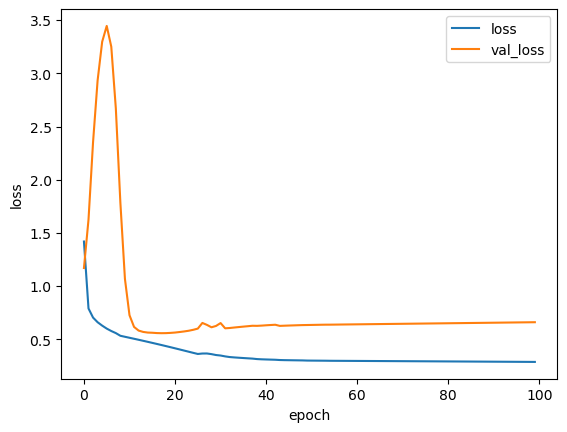

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

train_history = conf.execute_training(
    model, 
    data=train_dataset, 
    plot_history=INTERACTIVE_SESSION
)


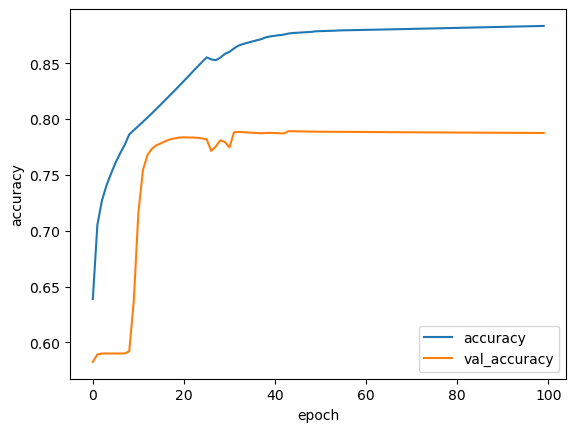

In [10]:
show_convergence(train_history.history, ['accuracy','val_accuracy'])

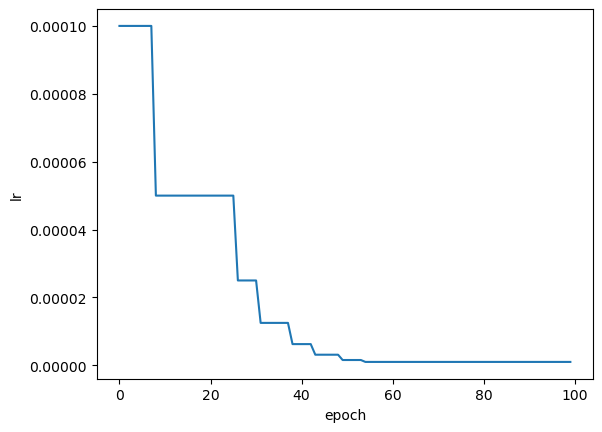

In [11]:
show_convergence(train_history.history, 'lr')

### Visualize predictions

In [12]:
# Load best trained model checkpoint
best_model_track = sorted(glob(conf.save_path+'/*.h5'))
if len(best_model_track):
    model.load_weights(best_model_track[0])

# Generate predictions for all images in the validation set
val_preds = model.predict(valid_dataset)



 1/24 [>.............................] - ETA: 10s


 3/24 [==>...........................] - ETA: 0s 


 5/24 [=====>........................] - ETA: 0s


 7/24 [=======>......................] - ETA: 0s


 9/24 [==========>...................] - ETA: 0s


11/24 [============>.................] - ETA: 0s


13/24 [===============>..............] - ETA: 0s


15/24 [=================>............] - ETA: 0s


17/24 [====================>.........] - ETA: 0s

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



19/24 [======================>.......] - ETA: 0s


21/24 [=========================>....] - ETA: 0s


23/24 [===========================>..] - ETA: 0s


24/24 [==============================] - 1s 44ms/step


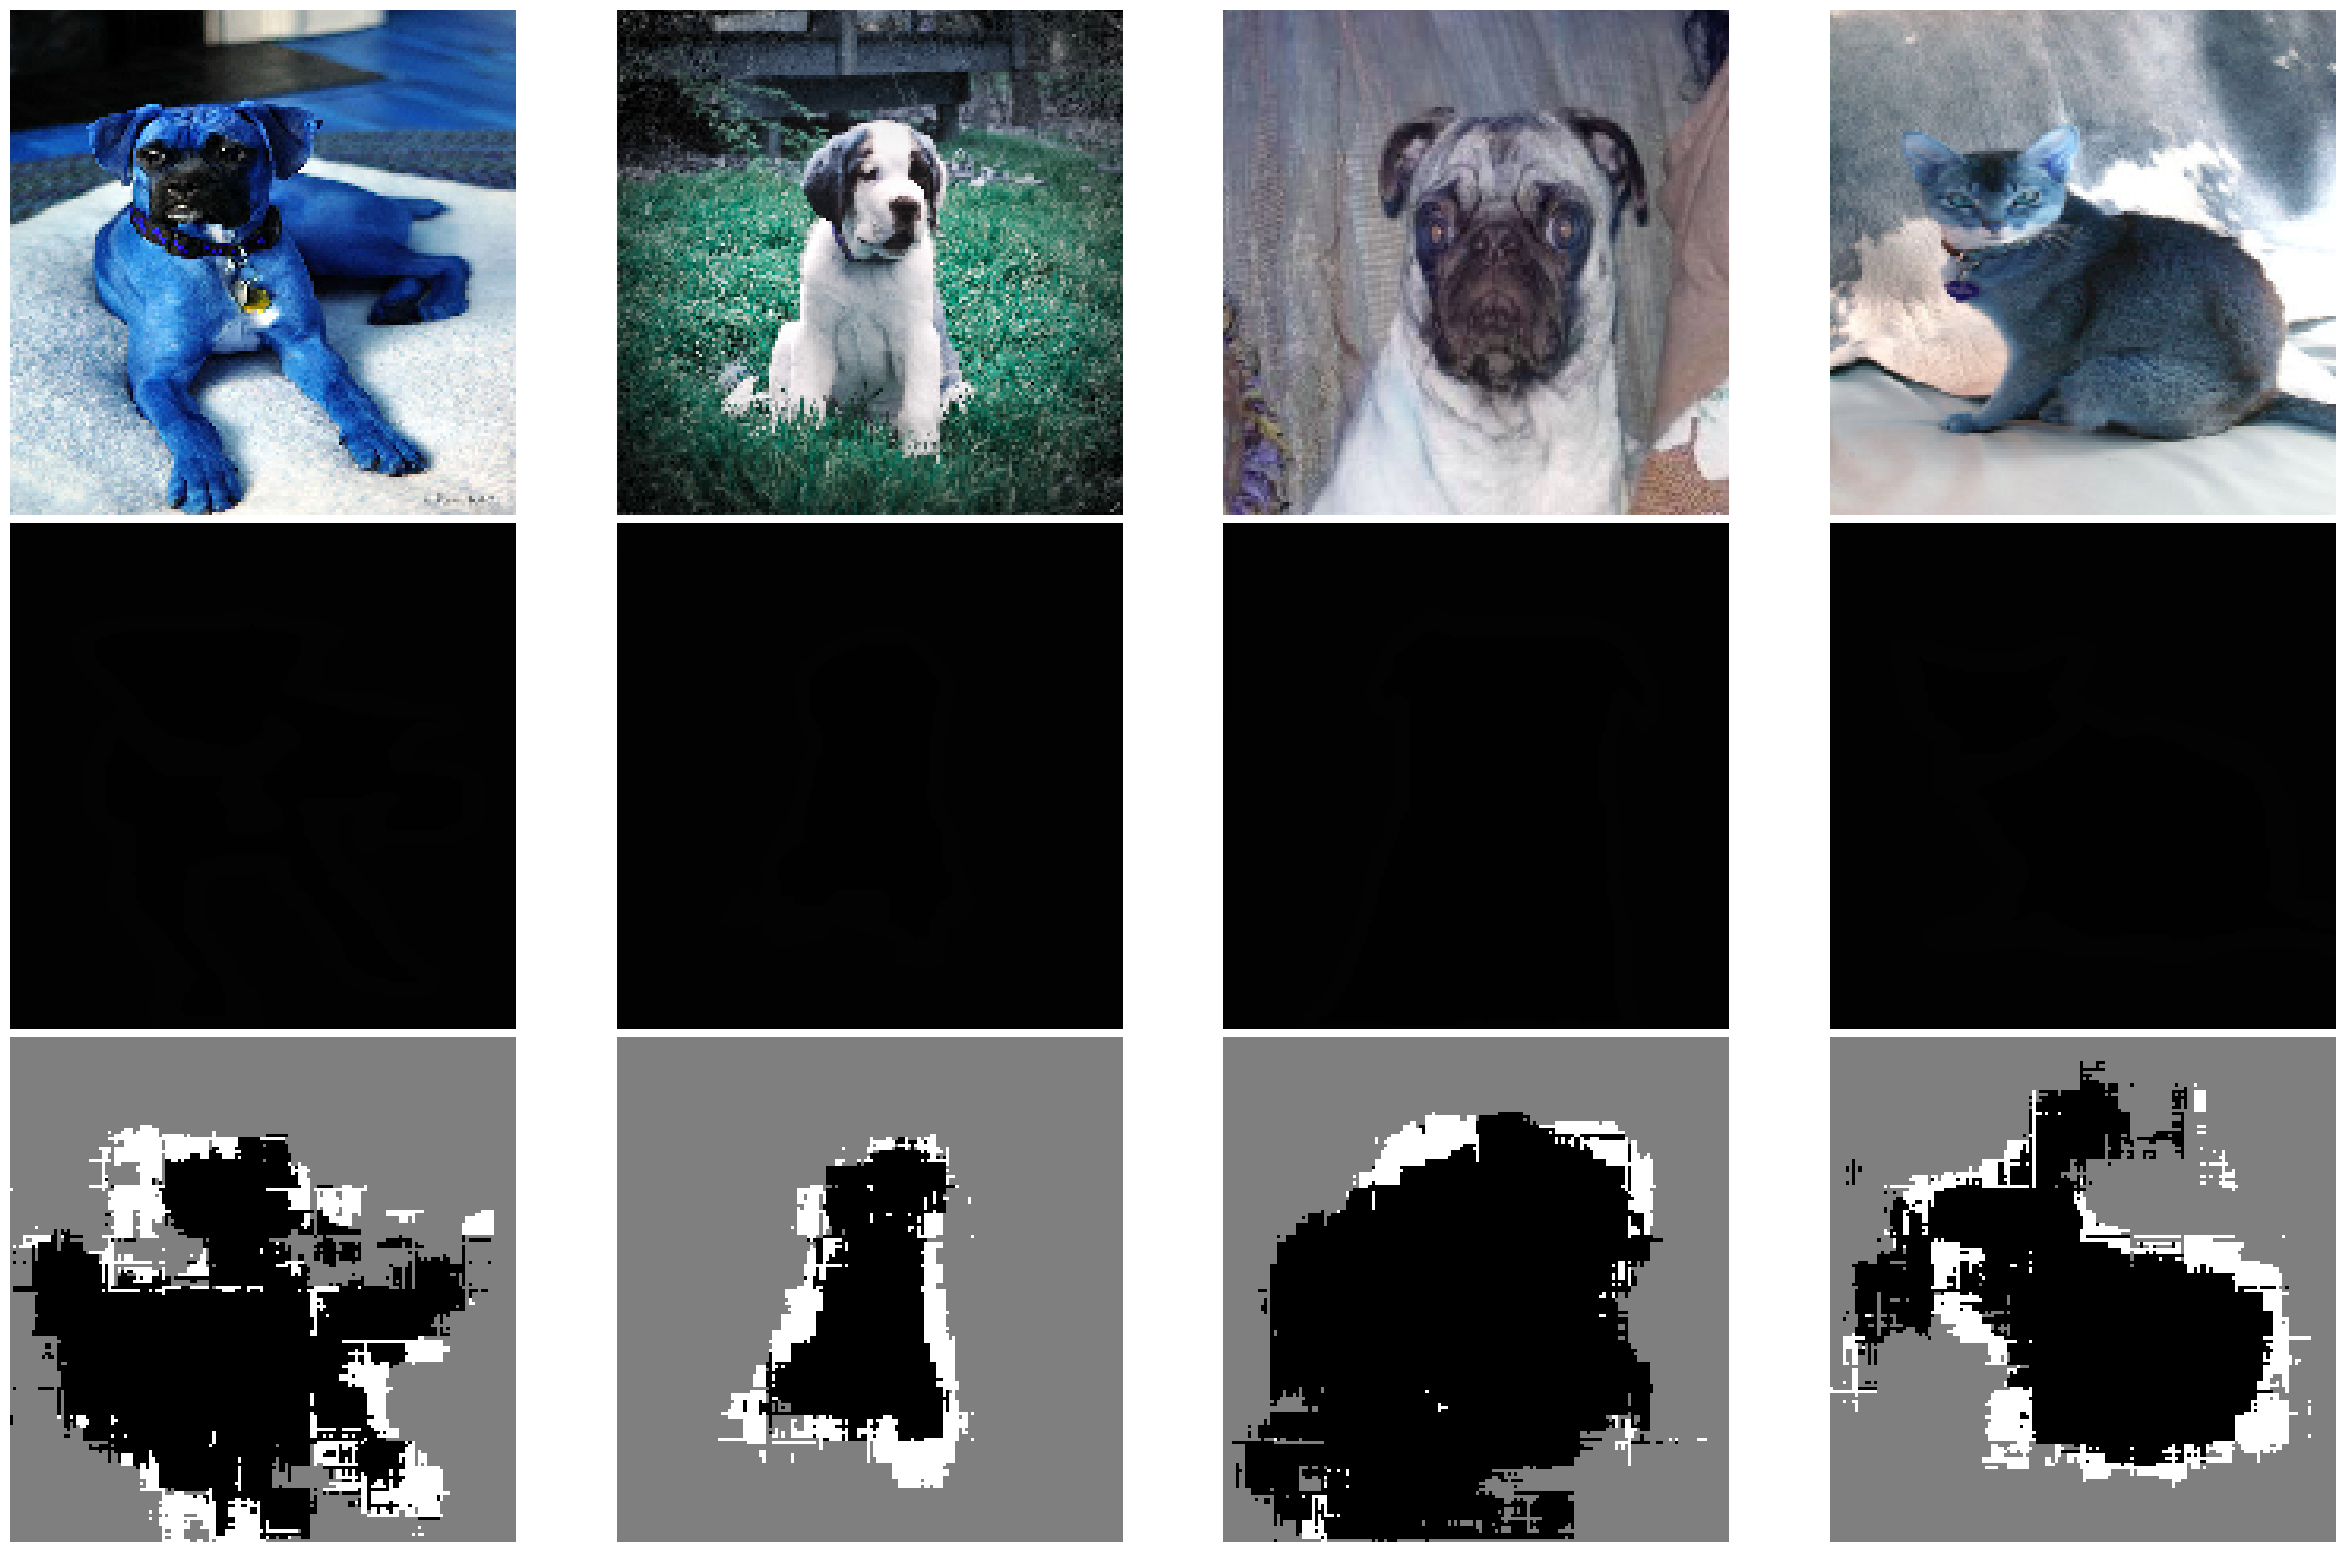

In [13]:

if INTERACTIVE_SESSION:
    pets.display_sample_image(val_preds)


In [14]:
model.evaluate(x=valid_dataset)


 1/24 [>.............................] - ETA: 2s - loss: 0.5909 - accuracy: 0.7676


 3/24 [==>...........................] - ETA: 0s - loss: 0.5409 - accuracy: 0.7870


 5/24 [=====>........................] - ETA: 0s - loss: 0.5471 - accuracy: 0.7871


 7/24 [=======>......................] - ETA: 0s - loss: 0.5488 - accuracy: 0.7860


 9/24 [==========>...................] - ETA: 0s - loss: 0.5545 - accuracy: 0.7839


11/24 [============>.................] - ETA: 0s - loss: 0.5628 - accuracy: 0.7810


12/24 [==============>...............] - ETA: 0s - loss: 0.5682 - accuracy: 0.7789


14/24 [================>.............] - ETA: 0s - loss: 0.5615 - accuracy: 0.7812


15/24 [=================>............] - ETA: 0s - loss: 0.5602 - accuracy: 0.7816


16/24 [===================>..........] - ETA: 0s - loss: 0.5609 - accuracy: 0.7813


17/24 [====================>.........] - ETA: 0s - loss: 0.5599 - accuracy: 0.7816

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9



19/24 [======================>.......] - ETA: 0s - loss: 0.5578 - accuracy: 0.7818


20/24 [========================>.....] - ETA: 0s - loss: 0.5549 - accuracy: 0.7830


22/24 [==========================>...] - ETA: 0s - loss: 0.5571 - accuracy: 0.7818


24/24 [==============================] - ETA: 0s - loss: 0.5573 - accuracy: 0.7818


24/24 [==============================] - 1s 47ms/step - loss: 0.5573 - accuracy: 0.7818


[0.5572831630706787, 0.7818270921707153]